In [1]:
from __future__ import print_function
import time
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.nn.functional import dropout

import re
import sys
import argparse
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Options

In [2]:
sys.argv = 'xz2yx_train.py --name ABC --checkpoints_dir ./checkpoints --dataset horse ' \
        + '--batchSize 4 --heightSize 32 --widthSize 32 --start_epoch 0 --niter 200 --niter_decay 100 ' \
        + '--lrs X2Z:1e-2,Z2X:1e-2,Y2Z:1e-4,Z2Y:1e-4,D:1e-4,T:1e-4 ' \
        + '--z_nc 40 --y_nc 2 ' \
        + '--resize_or_crop crop --ignore_index -100 --unsup_portion 0.90 ' \
        + '--port 1235 --gpu_ids 1 --display_id 0'
sys.argv = sys.argv.split(' ')

In [3]:
# OPTIONS
parser = argparse.ArgumentParser()
################################
# optimizer
################################
parser.add_argument('--niter', type=int, default=100, help='# of iter at starting learning rate')
parser.add_argument('--niter_decay', type=int, default=100, 
                    help='# of iter to linearly decay learning rate to zero')
parser.add_argument('--lrs', type=str, default='X2Z:1e-4,Z2X:1e-4,Y2Z:1e-4,Z2Y:1e-4,D:1e-4,T:1e-4')
parser.add_argument('--lbda', type=str, default='X2X:1,GAN:1,T:1,CE:1')
parser.add_argument('--beta1', type=float, default=0.5, help='momentum term of ADAM')
parser.add_argument('--lr_policy', type=str, default='lambda', 
                    help='learning rate policy: lambda|step|plateau')
################################
# data settings
################################
parser.add_argument('--dataset', type=str, default='cityscapesAB', 
                    help='chooses which dataset is loaded. [cityscapesAB | pascal | camvid]')
parser.add_argument('--which_direction', type=str, default='AtoB', help='AtoB or BtoA')
parser.add_argument('--resize_or_crop', type=str, default='crop')
parser.add_argument('--no_flip', action='store_true', 
                    help='if specified, do not flip the images for data argumentation')
parser.add_argument('--ignore_index', type=int, default=-100, 
                    help='mask this class without contributing to nll_loss')
parser.add_argument('--unsup_portion', type=float, default=0.9, help='unsupervised portion')
################################
# train settings
################################
parser.add_argument('--name', type=str, default='xyx', 
                    help='name of the experiment. It decides where to store samples and models')
parser.add_argument('--checkpoints_dir', default='ckpt', 
                    help='folder to output images and model checkpoints')
parser.add_argument('--save_every', default=2, type=int, help='')
parser.add_argument('--manual_seed', type=int, default=123, help='manual seed')
parser.add_argument('--start_epoch', type=int, default=0, help='epoch number to start with')
parser.add_argument('--nThreads', default=4, type=int, help='# threads for loading data')
parser.add_argument('--gpu_ids', type=str, default='', help='gpu ids: e.g. 0; 0,2')
################################
# model settings
################################
parser.add_argument('--batchSize', type=int, default=1, help='input batch size')
parser.add_argument('--widthSize', type=int, default=256, help='crop to this width')
parser.add_argument('--heightSize', type=int, default=256, help='crop to this height')
parser.add_argument('--x_nc', type=int, default=3, help='# of input image channels')
parser.add_argument('--y_nc', type=int, default=20, help='# of output image channels')
parser.add_argument('--z_nc', type=int, default=40, help='# of output image channels')
parser.add_argument('--use_dropout', action='store_true', help='use dropout for the generator')
parser.add_argument('--ngf', type=int, default=64, help='# of gen filters in first conv layer')
parser.add_argument('--ndf', type=int, default=64, help='# of discrim filters in first conv layer')
################################
# external
################################
parser.add_argument('--display_id', type=int, default=1, help='window id of the web display')
parser.add_argument('--display_winsize', type=int, default=256,  help='display window size')
parser.add_argument('--port', type=int, default=8097, help='port of visdom')
parser.add_argument('--no_html', action='store_true')

_StoreTrueAction(option_strings=['--no_html'], dest='no_html', nargs=0, const=True, default=False, type=None, choices=None, help=None, metavar=None)

In [4]:
opt = parser.parse_args()
opt.isTrain = True
opt.lrs = {klr.split(':')[0]:float(klr.split(':')[1]) for klr in opt.lrs.split(',')}
opt.lbda = {klr.split(':')[0]:float(klr.split(':')[1]) for klr in opt.lbda.split(',')}
print(opt)

# gpu id
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpu_ids # absolute ids
opt.gpu_ids = range(0,len(opt.gpu_ids)) # new range starting from 0

Namespace(batchSize=4, beta1=0.5, checkpoints_dir='./checkpoints', dataset='horse', display_id=0, display_winsize=256, gpu_ids='1', heightSize=32, ignore_index=-100, isTrain=True, lbda={'X2X': 1.0, 'GAN': 1.0, 'T': 1.0, 'CE': 1.0}, lr_policy='lambda', lrs={'X2Z': 0.01, 'Z2X': 0.01, 'Y2Z': 0.0001, 'Z2Y': 0.0001, 'D': 0.0001, 'T': 0.0001}, manual_seed=123, nThreads=4, name='ABC', ndf=64, ngf=64, niter=200, niter_decay=100, no_flip=False, no_html=False, port=1235, resize_or_crop='crop', save_every=2, start_epoch=0, unsup_portion=0.9, use_dropout=False, which_direction='AtoB', widthSize=32, x_nc=3, y_nc=2, z_nc=40)


# data_loaders

In [5]:
from data.data_loader import CreateDataLoader,InfiniteDataLoader,XYDataLoader
from util.visualizer import Visualizer

opt.unsup_sampler = 'sep'
opt.phase = 'val'
opt.isTrain = False
val_loader = CreateDataLoader(opt)
opt = val_loader.update_opt(opt)

opt.phase = 'train'
opt.isTrain = True
paired_loader = XYDataLoader(opt, is_paired=True)
x_loader = XYDataLoader(opt, is_paired=False) # will use x only
y_loader = XYDataLoader(opt, is_paired=False) # will use y only

# wrap with infinite loader
paired_loader = InfiniteDataLoader(paired_loader)
x_loader = InfiniteDataLoader(x_loader)
y_loader = InfiniteDataLoader(y_loader)

# Visualizer
visualizer = Visualizer(opt)

===> dataset [HorseDataset] was created
==> unsupervised portion = 0.910
===> dataset [HorseDataset] was created
==> unsupervised portion = 0.910
===> dataset [HorseDataset] was created
==> unsupervised portion = 0.905
===> dataset [HorseDataset] was created
===> Create results directory: ./checkpoints/ABC/results
==> OPTIONS:
xz2yx_train.py --name ABC --checkpoints_dir ./checkpoints --dataset horse --batchSize 4 --heightSize 32 --widthSize 32 --start_epoch 0 --niter 200 --niter_decay 100 --lrs X2Z:1e-2,Z2X:1e-2,Y2Z:1e-4,Z2Y:1e-4,D:1e-4,T:1e-4 --z_nc 40 --y_nc 2 --resize_or_crop crop --ignore_index -100 --unsup_portion 0.90 --port 1235 --gpu_ids 1 --display_id 0



# networks

In [6]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [7]:
class NET_X2Z(nn.Module):
    def __init__(self, in_nc, opt, n_blocks=5):
        super(NET_X2Z, self).__init__()
        self.gpu_ids = opt.gpu_ids
        norm_layer=nn.BatchNorm2d
        use_bias = False
        use_dropout = opt.use_dropout
        padding_type='reflect'
        ngf = opt.ngf
        n_downsampling = 2
        
        # init conv: input_nc -> ngf
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(in_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        # downsampling x4: ngf -> ndf * 2^2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]
            
        # resnet blocks: ngf * 4 -> ngf * 4
        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, 
                                  padding_type=padding_type, norm_layer=norm_layer, 
                                  use_dropout=use_dropout, use_bias=use_bias)]
        
        self.encode = nn.Sequential(*model)
        
        self.conv_mean = nn.Sequential(nn.ReflectionPad2d(2),
                                       nn.Conv2d(ngf * mult, ngf * mult, kernel_size=5, padding=0))
        self.conv_logstd = nn.Sequential(nn.ReflectionPad2d(2),
                                         nn.Conv2d(ngf * mult, ngf * mult, kernel_size=5, padding=0))
        self.z_nc = ngf * mult
        
    def reparameterize(self, mu, logsigma2):
        if self.training:
            sigma = torch.exp(0.5 * logsigma2)
            eps = Variable(sigma.data.new(sigma.size()).normal_(0,1))
            return eps.mul(sigma).add_(mu)
        else:
            return mu

    def forward(self, input, do_vae=False):
        hidden = self.encode(input)
        if do_vae:
            mu, logsigma2 = self.conv_mean(hidden), self.conv_logstd(hidden)
            z = self.reparameterize(mu, logsigma2)
            return z, mu, logsigma2
        else:
            return self.conv_mean(hidden)

In [8]:
class NET_T(nn.Module):
    def __init__(self, input_nc, opt, n_blocks=5):
        super(NET_T, self).__init__()
        self.gpu_ids = opt.gpu_ids
        norm_layer=nn.BatchNorm2d
        use_bias = False
        use_dropout = opt.use_dropout
        padding_type='reflect'
        ngf = opt.ngf
        n_downsampling = 2
        
        model = []
        # resnet blocks: ngf * 4 -> ngf * 4
        #mult = 2**n_downsampling
        #input_nc = ngf * mult
        for i in range(n_blocks):
            model += [ResnetBlock(input_nc, 
                                  padding_type=padding_type, norm_layer=norm_layer, 
                                  use_dropout=use_dropout, use_bias=use_bias)]

        self.model = nn.Sequential(*model)
        
    def forward(self, input):
        return self.model(input)

In [9]:
class NET_Z2X(nn.Module):
    def __init__(self, in_nc, out_nc, opt, final_nlin=nn.Tanh(), n_blocks=5):
        super(NET_Z2X, self).__init__()
        self.gpu_ids = opt.gpu_ids
        norm_layer=nn.BatchNorm2d
        use_bias = False
        use_dropout = opt.use_dropout
        padding_type='reflect'
        ngf = opt.ngf
        n_downsampling = 2
        
        model = []
        # resnet blocks: ngf * 4 -> ngf * 4
        mult = 2**n_downsampling
        assert(in_nc == ngf * mult)
        for i in range(n_blocks):
            model += [ResnetBlock(in_nc, 
                                  padding_type=padding_type, norm_layer=norm_layer, 
                                  use_dropout=use_dropout, use_bias=use_bias)]
        
        # upsampling blocks: ngf*4 -> ngf
        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
            #model += [nn.Conv2d(ngf * mult, int(ngf * mult / 2) * 4,
            #                    kernel_size=3, stride=1, padding=1, bias=use_bias),
            #          nn.PixelShuffle(2),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        # final conv: ngf -> z_nc
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, out_nc, kernel_size=7, padding=0)]
        model += [final_nlin]

        self.model = nn.Sequential(*model)
        
    def forward(self, input):
        return self.model(input)

In [10]:
from math import ceil
class Discriminator(nn.Module):
    def __init__(self, input_nc, opt, norm_layer=nn.BatchNorm2d):
        super(Discriminator, self).__init__()
        self.gpu_ids = opt.gpu_ids
        ndf = opt.ndf
        z_nc = opt.z_nc
        n_layers = 5
        kw = 4
        padw = int(ceil((kw-1)/2))

        # first conv-leakyReLU
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        # n layers conv-BN-leakyReLU
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                                kernel_size=kw, stride=2, padding=padw),
                norm_layer(ndf * nf_mult, affine=True),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                            kernel_size=kw, stride=1, padding=padw),
            norm_layer(ndf * nf_mult, affine=True),
            nn.LeakyReLU(0.2, True)
        ]
        sequence += [nn.Conv2d(ndf * nf_mult, z_nc, kernel_size=kw, stride=1, padding=padw)]
        self.model = nn.Sequential(*sequence)
    
    def forward(self, input):
        output = self.model(input)
        output = output.view(output.size(0), -1)
        return output

In [11]:
from models.networks import weights_init

net =dict()
net['X2Z'] = NET_X2Z(opt.x_nc, opt)
net['Z2X'] = NET_Z2X(net['X2Z'].z_nc, opt.x_nc, opt, nn.Tanh())
net['Y2Z'] = NET_X2Z(opt.y_nc, opt)
net['Z2Y'] = NET_Z2X(net['Y2Z'].z_nc, opt.y_nc, opt, nn.LogSoftmax(dim=1))
net['D'] = Discriminator(net['Y2Z'].z_nc, opt)
net['T'] = NET_T(net['X2Z'].z_nc, opt)

for k in net.keys():
    if len(opt.gpu_ids) > 0: net[k].cuda(opt.gpu_ids[0])
    # init
    net[k].apply(weights_init)
    # load if found saved weights
    weights_fpath = os.path.join(opt.checkpoints_dir, opt.name, 'net%s.pth' % (k))
    if os.path.exists(weights_fpath):
        print('Load net[%s] from %s' % (k, weights_fpath))
        net[k].load_state_dict(torch.load(weights_fpath, map_location=lambda storage, loc: storage))

Load net[X2Z] from ./checkpoints/ABC/netX2Z.pth
Load net[Z2X] from ./checkpoints/ABC/netZ2X.pth
Load net[Y2Z] from ./checkpoints/ABC/netY2Z.pth
Load net[Z2Y] from ./checkpoints/ABC/netZ2Y.pth
Load net[D] from ./checkpoints/ABC/netD.pth
Load net[T] from ./checkpoints/ABC/netT.pth


# optimizers

In [12]:
from torch.optim import lr_scheduler

def get_scheduler(optimizer):
    if opt.lr_policy == 'lambda':
        def lambda_rule(epoch): # decay to 0 starting from epoch=niter_decay
            lr_l = 1.0 - max(0, epoch + 1 - opt.niter + opt.niter_decay) / float(opt.niter_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, 
                                                   threshold=0.01, patience=5)
    elif opt.lr_policy == 'stairs':
        scheduler = lr_scheduler.MultiStepLR(optimizer, [60, 120, 160], gamma=0.2)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler

optimizers = dict()
schedulers = dict()
for k in net.keys():
    print('Creating optimizer for net[%s]' % k)
    optimizers[k] = optim.Adam(net[k].parameters(), lr=opt.lrs[k], betas=(opt.beta1, 0.999))
    schedulers[k] = get_scheduler(optimizers[k])

def adjust_lr(epoch, netkeys=schedulers.keys()):
    print('===> Start of epoch %d / %d' % (epoch, opt.niter))
    for k, sch in schedulers.items():
        if k in netkeys:
            sch.step(epoch=epoch)
        lr = optimizers[k].param_groups[0]['lr']
        print('%s: learning rate = %.7f' % (k,lr))

Creating optimizer for net[X2Z]
Creating optimizer for net[Z2X]
Creating optimizer for net[Y2Z]
Creating optimizer for net[Z2Y]
Creating optimizer for net[D]
Creating optimizer for net[T]


# losses, variables

In [13]:
CE = torch.nn.NLLLoss2d(ignore_index=opt.ignore_index)
L1 = torch.nn.L1Loss()
MSE = torch.nn.MSELoss()
if len(opt.gpu_ids) > 0:
    CE = CE.cuda(opt.gpu_ids[0])
    L1 = L1.cuda(opt.gpu_ids[0])
    MSE = MSE.cuda(opt.gpu_ids[0])

t_x = torch.FloatTensor(opt.batchSize, opt.x_nc, opt.heightSize, opt.widthSize)
t_y_int = torch.LongTensor(opt.batchSize, opt.heightSize, opt.widthSize)

heightSize = val_loader.dataset.heightSize
widthSize = val_loader.dataset.widthSize
xx = torch.FloatTensor(1, opt.x_nc, heightSize, widthSize)
yy_int = torch.LongTensor(1, heightSize, widthSize)

if len(opt.gpu_ids) > 0:
    t_x = t_x.cuda(opt.gpu_ids[0])
    t_y_int = t_y_int.cuda(opt.gpu_ids[0])
    xx = xx.cuda(opt.gpu_ids[0])
    yy_int = yy_int.cuda(opt.gpu_ids[0])

# Train functions

In [14]:
def populate_xy(x, y_int, dataloader, opt):
    AtoB = opt.which_direction == 'AtoB'
    real_cpu = dataloader.next()
    if x is not None:
        x_cpu = real_cpu['A' if AtoB else 'B']
        #x.data.resize_(x_cpu.size()).copy_(x_cpu)
        assert(x.size() == x_cpu.size())
        x.copy_(x_cpu)
    if y_int is not None:
        y_cpu = real_cpu['B' if AtoB else 'A']
        assert(y_int.size() == y_cpu.size())
        y_int.copy_(y_cpu)

def one_hot(y_int, opt):
    y_temp = y_int.unsqueeze(dim=1)
    y = torch.FloatTensor(y_int.size(0), opt.y_nc, y_int.size(1), y_int.size(2))
    if len(opt.gpu_ids) > 0:
        y = y.cuda()
    y.zero_().scatter_(1, y_temp, 1)
    return y

In [15]:
def generate_var_x(tensor=t_x, loader=x_loader):
    populate_xy(tensor, None, loader, opt)
    v_x = Variable(tensor)
    return v_x

def generate_var_y(tensor=t_y_int, loader=y_loader, temperature=0.0):
    populate_xy(None, tensor, loader, opt)
    v_y_int = Variable(tensor)
    v_y = Variable(one_hot(tensor, opt))
    return (v_y_int, v_y)

def generate_var_xy(tensors=[t_x,t_y_int], loader=paired_loader, volatile=False, temperature=0.0):
    populate_xy(tensors[0], tensors[1], loader, opt)
    v_x = Variable(tensors[0], volatile=volatile)
    v_y_int = Variable(tensors[1], volatile=volatile)
    v_y = Variable(one_hot(tensors[1], opt), volatile=volatile)
    return (v_x, v_y_int, v_y)

In [16]:
def x2x_forward(v_x):
    z_x = net['X2Z'](v_x)
    x_hat = net['Z2X'](z_x)
    loss = L1(x_hat, v_x)
    return loss, z_x, {'x_hat':x_hat.data.cpu(), 'x':v_x.data.cpu()} # TODO: return dict only needed

def y2y_forward(v_y_int, v_y, do_vae=True):
    if do_vae:
        z_y, mu, logsigma2 = net['Y2Z'](v_y, do_vae=do_vae)
    else:
        z_y = net['Y2Z'](v_y, do_vae=do_vae)
    y_hat = net['Z2Y'](z_y)
    loss = CE(y_hat, v_y_int)
    if do_vae:
        # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = 1e-4 * -0.5 * torch.sum(1 + logsigma2 - mu.pow(2) - logsigma2.exp())
        loss += KLD
    return loss, z_y, {'y_hat':y_hat.data.cpu().numpy().argmax(1), 'y':v_y_int.data.cpu().numpy()}

def T_forward(z_x, z_y=None, v_y_int=None):
    losses = {}
    images = {}
    Tz_y = net['T'](z_x)
    loss_GAN = -1 * net['D'](Tz_y).mean()
    losses['GAN'] = loss_GAN
    if z_y is not None: # with paired x,y
        loss_T = MSE(Tz_y, z_y.detach())
        losses['T'] = loss_T
    if v_y_int is not None:
        y_tilde = net['Z2Y'](Tz_y)
        loss_CE = CE(y_tilde, v_y_int)
        losses['CE'] = loss_CE
        images = {'y_tilde':y_tilde.data.cpu().numpy().argmax(1)}
    return losses, images

In [17]:
def G_backward(losses):
    # Y2Y
    optimizers['Y2Z'].zero_grad()
    optimizers['Z2Y'].zero_grad()
    losses['Y2Y'].backward()
    optimizers['Y2Z'].step()
    optimizers['Z2Y'].step()
    
    # X
    loss_X = opt.lbda['X2X']*losses['X2X']
    if 'GAN' in losses:
        loss_X += opt.lbda['GAN']*losses['GAN']
    if 'T' in losses:
        loss_X += opt.lbda['T']*losses['T']
    if 'CE' in losses:
        loss_X += opt.lbda['CE']*losses['CE']
    
    optimizers['X2Z'].zero_grad()
    optimizers['Z2X'].zero_grad()
    if 'GAN' in losses: # GAN always exists when updating net_T
        optimizers['T'].zero_grad()
    if 'CE' in losses:
        optimizers['Z2Y'].zero_grad()
    loss_X.backward()
    optimizers['X2Z'].step()
    optimizers['Z2X'].step()
    if 'GAN' in losses:
        optimizers['T'].step()
    if 'CE' in losses:
        optimizers['Z2Y'].step()

def D_forbackward(v_x, v_y):
    z_x  = net['X2Z'](v_x)
    z_y, mu, logsigma2 = net['Y2Z'](v_y, do_vae=True) # real
    Tz_y = net['T']( z_x ) # fake
    
    E_q_D = net['D']( Tz_y.detach() )
    E_p_D = net['D']( z_y.detach() )
    d_loss = E_q_D.mean() - E_p_D.mean()

    optimizers['D'].zero_grad()
    d_loss.backward()
    optimizers['D'].step()
    
    # clamp parameters to a cube
    for p in net['D'].parameters():
        p.data.clamp_(-0.01, 0.01)

    return d_loss.data[0]

# Evaluation

In [38]:
from util.meter import SegmentationMeter

def evaluation(epoch, subset='train'):
    net['X2Z'].eval()
    net['Z2Y'].eval()
    net['T'].eval()
    net['Z2X'].eval()

    eval_stats = SegmentationMeter(n_class=opt.y_nc, ignore_index=opt.ignore_index)
    E_loss = {'CE':0, 'T':0, 'GAN':0, 'X2X':0, 'Y2Y':0}

    lval = len(val_loader)
    start_time = time.time()
    val_loader_iter = iter(val_loader)
    for i in range(lval):
        i_losses = {}
        images = {}
        v_x, v_y_int, v_y = generate_var_xy([xx, yy_int], val_loader_iter, True)
        
        i_losses['X2X'], z_x, x_hat_dict = x2x_forward(v_x) # X2XP
        i_losses['Y2Y'], z_y, y_hat_dict = y2y_forward(v_y_int, v_y) # Y2YP
        T_losses, y_tilde_dict = T_forward(z_x, z_y=z_y, v_y_int=v_y_int) # GANP, T, CE
        i_losses.update(T_losses)
            
        E_loss = {k:E_loss[k]+v.data[0] for k,v in i_losses.items()}

        pred = y_hat_dict['y_hat']
        gt = y_hat_dict['y']
        eval_stats.update_confmat(gt, pred)
        
        if i % 20 == 0:
            images.update(x_hat_dict)
            images.update(y_hat_dict)
            images.update(y_tilde_dict)
            display_imgs(images, epoch, i, subset=subset, do_save=2)

    E_loss = {k:v/lval for k,v in E_loss.items()}
    eval_results = eval_stats.get_eval_results()
    msg = 'EVAL at epoch %d ==> CE: {CE:.3f}, T: {T:.3f} GAN: {GAN:.3f}, X2X: {X2X:.3f}'.format(epoch, **E_loss)
    msg += 'EVAL at epoch %d [%d images in %.2f sec] ==> %s\n' % \
            (epoch, lval, time.time()-start_time, eval_results[0])
    msg += 'Per-class IoU:\n'
    msg += ''.join(['%s: %.2f\n' % (cname,ciu)
                    for cname,ciu in zip(val_loader.dataset.label2name, eval_results[1])])
    print(msg)
    with open(visualizer.log_name, "a") as log_file:
        log_file.write('%s' % msg)

    net['X2Z'].train()
    net['Z2Y'].train()
    net['T'].train()
    net['Z2X'].train()

    return eval_results[0]['Mean IoU']

In [21]:
def plot_dict_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.
    figures : <title, figure> dictionary
    """
    #figsize = list(figures.values())[0].shape[:-1]
    figsize=(15,15)
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    for ind,title in zip(range(len(figures)), figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.jet())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

#from util.util import tensor2lab
def tensor2lab(lab_tensor, n_labs):
    label2color = plt.cm.jet(np.linspace(0,1,n_labs), bytes=True)[:,0:3]
    seg_map = lab_tensor[0] # HW
    seg_map = seg_map.astype(np.int32)
    assert(len(seg_map.shape) == 2)
    seg_image = label2color[seg_map].astype(np.uint8) # HW3
    return seg_image.transpose((2,0,1)) # 3HW

def display_imgs(images, epoch, i, subset='train', do_save=0):
    for k, im in images.items():
        if 'y' in k:
            images[k] = tensor2lab(im, opt.y_nc) # 3HW
        elif 'z' in k:
            images[k] = tensor2lab(im, opt.z_nc) # 3HW
        elif 'x' in k:
            images[k] = im[0] # 3HW
            d_mean = torch.FloatTensor(val_loader.dataset.mean).view(-1,1,1) # (3) -> (3,1,1)
            d_std = torch.FloatTensor(val_loader.dataset.std).view(-1,1,1)
            images[k] *= d_std
            images[k] += d_mean
            images[k] = images[k].mul(255).clamp(0,255).byte().numpy() # 3HW
            
    #visualizer.display_current_results(images, epoch, i, subset=subset, do_save=do_save)
    images = {k:v.transpose(1, 2, 0) for k,v in images.items()}
    plot_dict_figures(images, 1, len(images))

# Pretrain X2X and Y2Y

===> Start of epoch 0 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[0/150][0/50] in 0.074s X2X: 0.995, Y2Y: 4218.223 


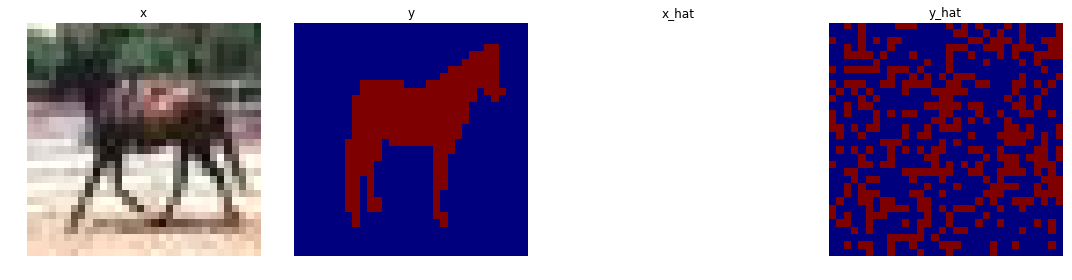

===> End of epoch 0 / 150 	 Time Taken: 3.14 sec

===> Start of epoch 1 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[1/150][0/50] in 0.052s X2X: 0.282, Y2Y: 304.334 


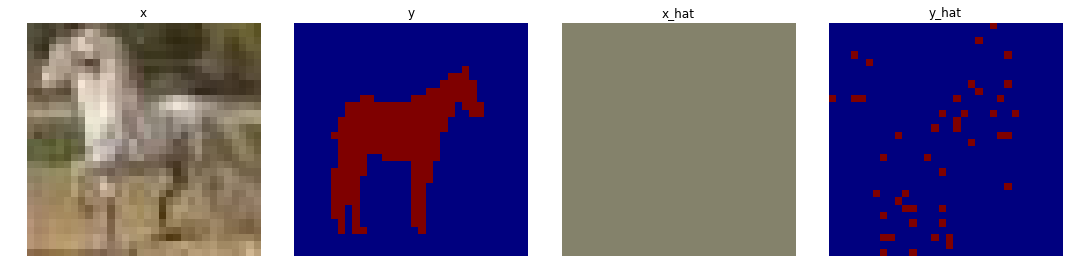

===> End of epoch 1 / 150 	 Time Taken: 3.07 sec

===> Start of epoch 2 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[2/150][0/50] in 0.047s X2X: 0.222, Y2Y: 194.042 


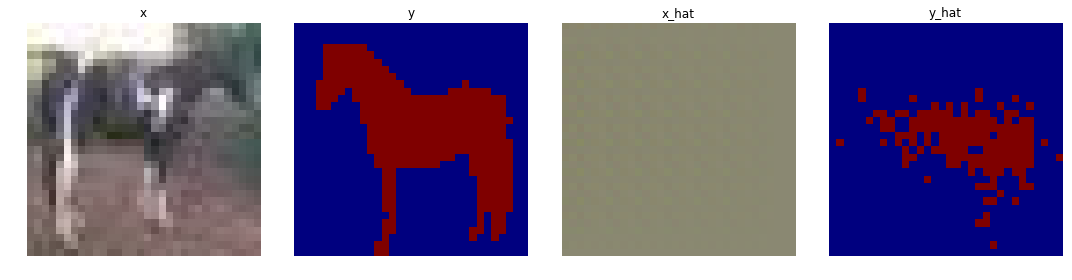

===> End of epoch 2 / 150 	 Time Taken: 3.03 sec

===> Start of epoch 3 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[3/150][0/50] in 0.050s X2X: 0.208, Y2Y: 93.915 


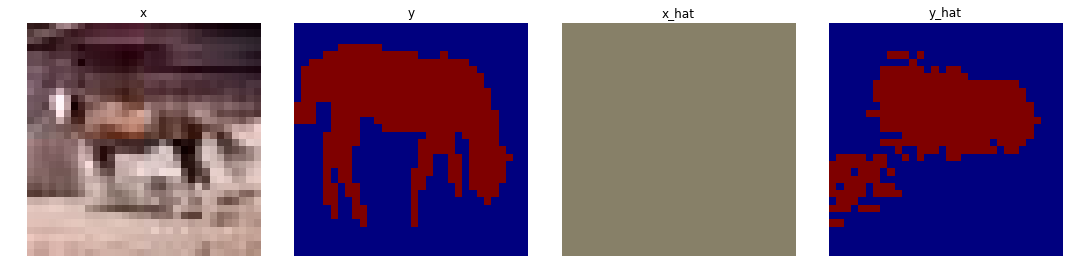

===> End of epoch 3 / 150 	 Time Taken: 3.22 sec

===> Start of epoch 4 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[4/150][0/50] in 0.048s X2X: 0.204, Y2Y: 100.183 


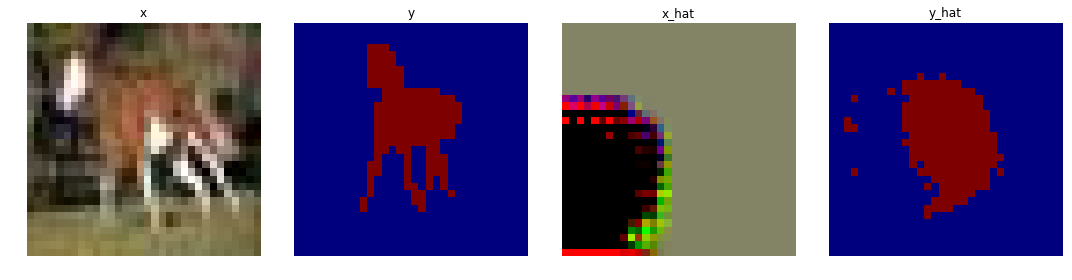

===> End of epoch 4 / 150 	 Time Taken: 3.11 sec

===> Start of epoch 5 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[5/150][0/50] in 0.046s X2X: 0.194, Y2Y: 64.376 


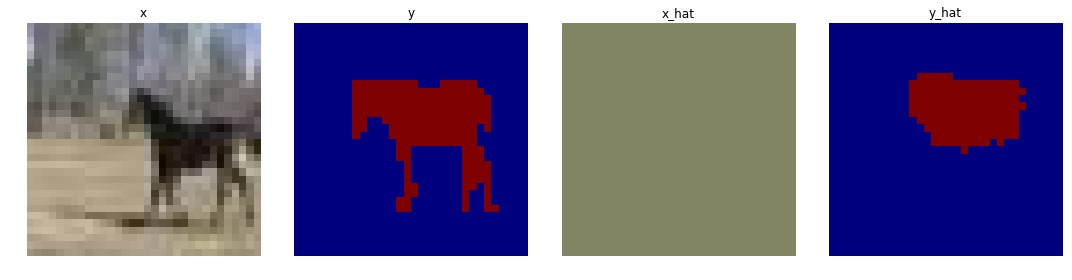

===> End of epoch 5 / 150 	 Time Taken: 3.00 sec

===> Start of epoch 6 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[6/150][0/50] in 0.050s X2X: 0.232, Y2Y: 59.935 


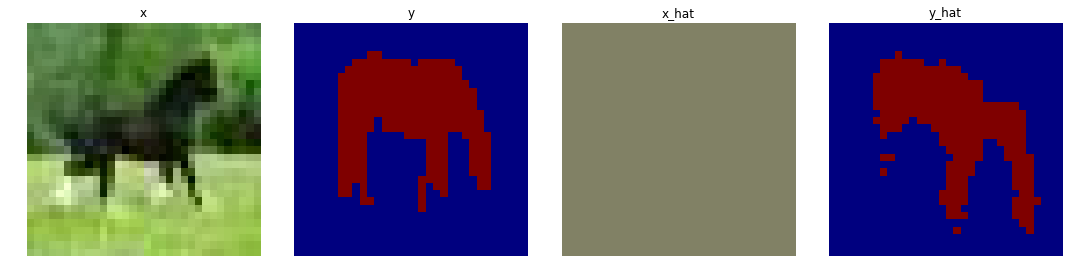

===> End of epoch 6 / 150 	 Time Taken: 3.05 sec

===> Start of epoch 7 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[7/150][0/50] in 0.053s X2X: 0.231, Y2Y: 50.190 


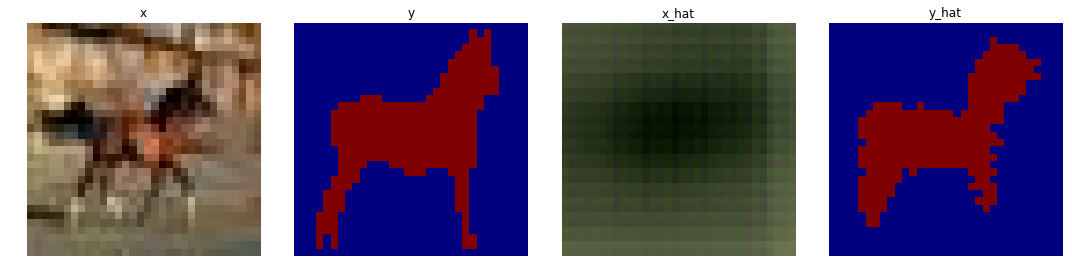

===> End of epoch 7 / 150 	 Time Taken: 3.24 sec

===> Start of epoch 8 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[8/150][0/50] in 0.053s X2X: 0.182, Y2Y: 45.471 


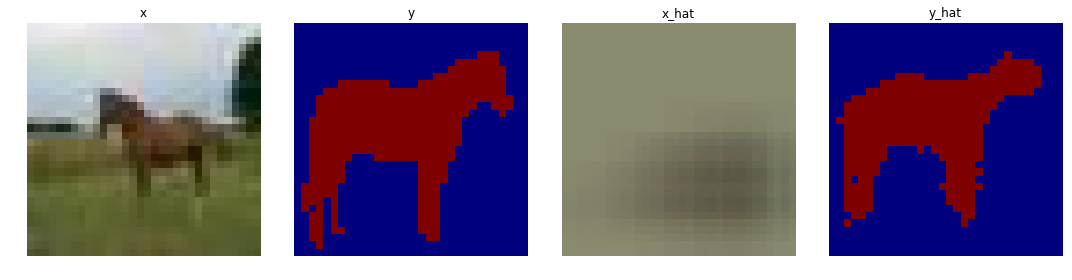

===> End of epoch 8 / 150 	 Time Taken: 3.35 sec

===> Start of epoch 9 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[9/150][0/50] in 0.057s X2X: 0.176, Y2Y: 40.706 


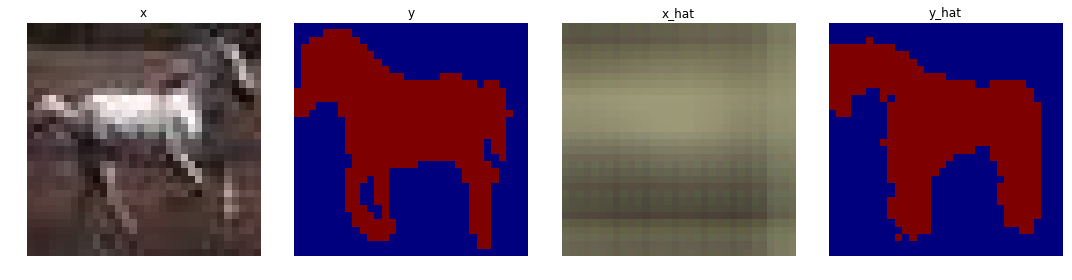

===> End of epoch 9 / 150 	 Time Taken: 3.52 sec

===> Start of epoch 10 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[10/150][0/50] in 0.055s X2X: 0.160, Y2Y: 34.935 


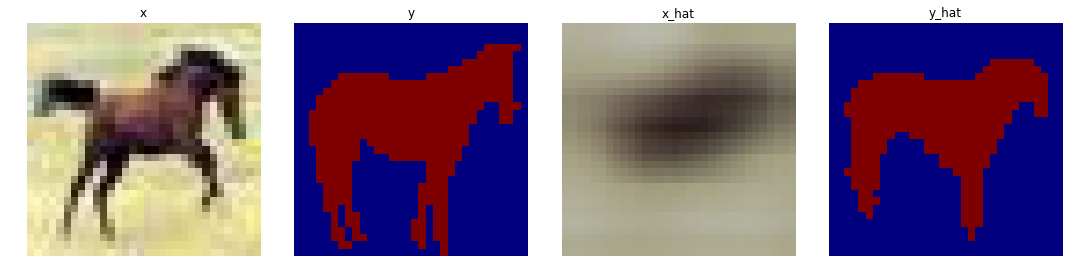

===> End of epoch 10 / 150 	 Time Taken: 3.33 sec

===> Start of epoch 11 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[11/150][0/50] in 0.052s X2X: 0.137, Y2Y: 32.183 


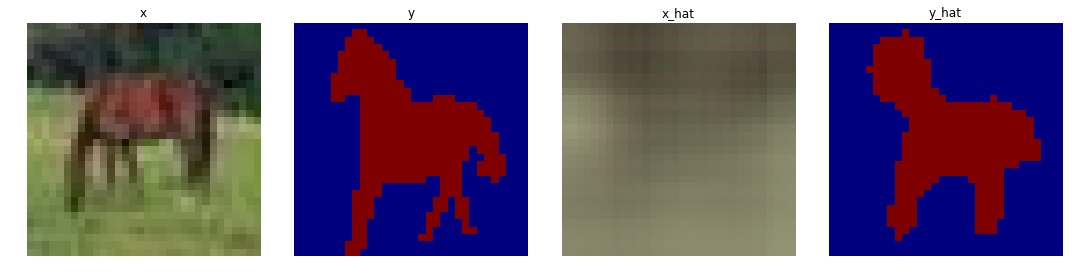

===> End of epoch 11 / 150 	 Time Taken: 3.26 sec

===> Start of epoch 12 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[12/150][0/50] in 0.052s X2X: 0.131, Y2Y: 31.001 


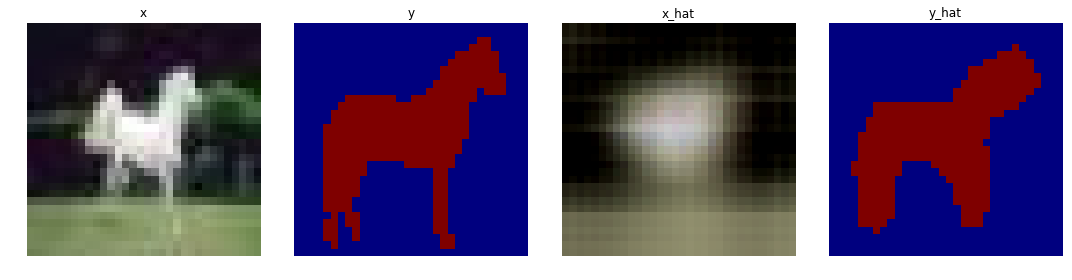

===> End of epoch 12 / 150 	 Time Taken: 3.27 sec

===> Start of epoch 13 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[13/150][0/50] in 0.052s X2X: 0.120, Y2Y: 35.293 


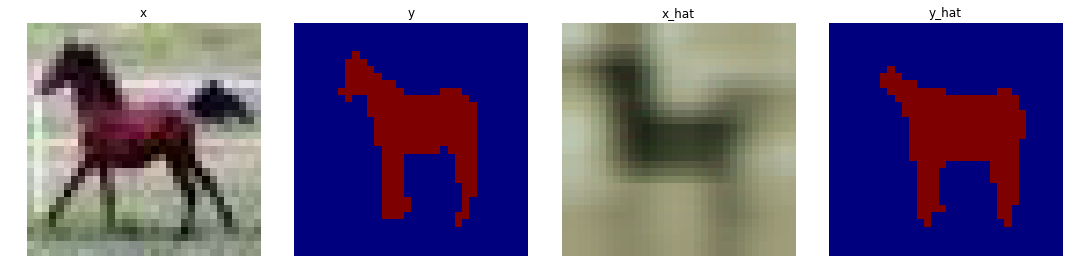

===> End of epoch 13 / 150 	 Time Taken: 3.30 sec

===> Start of epoch 14 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[14/150][0/50] in 0.055s X2X: 0.124, Y2Y: 30.036 


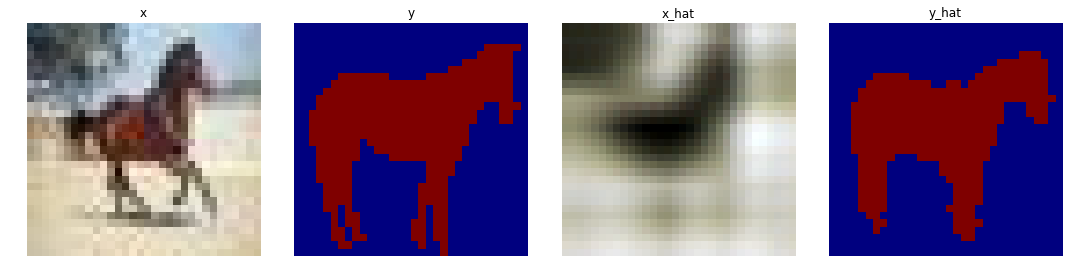

===> End of epoch 14 / 150 	 Time Taken: 3.37 sec

===> Start of epoch 15 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[15/150][0/50] in 0.053s X2X: 0.149, Y2Y: 25.697 


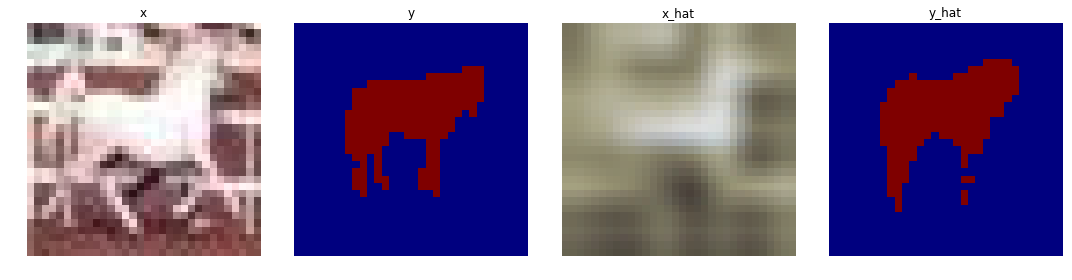

===> End of epoch 15 / 150 	 Time Taken: 3.39 sec

===> Start of epoch 16 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[16/150][0/50] in 0.059s X2X: 0.132, Y2Y: 23.359 


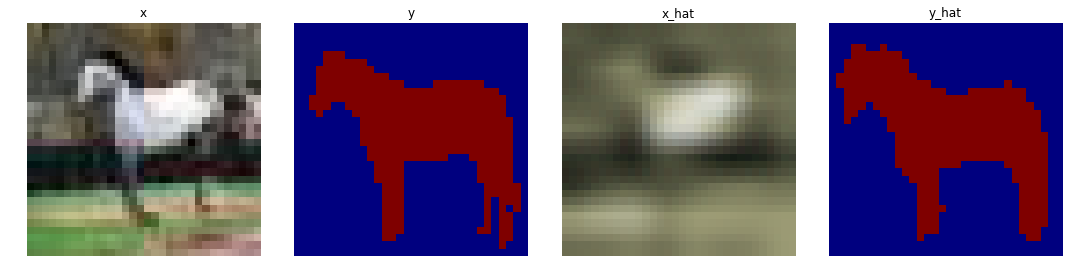

===> End of epoch 16 / 150 	 Time Taken: 3.42 sec

===> Start of epoch 17 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[17/150][0/50] in 0.061s X2X: 0.121, Y2Y: 23.417 


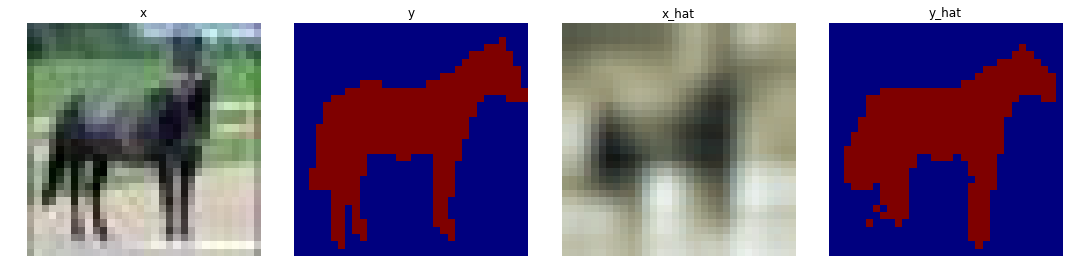

===> End of epoch 17 / 150 	 Time Taken: 3.30 sec

===> Start of epoch 18 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[18/150][0/50] in 0.053s X2X: 0.118, Y2Y: 21.986 


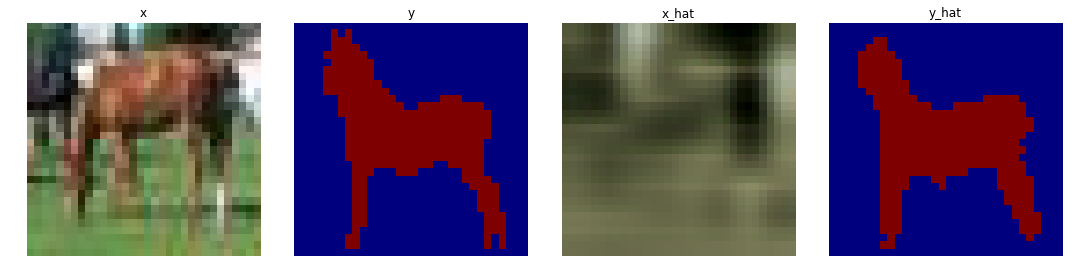

===> End of epoch 18 / 150 	 Time Taken: 3.41 sec

===> Start of epoch 19 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[19/150][0/50] in 0.073s X2X: 0.212, Y2Y: 21.669 


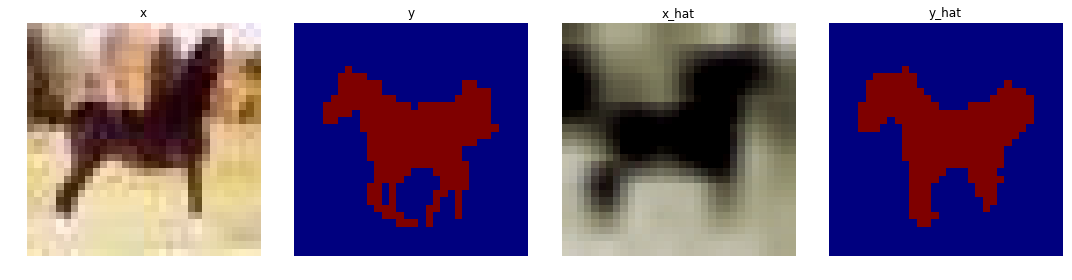

===> End of epoch 19 / 150 	 Time Taken: 3.42 sec

===> Start of epoch 20 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[20/150][0/50] in 0.055s X2X: 0.094, Y2Y: 21.877 


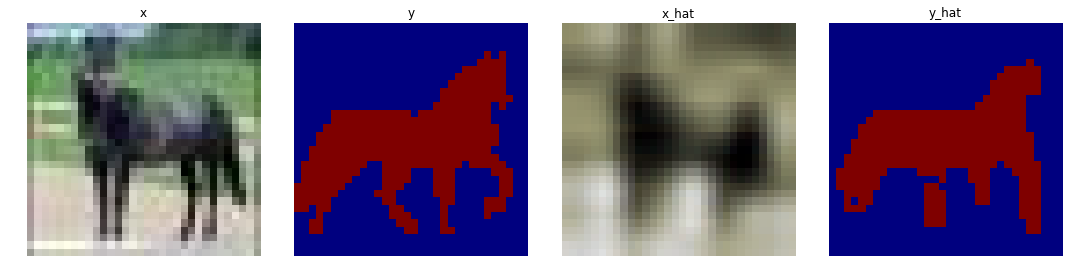

===> End of epoch 20 / 150 	 Time Taken: 3.52 sec

===> Start of epoch 21 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[21/150][0/50] in 0.052s X2X: 0.104, Y2Y: 21.501 


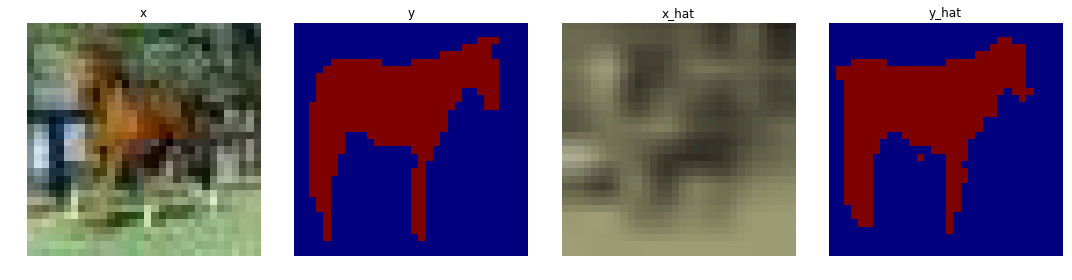

===> End of epoch 21 / 150 	 Time Taken: 3.33 sec

===> Start of epoch 22 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[22/150][0/50] in 0.052s X2X: 0.096, Y2Y: 19.597 


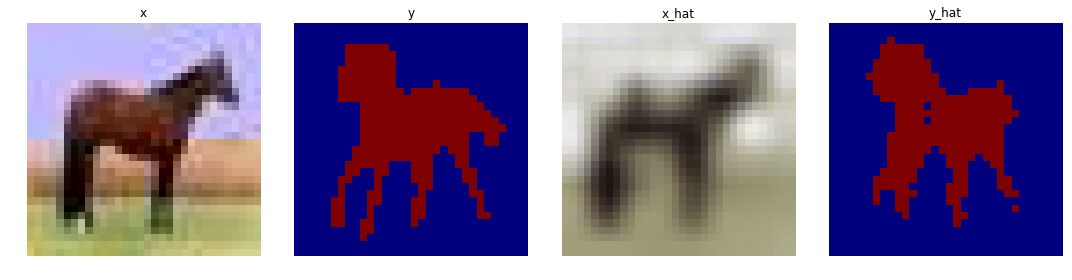

===> End of epoch 22 / 150 	 Time Taken: 3.32 sec

===> Start of epoch 23 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[23/150][0/50] in 0.052s X2X: 0.085, Y2Y: 19.240 


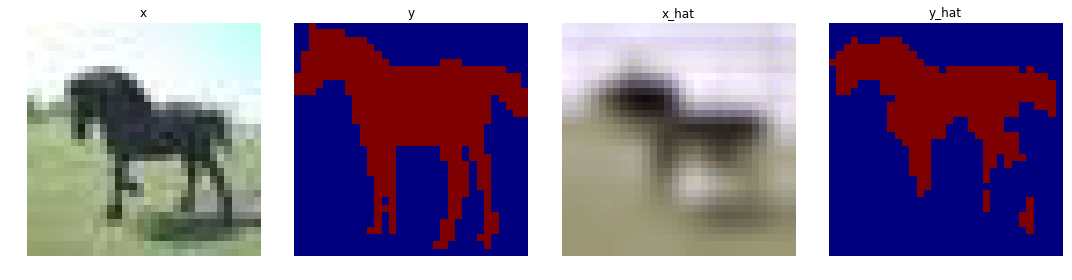

===> End of epoch 23 / 150 	 Time Taken: 3.28 sec

===> Start of epoch 24 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[24/150][0/50] in 0.059s X2X: 0.084, Y2Y: 17.851 


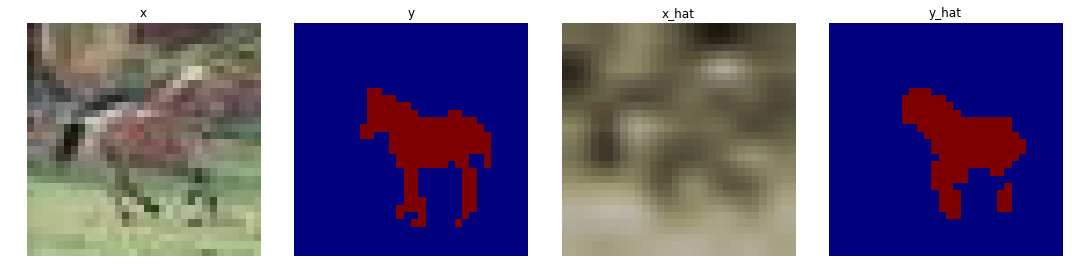

===> End of epoch 24 / 150 	 Time Taken: 3.24 sec

===> Start of epoch 25 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[25/150][0/50] in 0.053s X2X: 0.127, Y2Y: 17.997 


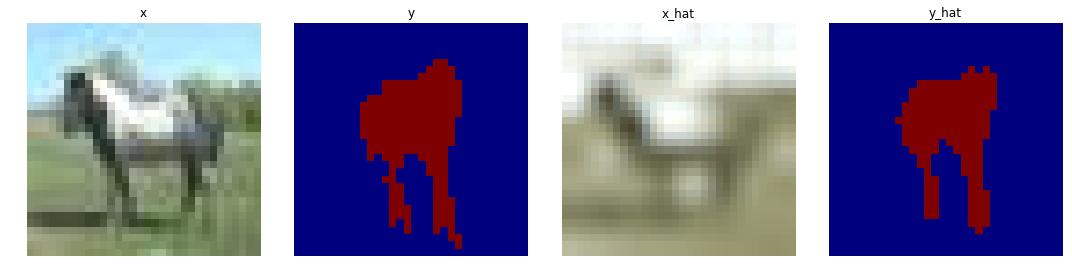

===> End of epoch 25 / 150 	 Time Taken: 3.31 sec

===> Start of epoch 26 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[26/150][0/50] in 0.051s X2X: 0.093, Y2Y: 17.607 


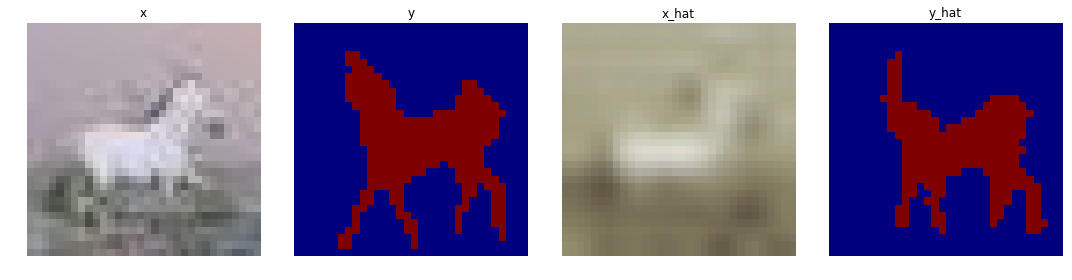

===> End of epoch 26 / 150 	 Time Taken: 3.33 sec

===> Start of epoch 27 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[27/150][0/50] in 0.052s X2X: 0.096, Y2Y: 18.250 


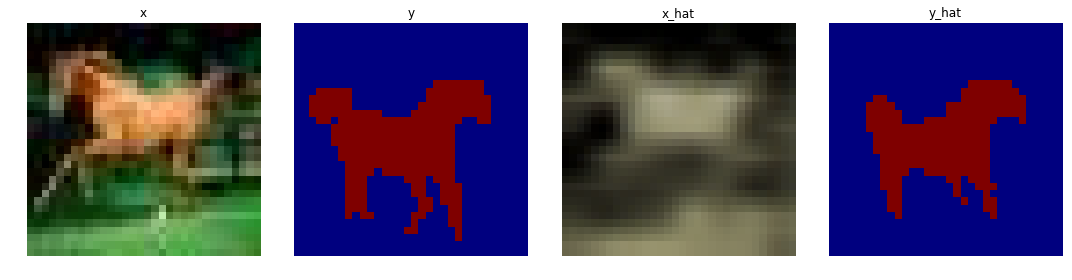

===> End of epoch 27 / 150 	 Time Taken: 3.27 sec

===> Start of epoch 28 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[28/150][0/50] in 0.055s X2X: 0.119, Y2Y: 16.636 


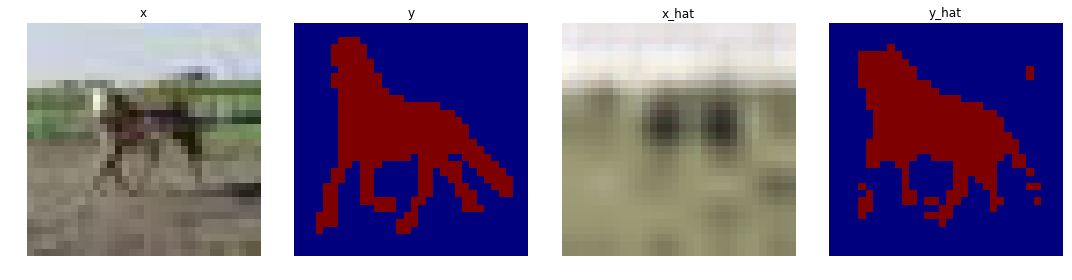

===> End of epoch 28 / 150 	 Time Taken: 3.30 sec

===> Start of epoch 29 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[29/150][0/50] in 0.051s X2X: 0.118, Y2Y: 16.320 


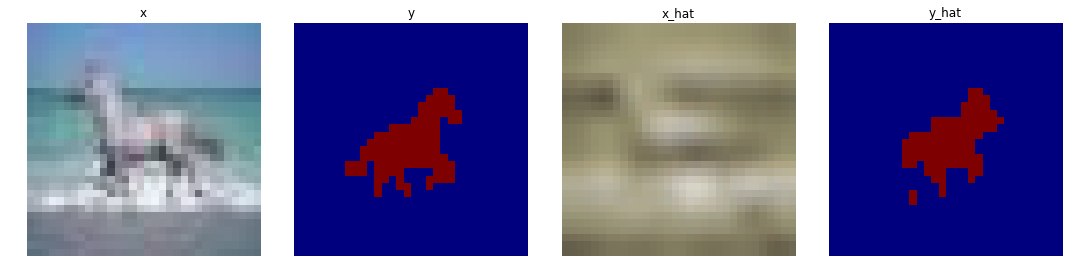

===> End of epoch 29 / 150 	 Time Taken: 3.22 sec

===> Start of epoch 30 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[30/150][0/50] in 0.058s X2X: 0.113, Y2Y: 15.909 


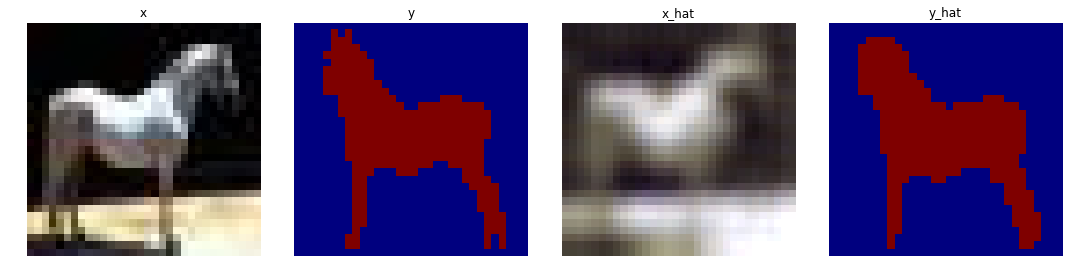

===> End of epoch 30 / 150 	 Time Taken: 3.29 sec

===> Start of epoch 31 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[31/150][0/50] in 0.058s X2X: 0.095, Y2Y: 15.859 


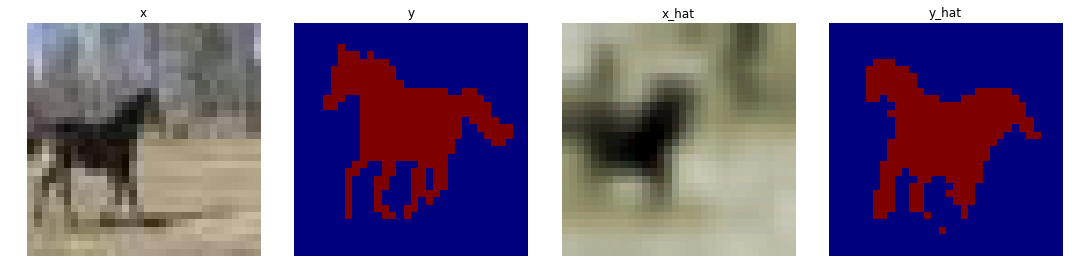

===> End of epoch 31 / 150 	 Time Taken: 3.68 sec

===> Start of epoch 32 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[32/150][0/50] in 0.053s X2X: 0.122, Y2Y: 15.802 


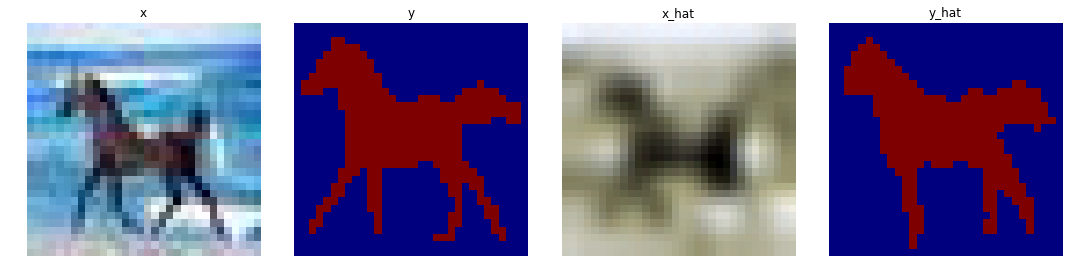

===> End of epoch 32 / 150 	 Time Taken: 3.44 sec

===> Start of epoch 33 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[33/150][0/50] in 0.052s X2X: 0.088, Y2Y: 14.815 


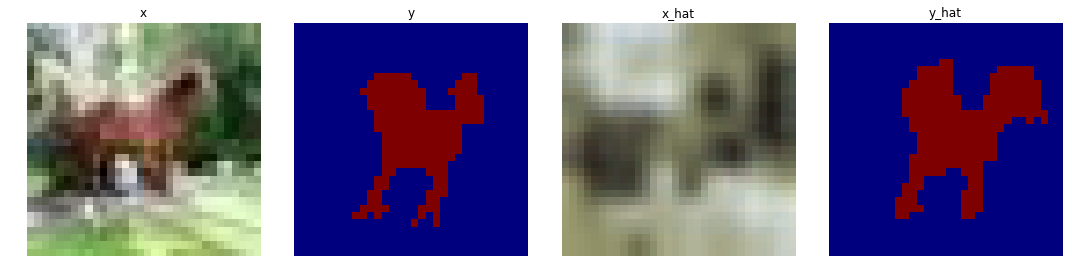

===> End of epoch 33 / 150 	 Time Taken: 3.24 sec

===> Start of epoch 34 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[34/150][0/50] in 0.065s X2X: 0.098, Y2Y: 15.532 


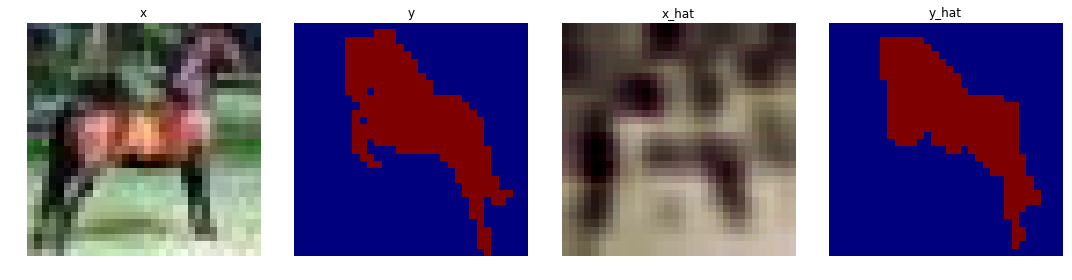

===> End of epoch 34 / 150 	 Time Taken: 3.34 sec

===> Start of epoch 35 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[35/150][0/50] in 0.053s X2X: 0.117, Y2Y: 15.003 


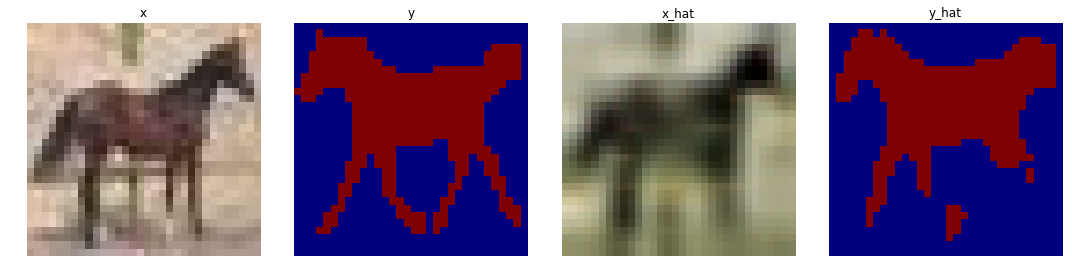

===> End of epoch 35 / 150 	 Time Taken: 3.27 sec

===> Start of epoch 36 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[36/150][0/50] in 0.057s X2X: 0.101, Y2Y: 15.045 


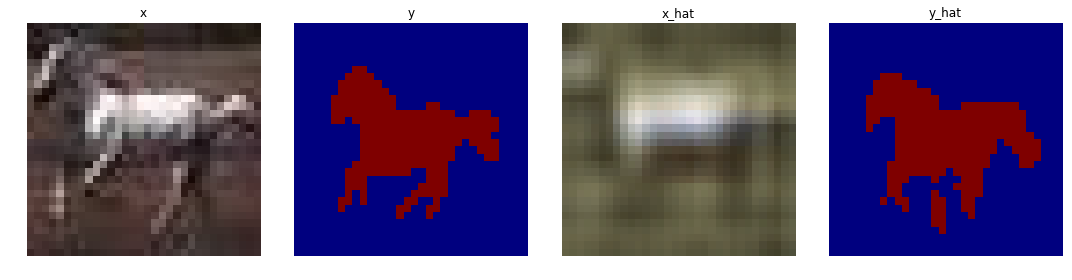

===> End of epoch 36 / 150 	 Time Taken: 3.28 sec

===> Start of epoch 37 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[37/150][0/50] in 0.061s X2X: 0.091, Y2Y: 14.189 


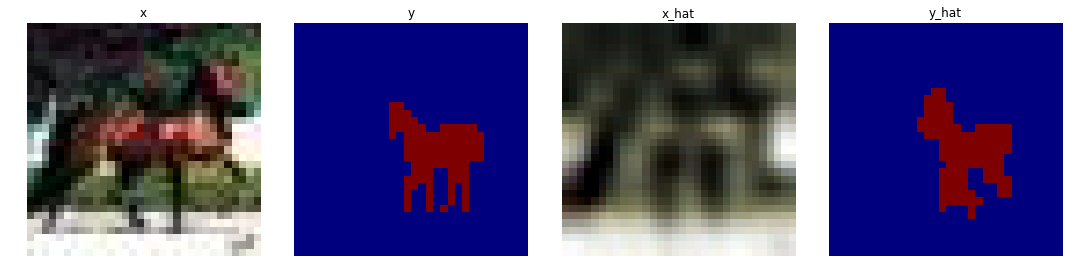

===> End of epoch 37 / 150 	 Time Taken: 3.43 sec

===> Start of epoch 38 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[38/150][0/50] in 0.069s X2X: 0.081, Y2Y: 13.657 


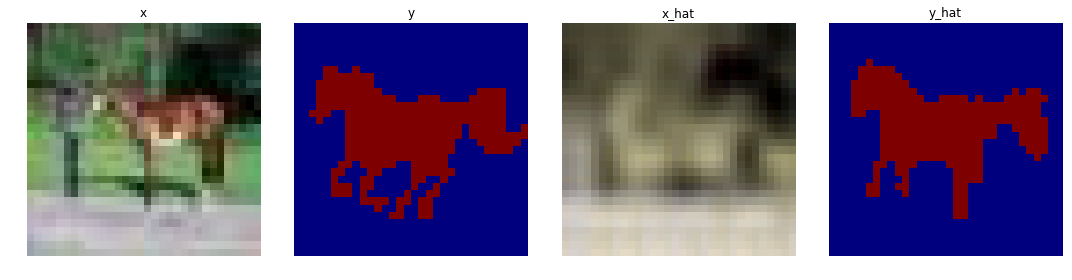

===> End of epoch 38 / 150 	 Time Taken: 3.39 sec

===> Start of epoch 39 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[39/150][0/50] in 0.058s X2X: 0.088, Y2Y: 13.583 


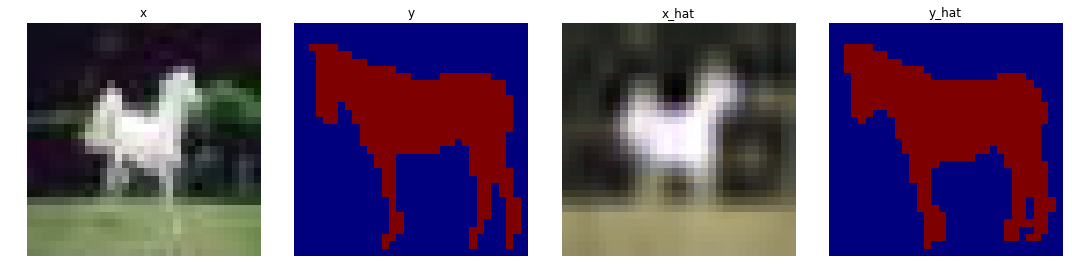

===> End of epoch 39 / 150 	 Time Taken: 3.27 sec

===> Start of epoch 40 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[40/150][0/50] in 0.052s X2X: 0.097, Y2Y: 13.947 


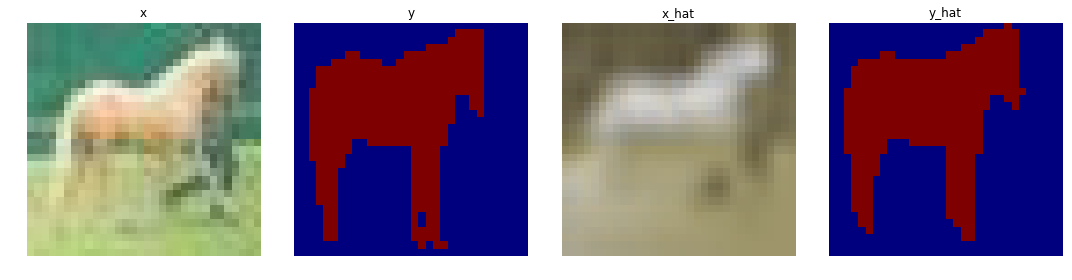

===> End of epoch 40 / 150 	 Time Taken: 3.29 sec

===> Start of epoch 41 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[41/150][0/50] in 0.051s X2X: 0.095, Y2Y: 13.560 


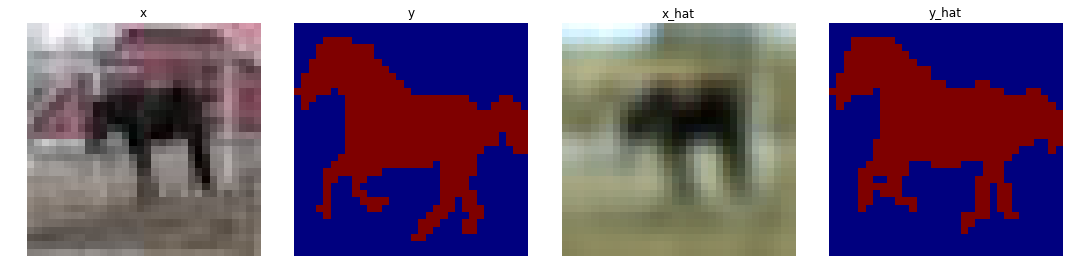

===> End of epoch 41 / 150 	 Time Taken: 3.25 sec

===> Start of epoch 42 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[42/150][0/50] in 0.055s X2X: 0.132, Y2Y: 13.107 


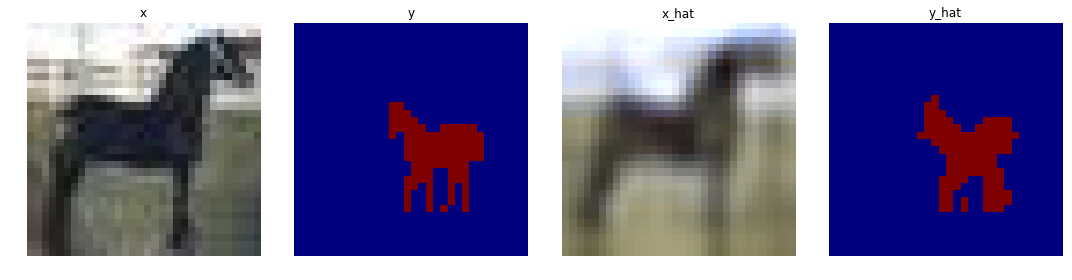

===> End of epoch 42 / 150 	 Time Taken: 3.58 sec

===> Start of epoch 43 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[43/150][0/50] in 0.056s X2X: 0.090, Y2Y: 12.977 


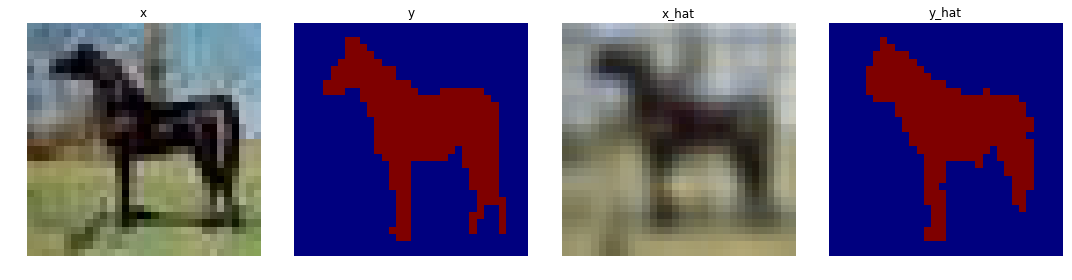

===> End of epoch 43 / 150 	 Time Taken: 3.39 sec

===> Start of epoch 44 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[44/150][0/50] in 0.053s X2X: 0.098, Y2Y: 13.157 


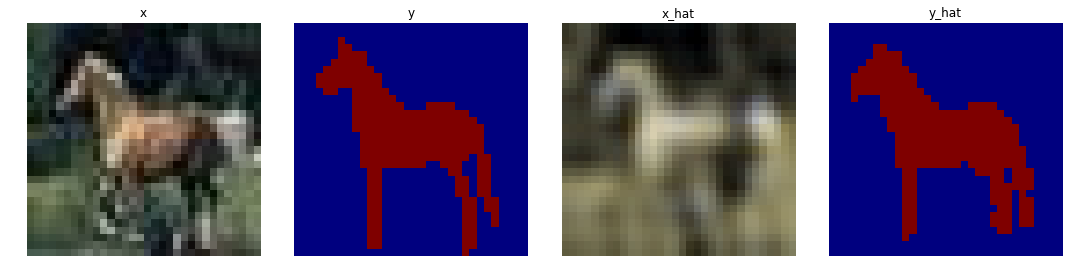

===> End of epoch 44 / 150 	 Time Taken: 3.30 sec

===> Start of epoch 45 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[45/150][0/50] in 0.051s X2X: 0.103, Y2Y: 12.928 


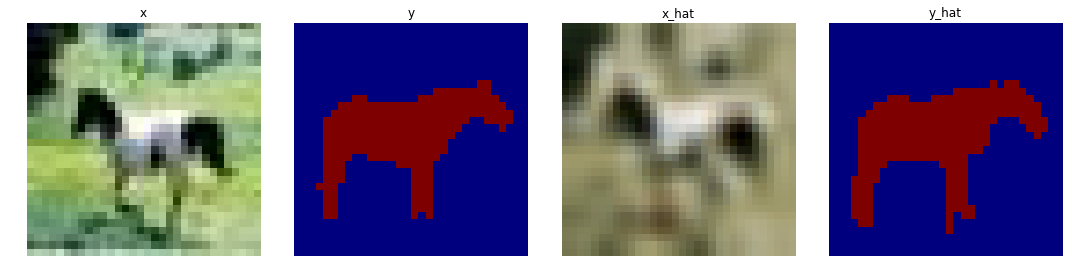

===> End of epoch 45 / 150 	 Time Taken: 3.28 sec

===> Start of epoch 46 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[46/150][0/50] in 0.054s X2X: 0.080, Y2Y: 12.956 


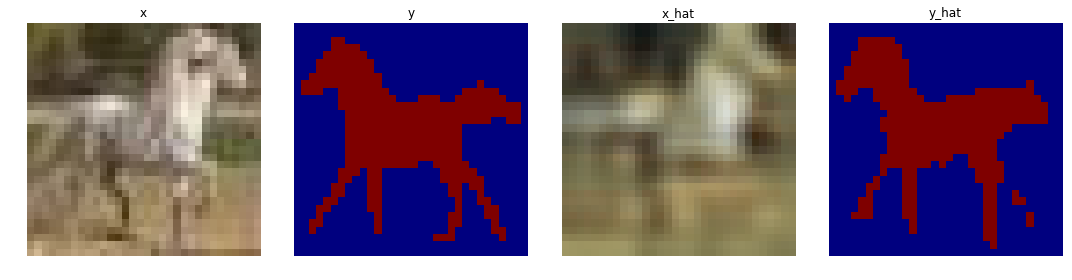

===> End of epoch 46 / 150 	 Time Taken: 3.28 sec

===> Start of epoch 47 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[47/150][0/50] in 0.055s X2X: 0.111, Y2Y: 13.509 


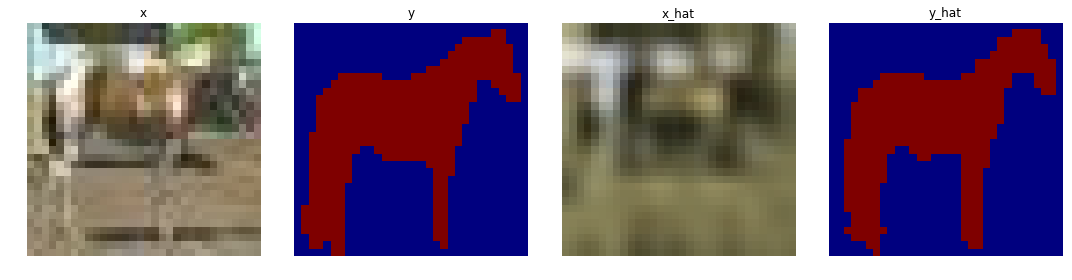

===> End of epoch 47 / 150 	 Time Taken: 3.29 sec

===> Start of epoch 48 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[48/150][0/50] in 0.059s X2X: 0.095, Y2Y: 12.270 


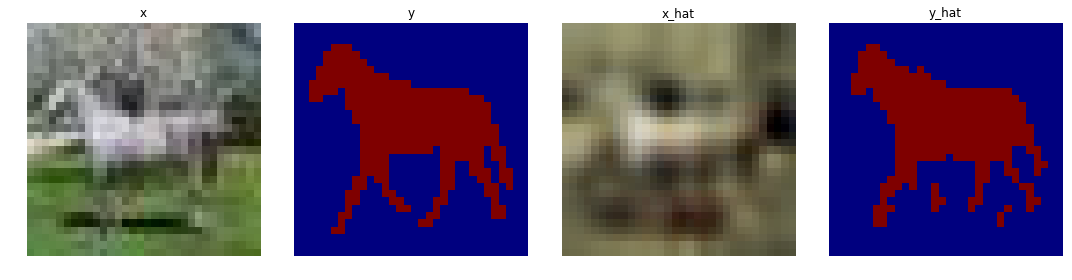

===> End of epoch 48 / 150 	 Time Taken: 3.37 sec

===> Start of epoch 49 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[49/150][0/50] in 0.056s X2X: 0.107, Y2Y: 12.747 


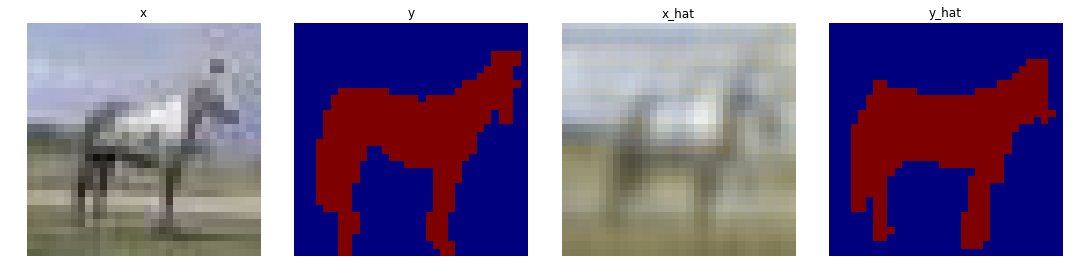

===> End of epoch 49 / 150 	 Time Taken: 3.26 sec

===> Start of epoch 50 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[50/150][0/50] in 0.053s X2X: 0.095, Y2Y: 11.698 


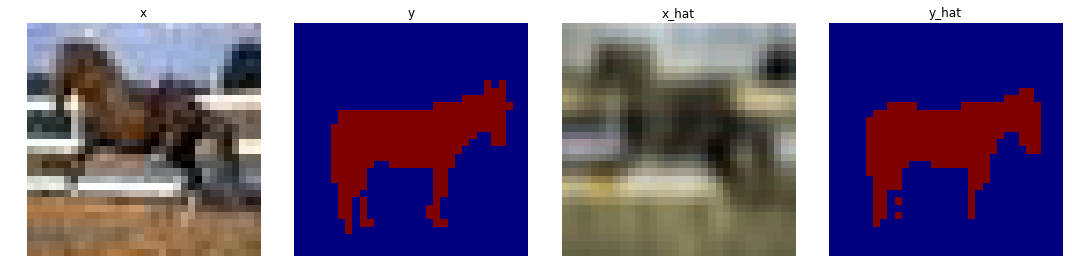

===> End of epoch 50 / 150 	 Time Taken: 3.21 sec

===> Start of epoch 51 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[51/150][0/50] in 0.052s X2X: 0.079, Y2Y: 12.309 


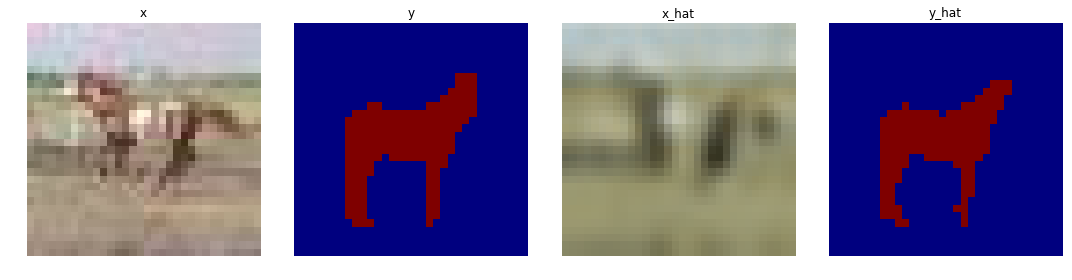

===> End of epoch 51 / 150 	 Time Taken: 3.28 sec

===> Start of epoch 52 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[52/150][0/50] in 0.052s X2X: 0.082, Y2Y: 12.371 


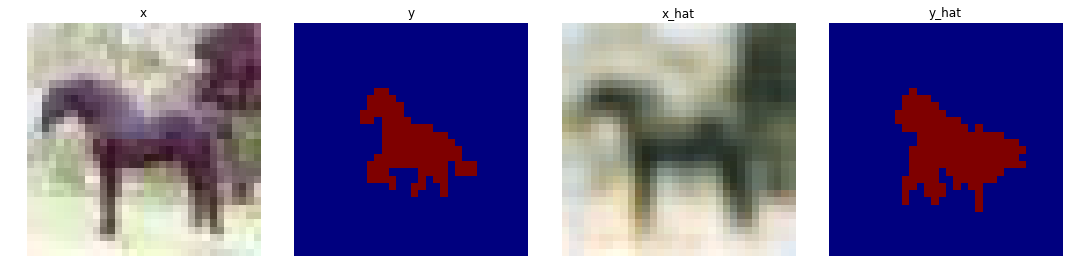

===> End of epoch 52 / 150 	 Time Taken: 3.24 sec

===> Start of epoch 53 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[53/150][0/50] in 0.052s X2X: 0.110, Y2Y: 11.449 


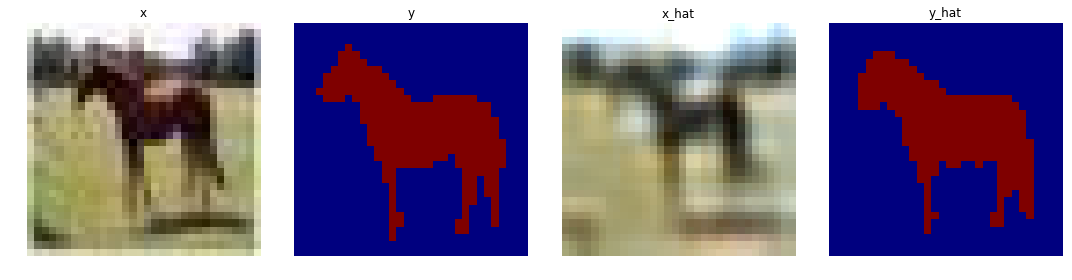

===> End of epoch 53 / 150 	 Time Taken: 3.61 sec

===> Start of epoch 54 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[54/150][0/50] in 0.052s X2X: 0.067, Y2Y: 11.802 


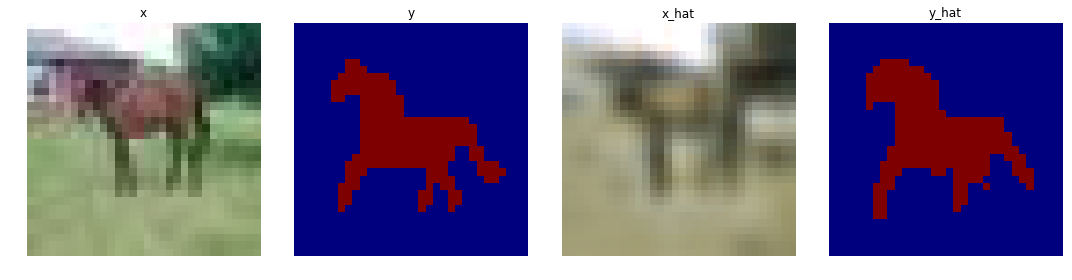

===> End of epoch 54 / 150 	 Time Taken: 3.33 sec

===> Start of epoch 55 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[55/150][0/50] in 0.058s X2X: 0.072, Y2Y: 11.533 


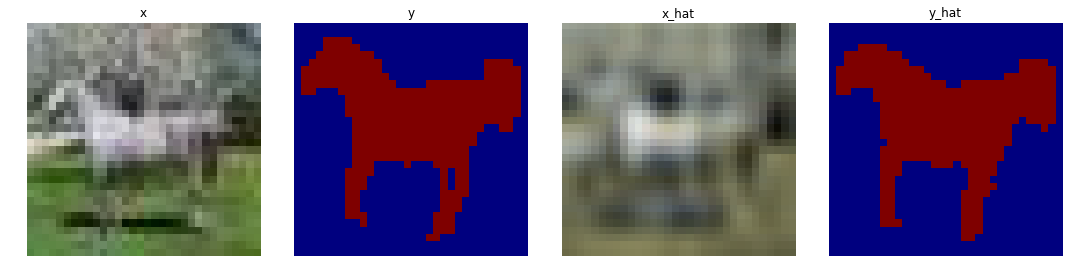

===> End of epoch 55 / 150 	 Time Taken: 3.27 sec

===> Start of epoch 56 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[56/150][0/50] in 0.051s X2X: 0.097, Y2Y: 11.098 


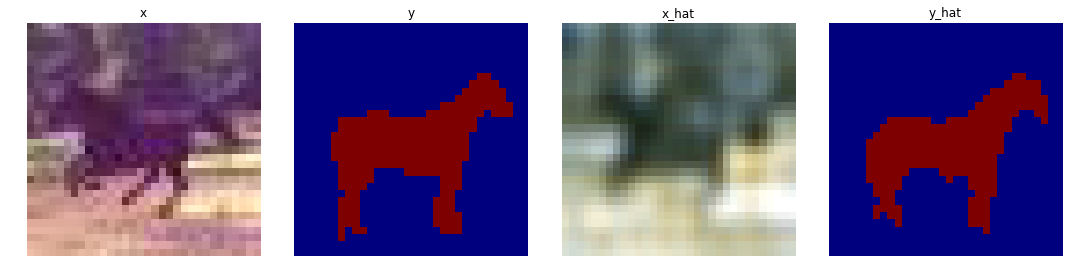

===> End of epoch 56 / 150 	 Time Taken: 3.24 sec

===> Start of epoch 57 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[57/150][0/50] in 0.052s X2X: 0.140, Y2Y: 10.970 


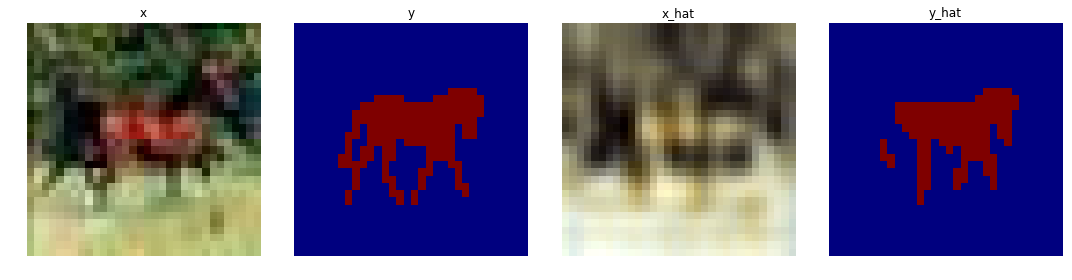

===> End of epoch 57 / 150 	 Time Taken: 3.26 sec

===> Start of epoch 58 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[58/150][0/50] in 0.057s X2X: 0.069, Y2Y: 11.123 


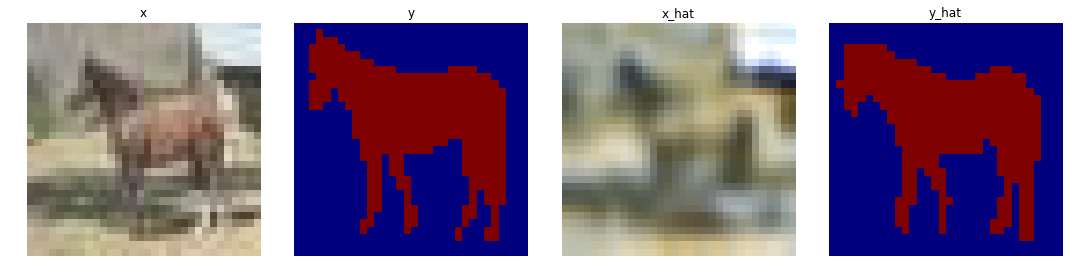

===> End of epoch 58 / 150 	 Time Taken: 3.25 sec

===> Start of epoch 59 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[59/150][0/50] in 0.056s X2X: 0.126, Y2Y: 11.337 


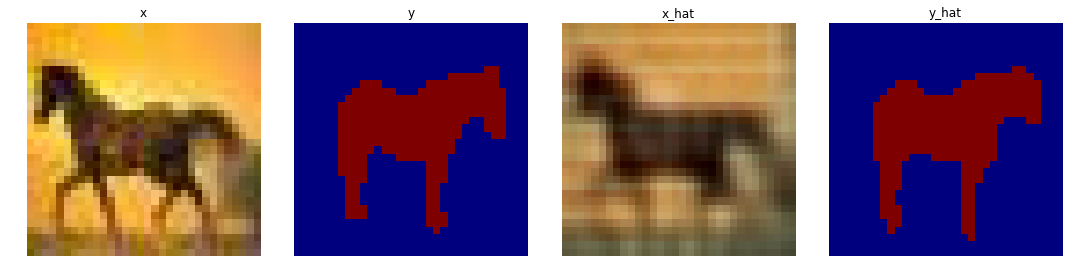

===> End of epoch 59 / 150 	 Time Taken: 3.35 sec

===> Start of epoch 60 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[60/150][0/50] in 0.051s X2X: 0.086, Y2Y: 10.905 


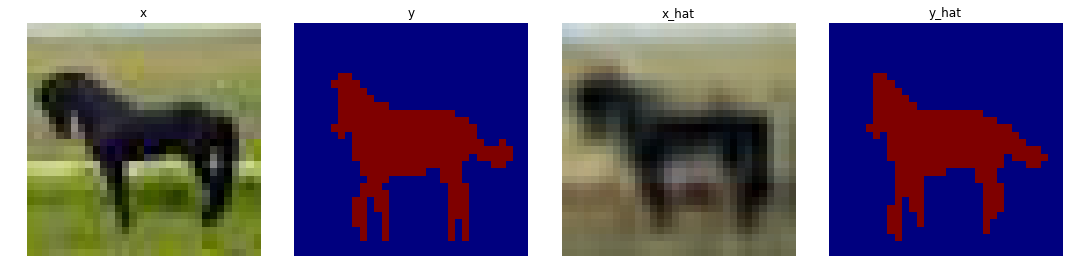

===> End of epoch 60 / 150 	 Time Taken: 3.25 sec

===> Start of epoch 61 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[61/150][0/50] in 0.052s X2X: 0.093, Y2Y: 10.841 


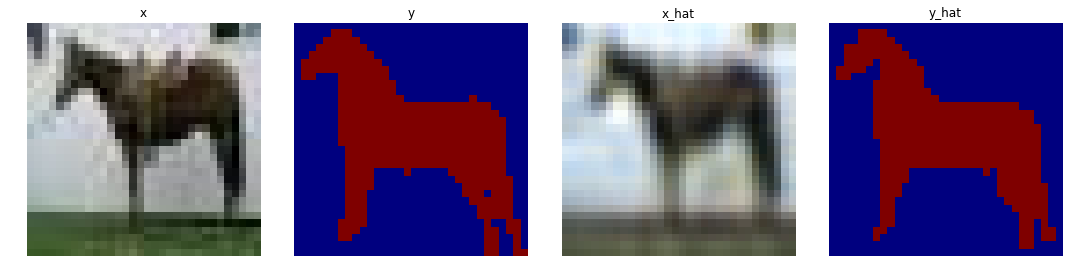

===> End of epoch 61 / 150 	 Time Taken: 3.23 sec

===> Start of epoch 62 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[62/150][0/50] in 0.054s X2X: 0.105, Y2Y: 10.864 


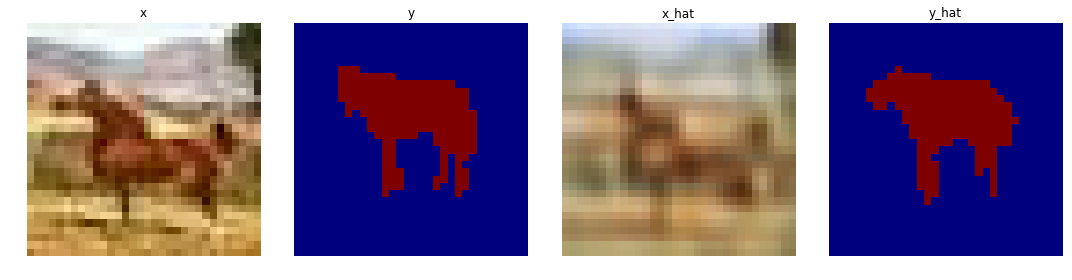

===> End of epoch 62 / 150 	 Time Taken: 3.28 sec

===> Start of epoch 63 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[63/150][0/50] in 0.052s X2X: 0.084, Y2Y: 10.782 


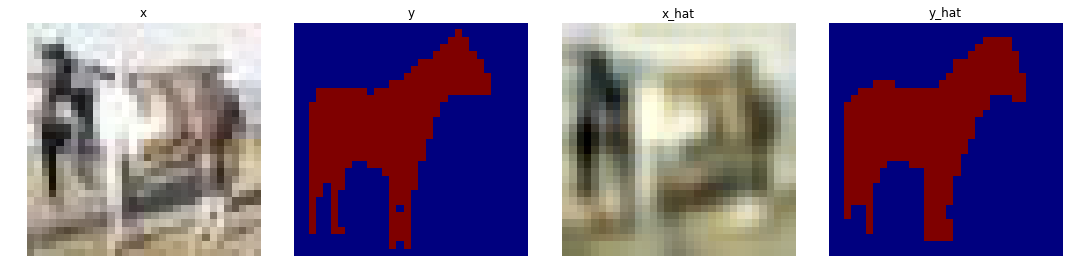

===> End of epoch 63 / 150 	 Time Taken: 3.31 sec

===> Start of epoch 64 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[64/150][0/50] in 0.054s X2X: 0.085, Y2Y: 10.481 


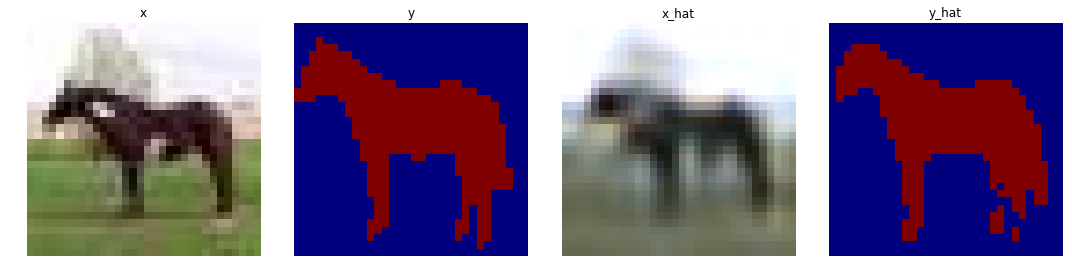

===> End of epoch 64 / 150 	 Time Taken: 3.57 sec

===> Start of epoch 65 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[65/150][0/50] in 0.062s X2X: 0.101, Y2Y: 10.547 


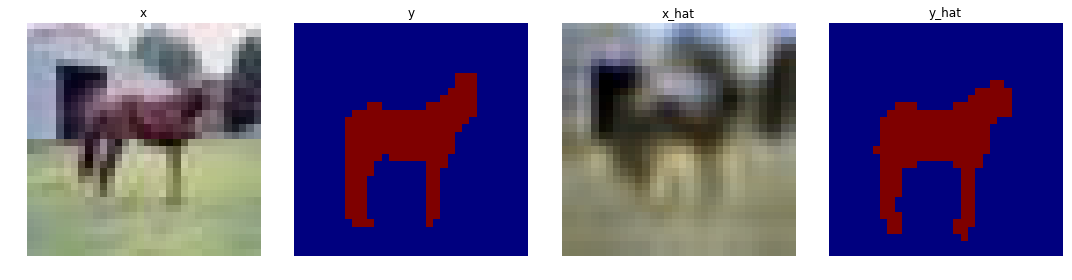

===> End of epoch 65 / 150 	 Time Taken: 3.35 sec

===> Start of epoch 66 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[66/150][0/50] in 0.063s X2X: 0.074, Y2Y: 10.190 


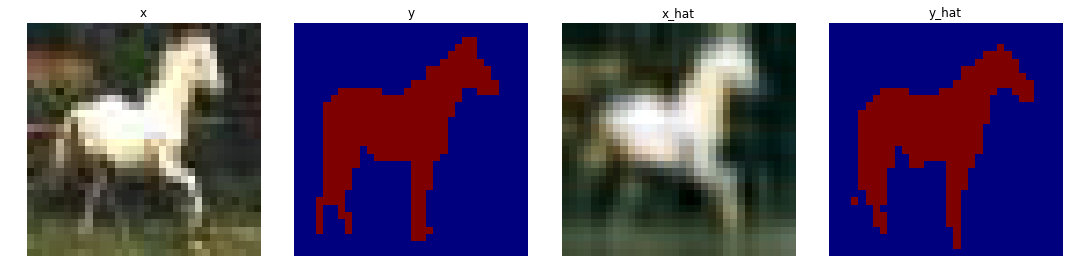

===> End of epoch 66 / 150 	 Time Taken: 3.33 sec

===> Start of epoch 67 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[67/150][0/50] in 0.052s X2X: 0.072, Y2Y: 10.228 


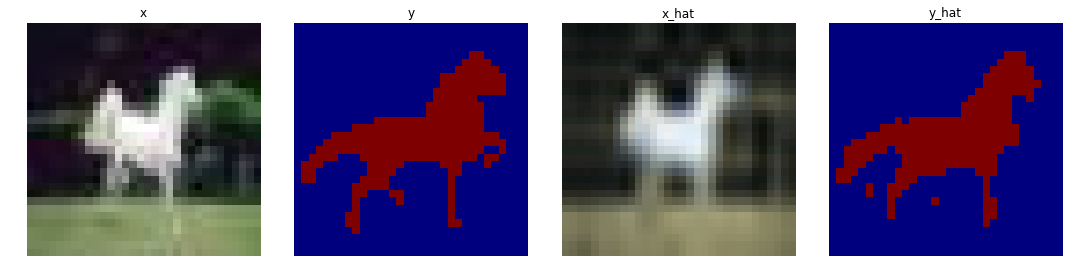

===> End of epoch 67 / 150 	 Time Taken: 3.31 sec

===> Start of epoch 68 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[68/150][0/50] in 0.053s X2X: 0.128, Y2Y: 10.255 


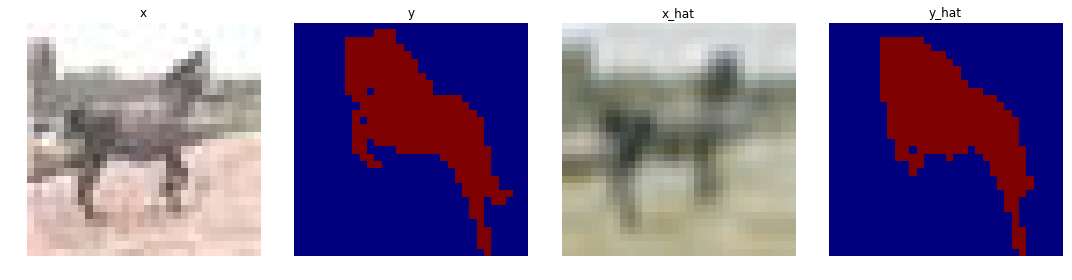

===> End of epoch 68 / 150 	 Time Taken: 3.28 sec

===> Start of epoch 69 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[69/150][0/50] in 0.052s X2X: 0.124, Y2Y: 9.850 


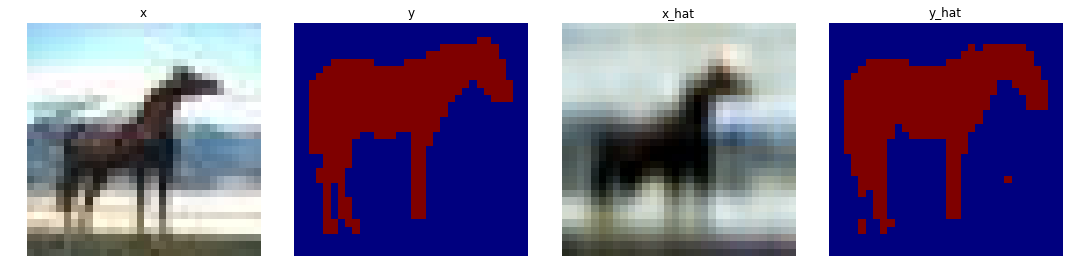

===> End of epoch 69 / 150 	 Time Taken: 3.21 sec

===> Start of epoch 70 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[70/150][0/50] in 0.052s X2X: 0.079, Y2Y: 9.877 


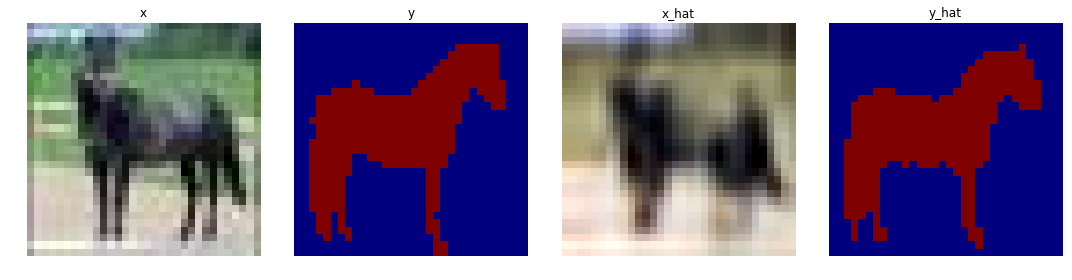

===> End of epoch 70 / 150 	 Time Taken: 3.33 sec

===> Start of epoch 71 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[71/150][0/50] in 0.052s X2X: 0.110, Y2Y: 9.615 


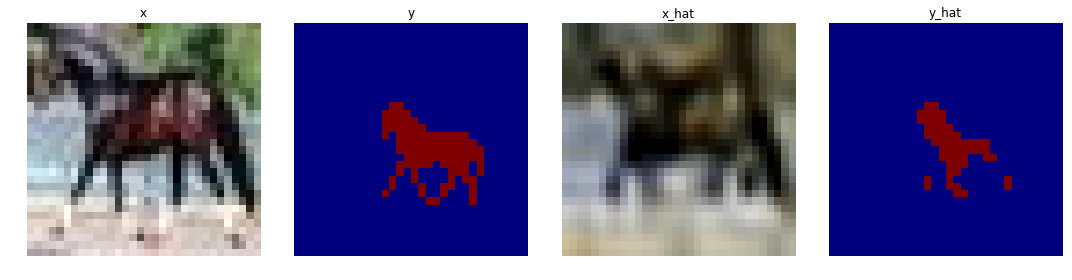

===> End of epoch 71 / 150 	 Time Taken: 3.28 sec

===> Start of epoch 72 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[72/150][0/50] in 0.052s X2X: 0.070, Y2Y: 9.729 


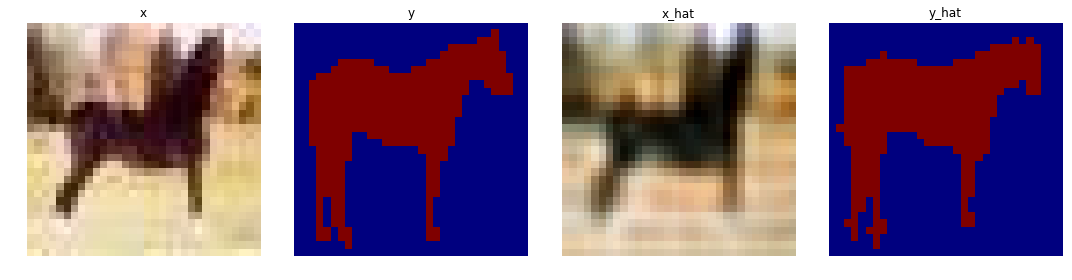

===> End of epoch 72 / 150 	 Time Taken: 3.28 sec

===> Start of epoch 73 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[73/150][0/50] in 0.052s X2X: 0.084, Y2Y: 9.482 


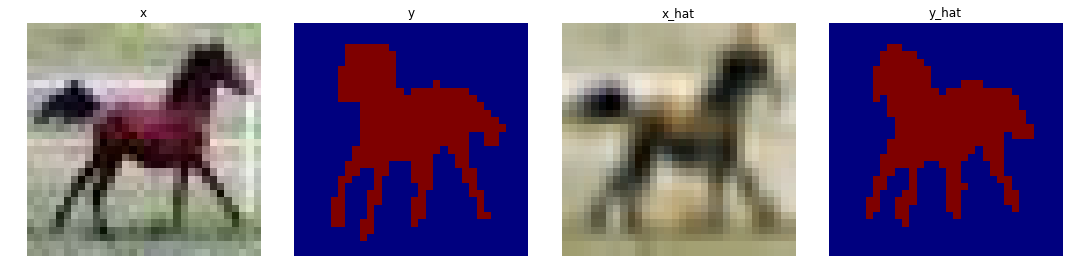

===> End of epoch 73 / 150 	 Time Taken: 3.25 sec

===> Start of epoch 74 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[74/150][0/50] in 0.052s X2X: 0.073, Y2Y: 9.393 


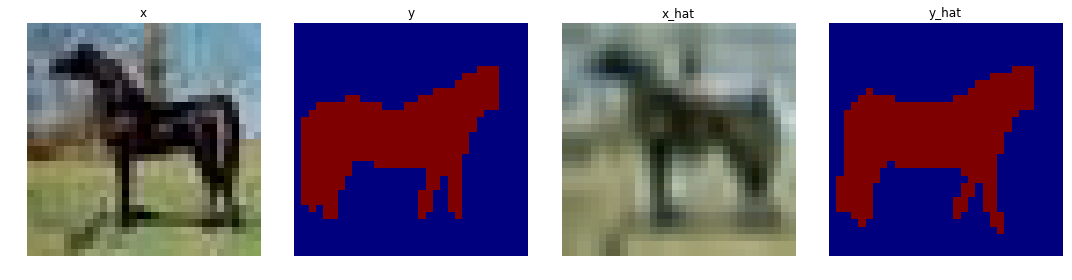

===> End of epoch 74 / 150 	 Time Taken: 3.25 sec

===> Start of epoch 75 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[75/150][0/50] in 0.052s X2X: 0.073, Y2Y: 9.355 


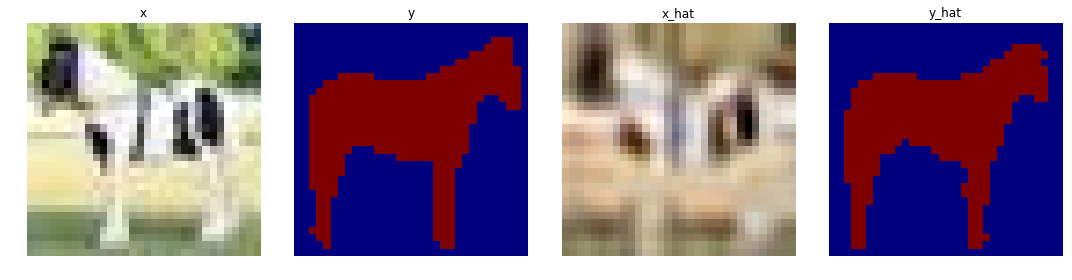

===> End of epoch 75 / 150 	 Time Taken: 3.52 sec

===> Start of epoch 76 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[76/150][0/50] in 0.052s X2X: 0.109, Y2Y: 9.349 


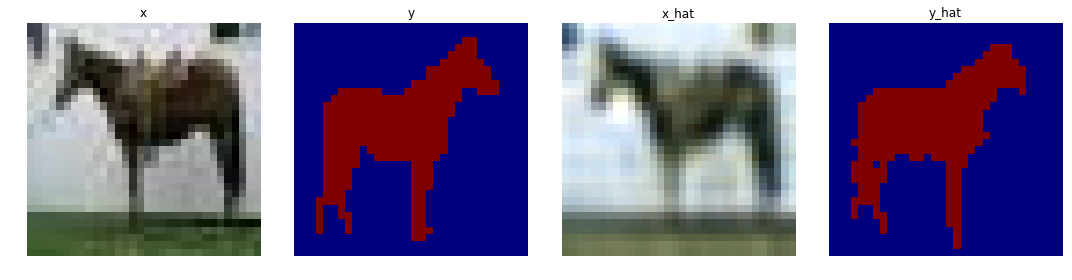

===> End of epoch 76 / 150 	 Time Taken: 3.23 sec

===> Start of epoch 77 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[77/150][0/50] in 0.052s X2X: 0.072, Y2Y: 9.206 


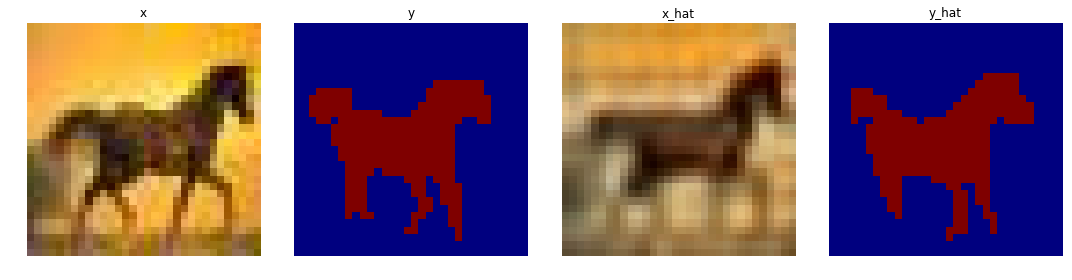

===> End of epoch 77 / 150 	 Time Taken: 3.24 sec

===> Start of epoch 78 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[78/150][0/50] in 0.056s X2X: 0.088, Y2Y: 9.266 


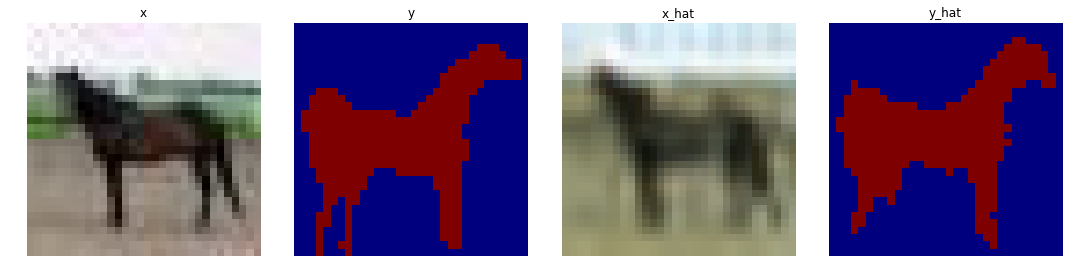

===> End of epoch 78 / 150 	 Time Taken: 3.26 sec

===> Start of epoch 79 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[79/150][0/50] in 0.052s X2X: 0.072, Y2Y: 9.086 


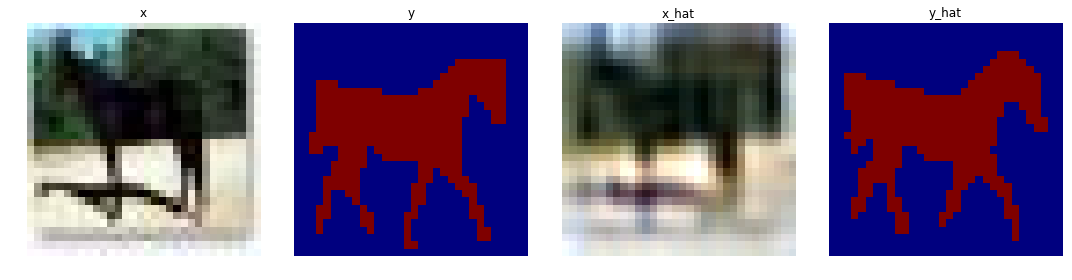

===> End of epoch 79 / 150 	 Time Taken: 3.31 sec

===> Start of epoch 80 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[80/150][0/50] in 0.060s X2X: 0.117, Y2Y: 9.050 


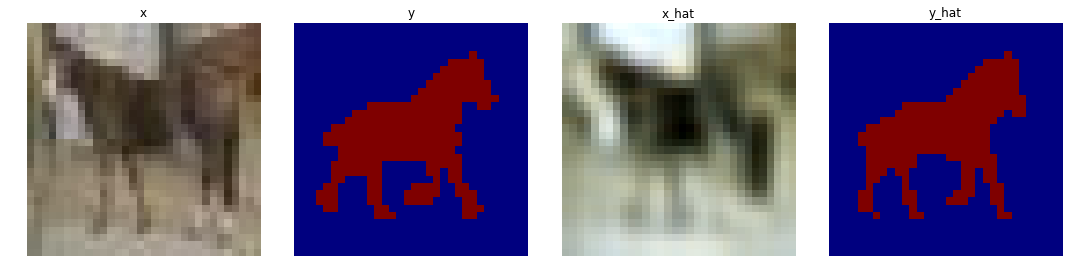

===> End of epoch 80 / 150 	 Time Taken: 3.30 sec

===> Start of epoch 81 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[81/150][0/50] in 0.054s X2X: 0.095, Y2Y: 8.895 


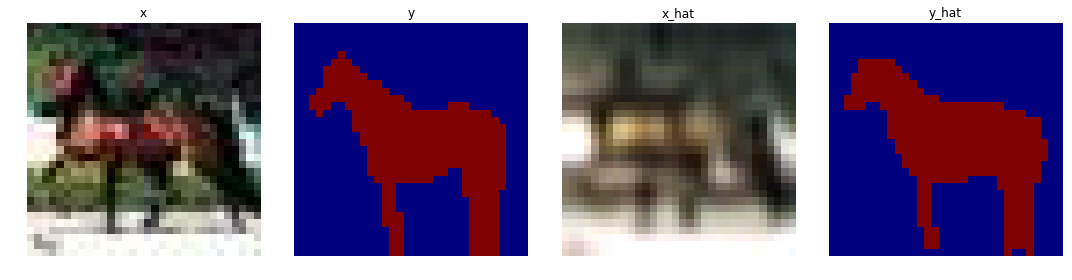

===> End of epoch 81 / 150 	 Time Taken: 3.31 sec

===> Start of epoch 82 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[82/150][0/50] in 0.053s X2X: 0.084, Y2Y: 8.673 


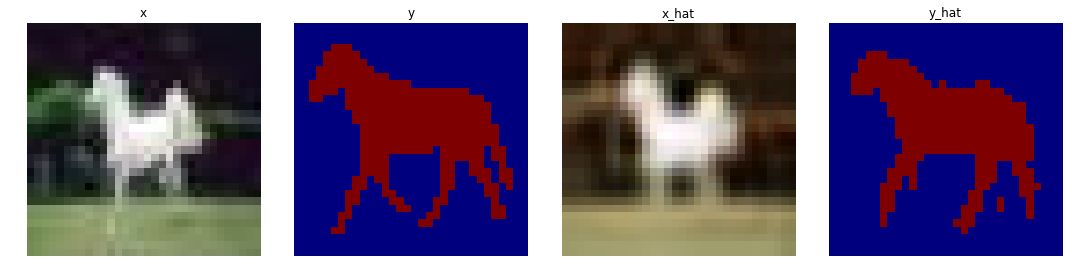

===> End of epoch 82 / 150 	 Time Taken: 3.23 sec

===> Start of epoch 83 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[83/150][0/50] in 0.058s X2X: 0.075, Y2Y: 8.605 


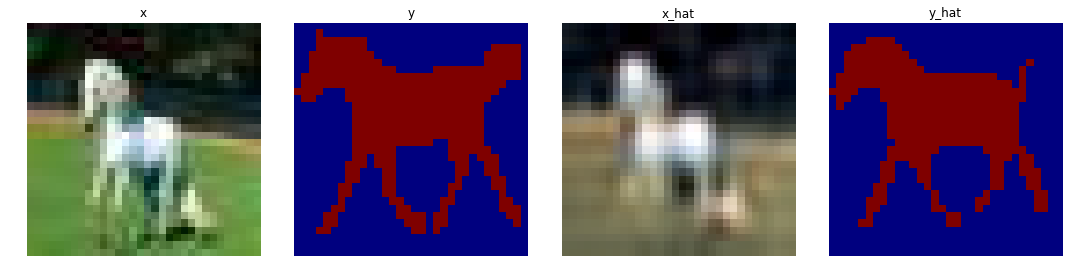

===> End of epoch 83 / 150 	 Time Taken: 3.27 sec

===> Start of epoch 84 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[84/150][0/50] in 0.055s X2X: 0.076, Y2Y: 8.190 


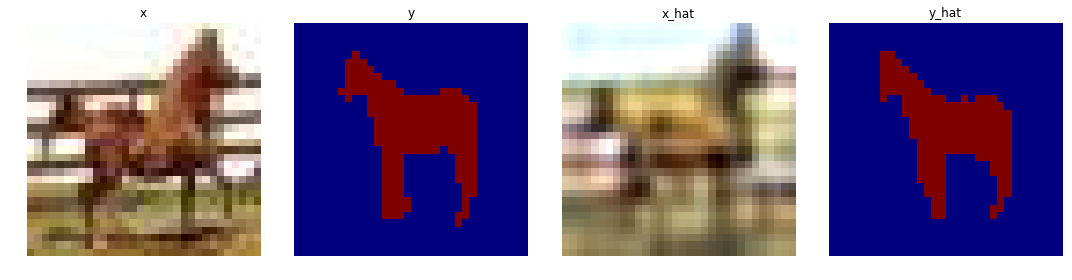

===> End of epoch 84 / 150 	 Time Taken: 3.25 sec

===> Start of epoch 85 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[85/150][0/50] in 0.055s X2X: 0.087, Y2Y: 8.457 


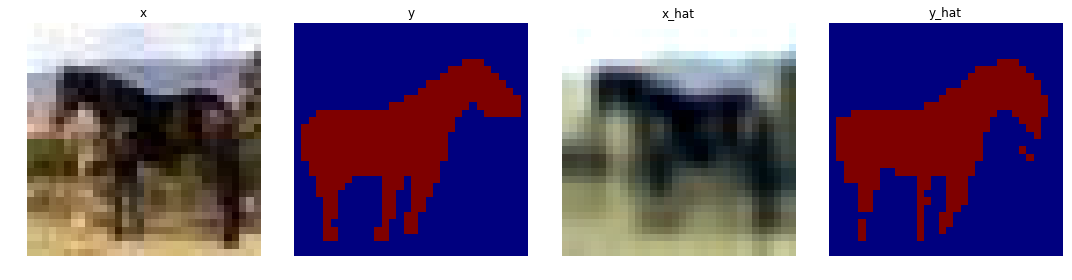

===> End of epoch 85 / 150 	 Time Taken: 3.27 sec

===> Start of epoch 86 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[86/150][0/50] in 0.051s X2X: 0.072, Y2Y: 8.070 


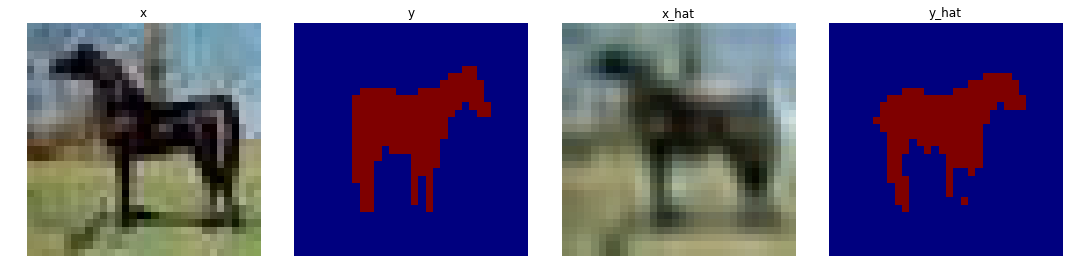

===> End of epoch 86 / 150 	 Time Taken: 3.56 sec

===> Start of epoch 87 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[87/150][0/50] in 0.056s X2X: 0.074, Y2Y: 8.506 


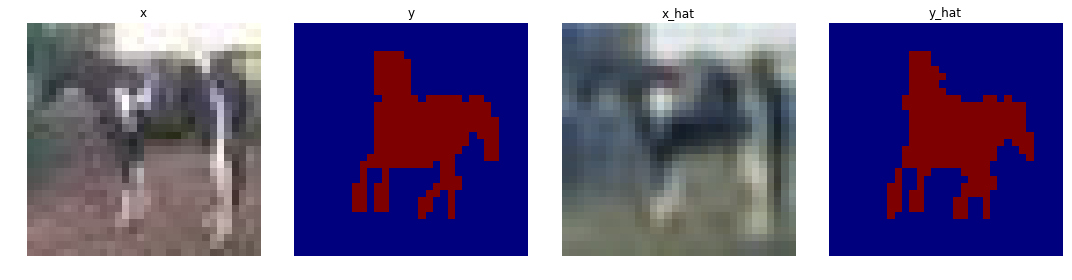

===> End of epoch 87 / 150 	 Time Taken: 3.31 sec

===> Start of epoch 88 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[88/150][0/50] in 0.051s X2X: 0.071, Y2Y: 7.940 


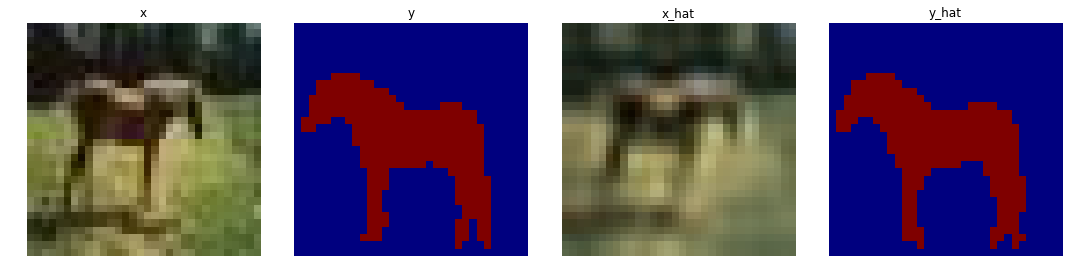

===> End of epoch 88 / 150 	 Time Taken: 3.21 sec

===> Start of epoch 89 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[89/150][0/50] in 0.053s X2X: 0.082, Y2Y: 8.363 


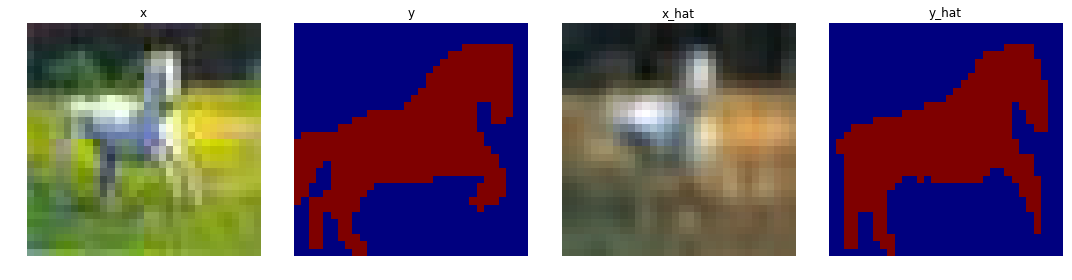

===> End of epoch 89 / 150 	 Time Taken: 3.24 sec

===> Start of epoch 90 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[90/150][0/50] in 0.052s X2X: 0.074, Y2Y: 8.181 


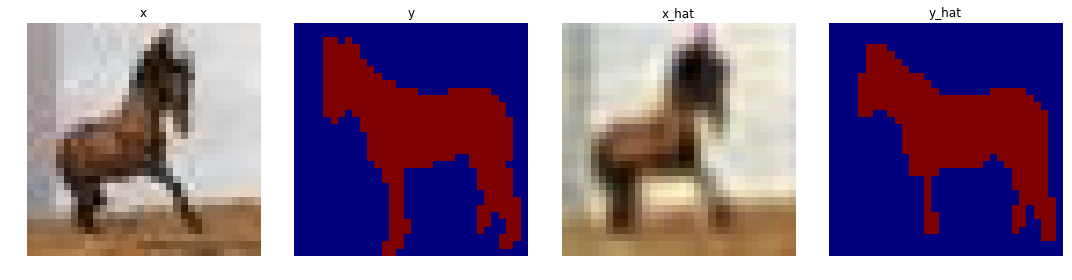

===> End of epoch 90 / 150 	 Time Taken: 3.26 sec

===> Start of epoch 91 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[91/150][0/50] in 0.050s X2X: 0.080, Y2Y: 7.575 


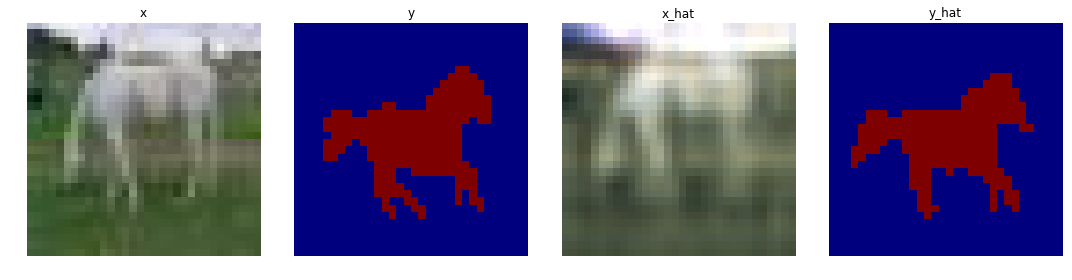

===> End of epoch 91 / 150 	 Time Taken: 3.23 sec

===> Start of epoch 92 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[92/150][0/50] in 0.052s X2X: 0.082, Y2Y: 7.593 


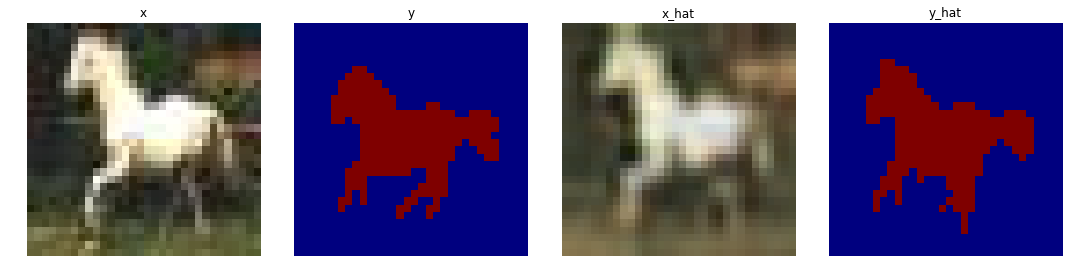

===> End of epoch 92 / 150 	 Time Taken: 3.33 sec

===> Start of epoch 93 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[93/150][0/50] in 0.057s X2X: 0.078, Y2Y: 7.908 


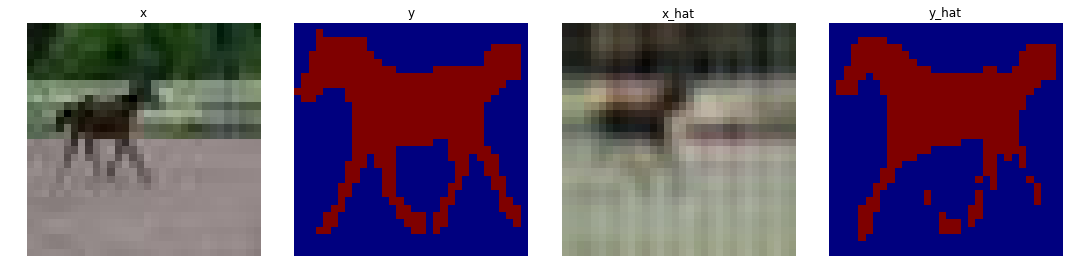

===> End of epoch 93 / 150 	 Time Taken: 3.25 sec

===> Start of epoch 94 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[94/150][0/50] in 0.052s X2X: 0.061, Y2Y: 7.763 


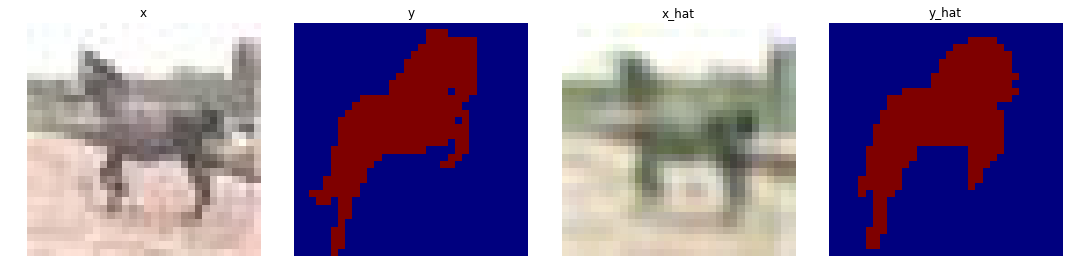

===> End of epoch 94 / 150 	 Time Taken: 3.30 sec

===> Start of epoch 95 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[95/150][0/50] in 0.052s X2X: 0.073, Y2Y: 7.175 


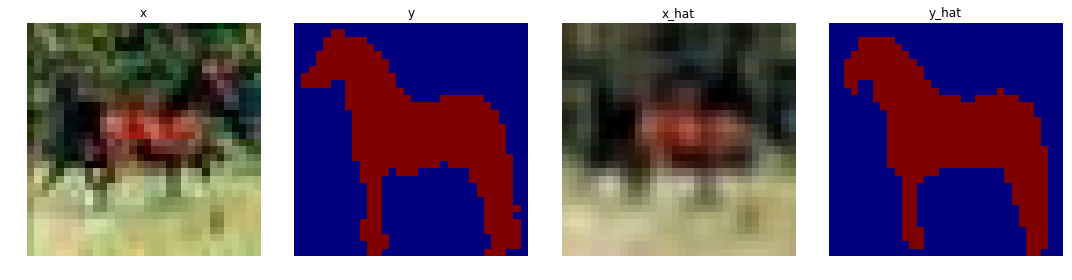

===> End of epoch 95 / 150 	 Time Taken: 3.20 sec

===> Start of epoch 96 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[96/150][0/50] in 0.052s X2X: 0.070, Y2Y: 6.975 


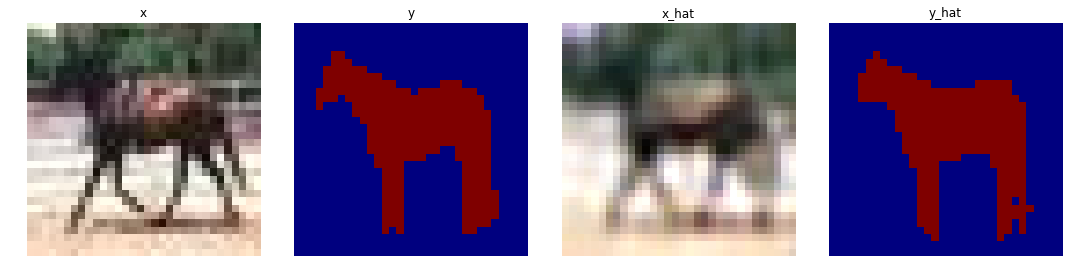

===> End of epoch 96 / 150 	 Time Taken: 3.27 sec

===> Start of epoch 97 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[97/150][0/50] in 0.053s X2X: 0.073, Y2Y: 6.970 


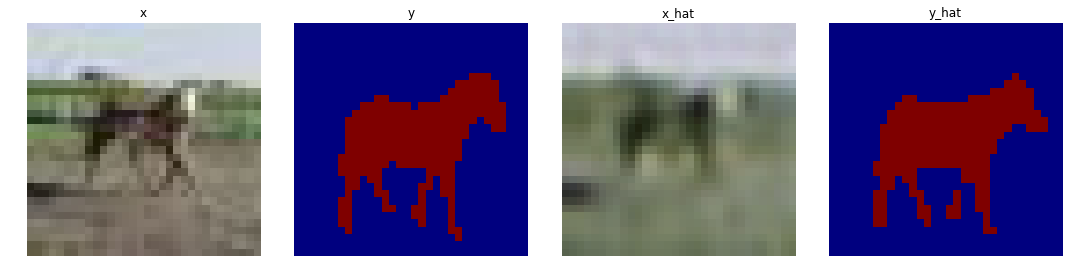

===> End of epoch 97 / 150 	 Time Taken: 3.49 sec

===> Start of epoch 98 / 200
X2Z: learning rate = 0.0100000
Z2X: learning rate = 0.0100000
Y2Z: learning rate = 0.0001000
Z2Y: learning rate = 0.0001000
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[98/150][0/50] in 0.051s X2X: 0.084, Y2Y: 7.222 


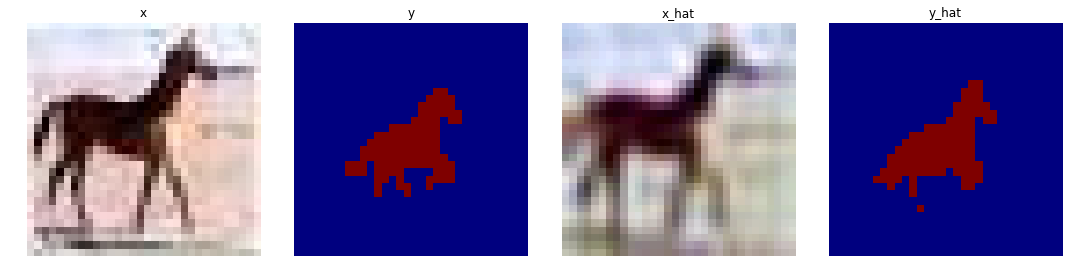

===> End of epoch 98 / 150 	 Time Taken: 3.32 sec

===> Start of epoch 99 / 200
X2Z: learning rate = 0.0099010
Z2X: learning rate = 0.0099010
Y2Z: learning rate = 0.0000990
Z2Y: learning rate = 0.0000990
D: learning rate = 0.0000990
T: learning rate = 0.0000990
[99/150][0/50] in 0.051s X2X: 0.068, Y2Y: 6.741 


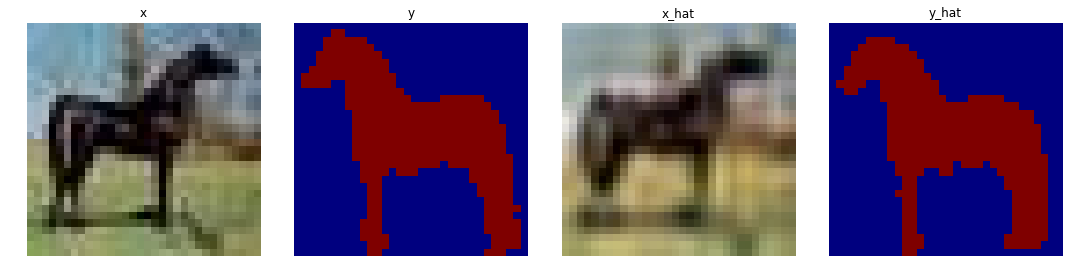

===> End of epoch 99 / 150 	 Time Taken: 3.25 sec

===> Start of epoch 100 / 200
X2Z: learning rate = 0.0098020
Z2X: learning rate = 0.0098020
Y2Z: learning rate = 0.0000980
Z2Y: learning rate = 0.0000980
D: learning rate = 0.0000980
T: learning rate = 0.0000980
[100/150][0/50] in 0.053s X2X: 0.073, Y2Y: 6.788 


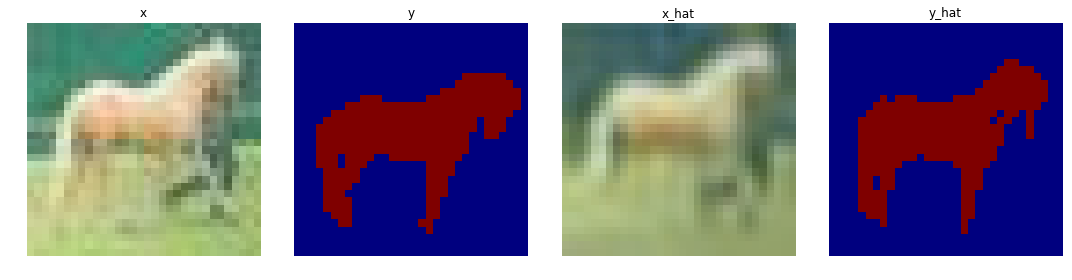

===> End of epoch 100 / 150 	 Time Taken: 3.25 sec

===> Start of epoch 101 / 200
X2Z: learning rate = 0.0097030
Z2X: learning rate = 0.0097030
Y2Z: learning rate = 0.0000970
Z2Y: learning rate = 0.0000970
D: learning rate = 0.0000970
T: learning rate = 0.0000970
[101/150][0/50] in 0.053s X2X: 0.072, Y2Y: 7.322 


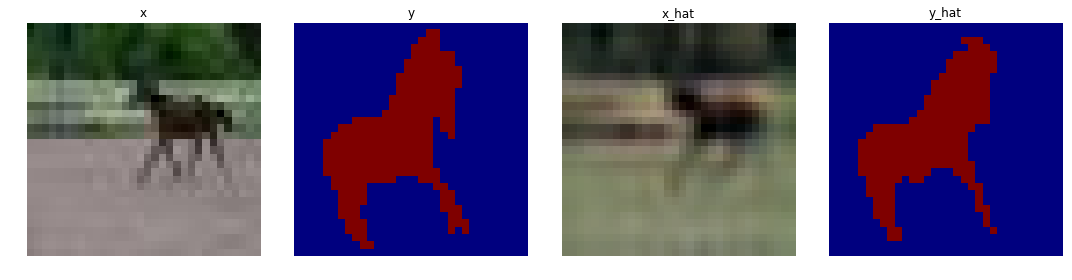

===> End of epoch 101 / 150 	 Time Taken: 3.28 sec

===> Start of epoch 102 / 200
X2Z: learning rate = 0.0096040
Z2X: learning rate = 0.0096040
Y2Z: learning rate = 0.0000960
Z2Y: learning rate = 0.0000960
D: learning rate = 0.0000960
T: learning rate = 0.0000960
[102/150][0/50] in 0.053s X2X: 0.073, Y2Y: 6.599 


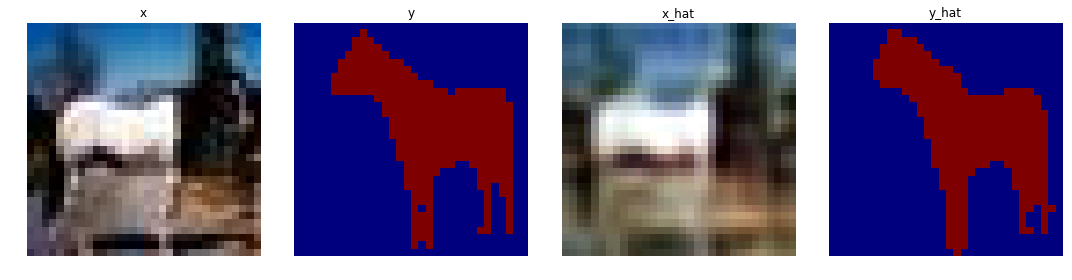

===> End of epoch 102 / 150 	 Time Taken: 3.47 sec

===> Start of epoch 103 / 200
X2Z: learning rate = 0.0095050
Z2X: learning rate = 0.0095050
Y2Z: learning rate = 0.0000950
Z2Y: learning rate = 0.0000950
D: learning rate = 0.0000950
T: learning rate = 0.0000950
[103/150][0/50] in 0.073s X2X: 0.065, Y2Y: 6.495 


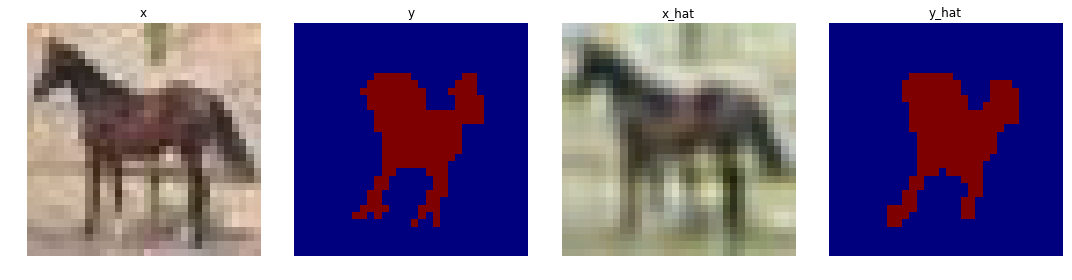

===> End of epoch 103 / 150 	 Time Taken: 3.40 sec

===> Start of epoch 104 / 200
X2Z: learning rate = 0.0094059
Z2X: learning rate = 0.0094059
Y2Z: learning rate = 0.0000941
Z2Y: learning rate = 0.0000941
D: learning rate = 0.0000941
T: learning rate = 0.0000941
[104/150][0/50] in 0.052s X2X: 0.082, Y2Y: 6.602 


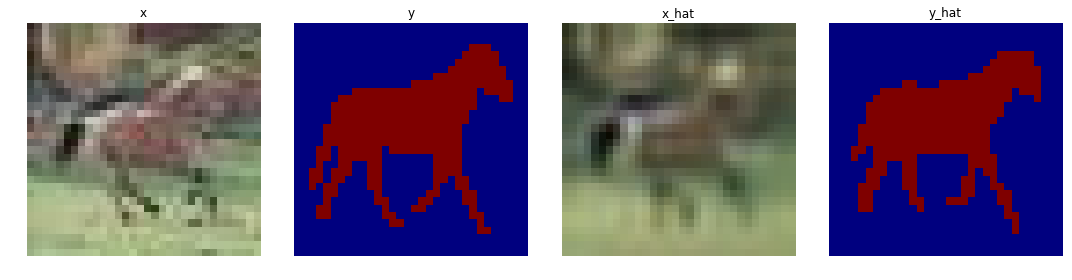

===> End of epoch 104 / 150 	 Time Taken: 3.25 sec

===> Start of epoch 105 / 200
X2Z: learning rate = 0.0093069
Z2X: learning rate = 0.0093069
Y2Z: learning rate = 0.0000931
Z2Y: learning rate = 0.0000931
D: learning rate = 0.0000931
T: learning rate = 0.0000931
[105/150][0/50] in 0.055s X2X: 0.057, Y2Y: 6.546 


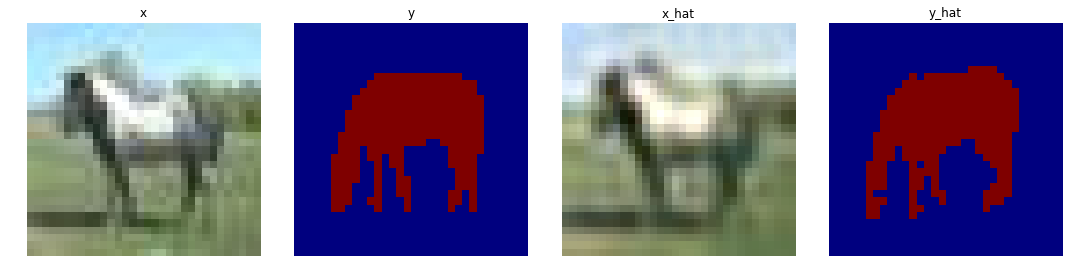

===> End of epoch 105 / 150 	 Time Taken: 3.19 sec

===> Start of epoch 106 / 200
X2Z: learning rate = 0.0092079
Z2X: learning rate = 0.0092079
Y2Z: learning rate = 0.0000921
Z2Y: learning rate = 0.0000921
D: learning rate = 0.0000921
T: learning rate = 0.0000921
[106/150][0/50] in 0.052s X2X: 0.082, Y2Y: 6.105 


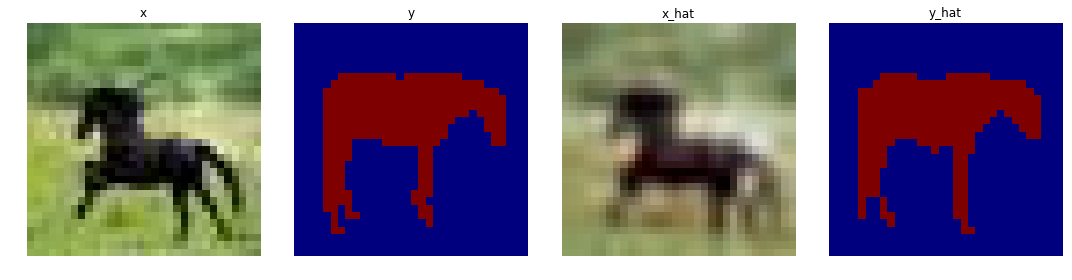

===> End of epoch 106 / 150 	 Time Taken: 3.23 sec

===> Start of epoch 107 / 200
X2Z: learning rate = 0.0091089
Z2X: learning rate = 0.0091089
Y2Z: learning rate = 0.0000911
Z2Y: learning rate = 0.0000911
D: learning rate = 0.0000911
T: learning rate = 0.0000911
[107/150][0/50] in 0.056s X2X: 0.069, Y2Y: 5.868 


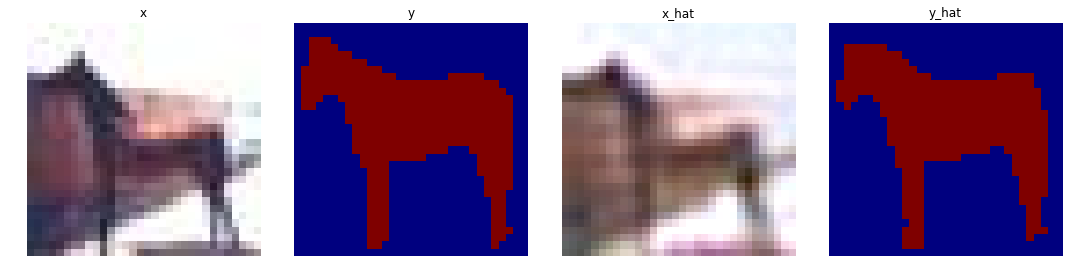

===> End of epoch 107 / 150 	 Time Taken: 3.20 sec

===> Start of epoch 108 / 200
X2Z: learning rate = 0.0090099
Z2X: learning rate = 0.0090099
Y2Z: learning rate = 0.0000901
Z2Y: learning rate = 0.0000901
D: learning rate = 0.0000901
T: learning rate = 0.0000901
[108/150][0/50] in 0.052s X2X: 0.060, Y2Y: 6.002 


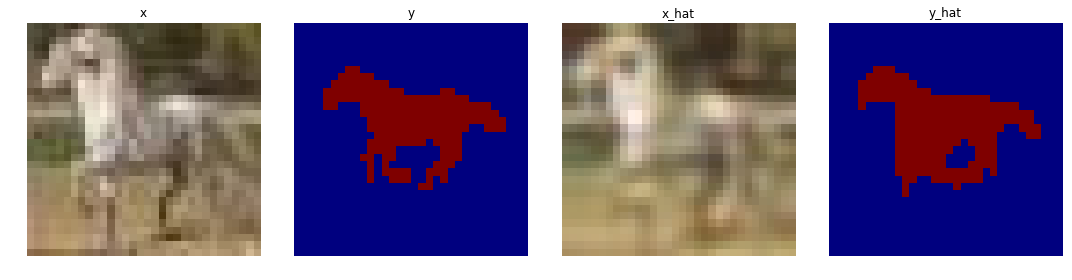

===> End of epoch 108 / 150 	 Time Taken: 3.60 sec

===> Start of epoch 109 / 200
X2Z: learning rate = 0.0089109
Z2X: learning rate = 0.0089109
Y2Z: learning rate = 0.0000891
Z2Y: learning rate = 0.0000891
D: learning rate = 0.0000891
T: learning rate = 0.0000891
[109/150][0/50] in 0.052s X2X: 0.071, Y2Y: 5.932 


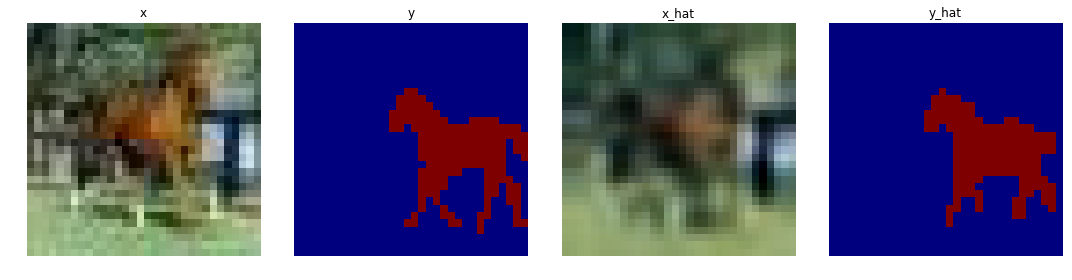

===> End of epoch 109 / 150 	 Time Taken: 3.27 sec

===> Start of epoch 110 / 200
X2Z: learning rate = 0.0088119
Z2X: learning rate = 0.0088119
Y2Z: learning rate = 0.0000881
Z2Y: learning rate = 0.0000881
D: learning rate = 0.0000881
T: learning rate = 0.0000881
[110/150][0/50] in 0.052s X2X: 0.058, Y2Y: 5.571 


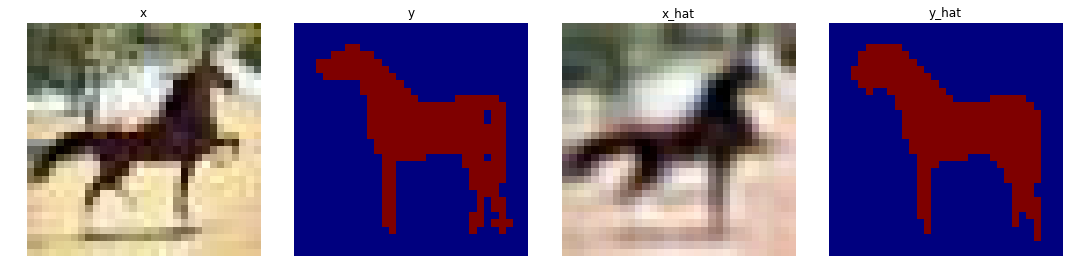

===> End of epoch 110 / 150 	 Time Taken: 3.30 sec

===> Start of epoch 111 / 200
X2Z: learning rate = 0.0087129
Z2X: learning rate = 0.0087129
Y2Z: learning rate = 0.0000871
Z2Y: learning rate = 0.0000871
D: learning rate = 0.0000871
T: learning rate = 0.0000871
[111/150][0/50] in 0.053s X2X: 0.063, Y2Y: 5.609 


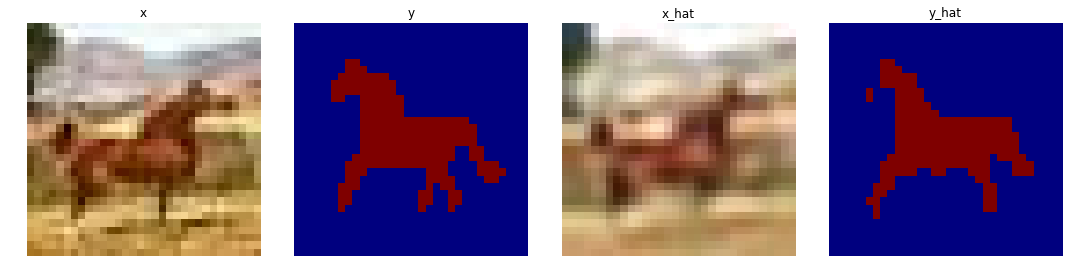

===> End of epoch 111 / 150 	 Time Taken: 3.27 sec

===> Start of epoch 112 / 200
X2Z: learning rate = 0.0086139
Z2X: learning rate = 0.0086139
Y2Z: learning rate = 0.0000861
Z2Y: learning rate = 0.0000861
D: learning rate = 0.0000861
T: learning rate = 0.0000861
[112/150][0/50] in 0.049s X2X: 0.060, Y2Y: 5.557 


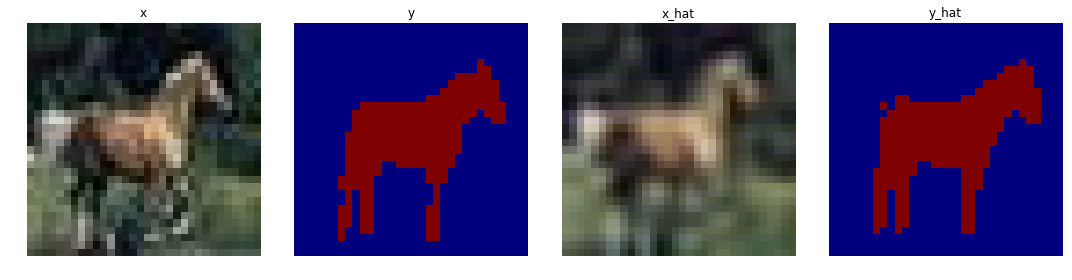

===> End of epoch 112 / 150 	 Time Taken: 3.21 sec

===> Start of epoch 113 / 200
X2Z: learning rate = 0.0085149
Z2X: learning rate = 0.0085149
Y2Z: learning rate = 0.0000851
Z2Y: learning rate = 0.0000851
D: learning rate = 0.0000851
T: learning rate = 0.0000851
[113/150][0/50] in 0.051s X2X: 0.100, Y2Y: 5.838 


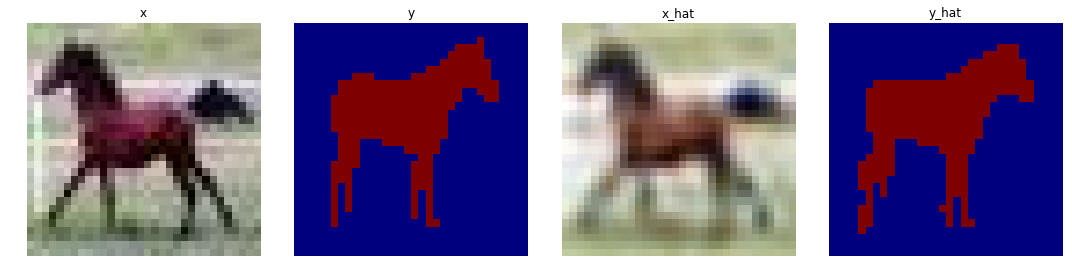

===> End of epoch 113 / 150 	 Time Taken: 3.20 sec

===> Start of epoch 114 / 200
X2Z: learning rate = 0.0084158
Z2X: learning rate = 0.0084158
Y2Z: learning rate = 0.0000842
Z2Y: learning rate = 0.0000842
D: learning rate = 0.0000842
T: learning rate = 0.0000842
[114/150][0/50] in 0.051s X2X: 0.067, Y2Y: 5.577 


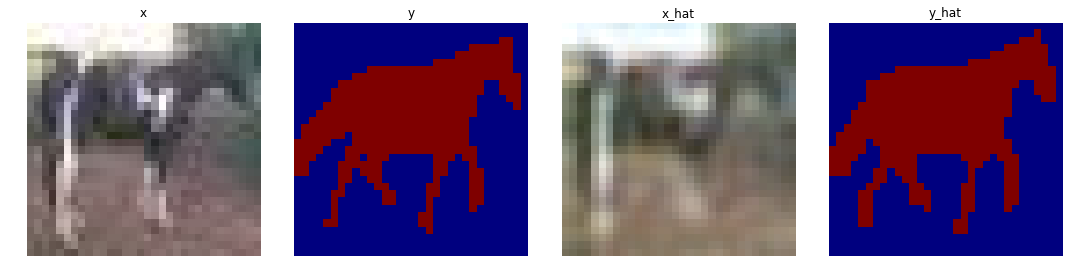

===> End of epoch 114 / 150 	 Time Taken: 3.32 sec

===> Start of epoch 115 / 200
X2Z: learning rate = 0.0083168
Z2X: learning rate = 0.0083168
Y2Z: learning rate = 0.0000832
Z2Y: learning rate = 0.0000832
D: learning rate = 0.0000832
T: learning rate = 0.0000832
[115/150][0/50] in 0.052s X2X: 0.064, Y2Y: 5.540 


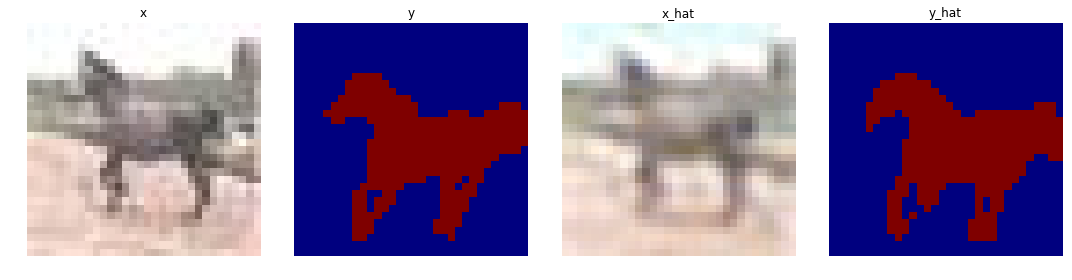

===> End of epoch 115 / 150 	 Time Taken: 3.21 sec

===> Start of epoch 116 / 200
X2Z: learning rate = 0.0082178
Z2X: learning rate = 0.0082178
Y2Z: learning rate = 0.0000822
Z2Y: learning rate = 0.0000822
D: learning rate = 0.0000822
T: learning rate = 0.0000822
[116/150][0/50] in 0.056s X2X: 0.069, Y2Y: 5.546 


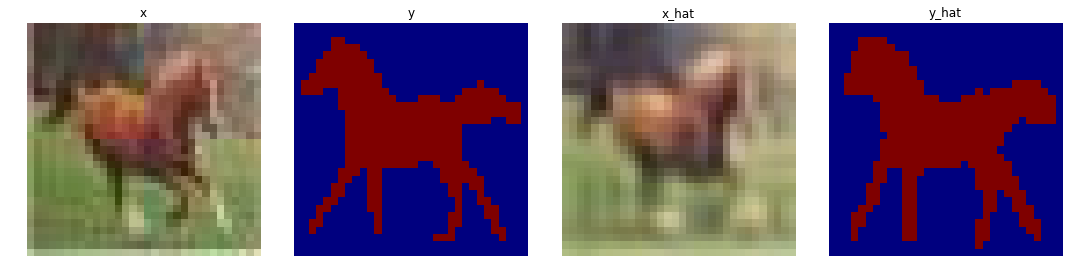

===> End of epoch 116 / 150 	 Time Taken: 3.26 sec

===> Start of epoch 117 / 200
X2Z: learning rate = 0.0081188
Z2X: learning rate = 0.0081188
Y2Z: learning rate = 0.0000812
Z2Y: learning rate = 0.0000812
D: learning rate = 0.0000812
T: learning rate = 0.0000812
[117/150][0/50] in 0.053s X2X: 0.084, Y2Y: 5.538 


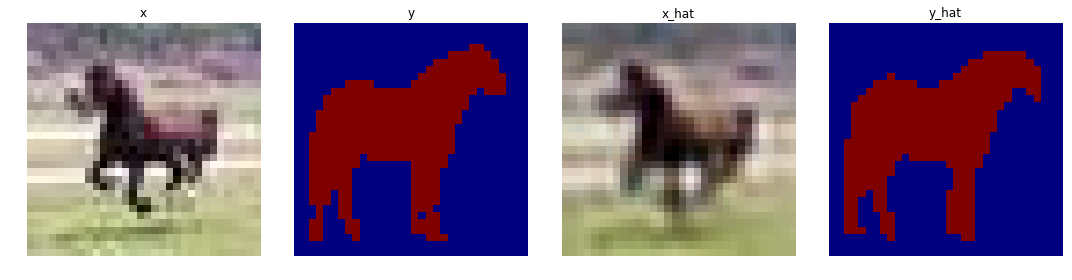

===> End of epoch 117 / 150 	 Time Taken: 3.25 sec

===> Start of epoch 118 / 200
X2Z: learning rate = 0.0080198
Z2X: learning rate = 0.0080198
Y2Z: learning rate = 0.0000802
Z2Y: learning rate = 0.0000802
D: learning rate = 0.0000802
T: learning rate = 0.0000802
[118/150][0/50] in 0.054s X2X: 0.056, Y2Y: 5.199 


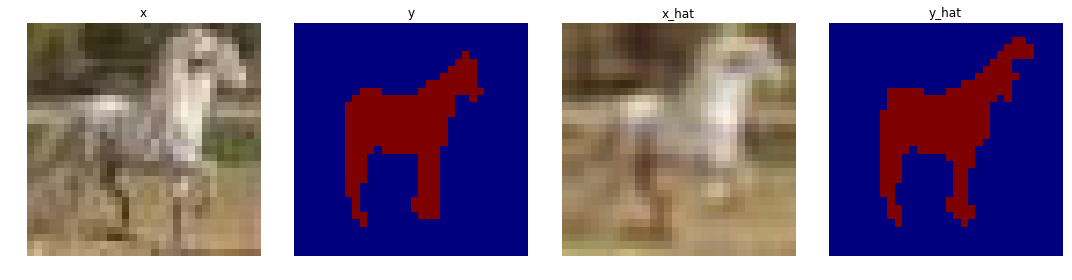

===> End of epoch 118 / 150 	 Time Taken: 3.27 sec

===> Start of epoch 119 / 200
X2Z: learning rate = 0.0079208
Z2X: learning rate = 0.0079208
Y2Z: learning rate = 0.0000792
Z2Y: learning rate = 0.0000792
D: learning rate = 0.0000792
T: learning rate = 0.0000792
[119/150][0/50] in 0.054s X2X: 0.083, Y2Y: 5.107 


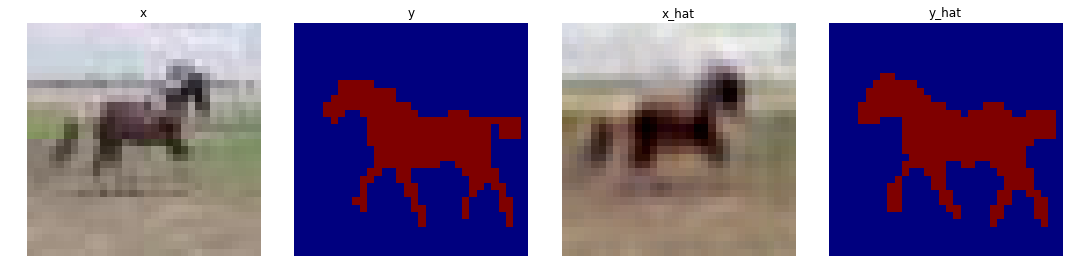

===> End of epoch 119 / 150 	 Time Taken: 3.51 sec

===> Start of epoch 120 / 200
X2Z: learning rate = 0.0078218
Z2X: learning rate = 0.0078218
Y2Z: learning rate = 0.0000782
Z2Y: learning rate = 0.0000782
D: learning rate = 0.0000782
T: learning rate = 0.0000782
[120/150][0/50] in 0.054s X2X: 0.075, Y2Y: 4.814 


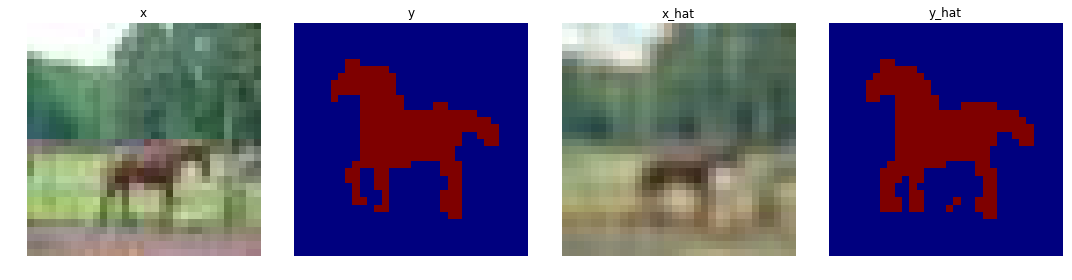

===> End of epoch 120 / 150 	 Time Taken: 3.32 sec

===> Start of epoch 121 / 200
X2Z: learning rate = 0.0077228
Z2X: learning rate = 0.0077228
Y2Z: learning rate = 0.0000772
Z2Y: learning rate = 0.0000772
D: learning rate = 0.0000772
T: learning rate = 0.0000772
[121/150][0/50] in 0.057s X2X: 0.087, Y2Y: 4.864 


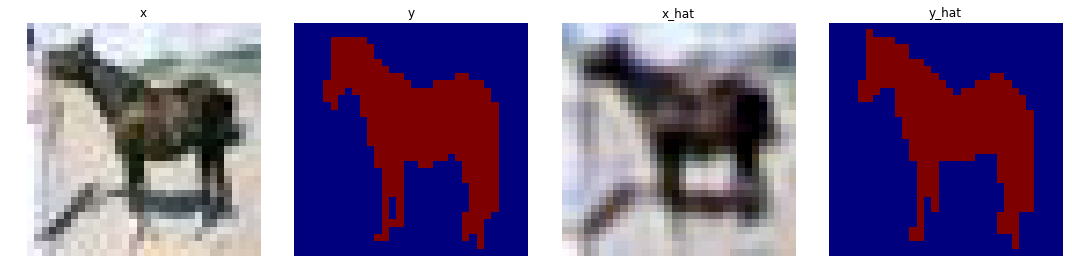

===> End of epoch 121 / 150 	 Time Taken: 3.25 sec

===> Start of epoch 122 / 200
X2Z: learning rate = 0.0076238
Z2X: learning rate = 0.0076238
Y2Z: learning rate = 0.0000762
Z2Y: learning rate = 0.0000762
D: learning rate = 0.0000762
T: learning rate = 0.0000762
[122/150][0/50] in 0.055s X2X: 0.092, Y2Y: 4.870 


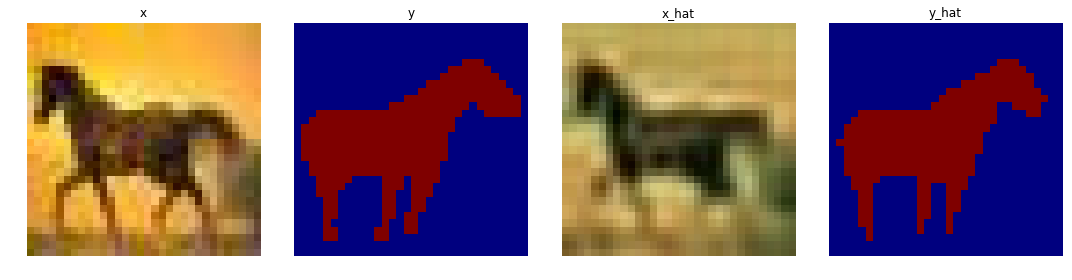

===> End of epoch 122 / 150 	 Time Taken: 3.28 sec

===> Start of epoch 123 / 200
X2Z: learning rate = 0.0075248
Z2X: learning rate = 0.0075248
Y2Z: learning rate = 0.0000752
Z2Y: learning rate = 0.0000752
D: learning rate = 0.0000752
T: learning rate = 0.0000752
[123/150][0/50] in 0.055s X2X: 0.087, Y2Y: 4.740 


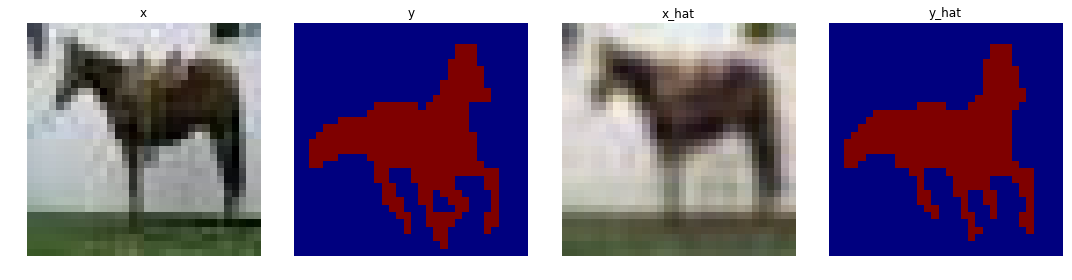

===> End of epoch 123 / 150 	 Time Taken: 3.28 sec

===> Start of epoch 124 / 200
X2Z: learning rate = 0.0074257
Z2X: learning rate = 0.0074257
Y2Z: learning rate = 0.0000743
Z2Y: learning rate = 0.0000743
D: learning rate = 0.0000743
T: learning rate = 0.0000743
[124/150][0/50] in 0.054s X2X: 0.069, Y2Y: 4.798 


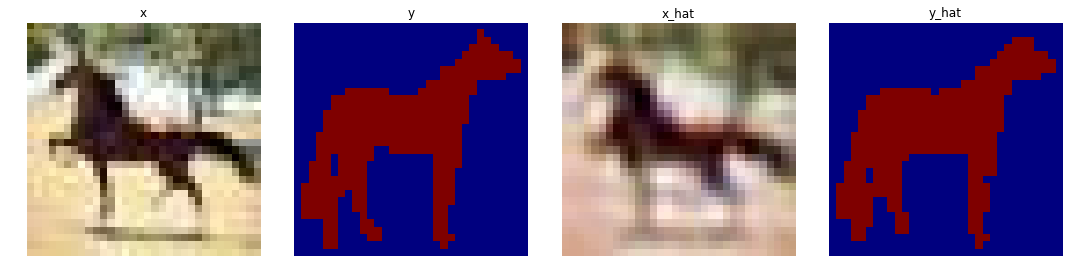

===> End of epoch 124 / 150 	 Time Taken: 3.32 sec

===> Start of epoch 125 / 200
X2Z: learning rate = 0.0073267
Z2X: learning rate = 0.0073267
Y2Z: learning rate = 0.0000733
Z2Y: learning rate = 0.0000733
D: learning rate = 0.0000733
T: learning rate = 0.0000733
[125/150][0/50] in 0.055s X2X: 0.058, Y2Y: 4.711 


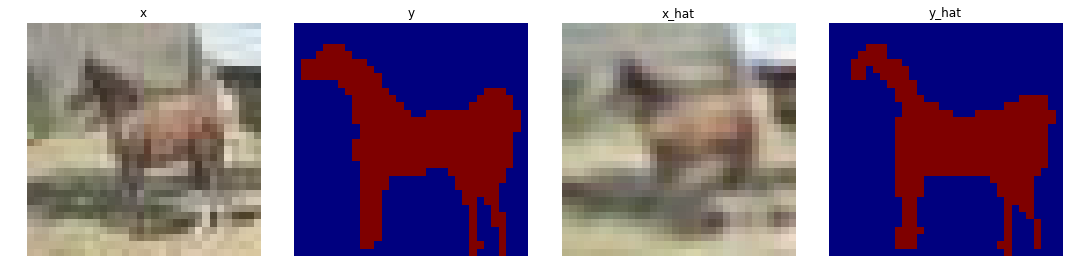

===> End of epoch 125 / 150 	 Time Taken: 3.40 sec

===> Start of epoch 126 / 200
X2Z: learning rate = 0.0072277
Z2X: learning rate = 0.0072277
Y2Z: learning rate = 0.0000723
Z2Y: learning rate = 0.0000723
D: learning rate = 0.0000723
T: learning rate = 0.0000723
[126/150][0/50] in 0.055s X2X: 0.105, Y2Y: 4.435 


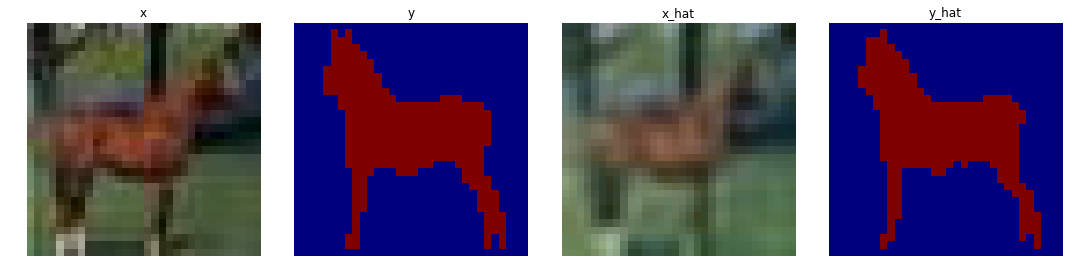

===> End of epoch 126 / 150 	 Time Taken: 3.27 sec

===> Start of epoch 127 / 200
X2Z: learning rate = 0.0071287
Z2X: learning rate = 0.0071287
Y2Z: learning rate = 0.0000713
Z2Y: learning rate = 0.0000713
D: learning rate = 0.0000713
T: learning rate = 0.0000713
[127/150][0/50] in 0.052s X2X: 0.071, Y2Y: 4.501 


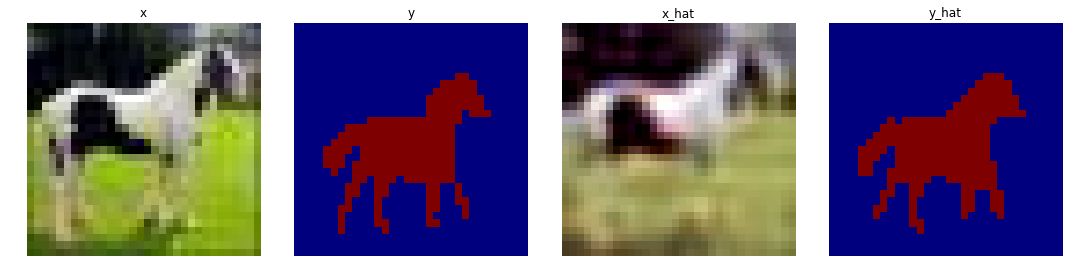

===> End of epoch 127 / 150 	 Time Taken: 3.26 sec

===> Start of epoch 128 / 200
X2Z: learning rate = 0.0070297
Z2X: learning rate = 0.0070297
Y2Z: learning rate = 0.0000703
Z2Y: learning rate = 0.0000703
D: learning rate = 0.0000703
T: learning rate = 0.0000703
[128/150][0/50] in 0.054s X2X: 0.071, Y2Y: 4.293 


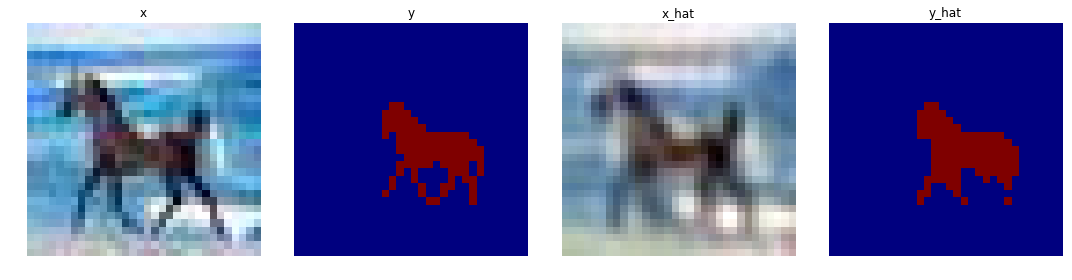

===> End of epoch 128 / 150 	 Time Taken: 3.28 sec

===> Start of epoch 129 / 200
X2Z: learning rate = 0.0069307
Z2X: learning rate = 0.0069307
Y2Z: learning rate = 0.0000693
Z2Y: learning rate = 0.0000693
D: learning rate = 0.0000693
T: learning rate = 0.0000693
[129/150][0/50] in 0.052s X2X: 0.068, Y2Y: 4.654 


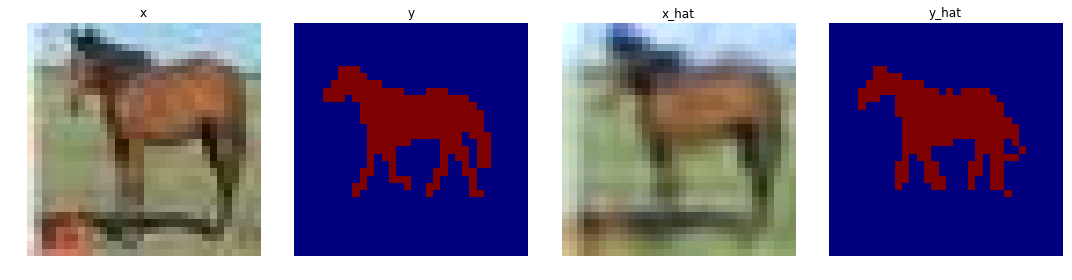

===> End of epoch 129 / 150 	 Time Taken: 3.30 sec

===> Start of epoch 130 / 200
X2Z: learning rate = 0.0068317
Z2X: learning rate = 0.0068317
Y2Z: learning rate = 0.0000683
Z2Y: learning rate = 0.0000683
D: learning rate = 0.0000683
T: learning rate = 0.0000683
[130/150][0/50] in 0.051s X2X: 0.075, Y2Y: 4.270 


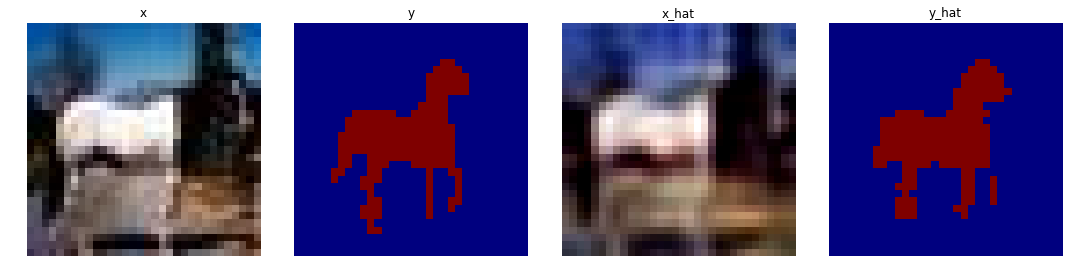

===> End of epoch 130 / 150 	 Time Taken: 3.49 sec

===> Start of epoch 131 / 200
X2Z: learning rate = 0.0067327
Z2X: learning rate = 0.0067327
Y2Z: learning rate = 0.0000673
Z2Y: learning rate = 0.0000673
D: learning rate = 0.0000673
T: learning rate = 0.0000673
[131/150][0/50] in 0.052s X2X: 0.083, Y2Y: 4.230 


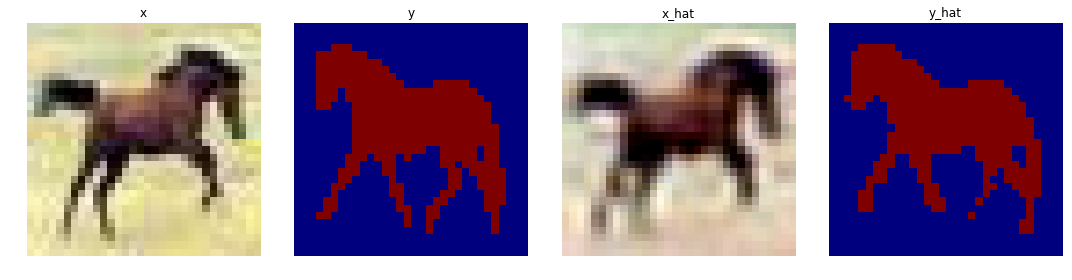

===> End of epoch 131 / 150 	 Time Taken: 3.29 sec

===> Start of epoch 132 / 200
X2Z: learning rate = 0.0066337
Z2X: learning rate = 0.0066337
Y2Z: learning rate = 0.0000663
Z2Y: learning rate = 0.0000663
D: learning rate = 0.0000663
T: learning rate = 0.0000663
[132/150][0/50] in 0.051s X2X: 0.086, Y2Y: 3.828 


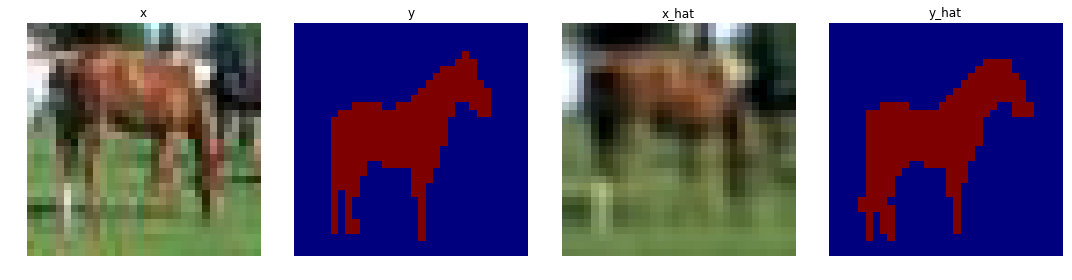

===> End of epoch 132 / 150 	 Time Taken: 3.20 sec

===> Start of epoch 133 / 200
X2Z: learning rate = 0.0065347
Z2X: learning rate = 0.0065347
Y2Z: learning rate = 0.0000653
Z2Y: learning rate = 0.0000653
D: learning rate = 0.0000653
T: learning rate = 0.0000653
[133/150][0/50] in 0.051s X2X: 0.053, Y2Y: 3.927 


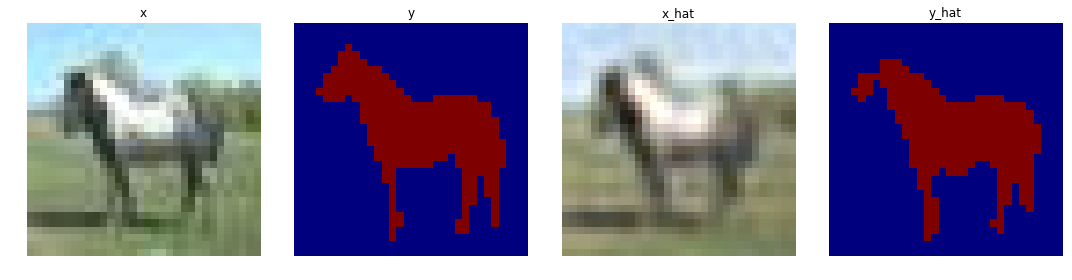

===> End of epoch 133 / 150 	 Time Taken: 3.26 sec

===> Start of epoch 134 / 200
X2Z: learning rate = 0.0064356
Z2X: learning rate = 0.0064356
Y2Z: learning rate = 0.0000644
Z2Y: learning rate = 0.0000644
D: learning rate = 0.0000644
T: learning rate = 0.0000644
[134/150][0/50] in 0.052s X2X: 0.067, Y2Y: 4.047 


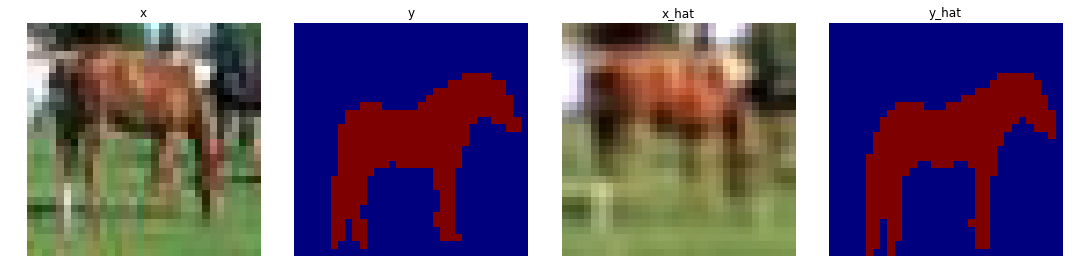

===> End of epoch 134 / 150 	 Time Taken: 3.27 sec

===> Start of epoch 135 / 200
X2Z: learning rate = 0.0063366
Z2X: learning rate = 0.0063366
Y2Z: learning rate = 0.0000634
Z2Y: learning rate = 0.0000634
D: learning rate = 0.0000634
T: learning rate = 0.0000634
[135/150][0/50] in 0.052s X2X: 0.056, Y2Y: 3.968 


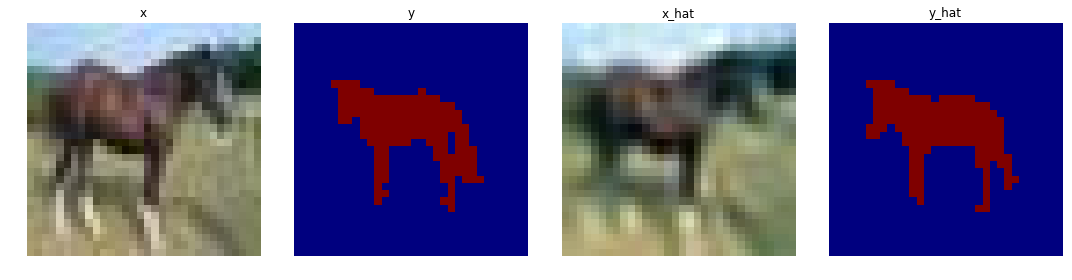

===> End of epoch 135 / 150 	 Time Taken: 3.21 sec

===> Start of epoch 136 / 200
X2Z: learning rate = 0.0062376
Z2X: learning rate = 0.0062376
Y2Z: learning rate = 0.0000624
Z2Y: learning rate = 0.0000624
D: learning rate = 0.0000624
T: learning rate = 0.0000624
[136/150][0/50] in 0.052s X2X: 0.060, Y2Y: 3.959 


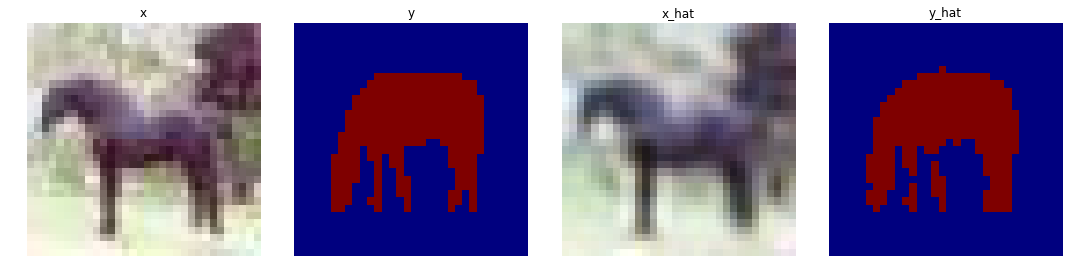

===> End of epoch 136 / 150 	 Time Taken: 3.32 sec

===> Start of epoch 137 / 200
X2Z: learning rate = 0.0061386
Z2X: learning rate = 0.0061386
Y2Z: learning rate = 0.0000614
Z2Y: learning rate = 0.0000614
D: learning rate = 0.0000614
T: learning rate = 0.0000614
[137/150][0/50] in 0.052s X2X: 0.049, Y2Y: 3.799 


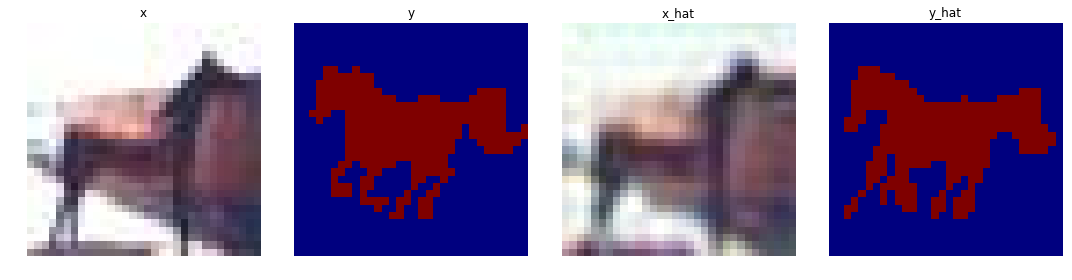

===> End of epoch 137 / 150 	 Time Taken: 3.21 sec

===> Start of epoch 138 / 200
X2Z: learning rate = 0.0060396
Z2X: learning rate = 0.0060396
Y2Z: learning rate = 0.0000604
Z2Y: learning rate = 0.0000604
D: learning rate = 0.0000604
T: learning rate = 0.0000604
[138/150][0/50] in 0.054s X2X: 0.071, Y2Y: 4.069 


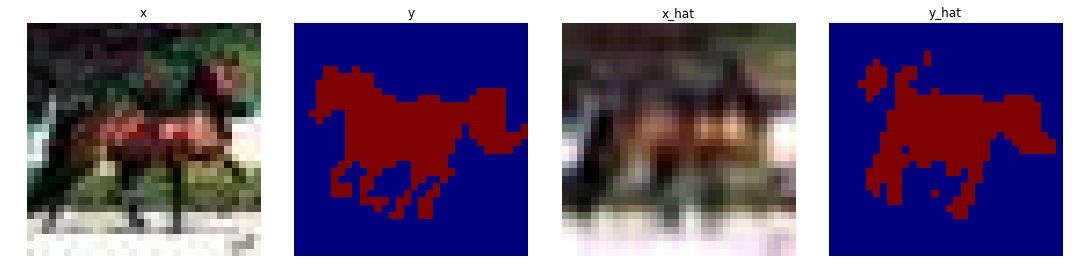

===> End of epoch 138 / 150 	 Time Taken: 3.27 sec

===> Start of epoch 139 / 200
X2Z: learning rate = 0.0059406
Z2X: learning rate = 0.0059406
Y2Z: learning rate = 0.0000594
Z2Y: learning rate = 0.0000594
D: learning rate = 0.0000594
T: learning rate = 0.0000594
[139/150][0/50] in 0.052s X2X: 0.075, Y2Y: 3.635 


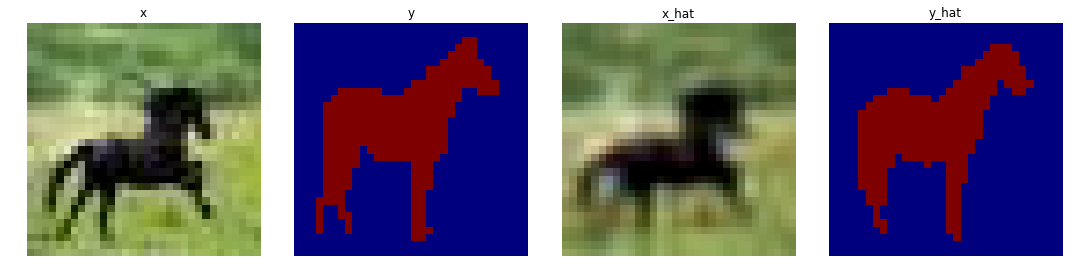

===> End of epoch 139 / 150 	 Time Taken: 3.23 sec

===> Start of epoch 140 / 200
X2Z: learning rate = 0.0058416
Z2X: learning rate = 0.0058416
Y2Z: learning rate = 0.0000584
Z2Y: learning rate = 0.0000584
D: learning rate = 0.0000584
T: learning rate = 0.0000584
[140/150][0/50] in 0.051s X2X: 0.067, Y2Y: 3.608 


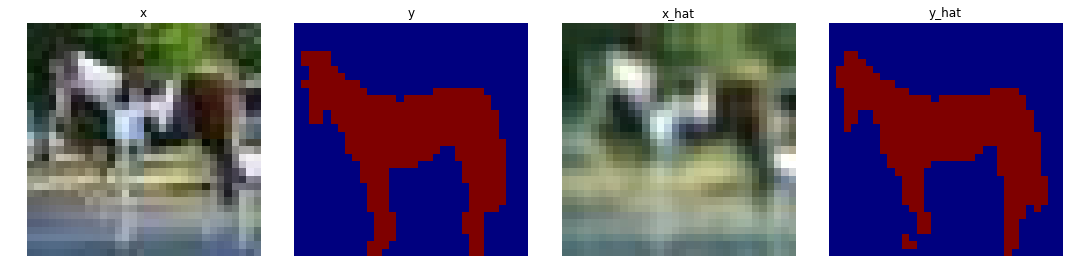

===> End of epoch 140 / 150 	 Time Taken: 3.21 sec

===> Start of epoch 141 / 200
X2Z: learning rate = 0.0057426
Z2X: learning rate = 0.0057426
Y2Z: learning rate = 0.0000574
Z2Y: learning rate = 0.0000574
D: learning rate = 0.0000574
T: learning rate = 0.0000574
[141/150][0/50] in 0.057s X2X: 0.066, Y2Y: 3.594 


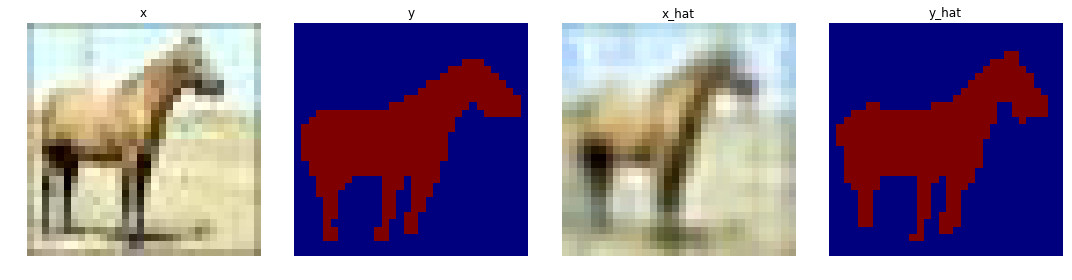

===> End of epoch 141 / 150 	 Time Taken: 3.47 sec

===> Start of epoch 142 / 200
X2Z: learning rate = 0.0056436
Z2X: learning rate = 0.0056436
Y2Z: learning rate = 0.0000564
Z2Y: learning rate = 0.0000564
D: learning rate = 0.0000564
T: learning rate = 0.0000564
[142/150][0/50] in 0.076s X2X: 0.075, Y2Y: 3.643 


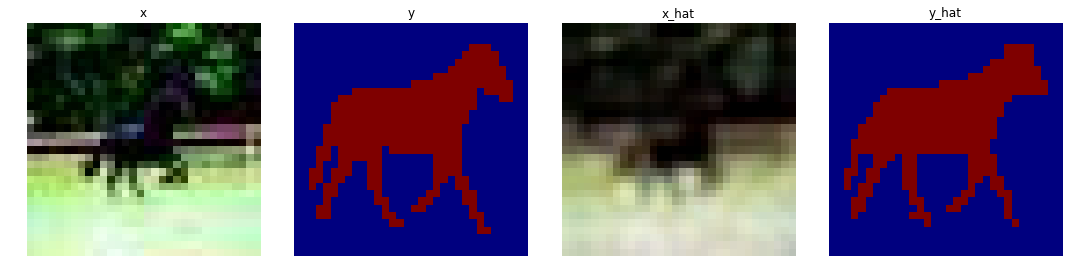

===> End of epoch 142 / 150 	 Time Taken: 3.35 sec

===> Start of epoch 143 / 200
X2Z: learning rate = 0.0055446
Z2X: learning rate = 0.0055446
Y2Z: learning rate = 0.0000554
Z2Y: learning rate = 0.0000554
D: learning rate = 0.0000554
T: learning rate = 0.0000554
[143/150][0/50] in 0.061s X2X: 0.062, Y2Y: 3.436 


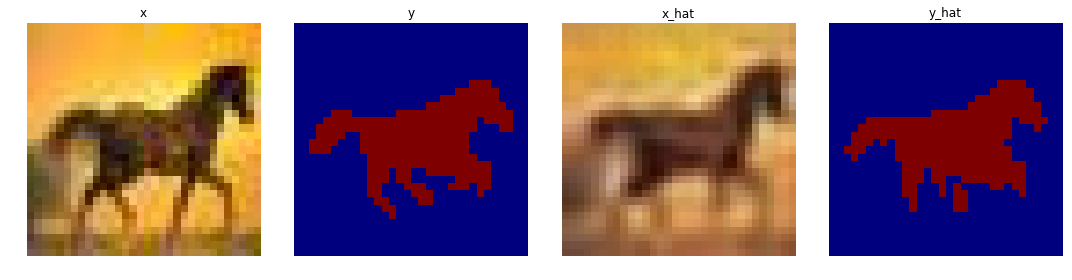

===> End of epoch 143 / 150 	 Time Taken: 3.32 sec

===> Start of epoch 144 / 200
X2Z: learning rate = 0.0054455
Z2X: learning rate = 0.0054455
Y2Z: learning rate = 0.0000545
Z2Y: learning rate = 0.0000545
D: learning rate = 0.0000545
T: learning rate = 0.0000545
[144/150][0/50] in 0.060s X2X: 0.063, Y2Y: 3.404 


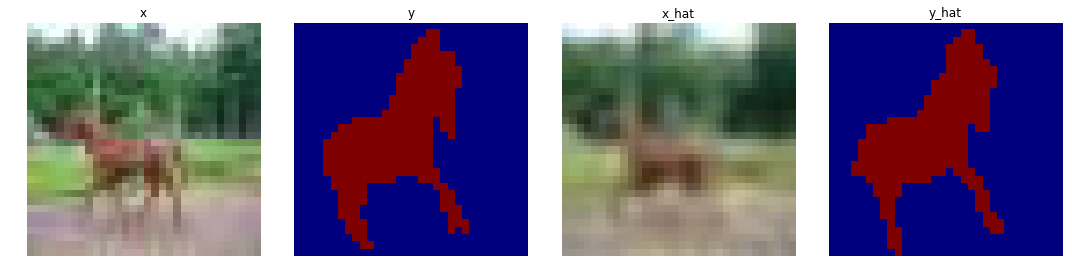

===> End of epoch 144 / 150 	 Time Taken: 3.26 sec

===> Start of epoch 145 / 200
X2Z: learning rate = 0.0053465
Z2X: learning rate = 0.0053465
Y2Z: learning rate = 0.0000535
Z2Y: learning rate = 0.0000535
D: learning rate = 0.0000535
T: learning rate = 0.0000535
[145/150][0/50] in 0.054s X2X: 0.094, Y2Y: 3.298 


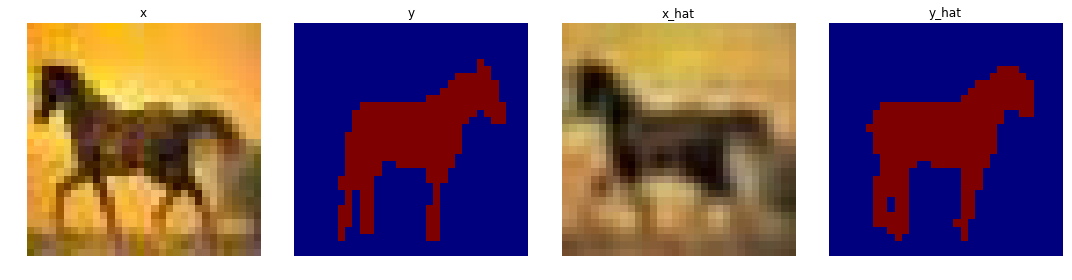

===> End of epoch 145 / 150 	 Time Taken: 3.35 sec

===> Start of epoch 146 / 200
X2Z: learning rate = 0.0052475
Z2X: learning rate = 0.0052475
Y2Z: learning rate = 0.0000525
Z2Y: learning rate = 0.0000525
D: learning rate = 0.0000525
T: learning rate = 0.0000525
[146/150][0/50] in 0.060s X2X: 0.060, Y2Y: 3.305 


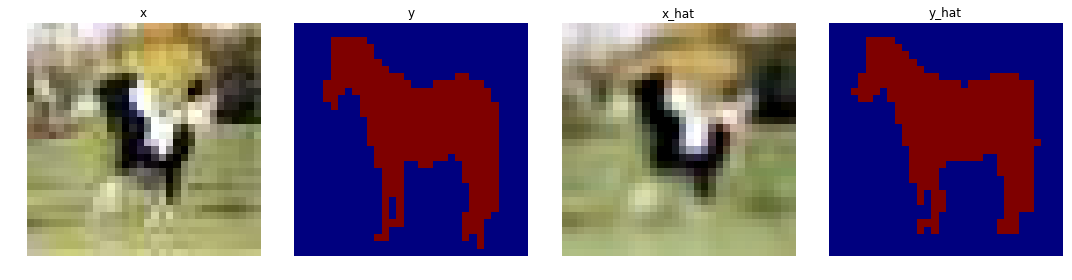

===> End of epoch 146 / 150 	 Time Taken: 3.24 sec

===> Start of epoch 147 / 200
X2Z: learning rate = 0.0051485
Z2X: learning rate = 0.0051485
Y2Z: learning rate = 0.0000515
Z2Y: learning rate = 0.0000515
D: learning rate = 0.0000515
T: learning rate = 0.0000515
[147/150][0/50] in 0.054s X2X: 0.063, Y2Y: 3.296 


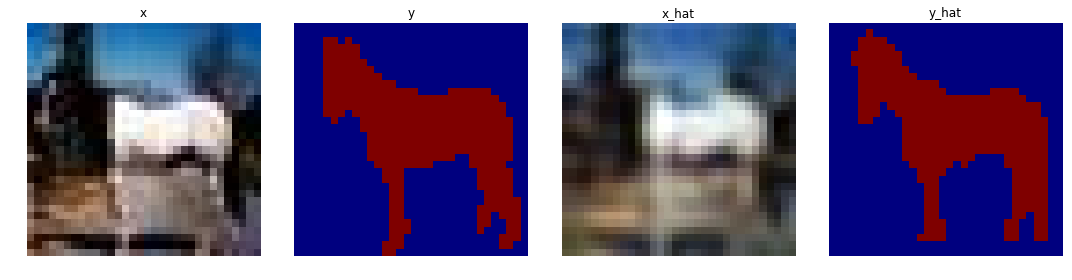

===> End of epoch 147 / 150 	 Time Taken: 3.33 sec

===> Start of epoch 148 / 200
X2Z: learning rate = 0.0050495
Z2X: learning rate = 0.0050495
Y2Z: learning rate = 0.0000505
Z2Y: learning rate = 0.0000505
D: learning rate = 0.0000505
T: learning rate = 0.0000505
[148/150][0/50] in 0.052s X2X: 0.065, Y2Y: 3.253 


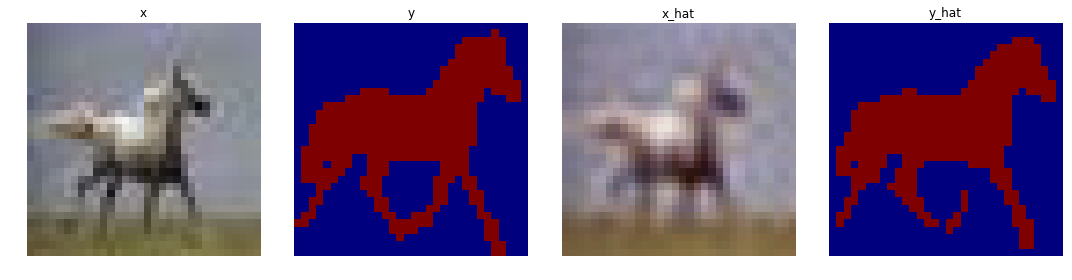

===> End of epoch 148 / 150 	 Time Taken: 3.18 sec

===> Start of epoch 149 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000495
T: learning rate = 0.0000495
[149/150][0/50] in 0.055s X2X: 0.059, Y2Y: 3.095 


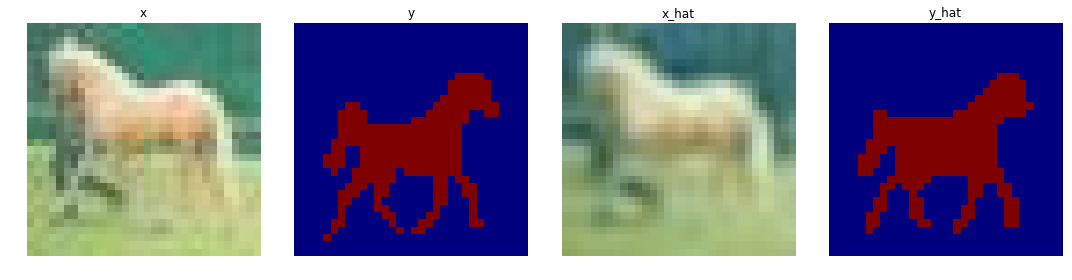

===> End of epoch 149 / 150 	 Time Taken: 3.33 sec



In [21]:
opt.lbda['X2X'] = 1
n_pretrain = 150
for k,v in net.items():
    v.train()

for epoch in range(n_pretrain):
    # on begin epoch
    adjust_lr(epoch, ['X2Z', 'Z2X', 'Y2Z', 'Z2Y'])
    epoch_start_time = time.time()
    
    for i in range(len(x_loader)):
        i_losses = {}
        tt0 = time.time()
        
        v_x = generate_var_x()
        v_y_int, v_y = generate_var_y()
        
        i_losses['X2X'], _, x_hat_dict = x2x_forward(v_x)
        i_losses['Y2Y'], _, y_hat_dict = y2y_forward(v_y_int, v_y, do_vae=True)
        G_backward(i_losses)
        
        # time spent per sample
        tt3 = time.time()

        # -------------------------------------------------------------------
        # print & plot
        if i % (len(x_loader)/3) == 0:
            stats = {k:v.data[0] for k,v in i_losses.items()}
            print('[{epoch}/{nepoch}][{iter}/{niter}] in {t:.3f}s '
                  'X2X: {X2X:.3f}, Y2Y: {Y2Y:.3f} '
                  ''.format(epoch=epoch, nepoch=n_pretrain,
                            iter=i, niter=len(x_loader), t=tt3-tt0,
                            **stats))
            # visdom
            images = {}
            images['x'] = v_x.data.cpu()
            images['y'] = v_y_int.data.cpu().numpy()
            images.update(x_hat_dict)
            images.update(y_hat_dict)
            display_imgs(images, epoch, i)

    # -------------------------------------------------------------------
    # on end epoch
    print('===> End of epoch %d / %d \t Time Taken: %.2f sec\n' % \
                (epoch, n_pretrain, time.time() - epoch_start_time))

In [59]:
for k in net.keys():
    weights_fpath = os.path.join(opt.checkpoints_dir, opt.name, 'net%s.pth' % (k))
    torch.save(net[k].state_dict(), weights_fpath)

# Main loop

In [57]:
mIoU = evaluation(0, do_G=True)
#stats = {'D':0, 'GAN':0, 'T':0, 'X2X':0, 'Y2Y':0, 'CE':0}
g_it = 0
opt.lbda['X2X'] = 0.1
opt.lbda['CE'] = 10
opt.lbda['T'] = 1
opt.lbda['GAN'] = 1
adjust_lr(n_pretrain, ['X2Z', 'Z2X', 'Y2Z', 'Z2Y'])
opt.start_epoch = 0

===> Start of epoch 150 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000495
T: learning rate = 0.0000495


===> Start of epoch 0 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[0/200][0/50] in 1.766s (1.476,0.211,0.078) D/G: 0.001/-0.000 DP/GP: 0.002/-0.000 X2X/X2XP: 0.054/0.056 Y2Y/Y2YP: 3.388/3.130 T: 99452.914 CE: 0.763 


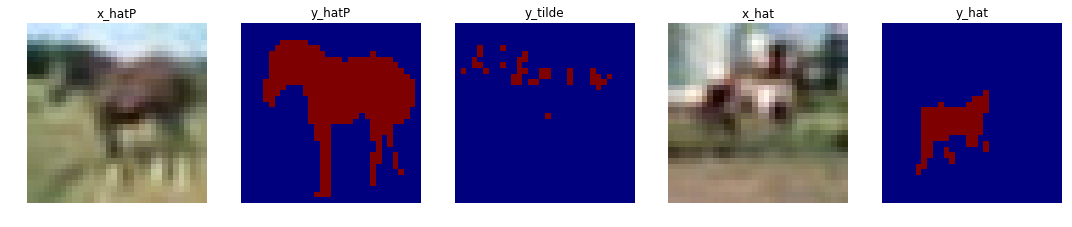

===> End of epoch 0 / 200 	 Time Taken: 47.66 sec

===> Start of epoch 1 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[1/200][0/50] in 0.462s (0.321,0.077,0.063) D/G: 0.000/0.071 DP/GP: 0.000/0.071 X2X/X2XP: 0.146/0.152 Y2Y/Y2YP: 0.548/0.580 T: 1296.358 CE: 0.573 


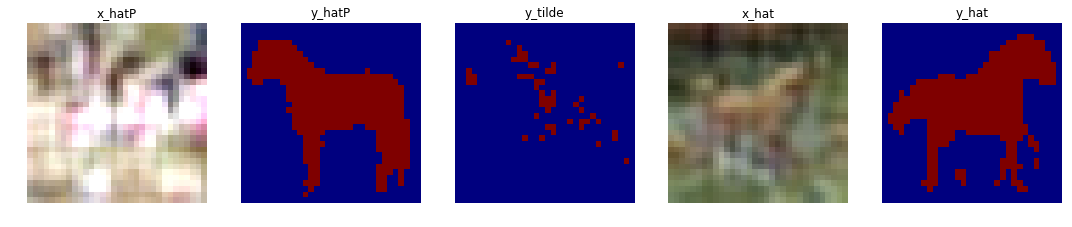

===> End of epoch 1 / 200 	 Time Taken: 15.55 sec

===> Start of epoch 2 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[2/200][0/50] in 0.490s (0.334,0.086,0.070) D/G: 0.157/0.063 DP/GP: 0.159/0.063 X2X/X2XP: 0.135/0.144 Y2Y/Y2YP: 0.435/0.378 T: 418.340 CE: 0.389 


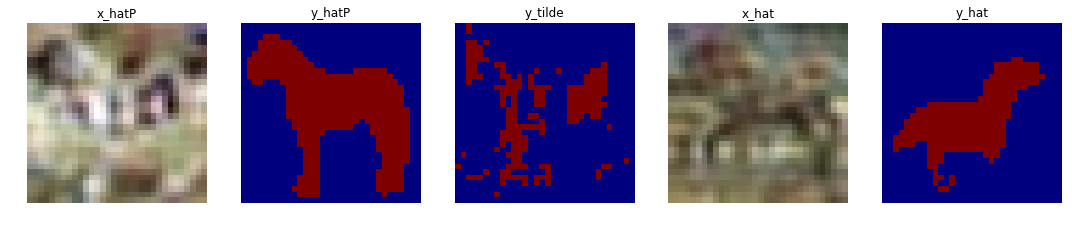

===> End of epoch 2 / 200 	 Time Taken: 16.08 sec

===> Start of epoch 3 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[3/200][0/50] in 0.503s (0.348,0.085,0.070) D/G: 0.164/0.060 DP/GP: 0.164/0.060 X2X/X2XP: 0.132/0.147 Y2Y/Y2YP: 0.378/0.360 T: 120.256 CE: 0.194 


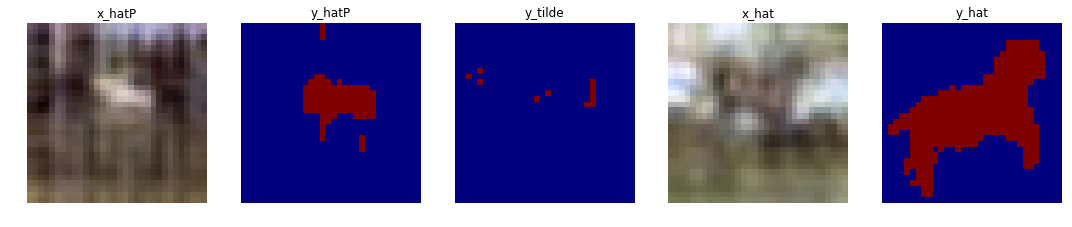

===> End of epoch 3 / 200 	 Time Taken: 16.24 sec

===> Start of epoch 4 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[4/200][0/50] in 0.429s (0.274,0.085,0.070) D/G: 0.165/0.057 DP/GP: 0.161/0.057 X2X/X2XP: 0.143/0.128 Y2Y/Y2YP: 0.323/0.280 T: 112.200 CE: 0.186 


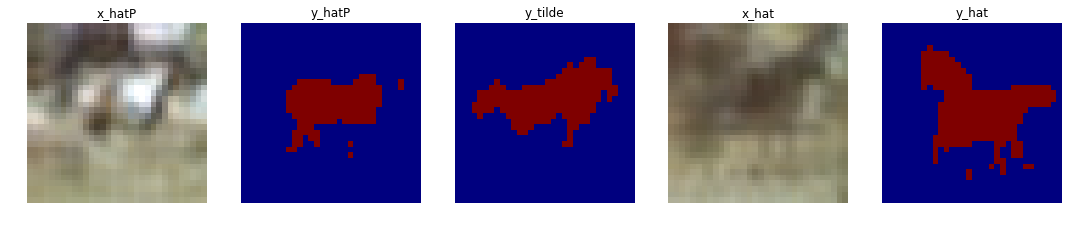

===> End of epoch 4 / 200 	 Time Taken: 16.06 sec

===> Start of epoch 5 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[5/200][0/50] in 0.440s (0.284,0.086,0.070) D/G: 0.165/0.056 DP/GP: 0.165/0.056 X2X/X2XP: 0.120/0.115 Y2Y/Y2YP: 0.288/0.275 T: 156.608 CE: 0.204 


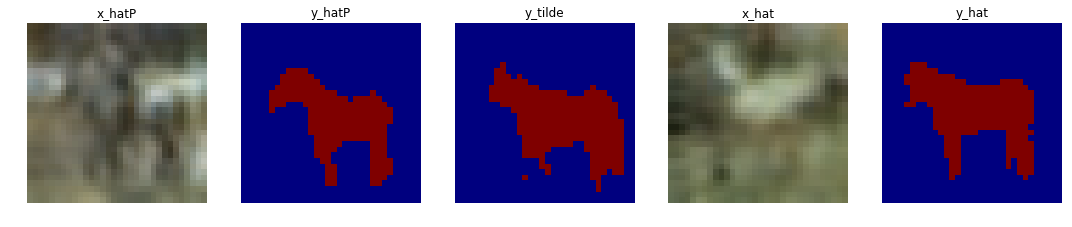

===> End of epoch 5 / 200 	 Time Taken: 16.25 sec

===> Start of epoch 6 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[6/200][0/50] in 0.487s (0.326,0.091,0.070) D/G: 0.000/0.055 DP/GP: 0.156/0.055 X2X/X2XP: 0.110/0.102 Y2Y/Y2YP: 0.247/0.243 T: 80.845 CE: 0.136 


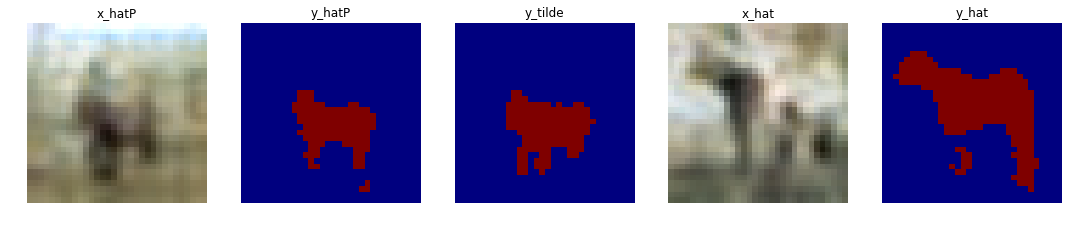

===> End of epoch 6 / 200 	 Time Taken: 16.34 sec

===> Start of epoch 7 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[7/200][0/50] in 0.499s (0.343,0.086,0.070) D/G: 0.163/0.054 DP/GP: 0.164/0.054 X2X/X2XP: 0.133/0.095 Y2Y/Y2YP: 0.271/0.211 T: 40.947 CE: 0.097 


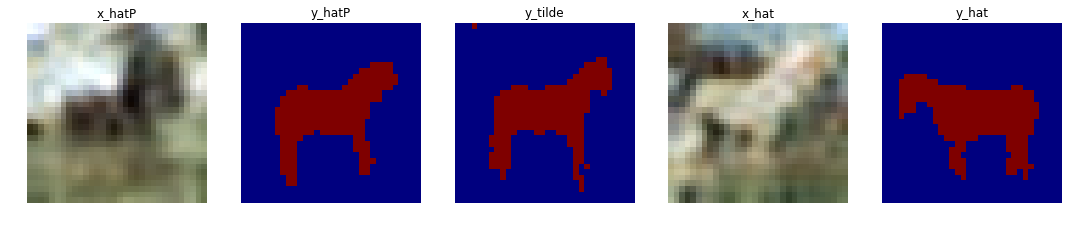

===> End of epoch 7 / 200 	 Time Taken: 16.40 sec

===> Start of epoch 8 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[8/200][0/50] in 0.542s (0.386,0.086,0.071) D/G: 0.029/0.054 DP/GP: 0.163/0.054 X2X/X2XP: 0.123/0.102 Y2Y/Y2YP: 0.306/0.224 T: 79.616 CE: 0.121 


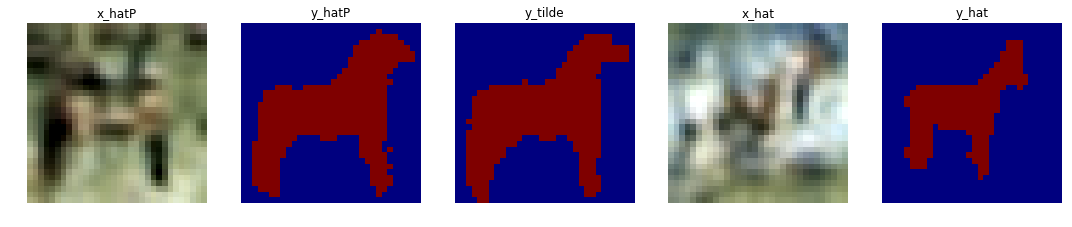

===> End of epoch 8 / 200 	 Time Taken: 16.32 sec

===> Start of epoch 9 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[9/200][0/50] in 0.528s (0.371,0.086,0.070) D/G: 0.166/0.054 DP/GP: 0.166/0.054 X2X/X2XP: 0.081/0.110 Y2Y/Y2YP: 0.222/0.221 T: 30.373 CE: 0.089 


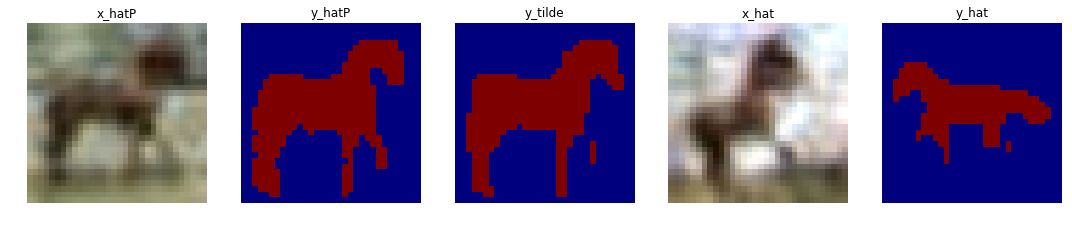

===> End of epoch 9 / 200 	 Time Taken: 16.38 sec

===> Start of epoch 10 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[10/200][0/50] in 1.680s (1.520,0.087,0.073) D/G: 0.166/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.093/0.112 Y2Y/Y2YP: 0.235/0.193 T: 83.663 CE: 0.164 


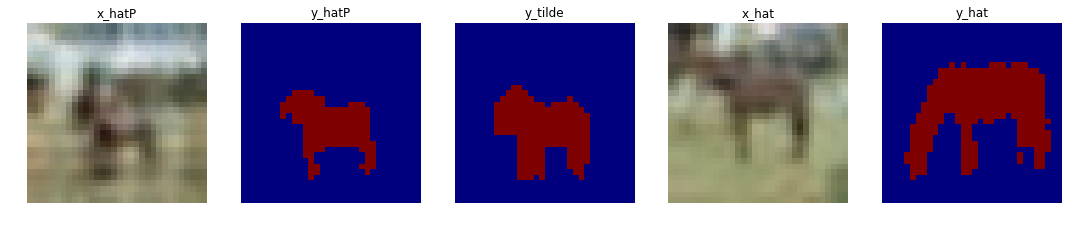

===> End of epoch 10 / 200 	 Time Taken: 17.32 sec

===> Start of epoch 11 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[11/200][0/50] in 0.300s (0.144,0.083,0.073) D/G: 0.166/0.054 DP/GP: 0.166/0.054 X2X/X2XP: 0.103/0.119 Y2Y/Y2YP: 0.261/0.219 T: 45.158 CE: 0.116 


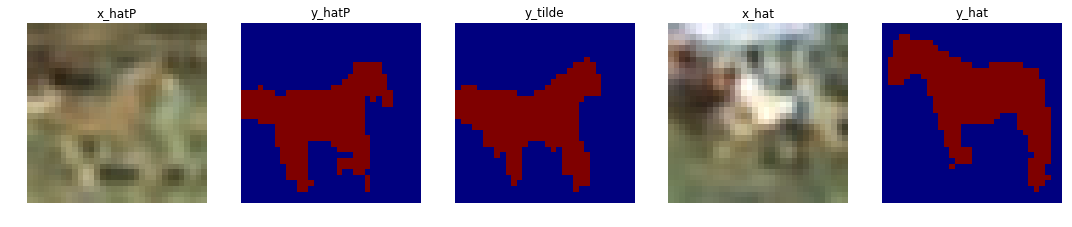

===> End of epoch 11 / 200 	 Time Taken: 16.41 sec

===> Start of epoch 12 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[12/200][0/50] in 0.293s (0.135,0.083,0.075) D/G: 0.166/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.089/0.089 Y2Y/Y2YP: 0.246/0.193 T: 29.255 CE: 0.071 


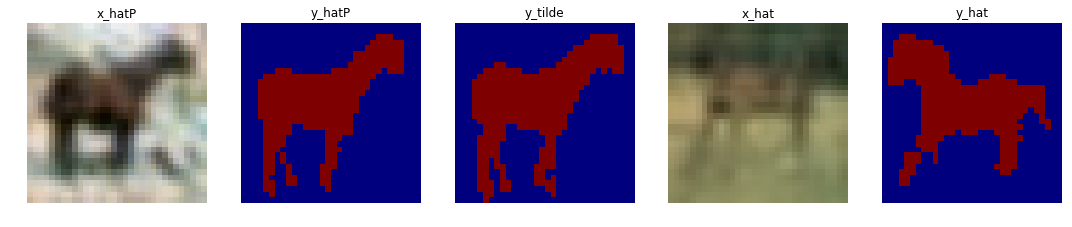

===> End of epoch 12 / 200 	 Time Taken: 16.14 sec

===> Start of epoch 13 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[13/200][0/50] in 0.297s (0.143,0.083,0.071) D/G: 0.166/0.054 DP/GP: 0.166/0.054 X2X/X2XP: 0.102/0.086 Y2Y/Y2YP: 0.246/0.173 T: 63.030 CE: 0.174 


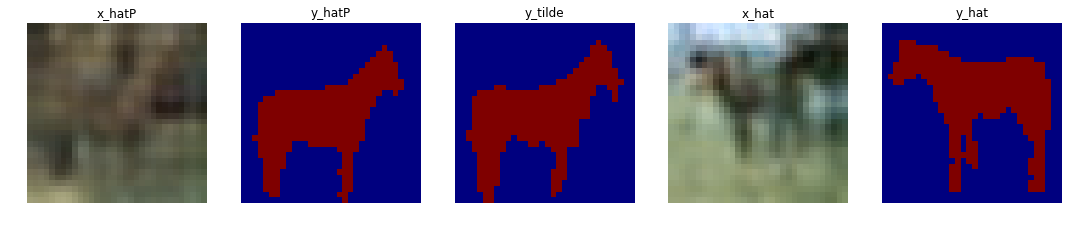

===> End of epoch 13 / 200 	 Time Taken: 16.47 sec

===> Start of epoch 14 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[14/200][0/50] in 0.289s (0.136,0.083,0.071) D/G: 0.165/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.142/0.086 Y2Y/Y2YP: 0.204/0.199 T: 17.676 CE: 0.088 


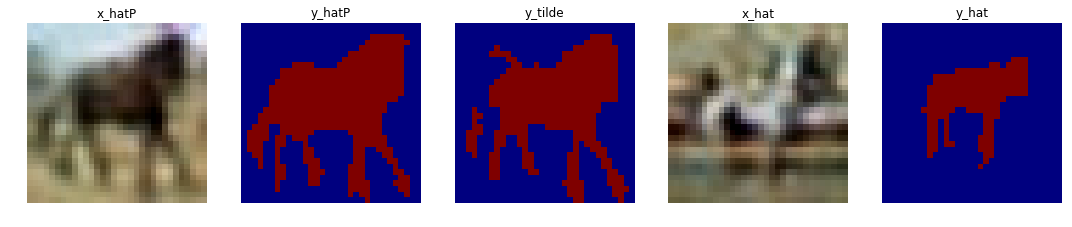

===> End of epoch 14 / 200 	 Time Taken: 16.08 sec

===> Start of epoch 15 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[15/200][0/50] in 0.292s (0.138,0.083,0.072) D/G: 0.166/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.111/0.077 Y2Y/Y2YP: 0.259/0.165 T: 26.487 CE: 0.044 


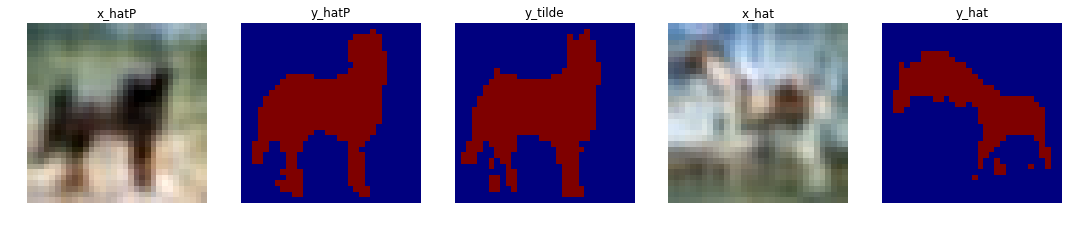

===> End of epoch 15 / 200 	 Time Taken: 16.06 sec

===> Start of epoch 16 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[16/200][0/50] in 0.298s (0.143,0.083,0.072) D/G: 0.166/0.054 DP/GP: 0.166/0.054 X2X/X2XP: 0.103/0.086 Y2Y/Y2YP: 0.219/0.199 T: 28.376 CE: 0.066 


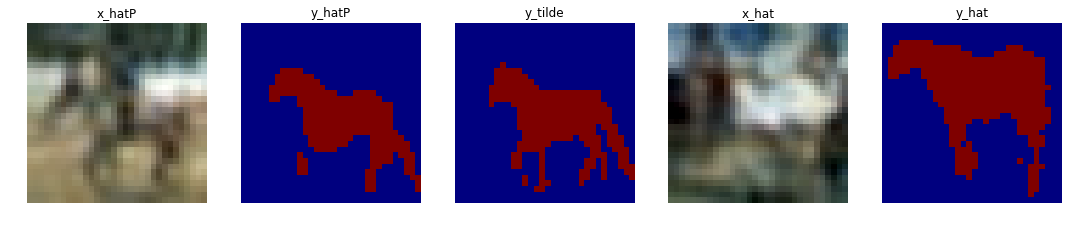

===> End of epoch 16 / 200 	 Time Taken: 16.07 sec

===> Start of epoch 17 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[17/200][0/50] in 0.293s (0.137,0.083,0.073) D/G: 0.166/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.101/0.087 Y2Y/Y2YP: 0.244/0.181 T: 20.379 CE: 0.037 


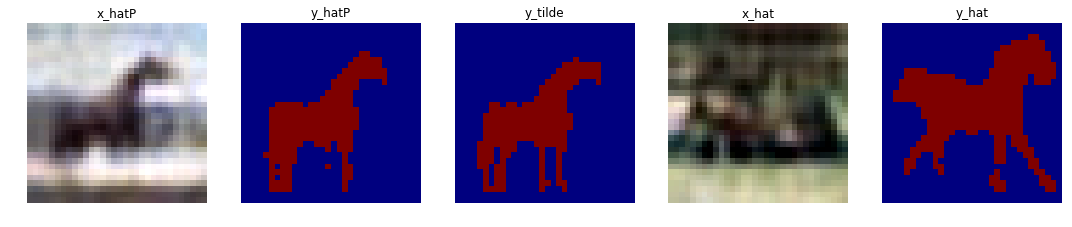

===> End of epoch 17 / 200 	 Time Taken: 16.11 sec

===> Start of epoch 18 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[18/200][0/50] in 0.292s (0.137,0.083,0.072) D/G: 0.163/0.054 DP/GP: 0.166/0.054 X2X/X2XP: 0.109/0.083 Y2Y/Y2YP: 0.226/0.166 T: 29.454 CE: 0.040 


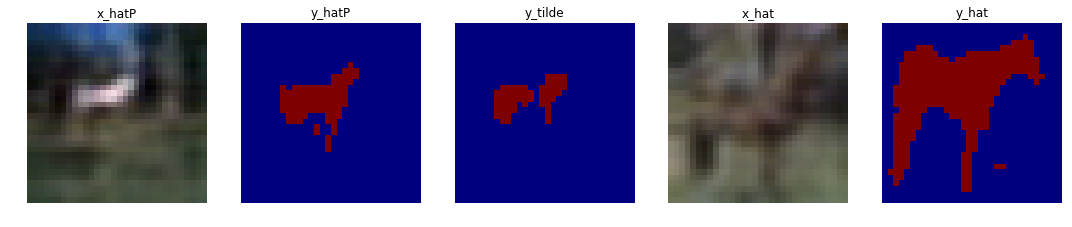

===> End of epoch 18 / 200 	 Time Taken: 15.98 sec

===> Start of epoch 19 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[19/200][0/50] in 0.293s (0.138,0.084,0.072) D/G: 0.166/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.091/0.099 Y2Y/Y2YP: 0.231/0.152 T: 95.305 CE: 0.046 


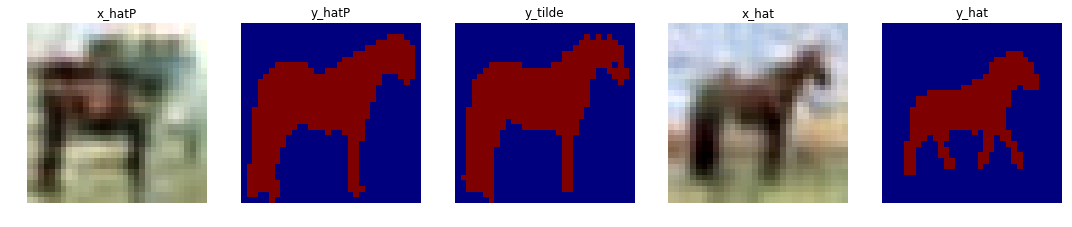

===> End of epoch 19 / 200 	 Time Taken: 16.05 sec

===> Start of epoch 20 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[20/200][0/50] in 1.462s (1.308,0.083,0.071) D/G: 0.166/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.084/0.081 Y2Y/Y2YP: 0.244/0.147 T: 36.214 CE: 0.040 


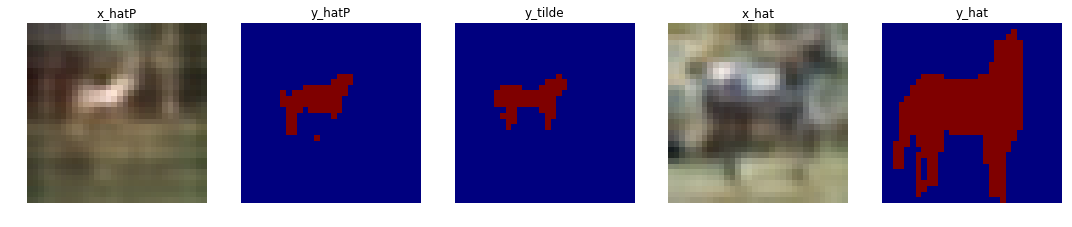

===> End of epoch 20 / 200 	 Time Taken: 17.25 sec

===> Start of epoch 21 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[21/200][0/50] in 0.293s (0.138,0.083,0.072) D/G: 0.166/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.098/0.102 Y2Y/Y2YP: 0.229/0.155 T: 53.016 CE: 0.049 


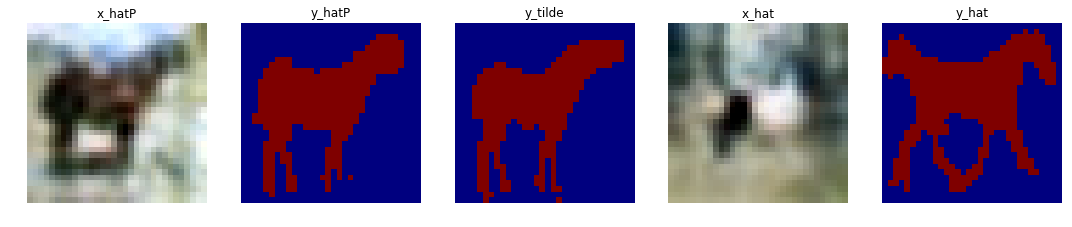

===> End of epoch 21 / 200 	 Time Taken: 16.14 sec

===> Start of epoch 22 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[22/200][0/50] in 0.297s (0.141,0.084,0.073) D/G: 0.166/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.085/0.091 Y2Y/Y2YP: 0.206/0.139 T: 36.336 CE: 0.028 


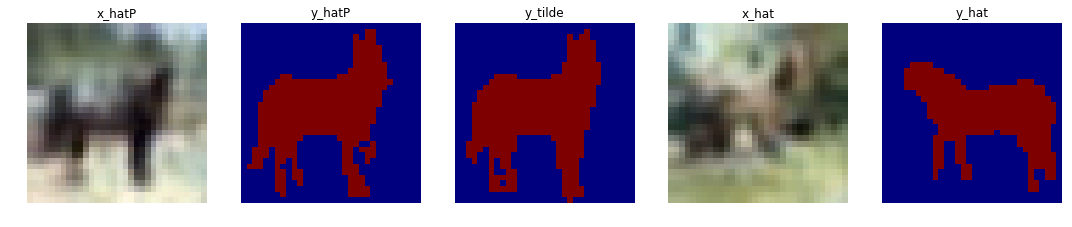

===> End of epoch 22 / 200 	 Time Taken: 16.57 sec

===> Start of epoch 23 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[23/200][0/50] in 0.305s (0.148,0.084,0.073) D/G: 0.166/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.108/0.079 Y2Y/Y2YP: 0.218/0.149 T: 15.175 CE: 0.028 


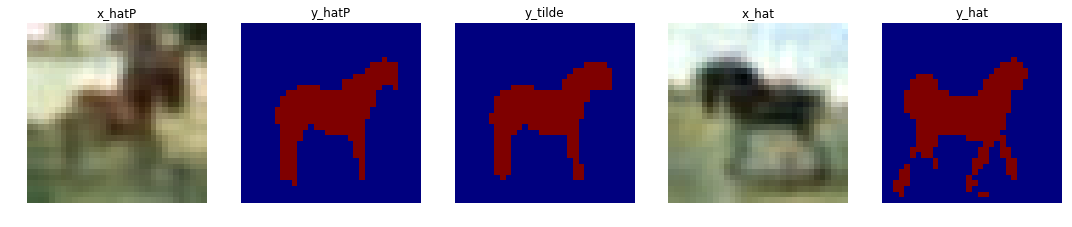

===> End of epoch 23 / 200 	 Time Taken: 16.40 sec

===> Start of epoch 24 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[24/200][0/50] in 0.294s (0.138,0.084,0.072) D/G: 0.166/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.094/0.062 Y2Y/Y2YP: 0.176/0.140 T: 15.176 CE: 0.024 


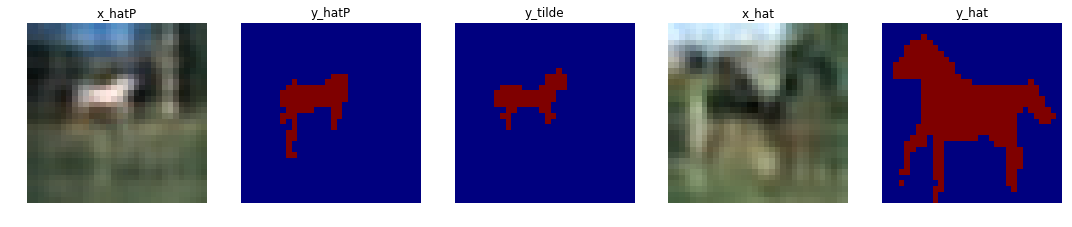

===> End of epoch 24 / 200 	 Time Taken: 16.16 sec

===> Start of epoch 25 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[25/200][0/50] in 0.290s (0.136,0.083,0.071) D/G: 0.166/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.118/0.078 Y2Y/Y2YP: 0.228/0.150 T: 16.611 CE: 0.022 


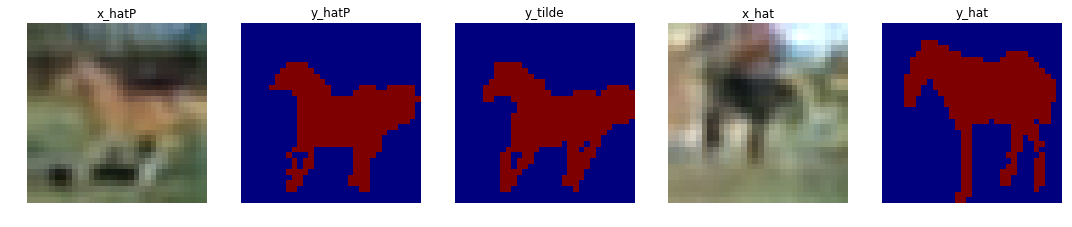

===> End of epoch 25 / 200 	 Time Taken: 15.93 sec

===> Start of epoch 26 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[26/200][0/50] in 0.294s (0.138,0.084,0.073) D/G: 0.166/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.093/0.082 Y2Y/Y2YP: 0.173/0.184 T: 10.129 CE: 0.030 


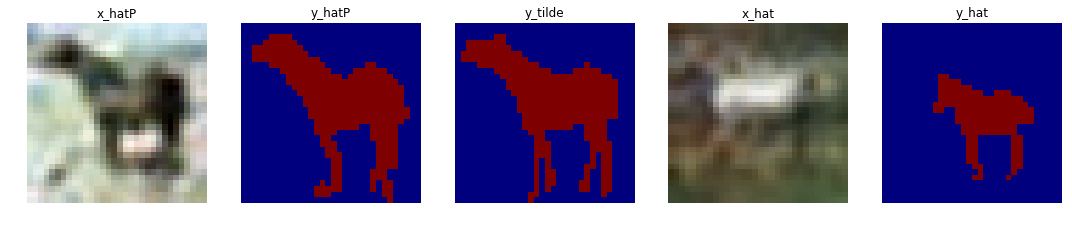

===> End of epoch 26 / 200 	 Time Taken: 16.05 sec

===> Start of epoch 27 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[27/200][0/50] in 0.290s (0.136,0.083,0.072) D/G: 0.001/0.054 DP/GP: 0.001/0.054 X2X/X2XP: 0.079/0.065 Y2Y/Y2YP: 0.177/0.144 T: 11.220 CE: 0.019 


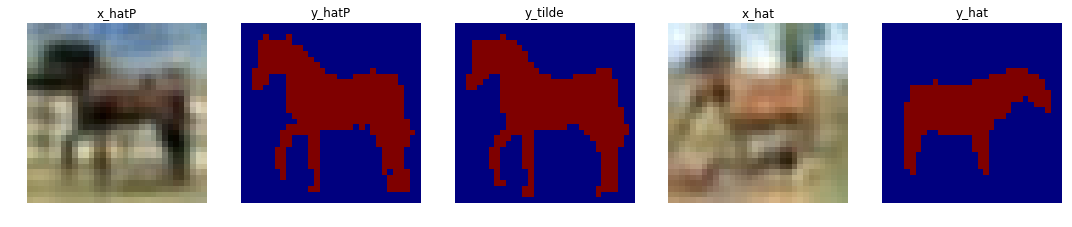

===> End of epoch 27 / 200 	 Time Taken: 16.05 sec

===> Start of epoch 28 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[28/200][0/50] in 0.296s (0.139,0.083,0.074) D/G: 0.165/0.054 DP/GP: 0.166/0.054 X2X/X2XP: 0.087/0.063 Y2Y/Y2YP: 0.216/0.174 T: 15.571 CE: 0.017 


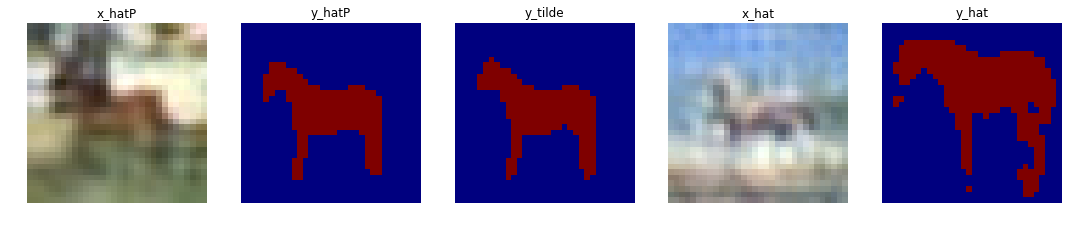

===> End of epoch 28 / 200 	 Time Taken: 15.97 sec

===> Start of epoch 29 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[29/200][0/50] in 0.295s (0.140,0.083,0.072) D/G: 0.166/0.054 DP/GP: 0.166/0.054 X2X/X2XP: 0.088/0.083 Y2Y/Y2YP: 0.216/0.137 T: 63.819 CE: 0.024 


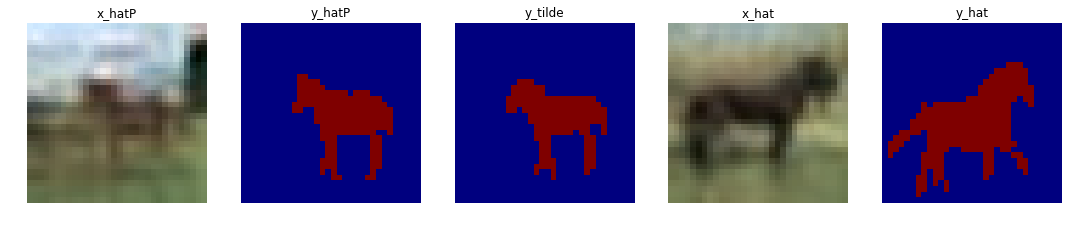

===> End of epoch 29 / 200 	 Time Taken: 16.14 sec

===> Start of epoch 30 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[30/200][0/50] in 2.006s (1.852,0.084,0.070) D/G: 0.166/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.133/0.179 Y2Y/Y2YP: 0.248/0.177 T: 1704.730 CE: 0.576 


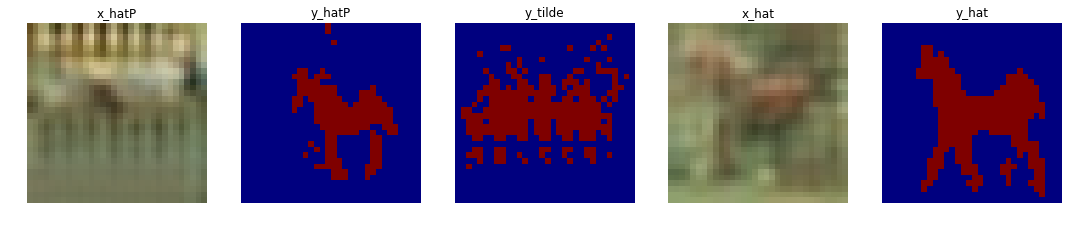

===> End of epoch 30 / 200 	 Time Taken: 17.83 sec

===> Start of epoch 31 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[31/200][0/50] in 0.280s (0.130,0.080,0.071) D/G: 0.166/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.088/0.072 Y2Y/Y2YP: 0.174/0.129 T: 9.563 CE: 0.029 


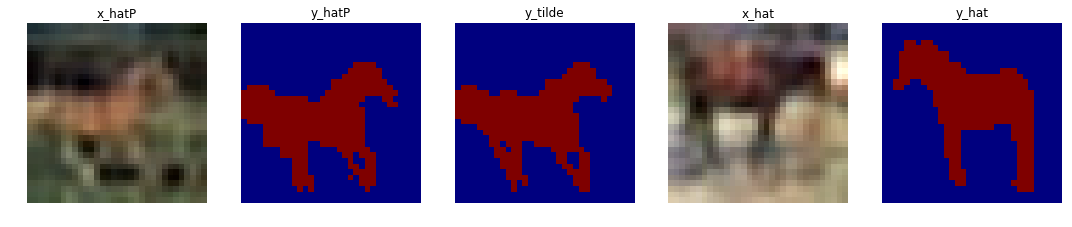

===> End of epoch 31 / 200 	 Time Taken: 15.95 sec

===> Start of epoch 32 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[32/200][0/50] in 0.281s (0.130,0.081,0.069) D/G: 0.166/0.055 DP/GP: 0.166/-0.110 X2X/X2XP: 0.092/0.068 Y2Y/Y2YP: 0.175/0.136 T: 4.232 CE: 0.016 


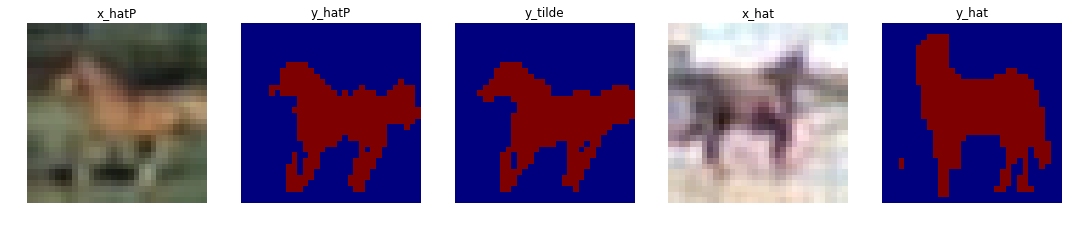

===> End of epoch 32 / 200 	 Time Taken: 16.15 sec

===> Start of epoch 33 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[33/200][0/50] in 0.288s (0.136,0.081,0.070) D/G: 0.165/0.054 DP/GP: 0.167/-0.013 X2X/X2XP: 0.086/0.087 Y2Y/Y2YP: 0.202/0.139 T: 14.572 CE: 0.068 


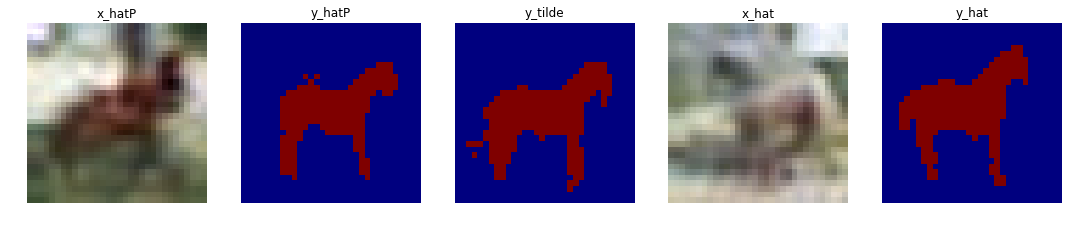

===> End of epoch 33 / 200 	 Time Taken: 15.65 sec

===> Start of epoch 34 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[34/200][0/50] in 0.287s (0.136,0.081,0.070) D/G: 0.165/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.086/0.070 Y2Y/Y2YP: 0.190/0.118 T: 11.976 CE: 0.015 


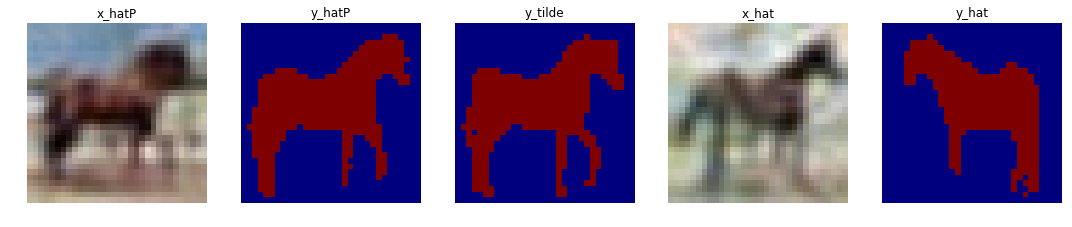

===> End of epoch 34 / 200 	 Time Taken: 16.48 sec

===> Start of epoch 35 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[35/200][0/50] in 0.281s (0.130,0.081,0.070) D/G: 0.166/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.086/0.075 Y2Y/Y2YP: 0.186/0.141 T: 7.559 CE: 0.023 


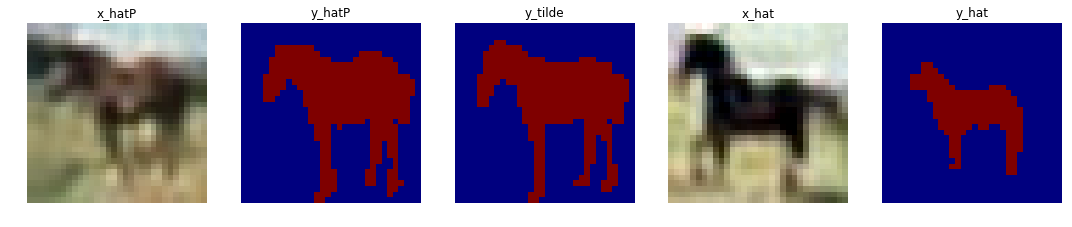

===> End of epoch 35 / 200 	 Time Taken: 16.01 sec

===> Start of epoch 36 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[36/200][0/50] in 0.291s (0.138,0.083,0.070) D/G: 0.000/0.054 DP/GP: -0.000/-0.111 X2X/X2XP: 0.101/0.068 Y2Y/Y2YP: 0.221/0.117 T: 19.539 CE: 0.018 


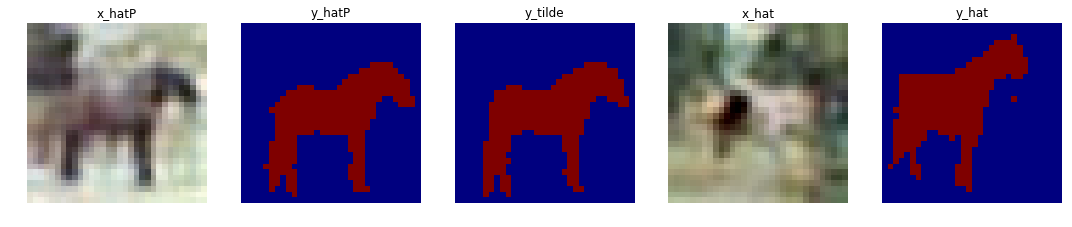

===> End of epoch 36 / 200 	 Time Taken: 15.97 sec

===> Start of epoch 37 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[37/200][0/50] in 0.283s (0.131,0.082,0.070) D/G: 0.166/0.044 DP/GP: 0.166/0.055 X2X/X2XP: 0.074/0.070 Y2Y/Y2YP: 0.206/0.145 T: 8.445 CE: 0.010 


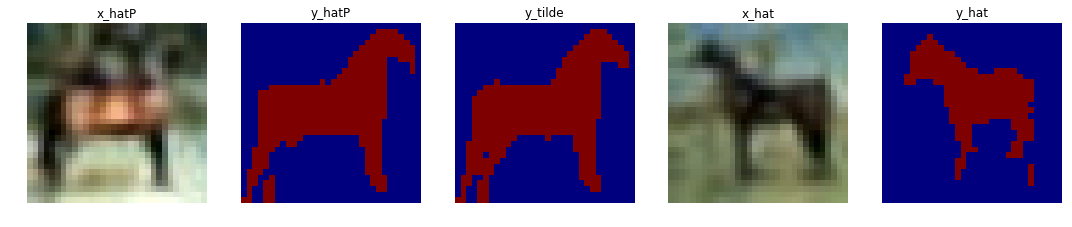

===> End of epoch 37 / 200 	 Time Taken: 16.30 sec

===> Start of epoch 38 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[38/200][0/50] in 0.308s (0.146,0.086,0.077) D/G: 0.167/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.099/0.071 Y2Y/Y2YP: 0.225/0.115 T: 5.849 CE: 0.014 


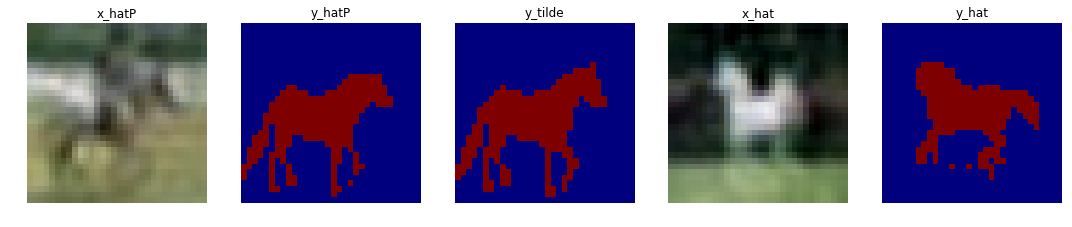

===> End of epoch 38 / 200 	 Time Taken: 16.62 sec

===> Start of epoch 39 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[39/200][0/50] in 0.283s (0.129,0.082,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.089/0.064 Y2Y/Y2YP: 0.208/0.124 T: 6.967 CE: 0.010 


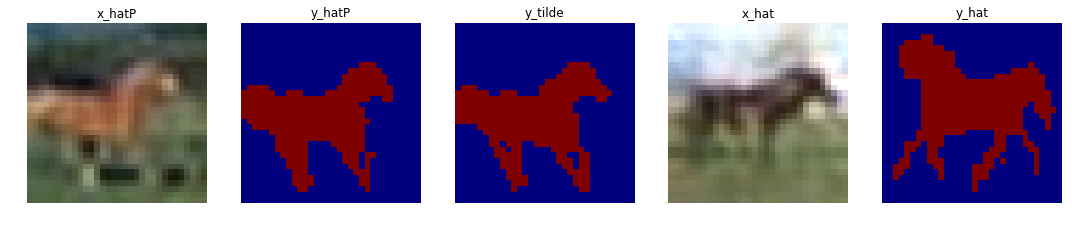

===> End of epoch 39 / 200 	 Time Taken: 16.24 sec

===> Start of epoch 40 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[40/200][0/50] in 1.450s (1.297,0.082,0.070) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.082/0.068 Y2Y/Y2YP: 0.182/0.125 T: 9.944 CE: 0.016 


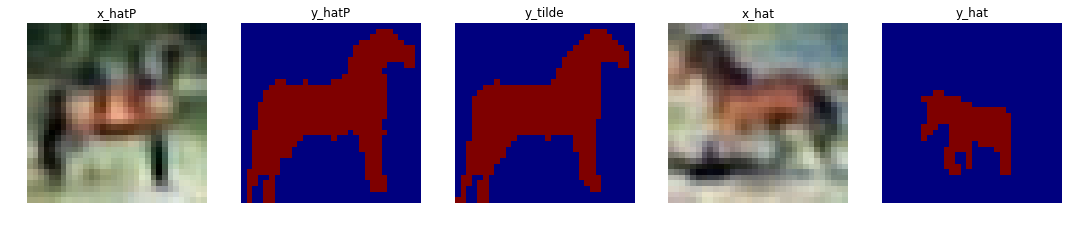

===> End of epoch 40 / 200 	 Time Taken: 16.98 sec

===> Start of epoch 41 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[41/200][0/50] in 0.301s (0.145,0.084,0.072) D/G: 0.001/-0.098 DP/GP: 0.000/0.055 X2X/X2XP: 0.091/0.083 Y2Y/Y2YP: 0.167/0.155 T: 5.912 CE: 0.018 


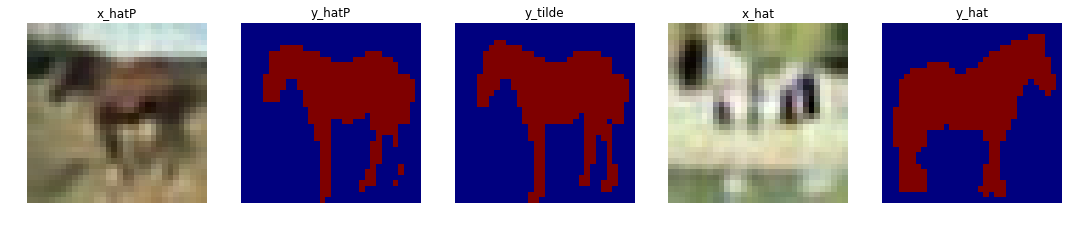

===> End of epoch 41 / 200 	 Time Taken: 15.90 sec

===> Start of epoch 42 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[42/200][0/50] in 0.296s (0.143,0.082,0.071) D/G: 0.167/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.122/0.064 Y2Y/Y2YP: 0.216/0.121 T: 9.254 CE: 0.010 


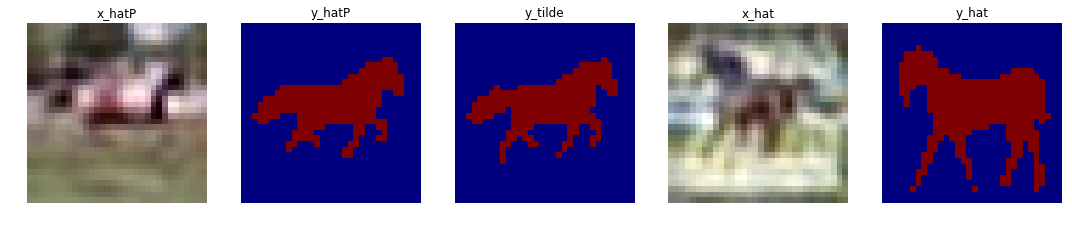

===> End of epoch 42 / 200 	 Time Taken: 16.30 sec

===> Start of epoch 43 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[43/200][0/50] in 0.292s (0.139,0.082,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.081/0.079 Y2Y/Y2YP: 0.179/0.110 T: 5.405 CE: 0.008 


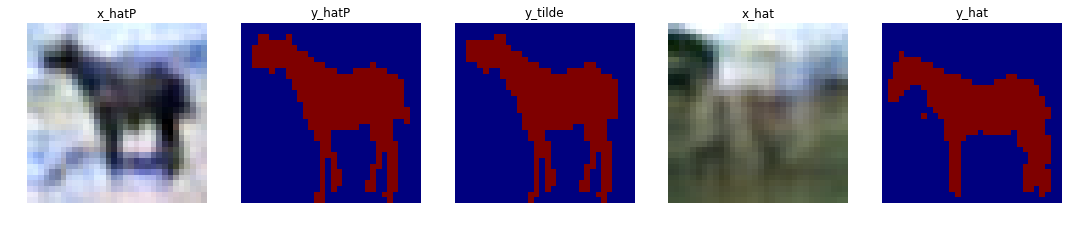

===> End of epoch 43 / 200 	 Time Taken: 16.04 sec

===> Start of epoch 44 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[44/200][0/50] in 0.295s (0.142,0.082,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.063/0.068 Y2Y/Y2YP: 0.165/0.105 T: 12.137 CE: 0.013 


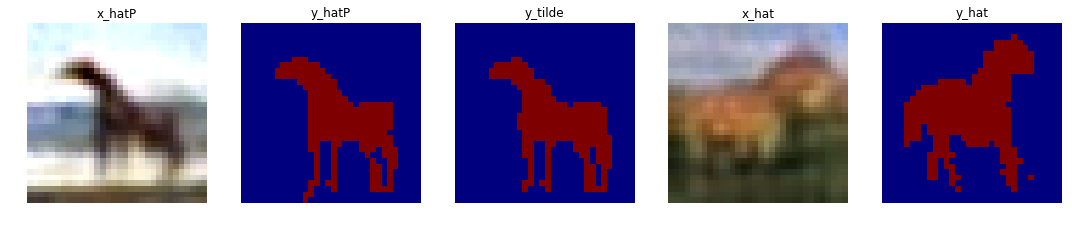

===> End of epoch 44 / 200 	 Time Taken: 15.95 sec

===> Start of epoch 45 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[45/200][0/50] in 0.297s (0.142,0.083,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.102/0.063 Y2Y/Y2YP: 0.215/0.107 T: 4.386 CE: 0.009 


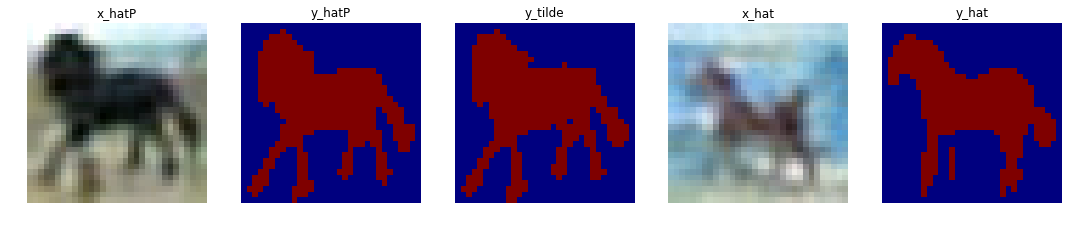

===> End of epoch 45 / 200 	 Time Taken: 15.87 sec

===> Start of epoch 46 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[46/200][0/50] in 0.296s (0.143,0.082,0.071) D/G: 0.167/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.088/0.074 Y2Y/Y2YP: 0.204/0.109 T: 4.225 CE: 0.017 


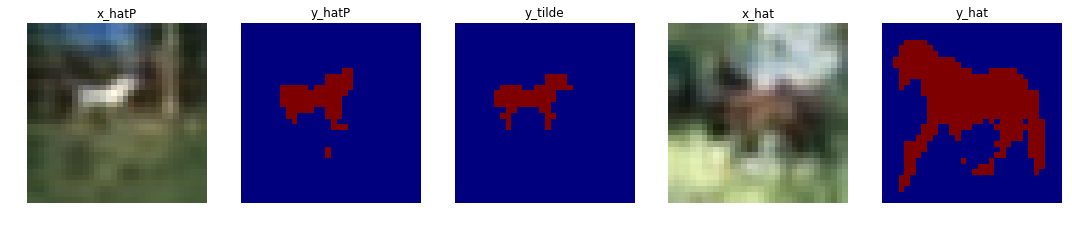

===> End of epoch 46 / 200 	 Time Taken: 16.20 sec

===> Start of epoch 47 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[47/200][0/50] in 0.296s (0.142,0.082,0.072) D/G: 0.167/0.055 DP/GP: 0.017/0.054 X2X/X2XP: 0.083/0.065 Y2Y/Y2YP: 0.174/0.154 T: 9.872 CE: 0.197 


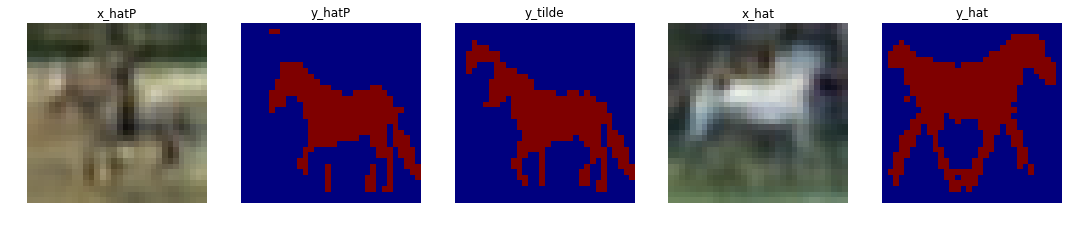

===> End of epoch 47 / 200 	 Time Taken: 15.83 sec

===> Start of epoch 48 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[48/200][0/50] in 0.296s (0.142,0.082,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.088/0.062 Y2Y/Y2YP: 0.205/0.108 T: 6.631 CE: 0.011 


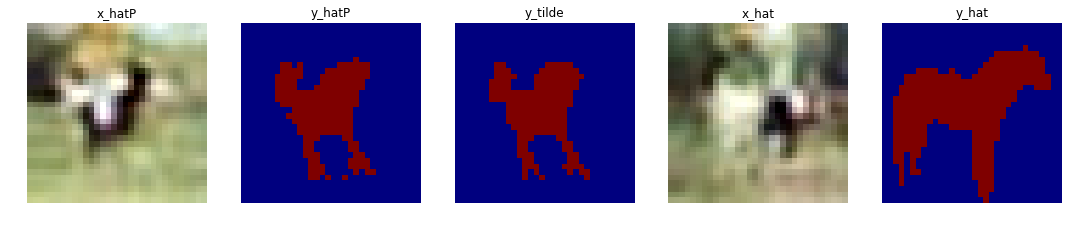

===> End of epoch 48 / 200 	 Time Taken: 16.05 sec

===> Start of epoch 49 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[49/200][0/50] in 0.292s (0.137,0.083,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.090/0.069 Y2Y/Y2YP: 0.162/0.109 T: 10.928 CE: 0.009 


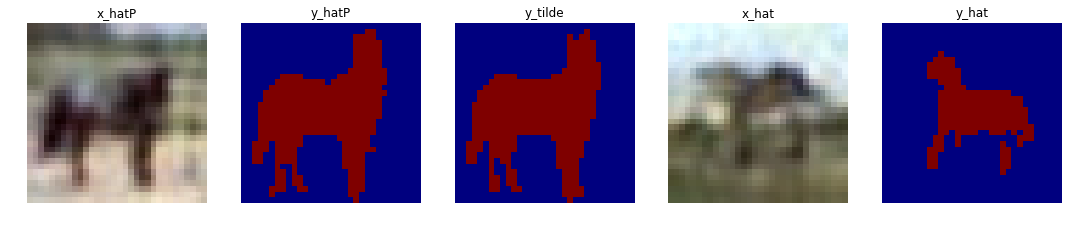

===> End of epoch 49 / 200 	 Time Taken: 15.99 sec

===> Start of epoch 50 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[50/200][0/50] in 1.485s (1.331,0.083,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.079/0.070 Y2Y/Y2YP: 0.208/0.118 T: 23.938 CE: 0.053 


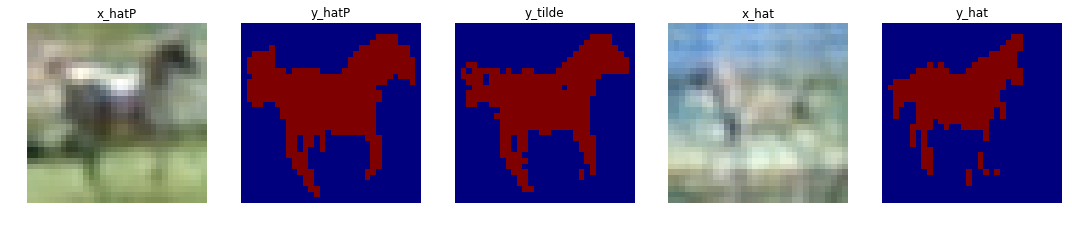

===> End of epoch 50 / 200 	 Time Taken: 17.46 sec

===> Start of epoch 51 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[51/200][0/50] in 0.299s (0.143,0.084,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.080/0.071 Y2Y/Y2YP: 0.207/0.115 T: 9.450 CE: 0.009 


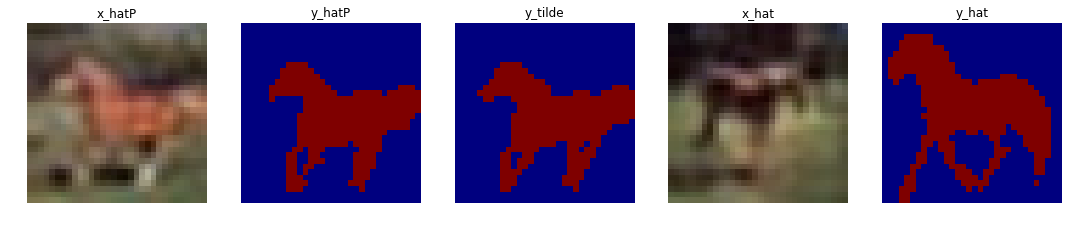

===> End of epoch 51 / 200 	 Time Taken: 15.96 sec

===> Start of epoch 52 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[52/200][0/50] in 0.321s (0.142,0.096,0.082) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.112/0.113 Y2Y/Y2YP: 0.243/0.122 T: 138.999 CE: 0.396 


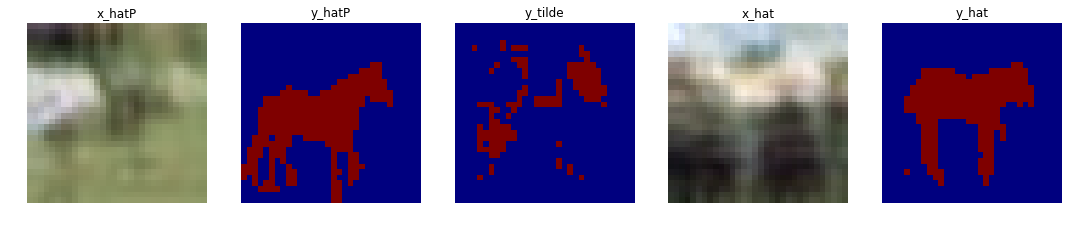

===> End of epoch 52 / 200 	 Time Taken: 16.31 sec

===> Start of epoch 53 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[53/200][0/50] in 0.292s (0.138,0.082,0.071) D/G: 0.167/0.054 DP/GP: 0.167/0.055 X2X/X2XP: 0.093/0.092 Y2Y/Y2YP: 0.210/0.127 T: 18.728 CE: 0.083 


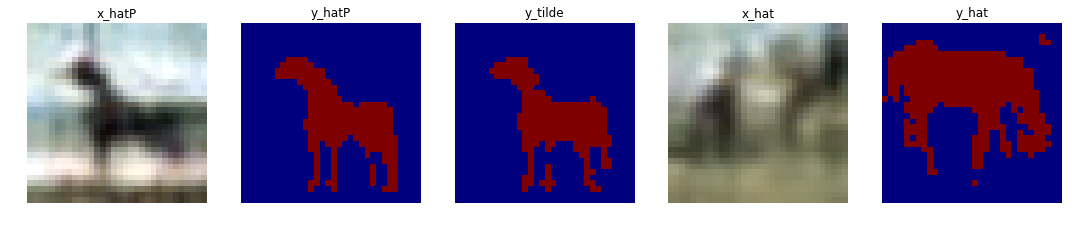

===> End of epoch 53 / 200 	 Time Taken: 16.04 sec

===> Start of epoch 54 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[54/200][0/50] in 0.292s (0.137,0.083,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.105/0.075 Y2Y/Y2YP: 0.185/0.125 T: 8.093 CE: 0.047 


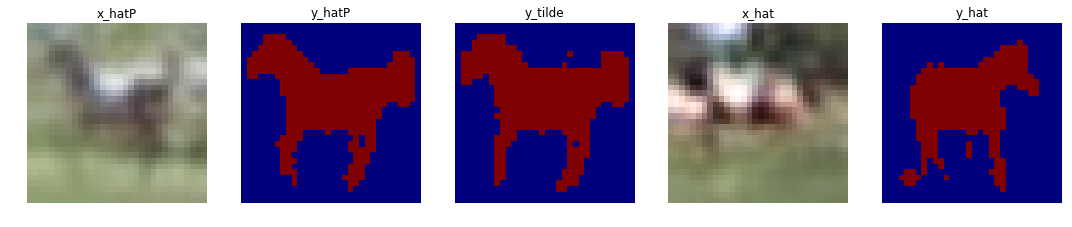

===> End of epoch 54 / 200 	 Time Taken: 15.90 sec

===> Start of epoch 55 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[55/200][0/50] in 0.293s (0.138,0.083,0.073) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.108/0.080 Y2Y/Y2YP: 0.171/0.110 T: 10.699 CE: 0.030 


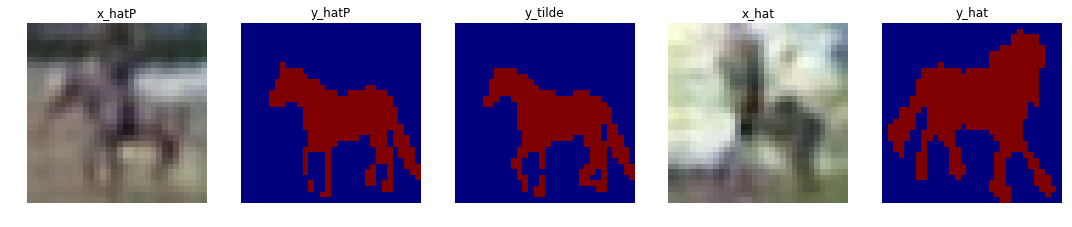

===> End of epoch 55 / 200 	 Time Taken: 16.17 sec

===> Start of epoch 56 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[56/200][0/50] in 0.292s (0.140,0.081,0.070) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.096/0.059 Y2Y/Y2YP: 0.168/0.101 T: 5.407 CE: 0.014 


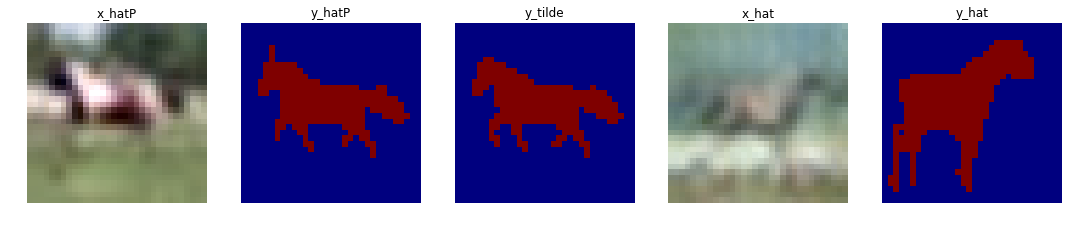

===> End of epoch 56 / 200 	 Time Taken: 15.94 sec

===> Start of epoch 57 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[57/200][0/50] in 0.295s (0.140,0.083,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.110/0.086 Y2Y/Y2YP: 0.188/0.124 T: 6.933 CE: 0.019 


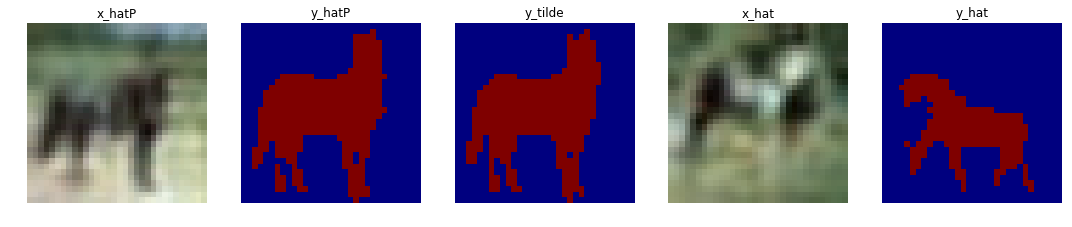

===> End of epoch 57 / 200 	 Time Taken: 16.09 sec

===> Start of epoch 58 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[58/200][0/50] in 0.293s (0.137,0.083,0.072) D/G: 0.036/0.049 DP/GP: 0.143/0.033 X2X/X2XP: 0.077/0.083 Y2Y/Y2YP: 0.182/0.127 T: 11.202 CE: 0.021 


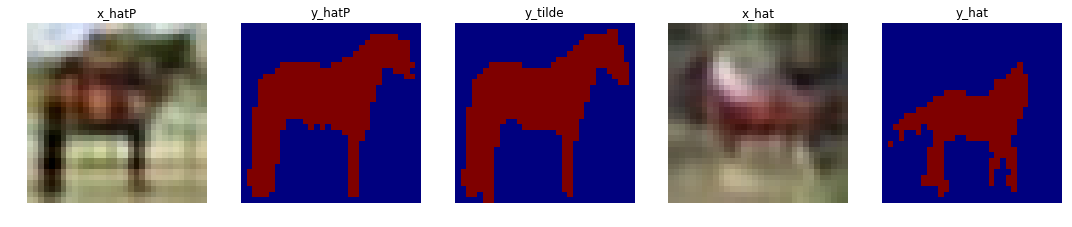

===> End of epoch 58 / 200 	 Time Taken: 16.06 sec

===> Start of epoch 59 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[59/200][0/50] in 0.298s (0.143,0.083,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.093/0.071 Y2Y/Y2YP: 0.151/0.117 T: 2.855 CE: 0.009 


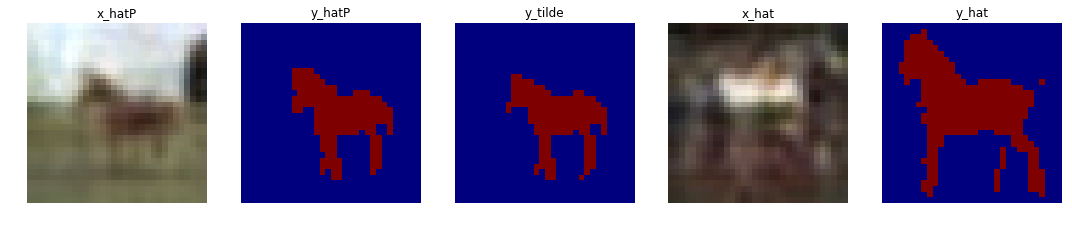

===> End of epoch 59 / 200 	 Time Taken: 16.00 sec

===> Start of epoch 60 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[60/200][0/50] in 2.195s (2.041,0.084,0.070) D/G: 0.167/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.084/0.059 Y2Y/Y2YP: 0.170/0.106 T: 2.687 CE: 0.008 


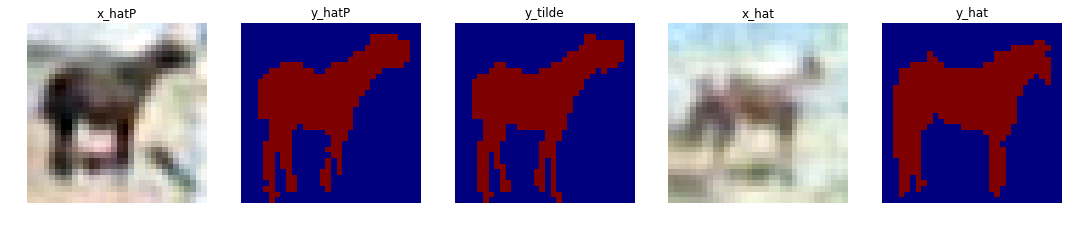

===> End of epoch 60 / 200 	 Time Taken: 17.60 sec

===> Start of epoch 61 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[61/200][0/50] in 0.294s (0.142,0.082,0.070) D/G: 0.167/0.054 DP/GP: 0.165/0.055 X2X/X2XP: 0.085/0.067 Y2Y/Y2YP: 0.192/0.101 T: 3.131 CE: 0.005 


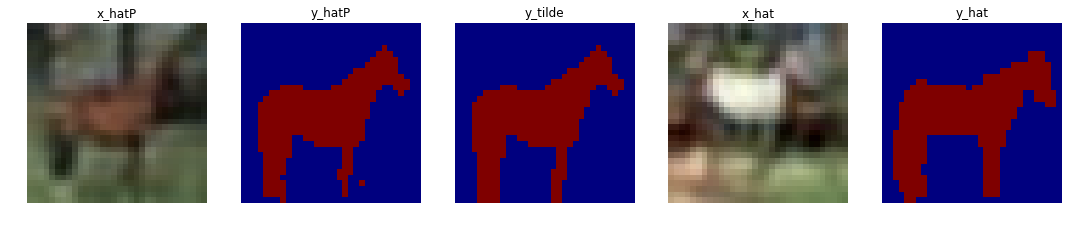

===> End of epoch 61 / 200 	 Time Taken: 16.01 sec

===> Start of epoch 62 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[62/200][0/50] in 0.290s (0.137,0.082,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.110/0.061 Y2Y/Y2YP: 0.211/0.093 T: 2.460 CE: 0.011 


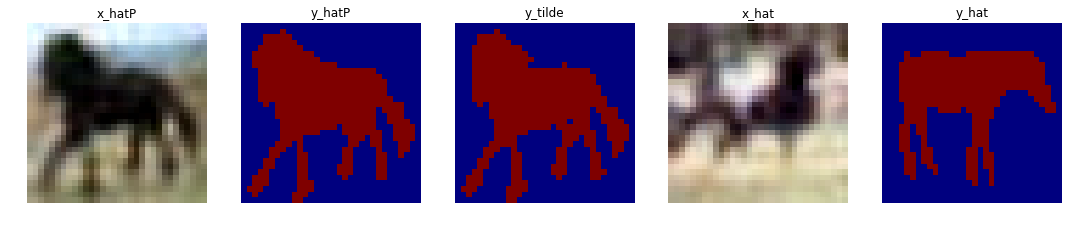

===> End of epoch 62 / 200 	 Time Taken: 16.32 sec

===> Start of epoch 63 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[63/200][0/50] in 0.293s (0.139,0.083,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.102/0.064 Y2Y/Y2YP: 0.178/0.104 T: 2.903 CE: 0.006 


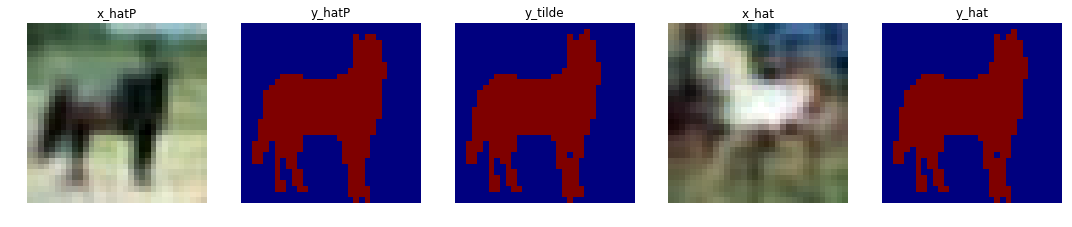

===> End of epoch 63 / 200 	 Time Taken: 16.04 sec

===> Start of epoch 64 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[64/200][0/50] in 0.285s (0.133,0.081,0.070) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.081/0.075 Y2Y/Y2YP: 0.186/0.115 T: 2.312 CE: 0.009 


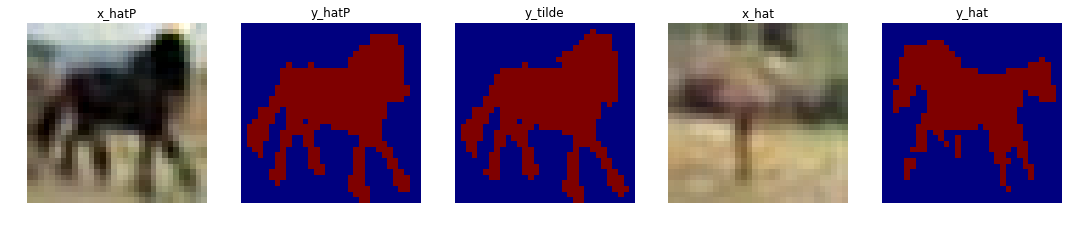

===> End of epoch 64 / 200 	 Time Taken: 16.38 sec

===> Start of epoch 65 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[65/200][0/50] in 0.286s (0.133,0.081,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.079/0.061 Y2Y/Y2YP: 0.180/0.096 T: 2.123 CE: 0.006 


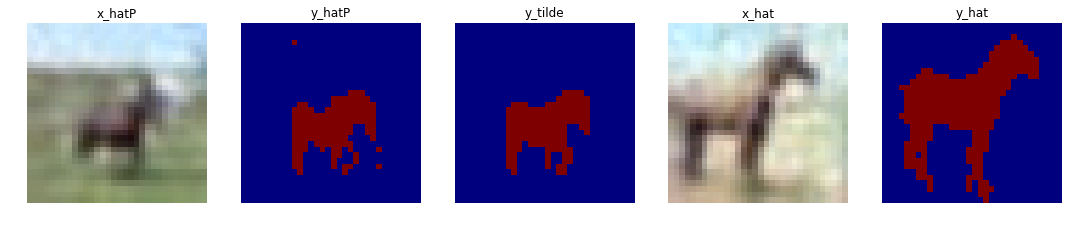

===> End of epoch 65 / 200 	 Time Taken: 16.02 sec

===> Start of epoch 66 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[66/200][0/50] in 0.291s (0.141,0.081,0.070) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.091/0.073 Y2Y/Y2YP: 0.198/0.110 T: 5.046 CE: 0.007 


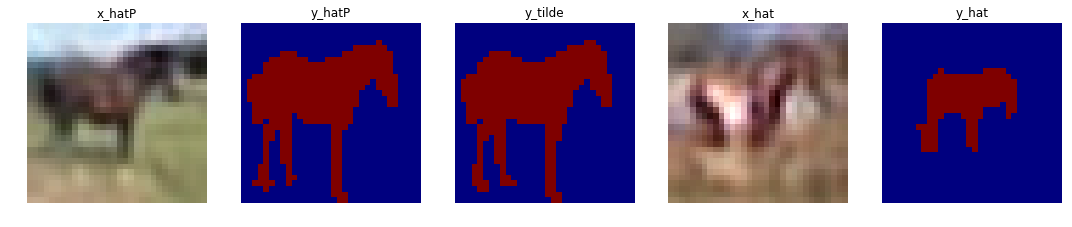

===> End of epoch 66 / 200 	 Time Taken: 15.90 sec

===> Start of epoch 67 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[67/200][0/50] in 0.295s (0.143,0.082,0.071) D/G: 0.166/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.094/0.061 Y2Y/Y2YP: 0.150/0.094 T: 3.203 CE: 0.026 


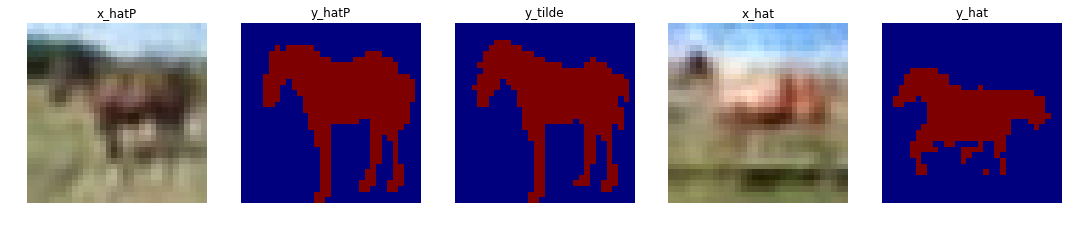

===> End of epoch 67 / 200 	 Time Taken: 15.95 sec

===> Start of epoch 68 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[68/200][0/50] in 0.282s (0.132,0.081,0.070) D/G: 0.167/0.049 DP/GP: 0.167/0.055 X2X/X2XP: 0.097/0.064 Y2Y/Y2YP: 0.210/0.094 T: 1.969 CE: 0.004 


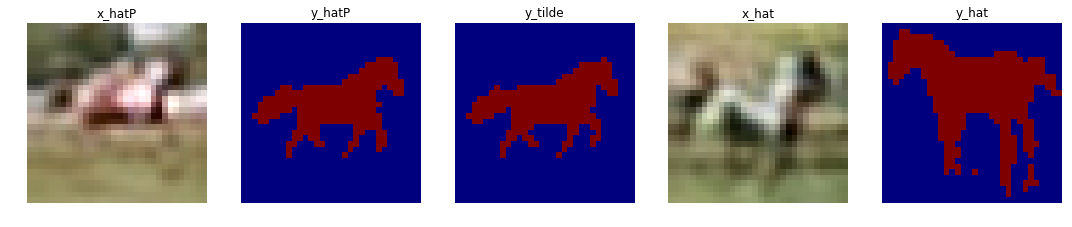

===> End of epoch 68 / 200 	 Time Taken: 16.08 sec

===> Start of epoch 69 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[69/200][0/50] in 0.293s (0.139,0.083,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.112/0.095 Y2Y/Y2YP: 0.198/0.109 T: 33.050 CE: 0.415 


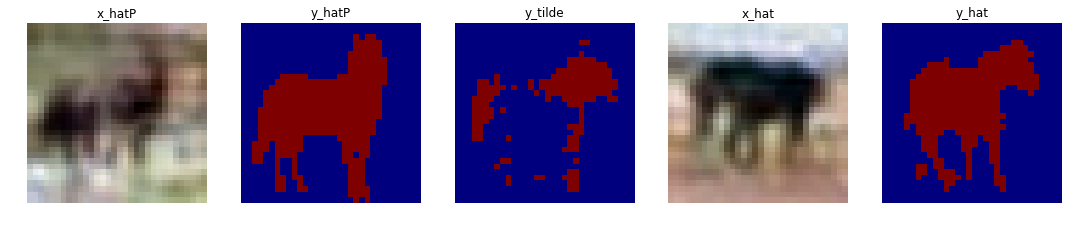

===> End of epoch 69 / 200 	 Time Taken: 16.18 sec

===> Start of epoch 70 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[70/200][0/50] in 1.471s (1.317,0.083,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.069/0.061 Y2Y/Y2YP: 0.161/0.120 T: 3.074 CE: 0.007 


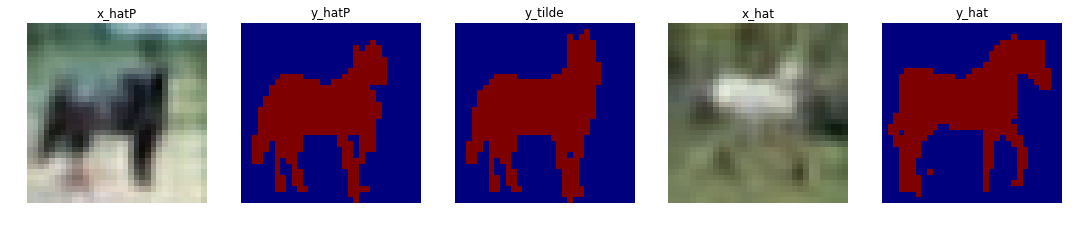

===> End of epoch 70 / 200 	 Time Taken: 17.13 sec

===> Start of epoch 71 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[71/200][0/50] in 0.297s (0.143,0.083,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.091/0.066 Y2Y/Y2YP: 0.180/0.108 T: 2.138 CE: 0.005 


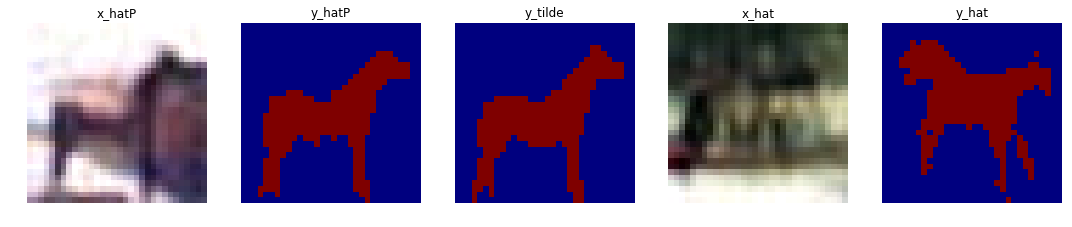

===> End of epoch 71 / 200 	 Time Taken: 15.91 sec

===> Start of epoch 72 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[72/200][0/50] in 0.294s (0.139,0.083,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.084/0.057 Y2Y/Y2YP: 0.172/0.089 T: 2.768 CE: 0.003 


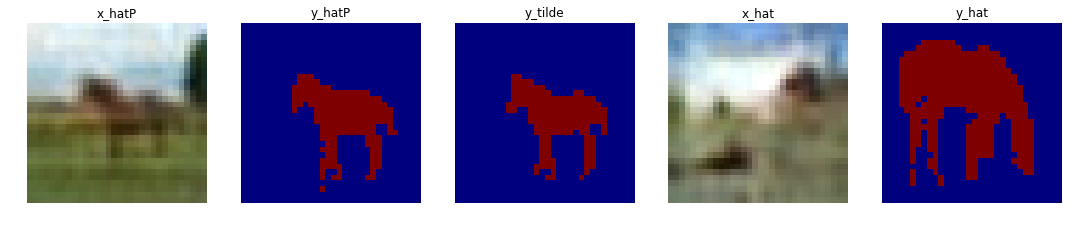

===> End of epoch 72 / 200 	 Time Taken: 16.20 sec

===> Start of epoch 73 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[73/200][0/50] in 0.293s (0.138,0.083,0.072) D/G: 0.167/0.055 DP/GP: 0.166/0.054 X2X/X2XP: 0.081/0.071 Y2Y/Y2YP: 0.193/0.096 T: 8.372 CE: 0.060 


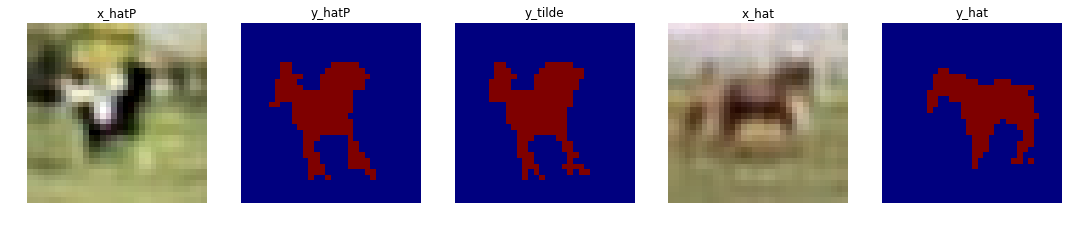

===> End of epoch 73 / 200 	 Time Taken: 16.04 sec

===> Start of epoch 74 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[74/200][0/50] in 0.293s (0.138,0.083,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.088/0.068 Y2Y/Y2YP: 0.195/0.097 T: 11.067 CE: 0.031 


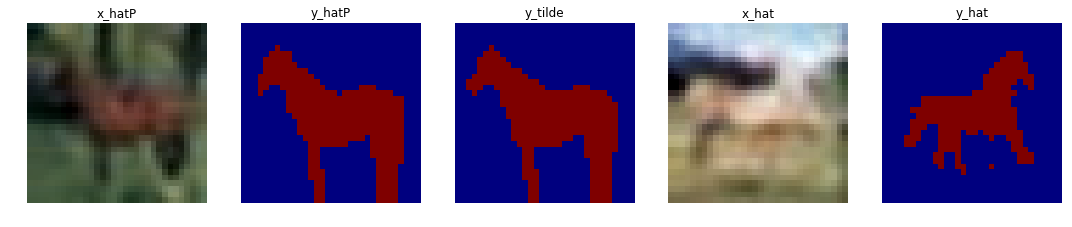

===> End of epoch 74 / 200 	 Time Taken: 16.19 sec

===> Start of epoch 75 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[75/200][0/50] in 0.297s (0.143,0.082,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.110/0.054 Y2Y/Y2YP: 0.240/0.105 T: 2.148 CE: 0.005 


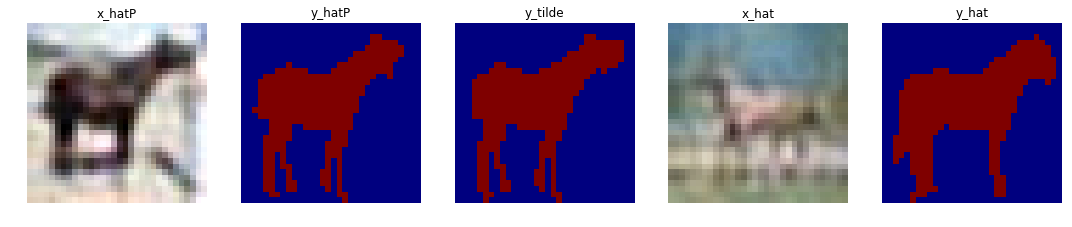

===> End of epoch 75 / 200 	 Time Taken: 15.99 sec

===> Start of epoch 76 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[76/200][0/50] in 0.293s (0.139,0.083,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.078/0.058 Y2Y/Y2YP: 0.183/0.094 T: 2.177 CE: 0.006 


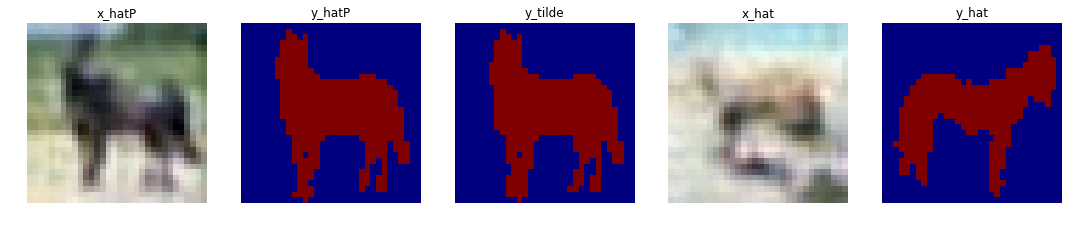

===> End of epoch 76 / 200 	 Time Taken: 16.27 sec

===> Start of epoch 77 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[77/200][0/50] in 0.291s (0.137,0.083,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.076/0.063 Y2Y/Y2YP: 0.167/0.109 T: 2.776 CE: 0.004 


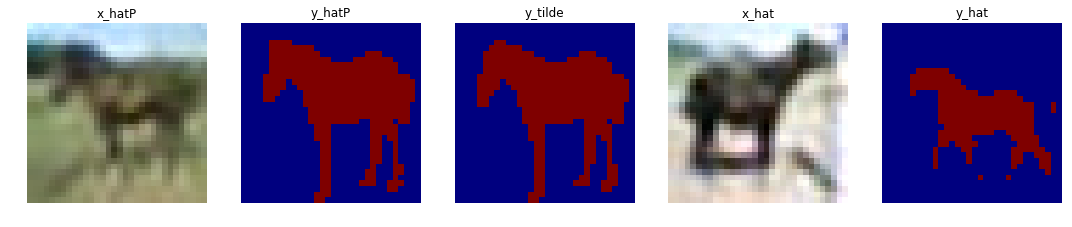

===> End of epoch 77 / 200 	 Time Taken: 16.11 sec

===> Start of epoch 78 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[78/200][0/50] in 0.294s (0.139,0.083,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.080/0.059 Y2Y/Y2YP: 0.169/0.095 T: 2.193 CE: 0.005 


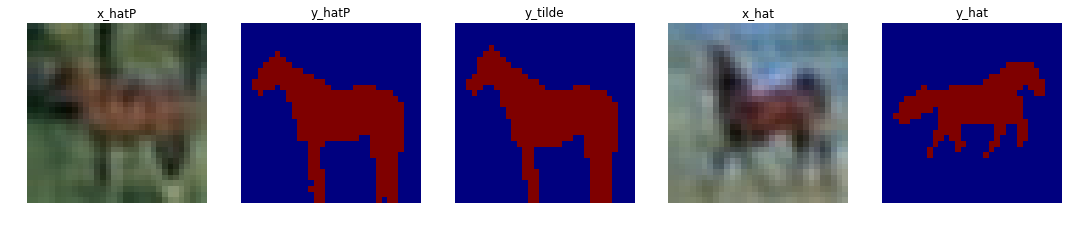

===> End of epoch 78 / 200 	 Time Taken: 16.00 sec

===> Start of epoch 79 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[79/200][0/50] in 0.291s (0.136,0.082,0.073) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.089/0.055 Y2Y/Y2YP: 0.222/0.109 T: 2.062 CE: 0.004 


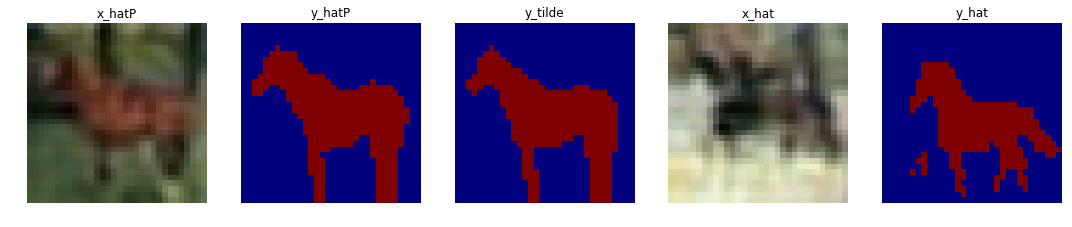

===> End of epoch 79 / 200 	 Time Taken: 16.04 sec

===> Start of epoch 80 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[80/200][0/50] in 1.477s (1.322,0.083,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.099/0.054 Y2Y/Y2YP: 0.152/0.086 T: 2.437 CE: 0.003 


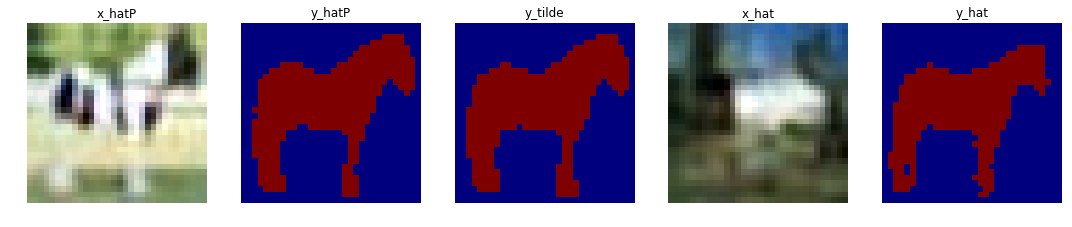

===> End of epoch 80 / 200 	 Time Taken: 17.21 sec

===> Start of epoch 81 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[81/200][0/50] in 0.292s (0.137,0.083,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.075/0.056 Y2Y/Y2YP: 0.140/0.085 T: 2.058 CE: 0.002 


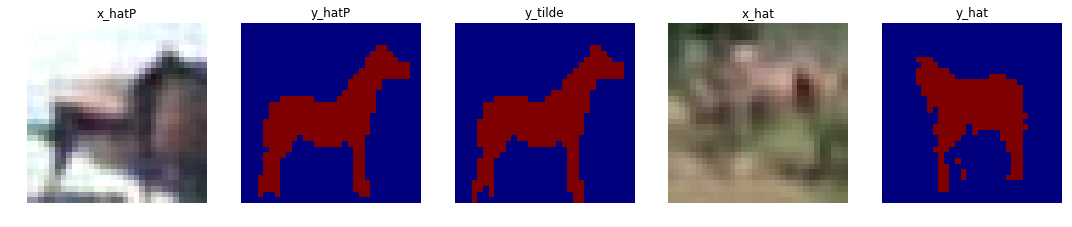

===> End of epoch 81 / 200 	 Time Taken: 16.13 sec

===> Start of epoch 82 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[82/200][0/50] in 0.303s (0.143,0.085,0.075) D/G: 0.000/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.075/0.056 Y2Y/Y2YP: 0.191/0.093 T: 1.837 CE: 0.003 


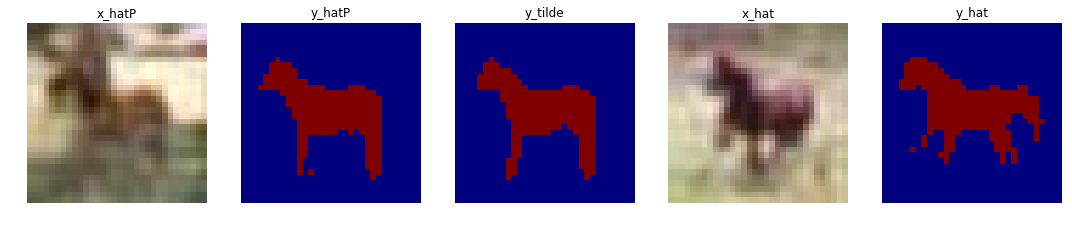

===> End of epoch 82 / 200 	 Time Taken: 16.03 sec

===> Start of epoch 83 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[83/200][0/50] in 0.294s (0.137,0.084,0.073) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.072/0.054 Y2Y/Y2YP: 0.159/0.070 T: 5.012 CE: 0.003 


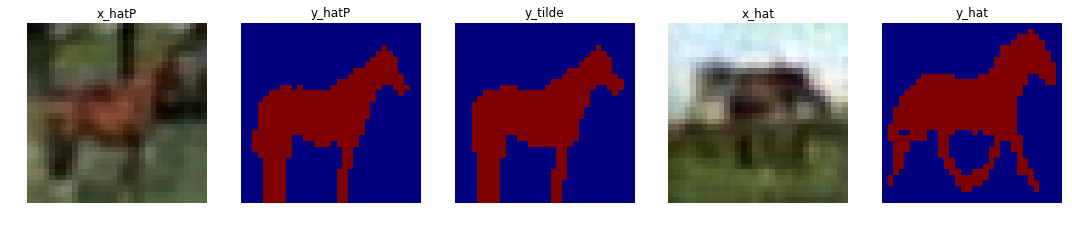

===> End of epoch 83 / 200 	 Time Taken: 16.13 sec

===> Start of epoch 84 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[84/200][0/50] in 0.295s (0.138,0.084,0.073) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.087/0.053 Y2Y/Y2YP: 0.194/0.075 T: 2.872 CE: 0.006 


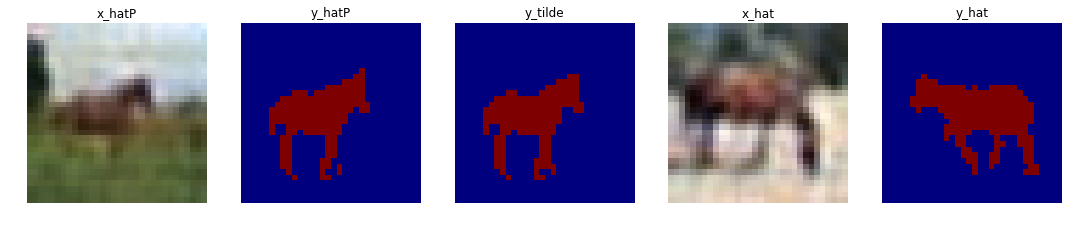

===> End of epoch 84 / 200 	 Time Taken: 16.08 sec

===> Start of epoch 85 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[85/200][0/50] in 0.295s (0.140,0.083,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.085/0.059 Y2Y/Y2YP: 0.181/0.086 T: 4.077 CE: 0.008 


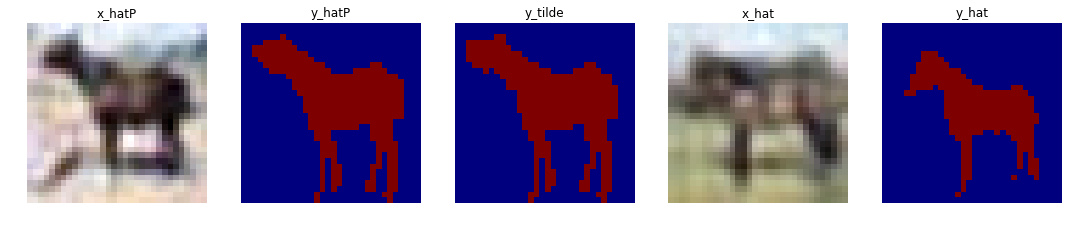

===> End of epoch 85 / 200 	 Time Taken: 15.99 sec

===> Start of epoch 86 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[86/200][0/50] in 0.299s (0.144,0.083,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.077/0.064 Y2Y/Y2YP: 0.164/0.081 T: 1.950 CE: 0.003 


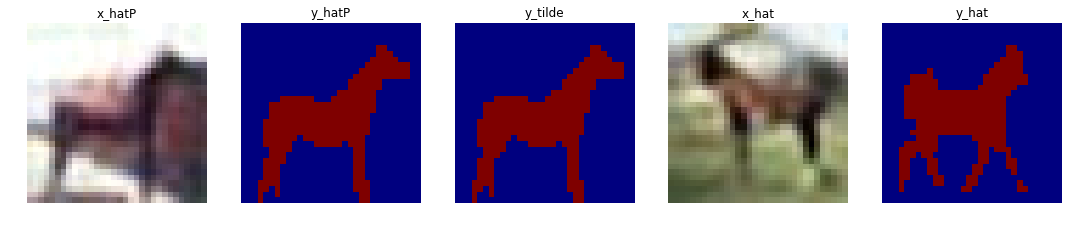

===> End of epoch 86 / 200 	 Time Taken: 16.06 sec

===> Start of epoch 87 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[87/200][0/50] in 0.297s (0.143,0.083,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.072/0.056 Y2Y/Y2YP: 0.206/0.087 T: 1.708 CE: 0.004 


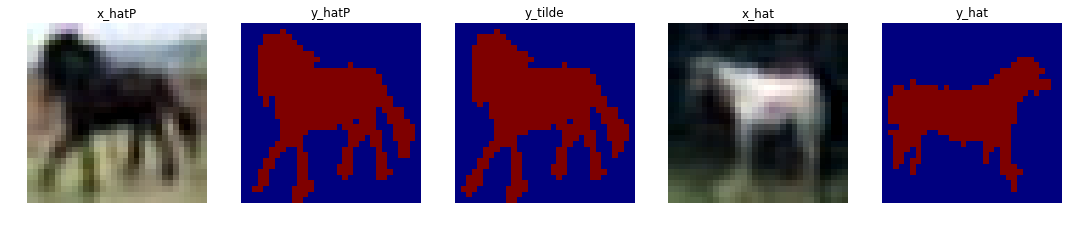

===> End of epoch 87 / 200 	 Time Taken: 16.16 sec

===> Start of epoch 88 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[88/200][0/50] in 0.297s (0.142,0.083,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.082/0.063 Y2Y/Y2YP: 0.201/0.089 T: 2.910 CE: 0.002 


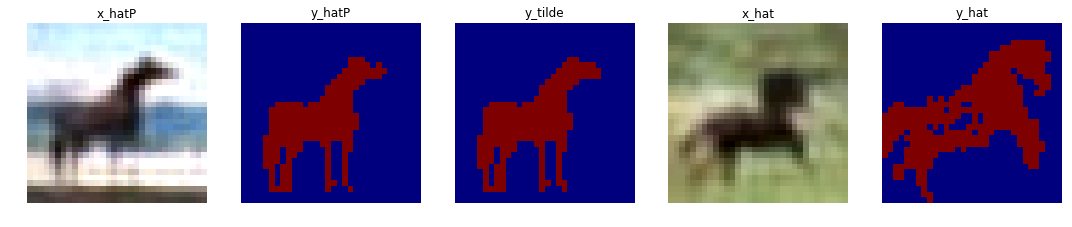

===> End of epoch 88 / 200 	 Time Taken: 16.04 sec

===> Start of epoch 89 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[89/200][0/50] in 0.291s (0.137,0.083,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.071/0.061 Y2Y/Y2YP: 0.175/0.080 T: 3.100 CE: 0.004 


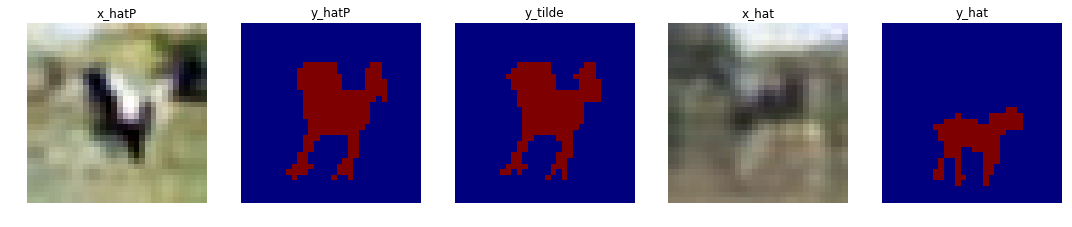

===> End of epoch 89 / 200 	 Time Taken: 15.92 sec

===> Start of epoch 90 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[90/200][0/50] in 2.039s (1.885,0.084,0.070) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.068/0.048 Y2Y/Y2YP: 0.163/0.070 T: 2.579 CE: 0.004 


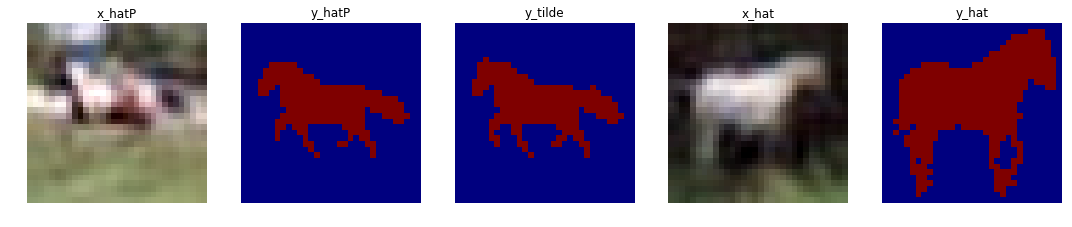

===> End of epoch 90 / 200 	 Time Taken: 17.99 sec

===> Start of epoch 91 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[91/200][0/50] in 0.289s (0.136,0.082,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.089/0.057 Y2Y/Y2YP: 0.190/0.092 T: 3.078 CE: 0.011 


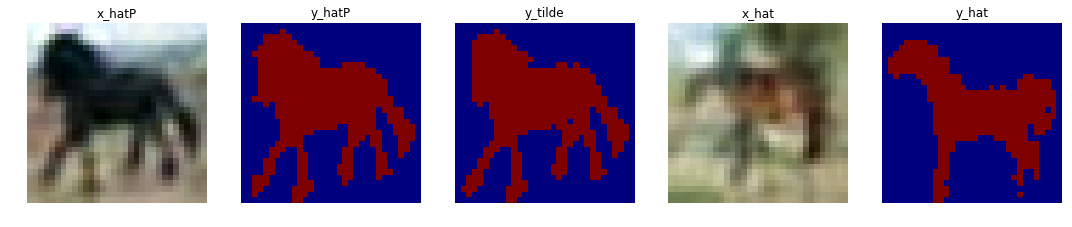

===> End of epoch 91 / 200 	 Time Taken: 15.91 sec

===> Start of epoch 92 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[92/200][0/50] in 0.293s (0.139,0.082,0.071) D/G: -0.016/-0.110 DP/GP: 0.162/0.054 X2X/X2XP: 0.091/0.067 Y2Y/Y2YP: 0.187/0.084 T: 2.308 CE: 0.008 


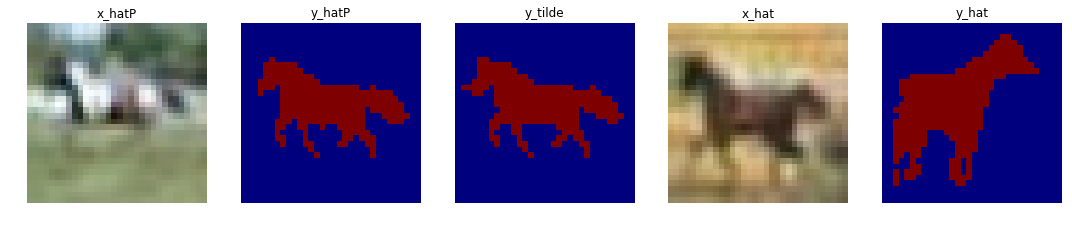

===> End of epoch 92 / 200 	 Time Taken: 16.27 sec

===> Start of epoch 93 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[93/200][0/50] in 0.298s (0.140,0.083,0.075) D/G: 0.164/0.055 DP/GP: 0.166/-0.111 X2X/X2XP: 0.076/0.072 Y2Y/Y2YP: 0.171/0.084 T: 6.602 CE: 0.005 


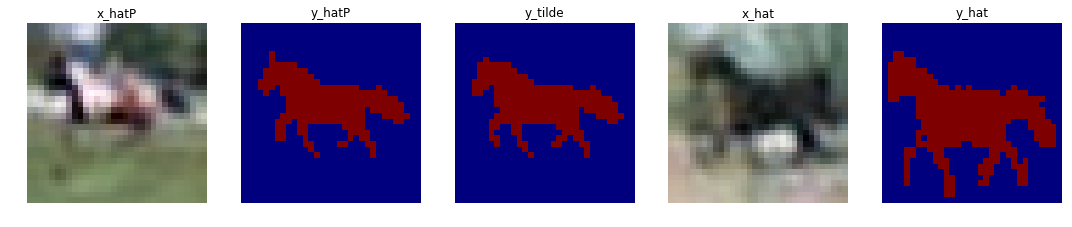

===> End of epoch 93 / 200 	 Time Taken: 16.27 sec

===> Start of epoch 94 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[94/200][0/50] in 0.293s (0.141,0.082,0.070) D/G: 0.166/0.055 DP/GP: 0.147/0.055 X2X/X2XP: 0.073/0.047 Y2Y/Y2YP: 0.147/0.075 T: 2.367 CE: 0.002 


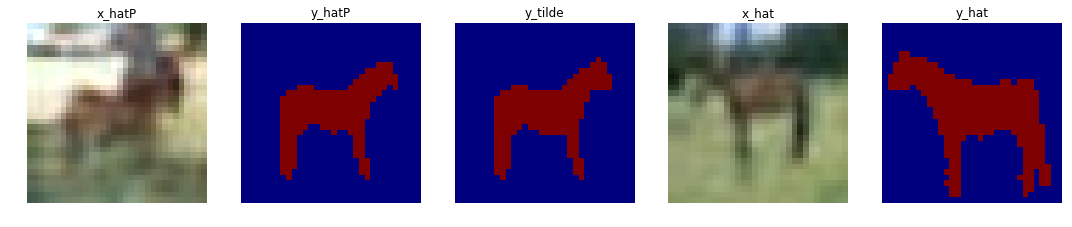

===> End of epoch 94 / 200 	 Time Taken: 16.01 sec

===> Start of epoch 95 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[95/200][0/50] in 0.292s (0.138,0.081,0.072) D/G: 0.165/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.092/0.066 Y2Y/Y2YP: 0.134/0.090 T: 3.621 CE: 0.012 


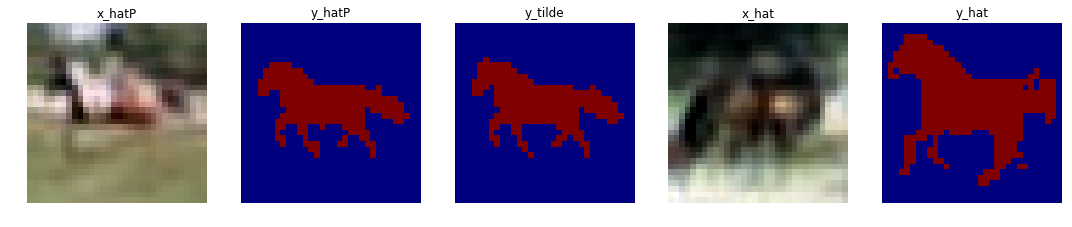

===> End of epoch 95 / 200 	 Time Taken: 16.21 sec

===> Start of epoch 96 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[96/200][0/50] in 0.292s (0.137,0.083,0.073) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.096/0.081 Y2Y/Y2YP: 0.160/0.085 T: 2.660 CE: 0.025 


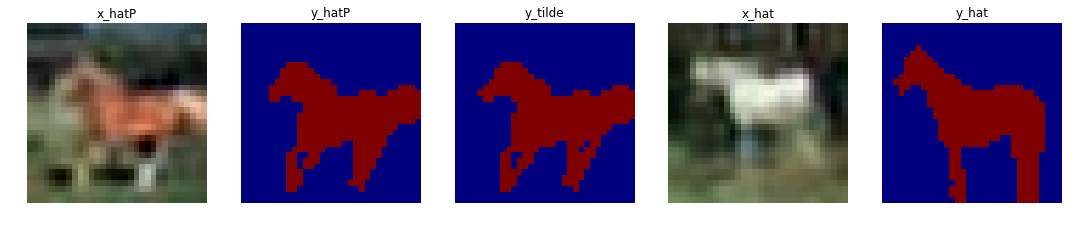

===> End of epoch 96 / 200 	 Time Taken: 16.57 sec

===> Start of epoch 97 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[97/200][0/50] in 0.304s (0.136,0.082,0.085) D/G: 0.166/0.055 DP/GP: 0.166/0.055 X2X/X2XP: 0.074/0.053 Y2Y/Y2YP: 0.210/0.110 T: 2.403 CE: 0.004 


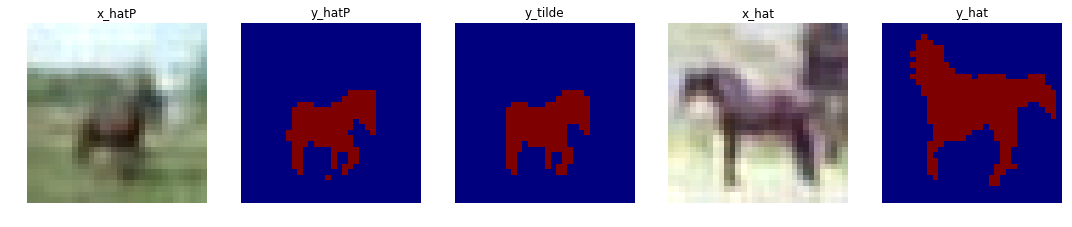

===> End of epoch 97 / 200 	 Time Taken: 16.39 sec

===> Start of epoch 98 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[98/200][0/50] in 0.288s (0.135,0.082,0.071) D/G: 0.166/0.055 DP/GP: 0.166/-0.110 X2X/X2XP: 0.071/0.052 Y2Y/Y2YP: 0.145/0.087 T: 1.638 CE: 0.004 


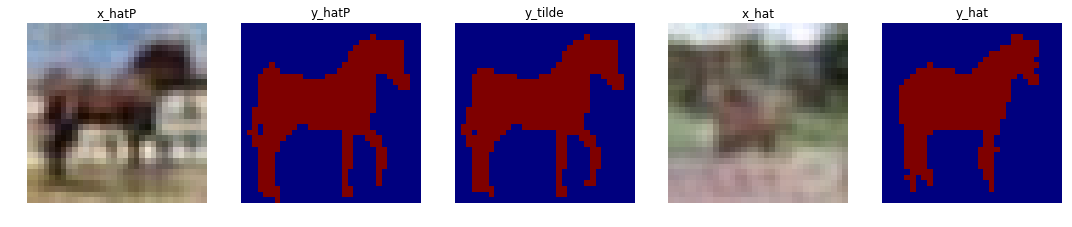

===> End of epoch 98 / 200 	 Time Taken: 16.01 sec

===> Start of epoch 99 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0001000
T: learning rate = 0.0001000
[99/200][0/50] in 0.292s (0.137,0.083,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.080/0.057 Y2Y/Y2YP: 0.199/0.094 T: 1.672 CE: 0.004 


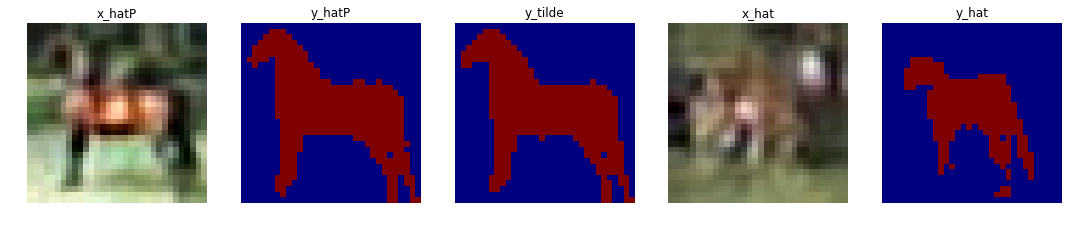

===> End of epoch 99 / 200 	 Time Taken: 16.15 sec

===> Start of epoch 100 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000990
T: learning rate = 0.0000990
[100/200][0/50] in 1.457s (1.304,0.082,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.085/0.058 Y2Y/Y2YP: 0.165/0.081 T: 1.710 CE: 0.003 


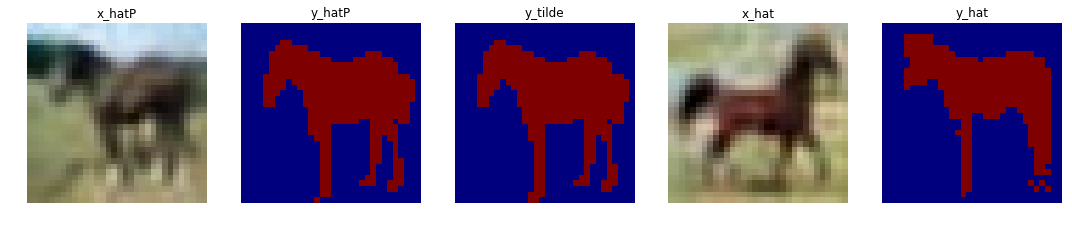

===> End of epoch 100 / 200 	 Time Taken: 17.07 sec

===> Start of epoch 101 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000980
T: learning rate = 0.0000980
[101/200][0/50] in 0.294s (0.136,0.084,0.073) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.083/0.057 Y2Y/Y2YP: 0.143/0.088 T: 1.485 CE: 0.004 


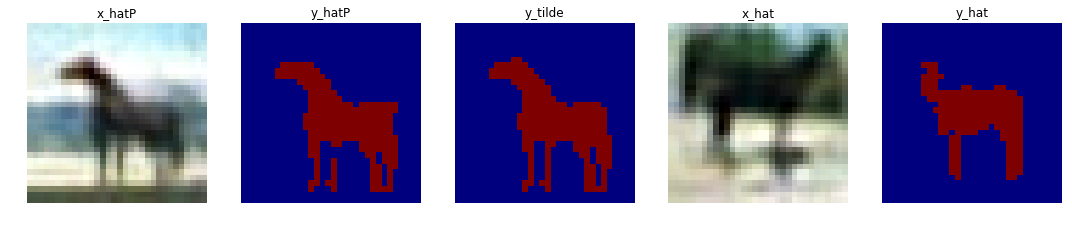

===> End of epoch 101 / 200 	 Time Taken: 15.84 sec

===> Start of epoch 102 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000970
T: learning rate = 0.0000970
[102/200][0/50] in 0.295s (0.142,0.082,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.083/0.055 Y2Y/Y2YP: 0.162/0.079 T: 2.010 CE: 0.019 


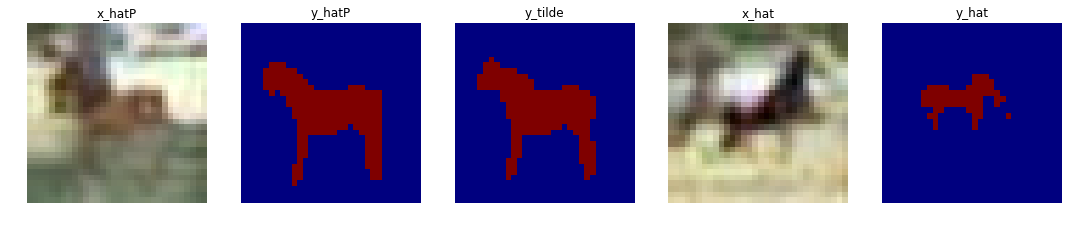

===> End of epoch 102 / 200 	 Time Taken: 15.95 sec

===> Start of epoch 103 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000960
T: learning rate = 0.0000960
[103/200][0/50] in 0.293s (0.137,0.084,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.076/0.056 Y2Y/Y2YP: 0.173/0.085 T: 1.994 CE: 0.002 


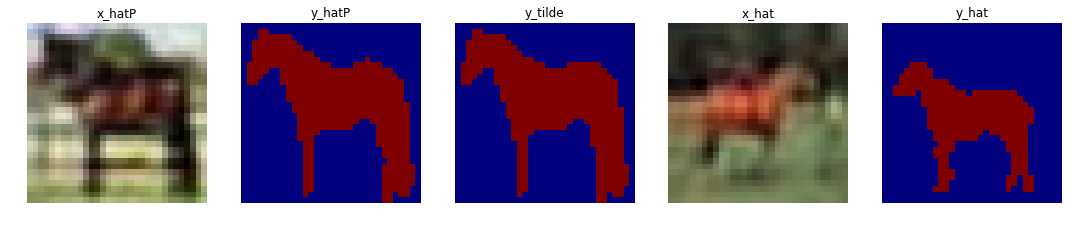

===> End of epoch 103 / 200 	 Time Taken: 15.79 sec

===> Start of epoch 104 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000950
T: learning rate = 0.0000950
[104/200][0/50] in 0.289s (0.135,0.082,0.071) D/G: 0.165/0.052 DP/GP: 0.121/0.052 X2X/X2XP: 0.100/0.070 Y2Y/Y2YP: 0.174/0.104 T: 3.005 CE: 0.007 


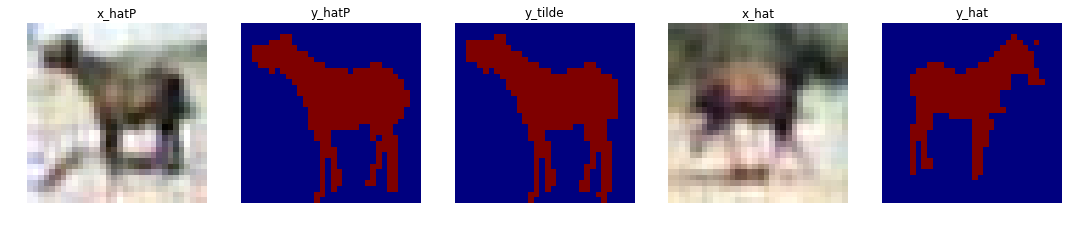

===> End of epoch 104 / 200 	 Time Taken: 16.06 sec

===> Start of epoch 105 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000941
T: learning rate = 0.0000941
[105/200][0/50] in 0.290s (0.136,0.082,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.069/0.057 Y2Y/Y2YP: 0.157/0.073 T: 1.727 CE: 0.004 


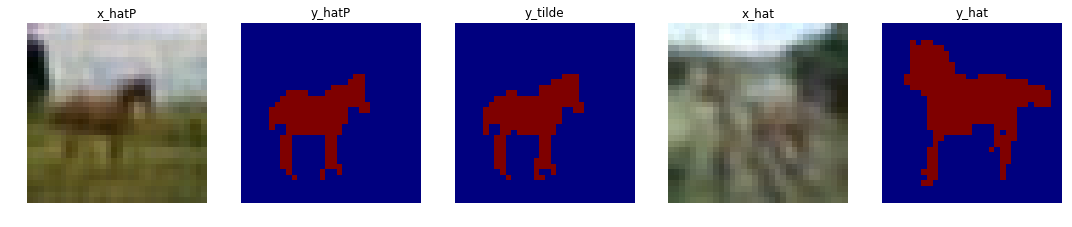

===> End of epoch 105 / 200 	 Time Taken: 15.87 sec

===> Start of epoch 106 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000931
T: learning rate = 0.0000931
[106/200][0/50] in 0.297s (0.143,0.083,0.071) D/G: 0.166/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.099/0.059 Y2Y/Y2YP: 0.165/0.089 T: 1.825 CE: 0.004 


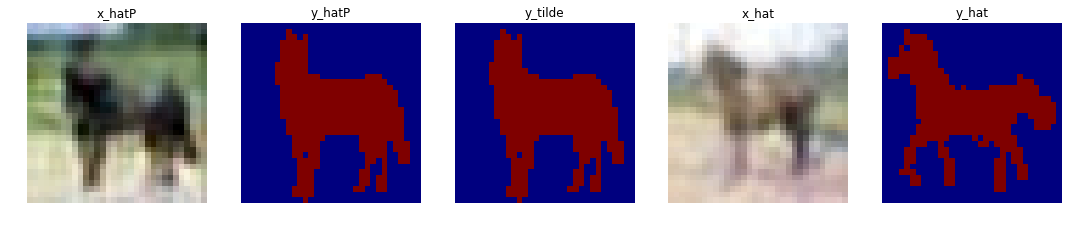

===> End of epoch 106 / 200 	 Time Taken: 15.76 sec

===> Start of epoch 107 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000921
T: learning rate = 0.0000921
[107/200][0/50] in 0.289s (0.135,0.083,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.079/0.055 Y2Y/Y2YP: 0.157/0.078 T: 1.778 CE: 0.007 


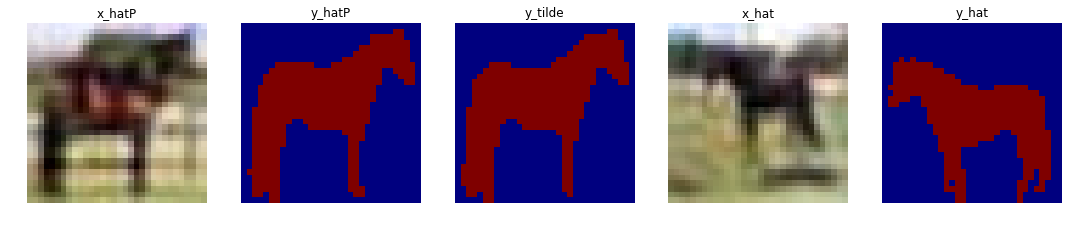

===> End of epoch 107 / 200 	 Time Taken: 15.90 sec

===> Start of epoch 108 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000911
T: learning rate = 0.0000911
[108/200][0/50] in 0.290s (0.136,0.083,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.034 X2X/X2XP: 0.090/0.073 Y2Y/Y2YP: 0.168/0.080 T: 1.632 CE: 0.002 


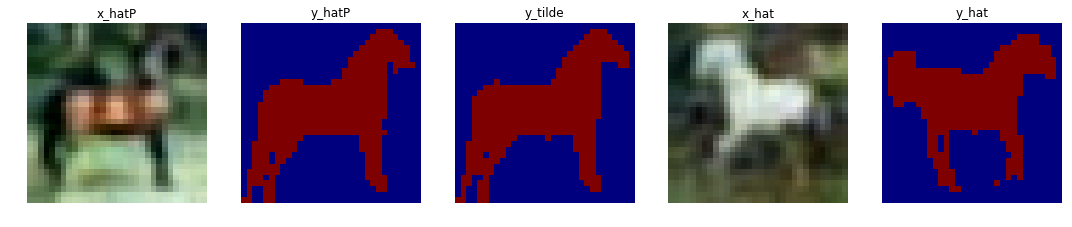

===> End of epoch 108 / 200 	 Time Taken: 15.88 sec

===> Start of epoch 109 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000901
T: learning rate = 0.0000901
[109/200][0/50] in 0.295s (0.142,0.082,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.094/0.049 Y2Y/Y2YP: 0.177/0.079 T: 1.930 CE: 0.003 


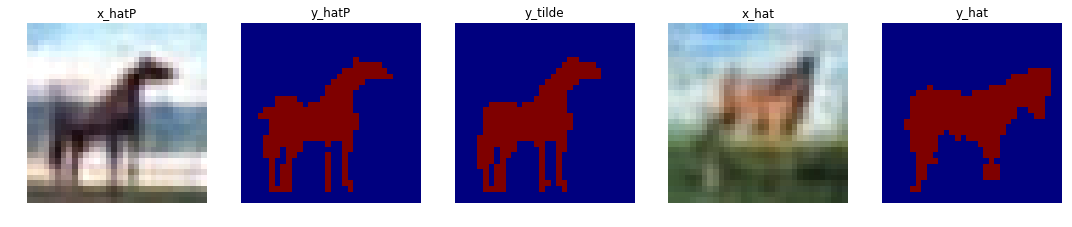

===> End of epoch 109 / 200 	 Time Taken: 15.89 sec

===> Start of epoch 110 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000891
T: learning rate = 0.0000891
[110/200][0/50] in 2.006s (1.649,0.284,0.073) D/G: 0.167/0.055 DP/GP: 0.078/0.055 X2X/X2XP: 0.082/0.052 Y2Y/Y2YP: 0.190/0.076 T: 1.450 CE: 0.001 


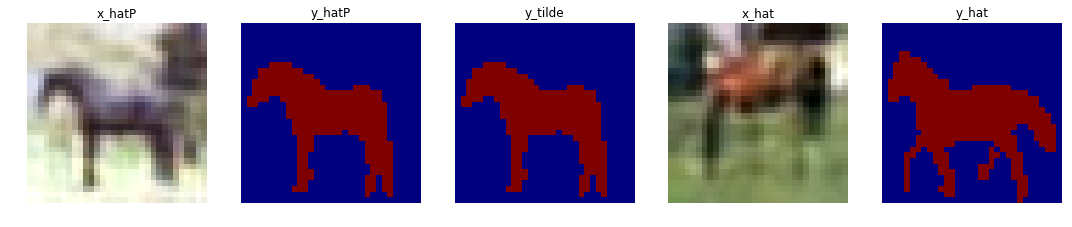

===> End of epoch 110 / 200 	 Time Taken: 17.10 sec

===> Start of epoch 111 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000881
T: learning rate = 0.0000881
[111/200][0/50] in 0.785s (0.456,0.253,0.076) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.087/0.066 Y2Y/Y2YP: 0.183/0.083 T: 5.545 CE: 0.118 


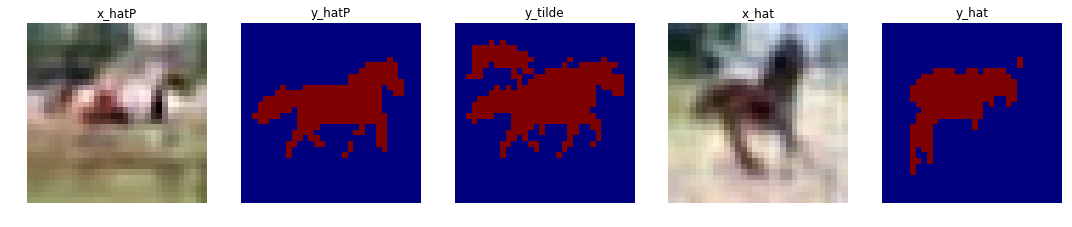

===> End of epoch 111 / 200 	 Time Taken: 15.99 sec

===> Start of epoch 112 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000871
T: learning rate = 0.0000871
[112/200][0/50] in 0.844s (0.539,0.231,0.073) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.084/0.056 Y2Y/Y2YP: 0.173/0.082 T: 1.499 CE: 0.005 


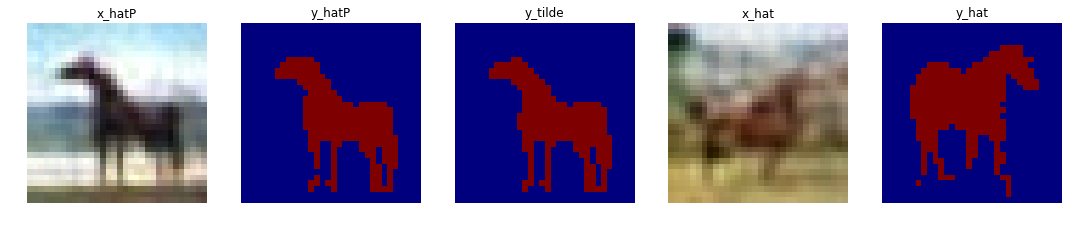

===> End of epoch 112 / 200 	 Time Taken: 15.91 sec

===> Start of epoch 113 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000861
T: learning rate = 0.0000861
[113/200][0/50] in 0.847s (0.514,0.259,0.074) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.075/0.054 Y2Y/Y2YP: 0.183/0.072 T: 1.686 CE: 0.003 


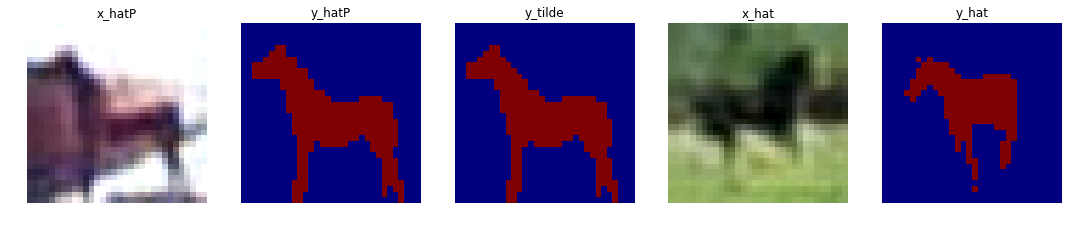

===> End of epoch 113 / 200 	 Time Taken: 15.86 sec

===> Start of epoch 114 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000851
T: learning rate = 0.0000851
[114/200][0/50] in 0.917s (0.534,0.310,0.073) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.074/0.056 Y2Y/Y2YP: 0.167/0.084 T: 2.035 CE: 0.004 


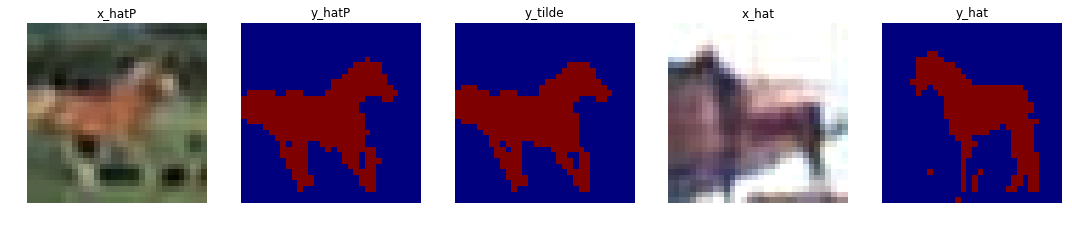

===> End of epoch 114 / 200 	 Time Taken: 15.94 sec

===> Start of epoch 115 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000842
T: learning rate = 0.0000842
[115/200][0/50] in 0.799s (0.462,0.267,0.070) D/G: 0.167/-0.111 DP/GP: 0.167/0.055 X2X/X2XP: 0.083/0.058 Y2Y/Y2YP: 0.130/0.079 T: 1.697 CE: 0.002 


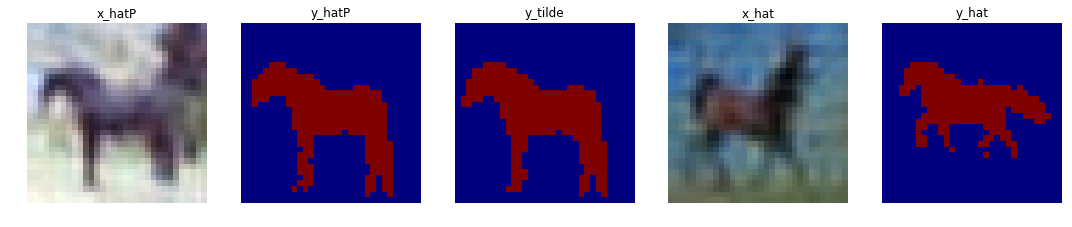

===> End of epoch 115 / 200 	 Time Taken: 15.82 sec

===> Start of epoch 116 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000832
T: learning rate = 0.0000832
[116/200][0/50] in 0.777s (0.462,0.242,0.073) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.083/0.051 Y2Y/Y2YP: 0.151/0.075 T: 1.831 CE: 0.001 


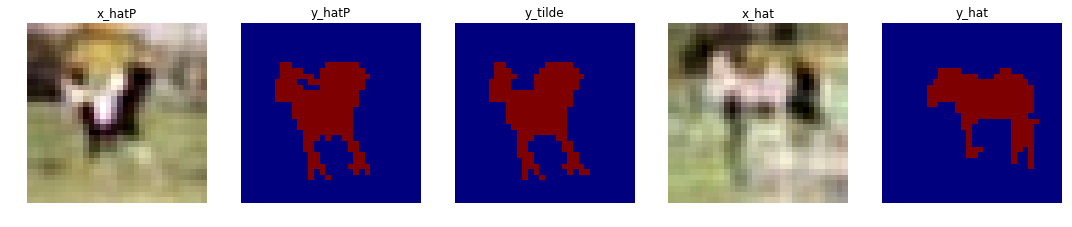

===> End of epoch 116 / 200 	 Time Taken: 15.88 sec

===> Start of epoch 117 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000822
T: learning rate = 0.0000822
[117/200][0/50] in 0.976s (0.581,0.319,0.076) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.131/0.074 Y2Y/Y2YP: 0.197/0.081 T: 4.608 CE: 0.044 


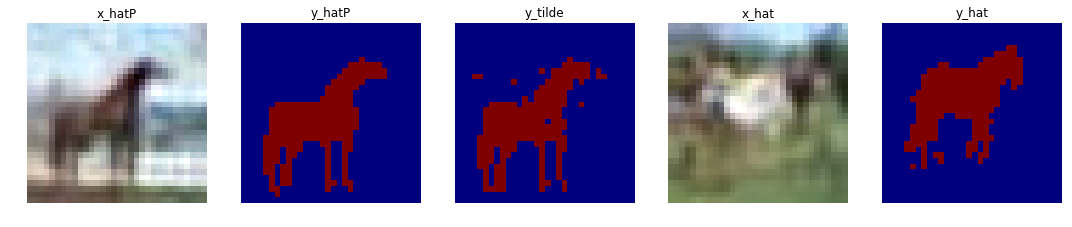

===> End of epoch 117 / 200 	 Time Taken: 16.12 sec

===> Start of epoch 118 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000812
T: learning rate = 0.0000812
[118/200][0/50] in 0.823s (0.480,0.269,0.074) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.100/0.057 Y2Y/Y2YP: 0.195/0.083 T: 1.940 CE: 0.004 


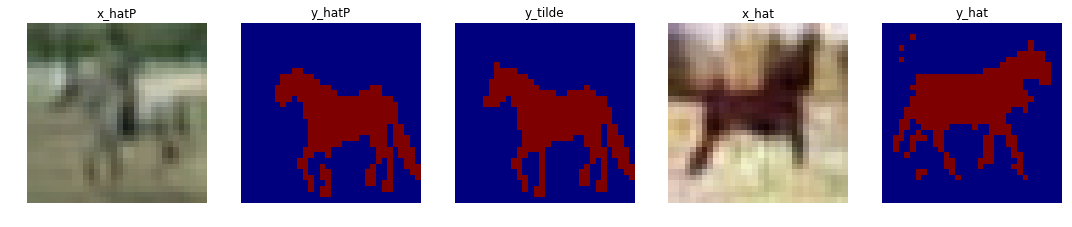

===> End of epoch 118 / 200 	 Time Taken: 16.10 sec

===> Start of epoch 119 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000802
T: learning rate = 0.0000802
[119/200][0/50] in 0.795s (0.437,0.282,0.076) D/G: 0.167/-0.111 DP/GP: 0.167/0.055 X2X/X2XP: 0.092/0.057 Y2Y/Y2YP: 0.177/0.071 T: 2.104 CE: 0.002 


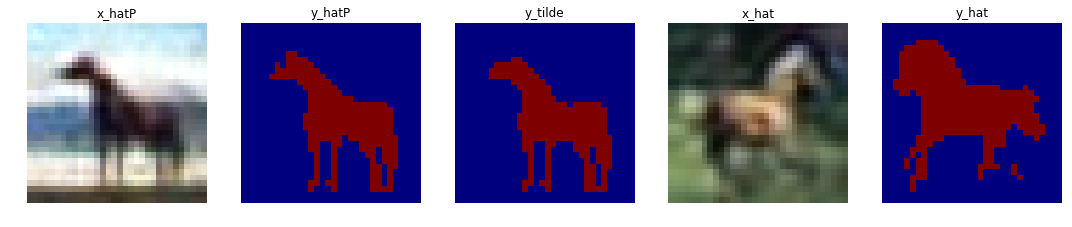

===> End of epoch 119 / 200 	 Time Taken: 15.82 sec

===> Start of epoch 120 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000792
T: learning rate = 0.0000792
[120/200][0/50] in 2.101s (1.940,0.084,0.078) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.068/0.049 Y2Y/Y2YP: 0.159/0.073 T: 2.103 CE: 0.003 


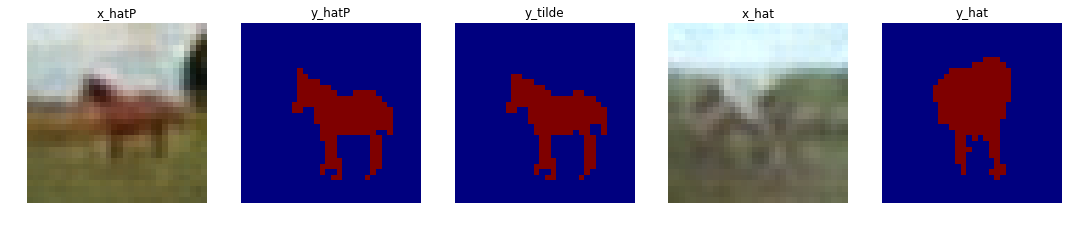

===> End of epoch 120 / 200 	 Time Taken: 17.71 sec

===> Start of epoch 121 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000782
T: learning rate = 0.0000782
[121/200][0/50] in 0.288s (0.135,0.082,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.087/0.066 Y2Y/Y2YP: 0.204/0.087 T: 2.015 CE: 0.005 


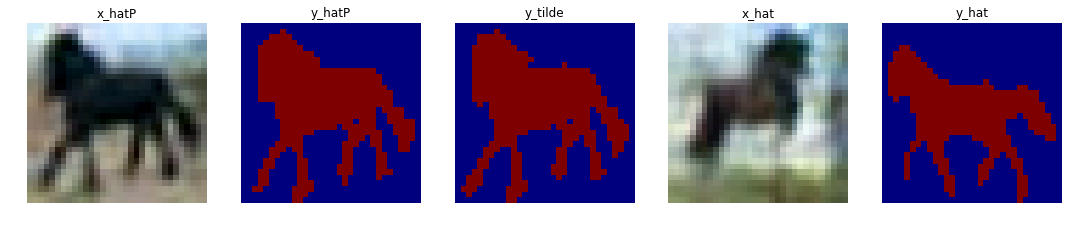

===> End of epoch 121 / 200 	 Time Taken: 16.10 sec

===> Start of epoch 122 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000772
T: learning rate = 0.0000772
[122/200][0/50] in 0.290s (0.136,0.082,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.083/0.062 Y2Y/Y2YP: 0.160/0.086 T: 2.537 CE: 0.003 


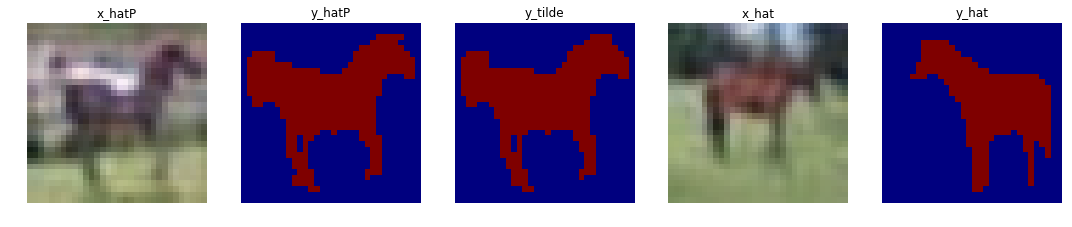

===> End of epoch 122 / 200 	 Time Taken: 16.28 sec

===> Start of epoch 123 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000762
T: learning rate = 0.0000762
[123/200][0/50] in 0.295s (0.139,0.084,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.099/0.066 Y2Y/Y2YP: 0.168/0.082 T: 1.528 CE: 0.002 


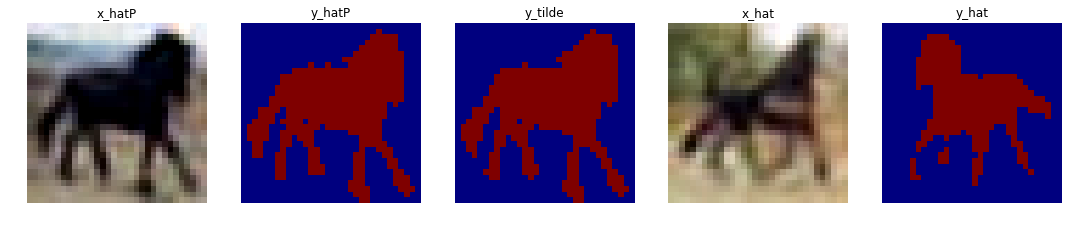

===> End of epoch 123 / 200 	 Time Taken: 16.22 sec

===> Start of epoch 124 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000752
T: learning rate = 0.0000752
[124/200][0/50] in 0.293s (0.141,0.081,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.081/0.041 Y2Y/Y2YP: 0.176/0.068 T: 1.562 CE: 0.002 


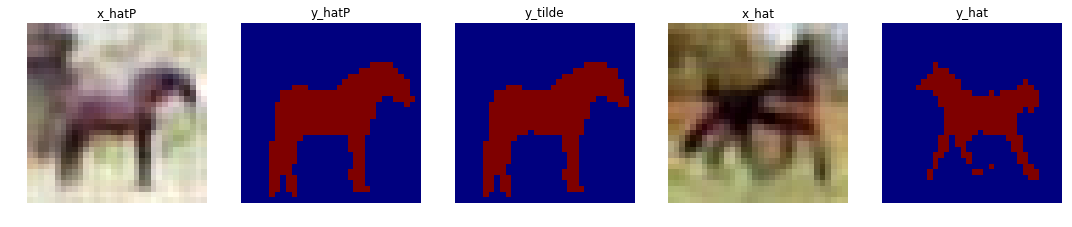

===> End of epoch 124 / 200 	 Time Taken: 16.03 sec

===> Start of epoch 125 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000743
T: learning rate = 0.0000743
[125/200][0/50] in 0.290s (0.137,0.082,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.066/0.056 Y2Y/Y2YP: 0.144/0.073 T: 1.531 CE: 0.002 


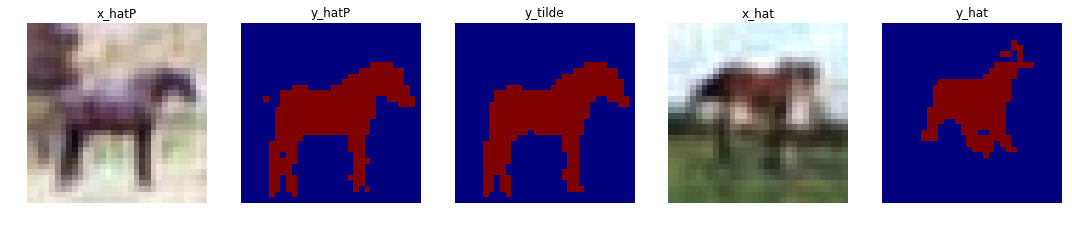

===> End of epoch 125 / 200 	 Time Taken: 15.99 sec

===> Start of epoch 126 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000733
T: learning rate = 0.0000733
[126/200][0/50] in 0.304s (0.137,0.083,0.084) D/G: 0.167/-0.106 DP/GP: 0.166/0.055 X2X/X2XP: 0.076/0.051 Y2Y/Y2YP: 0.176/0.077 T: 2.892 CE: 0.009 


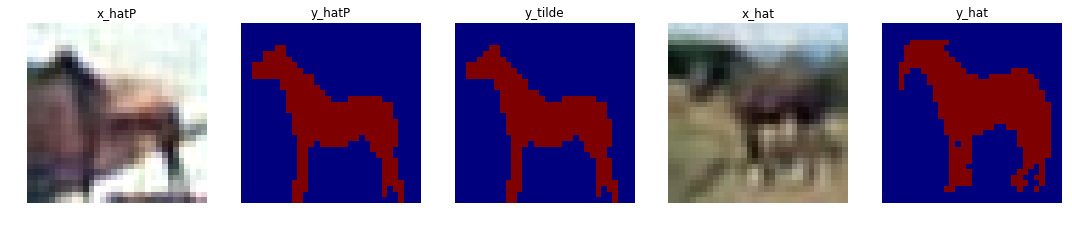

===> End of epoch 126 / 200 	 Time Taken: 16.03 sec

===> Start of epoch 127 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000723
T: learning rate = 0.0000723
[127/200][0/50] in 0.292s (0.140,0.081,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.071/0.050 Y2Y/Y2YP: 0.159/0.068 T: 1.410 CE: 0.002 


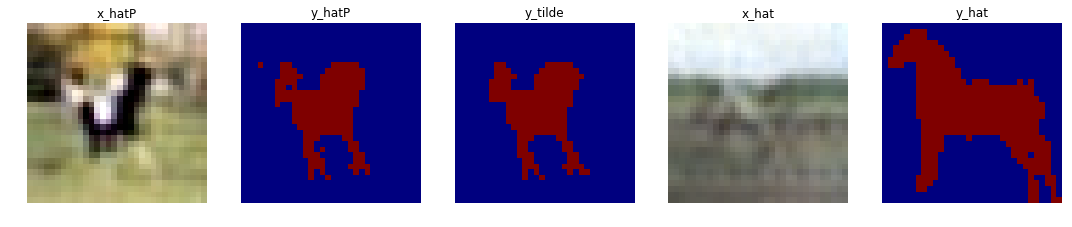

===> End of epoch 127 / 200 	 Time Taken: 15.92 sec

===> Start of epoch 128 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000713
T: learning rate = 0.0000713
[128/200][0/50] in 0.289s (0.135,0.083,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.070/0.058 Y2Y/Y2YP: 0.137/0.070 T: 1.488 CE: 0.001 


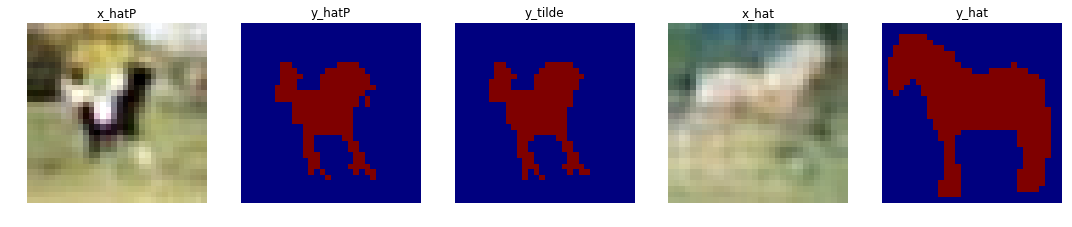

===> End of epoch 128 / 200 	 Time Taken: 15.97 sec

===> Start of epoch 129 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000703
T: learning rate = 0.0000703
[129/200][0/50] in 0.291s (0.138,0.082,0.071) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.074/0.049 Y2Y/Y2YP: 0.162/0.068 T: 1.484 CE: 0.002 


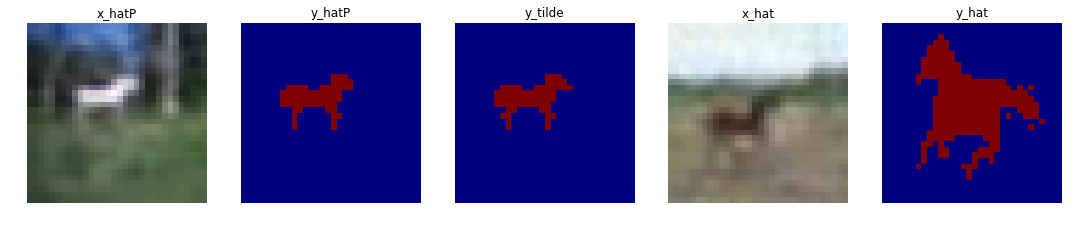

===> End of epoch 129 / 200 	 Time Taken: 15.86 sec

===> Start of epoch 130 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000693
T: learning rate = 0.0000693
[130/200][0/50] in 1.432s (1.281,0.081,0.070) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.064/0.051 Y2Y/Y2YP: 0.185/0.086 T: 1.319 CE: 0.002 


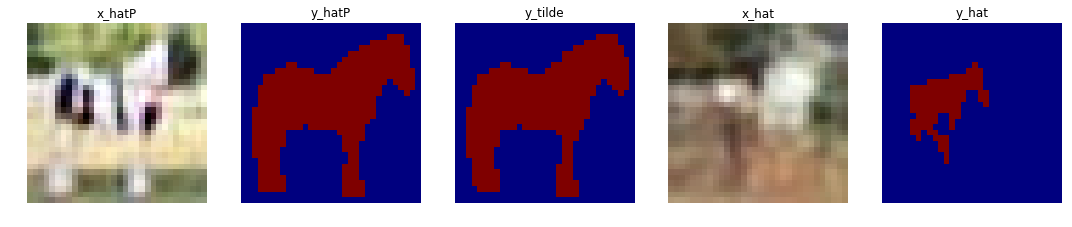

===> End of epoch 130 / 200 	 Time Taken: 16.86 sec

===> Start of epoch 131 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000683
T: learning rate = 0.0000683
[131/200][0/50] in 0.290s (0.134,0.083,0.073) D/G: 0.166/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.082/0.053 Y2Y/Y2YP: 0.125/0.091 T: 1.324 CE: 0.002 


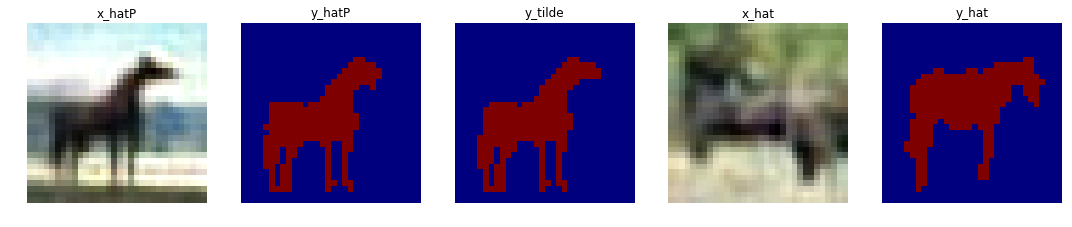

===> End of epoch 131 / 200 	 Time Taken: 15.74 sec

===> Start of epoch 132 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000673
T: learning rate = 0.0000673
[132/200][0/50] in 0.294s (0.138,0.084,0.073) D/G: 0.167/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.077/0.055 Y2Y/Y2YP: 0.176/0.065 T: 1.891 CE: 0.001 


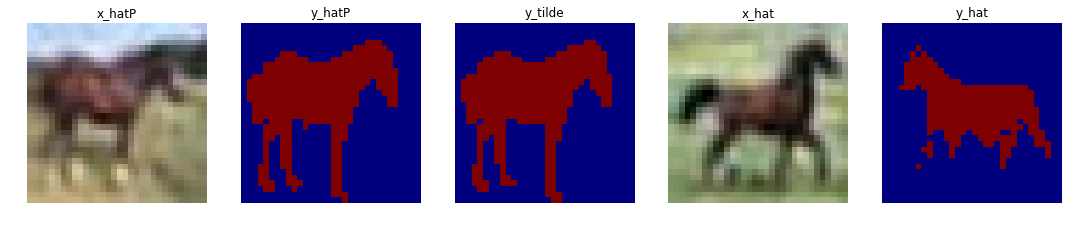

===> End of epoch 132 / 200 	 Time Taken: 16.00 sec

===> Start of epoch 133 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000663
T: learning rate = 0.0000663
[133/200][0/50] in 0.290s (0.137,0.083,0.071) D/G: 0.167/0.056 DP/GP: 0.167/0.056 X2X/X2XP: 0.075/0.050 Y2Y/Y2YP: 0.159/0.069 T: 1.356 CE: 0.001 


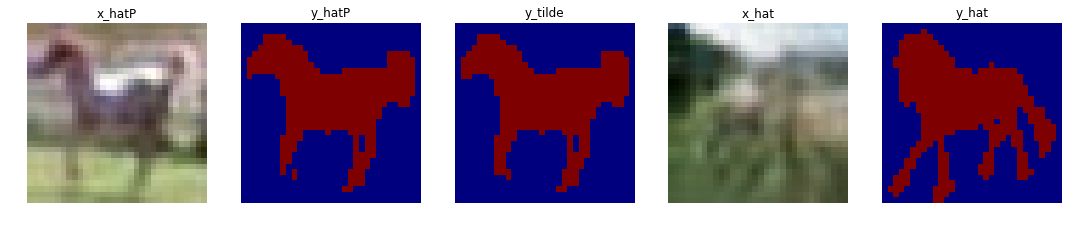

===> End of epoch 133 / 200 	 Time Taken: 15.88 sec

===> Start of epoch 134 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000653
T: learning rate = 0.0000653
[134/200][0/50] in 0.292s (0.136,0.083,0.073) D/G: 0.167/0.047 DP/GP: 0.167/0.055 X2X/X2XP: 0.083/0.050 Y2Y/Y2YP: 0.178/0.082 T: 1.850 CE: 0.004 


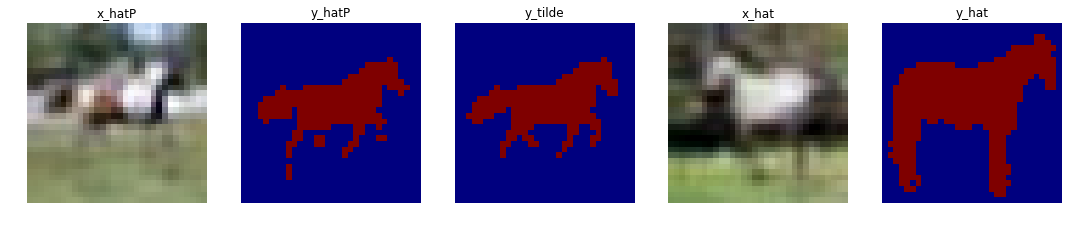

===> End of epoch 134 / 200 	 Time Taken: 15.90 sec

===> Start of epoch 135 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000644
T: learning rate = 0.0000644
[135/200][0/50] in 0.296s (0.142,0.082,0.072) D/G: 0.162/0.055 DP/GP: 0.167/0.055 X2X/X2XP: 0.067/0.058 Y2Y/Y2YP: 0.137/0.084 T: 1.474 CE: 0.002 


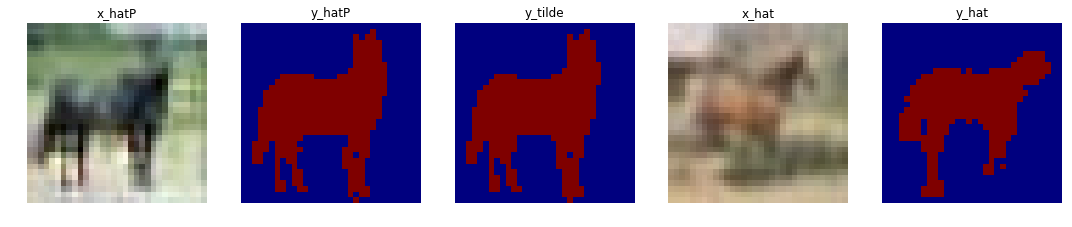

===> End of epoch 135 / 200 	 Time Taken: 15.86 sec

===> Start of epoch 136 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000634
T: learning rate = 0.0000634
[136/200][0/50] in 0.291s (0.137,0.083,0.071) D/G: 0.167/0.056 DP/GP: 0.167/0.056 X2X/X2XP: 0.116/0.099 Y2Y/Y2YP: 0.152/0.089 T: 25.986 CE: 0.240 


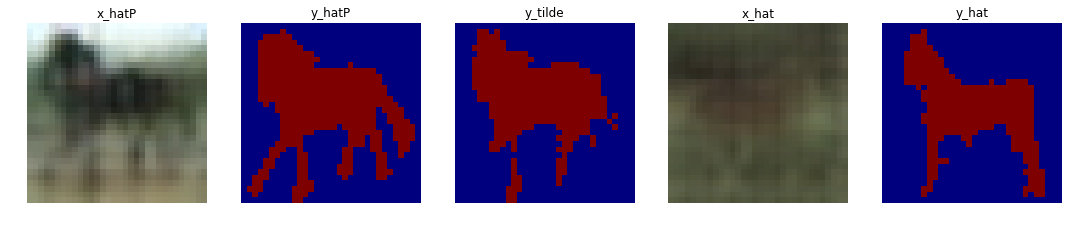

===> End of epoch 136 / 200 	 Time Taken: 15.90 sec

===> Start of epoch 137 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000624
T: learning rate = 0.0000624
[137/200][0/50] in 0.293s (0.136,0.083,0.073) D/G: 0.167/0.056 DP/GP: 0.167/0.056 X2X/X2XP: 0.101/0.090 Y2Y/Y2YP: 0.200/0.079 T: 7.943 CE: 0.043 


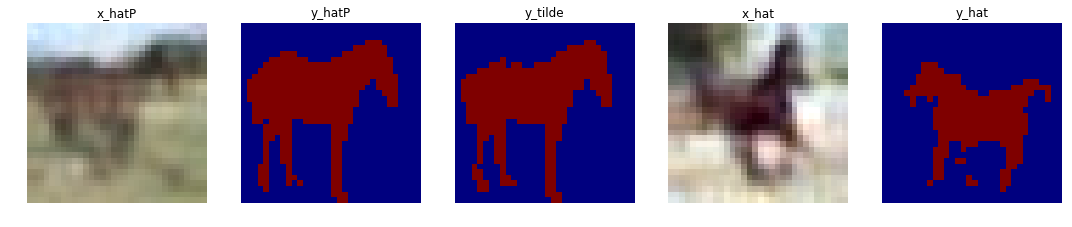

===> End of epoch 137 / 200 	 Time Taken: 15.91 sec

===> Start of epoch 138 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000614
T: learning rate = 0.0000614
[138/200][0/50] in 0.294s (0.139,0.083,0.072) D/G: 0.167/0.055 DP/GP: 0.167/0.056 X2X/X2XP: 0.098/0.061 Y2Y/Y2YP: 0.188/0.077 T: 2.927 CE: 0.008 


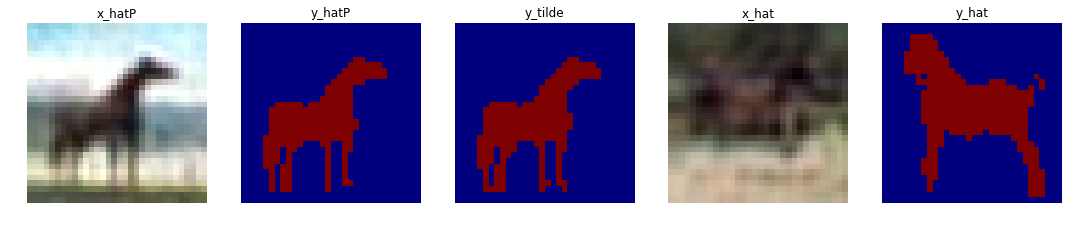

===> End of epoch 138 / 200 	 Time Taken: 15.87 sec

===> Start of epoch 139 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000604
T: learning rate = 0.0000604
[139/200][0/50] in 0.293s (0.137,0.083,0.073) D/G: 0.167/0.056 DP/GP: 0.167/0.056 X2X/X2XP: 0.106/0.063 Y2Y/Y2YP: 0.164/0.067 T: 4.375 CE: 0.004 


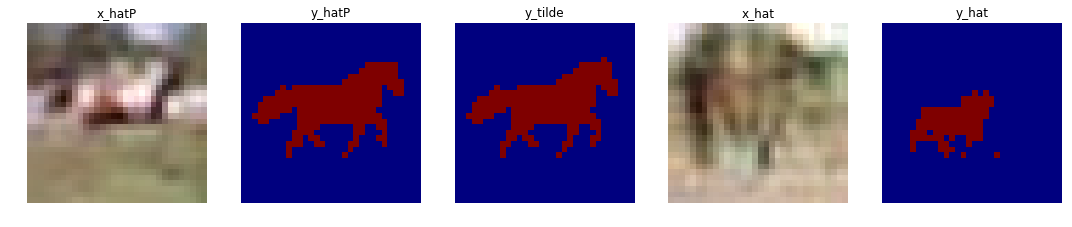

===> End of epoch 139 / 200 	 Time Taken: 16.06 sec

===> Start of epoch 140 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000594
T: learning rate = 0.0000594
[140/200][0/50] in 2.007s (1.851,0.087,0.070) D/G: 0.167/0.056 DP/GP: 0.167/0.056 X2X/X2XP: 0.116/0.066 Y2Y/Y2YP: 0.183/0.063 T: 4.433 CE: 0.004 


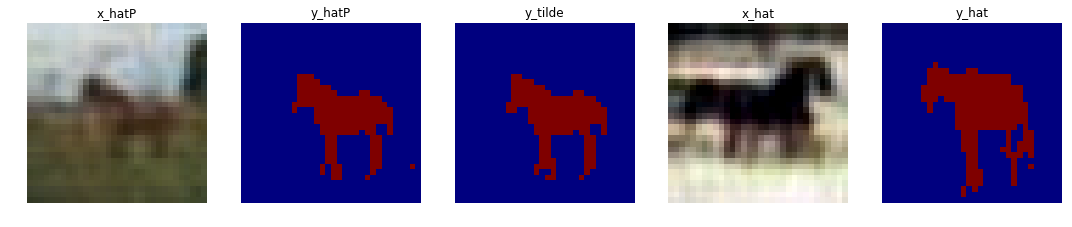

===> End of epoch 140 / 200 	 Time Taken: 17.85 sec

===> Start of epoch 141 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000584
T: learning rate = 0.0000584
[141/200][0/50] in 0.282s (0.132,0.081,0.069) D/G: 0.167/0.056 DP/GP: 0.167/0.056 X2X/X2XP: 0.079/0.058 Y2Y/Y2YP: 0.158/0.071 T: 2.483 CE: 0.006 


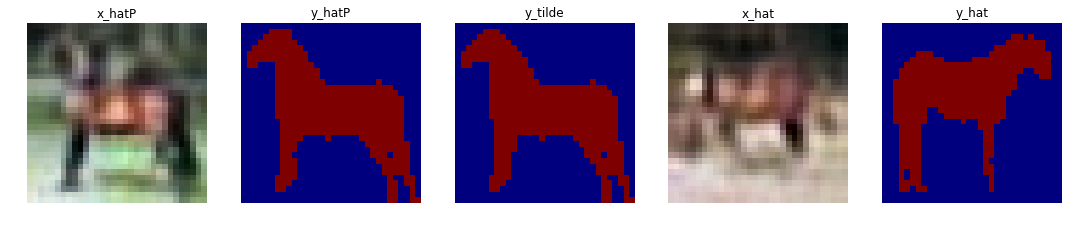

===> End of epoch 141 / 200 	 Time Taken: 15.87 sec

===> Start of epoch 142 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000574
T: learning rate = 0.0000574
[142/200][0/50] in 0.282s (0.135,0.080,0.067) D/G: 0.167/0.055 DP/GP: 0.167/0.056 X2X/X2XP: 0.102/0.050 Y2Y/Y2YP: 0.161/0.086 T: 1.894 CE: 0.002 


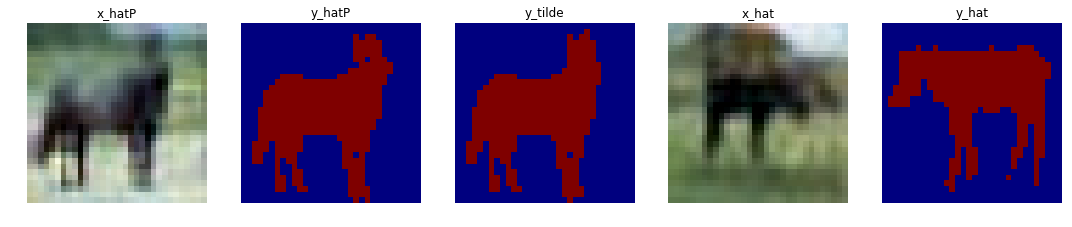

===> End of epoch 142 / 200 	 Time Taken: 15.72 sec

===> Start of epoch 143 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000564
T: learning rate = 0.0000564
[143/200][0/50] in 0.290s (0.138,0.084,0.068) D/G: 0.167/0.056 DP/GP: 0.167/0.056 X2X/X2XP: 0.106/0.064 Y2Y/Y2YP: 0.170/0.073 T: 3.508 CE: 0.006 


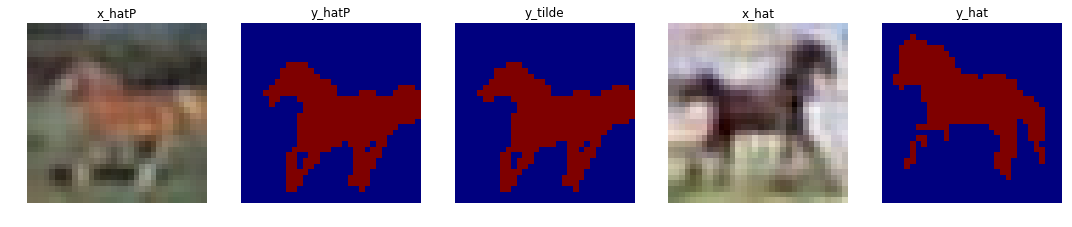

===> End of epoch 143 / 200 	 Time Taken: 16.02 sec

===> Start of epoch 144 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000554
T: learning rate = 0.0000554
[144/200][0/50] in 0.282s (0.133,0.081,0.068) D/G: 0.168/0.056 DP/GP: 0.167/0.056 X2X/X2XP: 0.072/0.055 Y2Y/Y2YP: 0.168/0.079 T: 1.848 CE: 0.003 


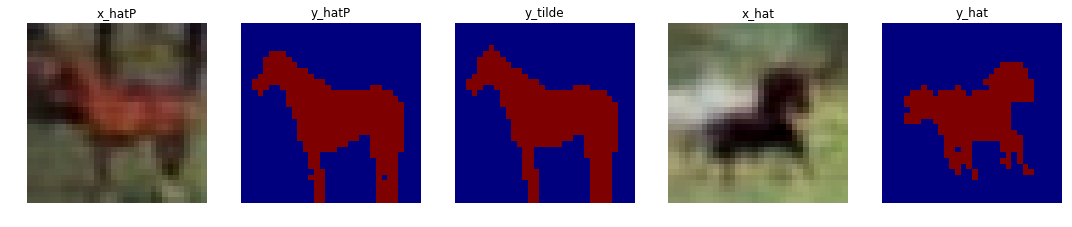

===> End of epoch 144 / 200 	 Time Taken: 15.97 sec

===> Start of epoch 145 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000545
T: learning rate = 0.0000545
[145/200][0/50] in 0.290s (0.139,0.082,0.069) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.072/0.045 Y2Y/Y2YP: 0.179/0.073 T: 1.454 CE: 0.002 


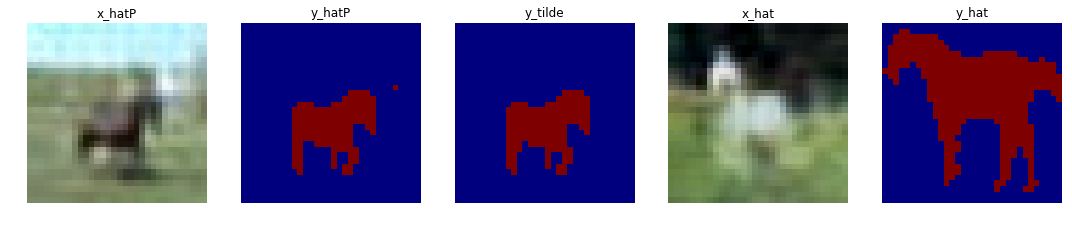

===> End of epoch 145 / 200 	 Time Taken: 16.10 sec

===> Start of epoch 146 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000535
T: learning rate = 0.0000535
[146/200][0/50] in 0.295s (0.143,0.082,0.070) D/G: 0.167/0.056 DP/GP: 0.167/0.056 X2X/X2XP: 0.069/0.057 Y2Y/Y2YP: 0.148/0.066 T: 2.122 CE: 0.002 


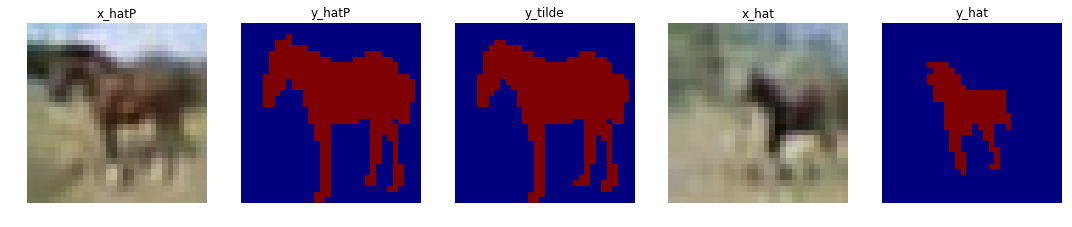

===> End of epoch 146 / 200 	 Time Taken: 15.99 sec

===> Start of epoch 147 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000525
T: learning rate = 0.0000525
[147/200][0/50] in 0.277s (0.128,0.081,0.069) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.075/0.059 Y2Y/Y2YP: 0.129/0.066 T: 2.792 CE: 0.002 


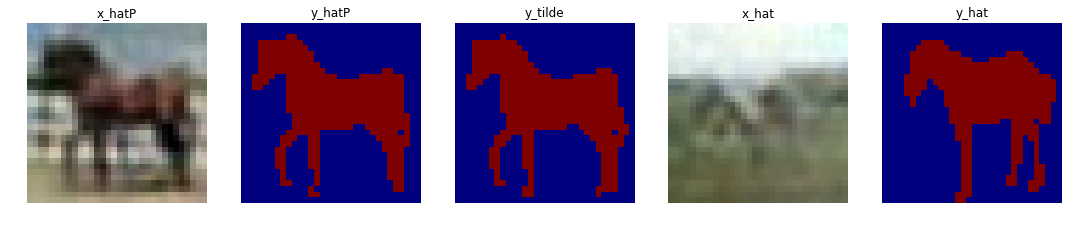

===> End of epoch 147 / 200 	 Time Taken: 15.94 sec

===> Start of epoch 148 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000515
T: learning rate = 0.0000515
[148/200][0/50] in 0.278s (0.127,0.080,0.071) D/G: 0.168/0.056 DP/GP: 0.167/0.056 X2X/X2XP: 0.064/0.046 Y2Y/Y2YP: 0.147/0.065 T: 3.183 CE: 0.003 


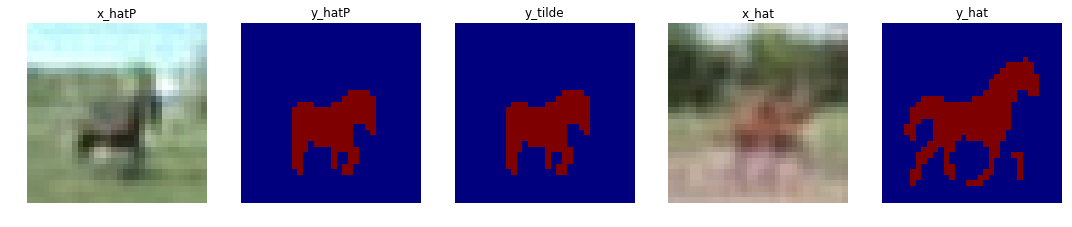

===> End of epoch 148 / 200 	 Time Taken: 16.39 sec

===> Start of epoch 149 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000505
T: learning rate = 0.0000505
[149/200][0/50] in 0.289s (0.140,0.081,0.068) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.089/0.046 Y2Y/Y2YP: 0.155/0.072 T: 1.731 CE: 0.003 


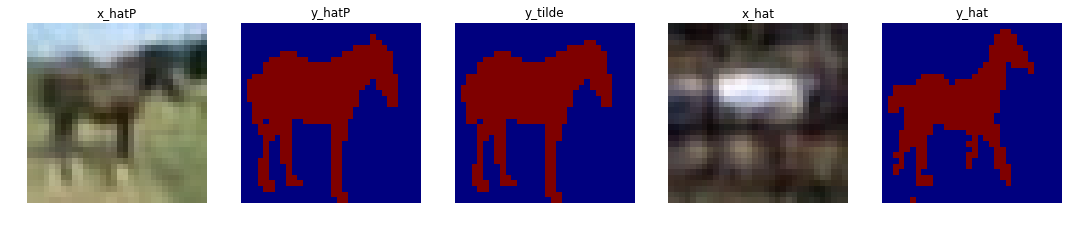

===> End of epoch 149 / 200 	 Time Taken: 16.56 sec

===> Start of epoch 150 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000495
T: learning rate = 0.0000495
[150/200][0/50] in 1.427s (1.279,0.080,0.069) D/G: 0.167/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.078/0.049 Y2Y/Y2YP: 0.178/0.075 T: 2.984 CE: 0.002 


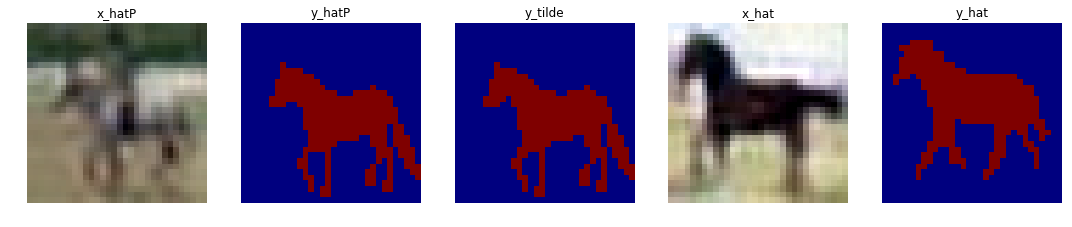

===> End of epoch 150 / 200 	 Time Taken: 17.08 sec

===> Start of epoch 151 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000485
T: learning rate = 0.0000485
[151/200][0/50] in 0.292s (0.139,0.083,0.071) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.079/0.044 Y2Y/Y2YP: 0.143/0.063 T: 1.959 CE: 0.001 


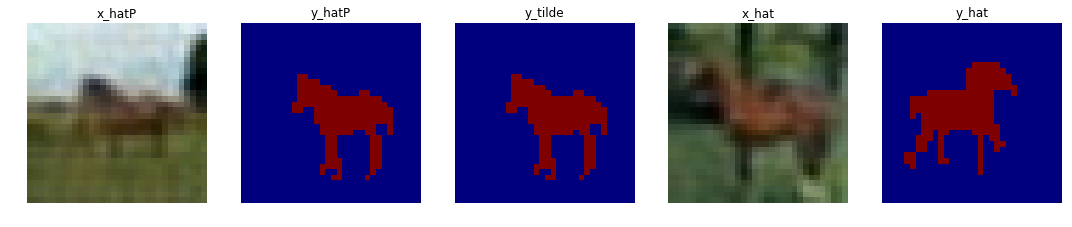

===> End of epoch 151 / 200 	 Time Taken: 16.43 sec

===> Start of epoch 152 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000475
T: learning rate = 0.0000475
[152/200][0/50] in 0.294s (0.142,0.082,0.071) D/G: 0.167/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.086/0.061 Y2Y/Y2YP: 0.160/0.069 T: 2.841 CE: 0.001 


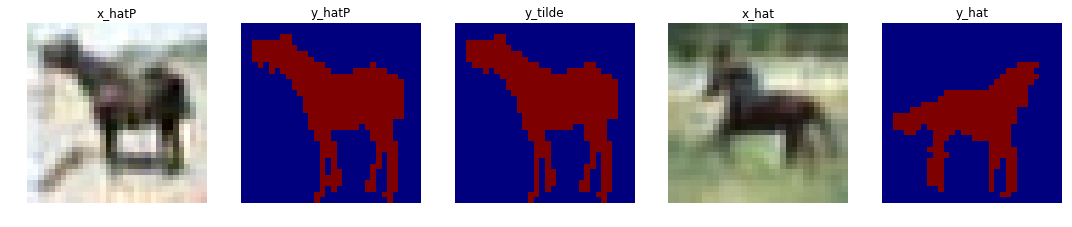

===> End of epoch 152 / 200 	 Time Taken: 16.16 sec

===> Start of epoch 153 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000465
T: learning rate = 0.0000465
[153/200][0/50] in 0.289s (0.136,0.083,0.071) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.089/0.054 Y2Y/Y2YP: 0.167/0.067 T: 1.737 CE: 0.001 


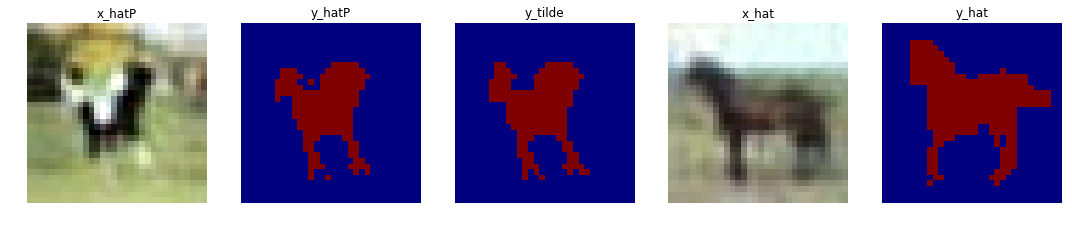

===> End of epoch 153 / 200 	 Time Taken: 16.41 sec

===> Start of epoch 154 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000455
T: learning rate = 0.0000455
[154/200][0/50] in 0.285s (0.134,0.081,0.070) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.066/0.050 Y2Y/Y2YP: 0.151/0.062 T: 2.938 CE: 0.002 


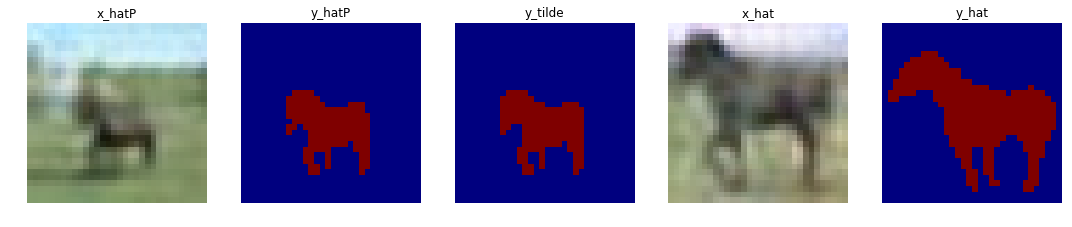

===> End of epoch 154 / 200 	 Time Taken: 15.91 sec

===> Start of epoch 155 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000446
T: learning rate = 0.0000446
[155/200][0/50] in 0.284s (0.133,0.081,0.070) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.088/0.056 Y2Y/Y2YP: 0.142/0.083 T: 7.320 CE: 0.001 


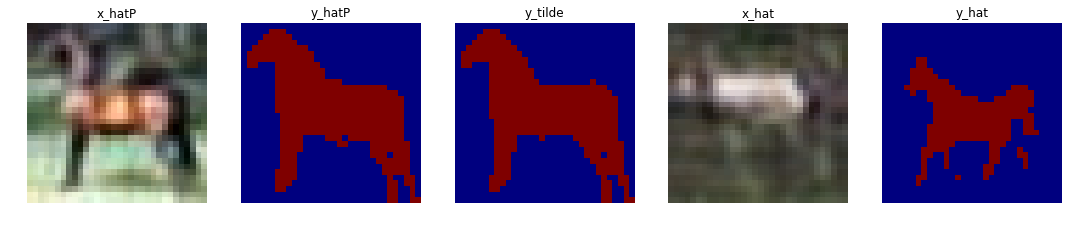

===> End of epoch 155 / 200 	 Time Taken: 15.93 sec

===> Start of epoch 156 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000436
T: learning rate = 0.0000436
[156/200][0/50] in 0.294s (0.139,0.083,0.072) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.103/0.051 Y2Y/Y2YP: 0.169/0.069 T: 4.594 CE: 0.001 


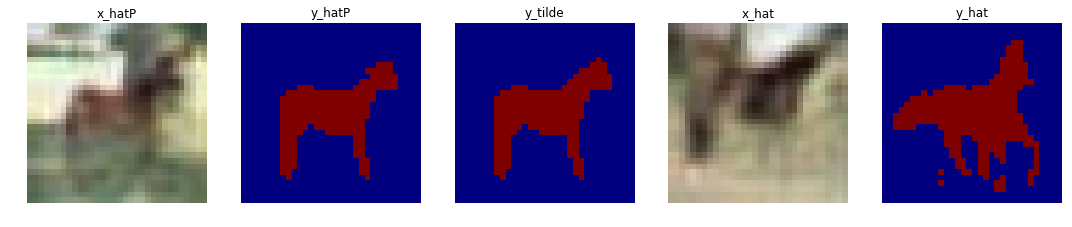

===> End of epoch 156 / 200 	 Time Taken: 16.01 sec

===> Start of epoch 157 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000426
T: learning rate = 0.0000426
[157/200][0/50] in 0.289s (0.135,0.082,0.071) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.089/0.063 Y2Y/Y2YP: 0.168/0.082 T: 2.288 CE: 0.010 


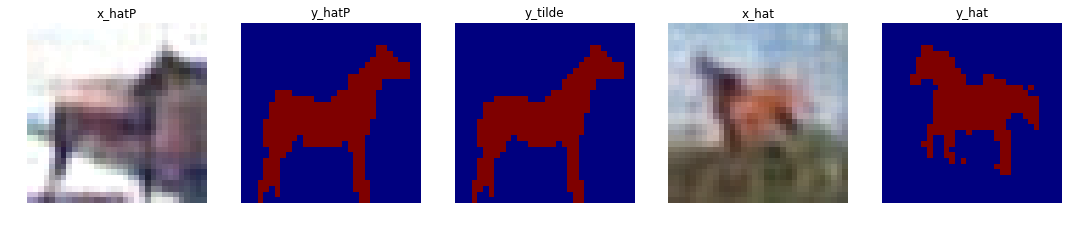

===> End of epoch 157 / 200 	 Time Taken: 15.96 sec

===> Start of epoch 158 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000416
T: learning rate = 0.0000416
[158/200][0/50] in 0.291s (0.137,0.082,0.072) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.094/0.053 Y2Y/Y2YP: 0.160/0.080 T: 2.439 CE: 0.003 


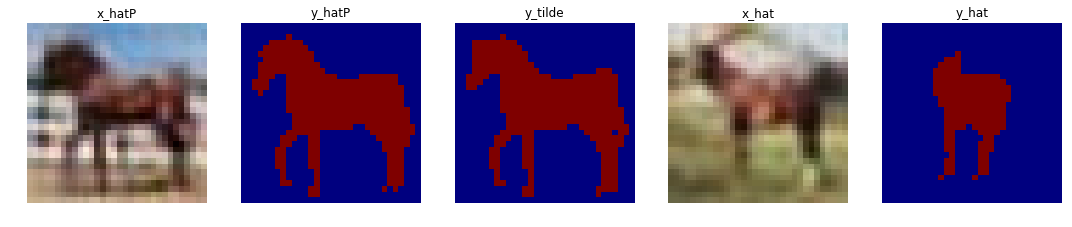

===> End of epoch 158 / 200 	 Time Taken: 16.08 sec

===> Start of epoch 159 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000406
T: learning rate = 0.0000406
[159/200][0/50] in 0.338s (0.143,0.108,0.087) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.068/0.049 Y2Y/Y2YP: 0.125/0.070 T: 1.939 CE: 0.001 


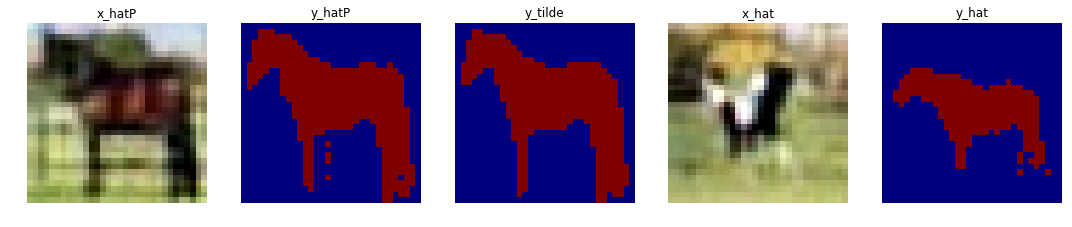

===> End of epoch 159 / 200 	 Time Taken: 16.15 sec

===> Start of epoch 160 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000396
T: learning rate = 0.0000396
[160/200][0/50] in 1.444s (1.292,0.082,0.070) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.076/0.059 Y2Y/Y2YP: 0.133/0.063 T: 6.100 CE: 0.001 


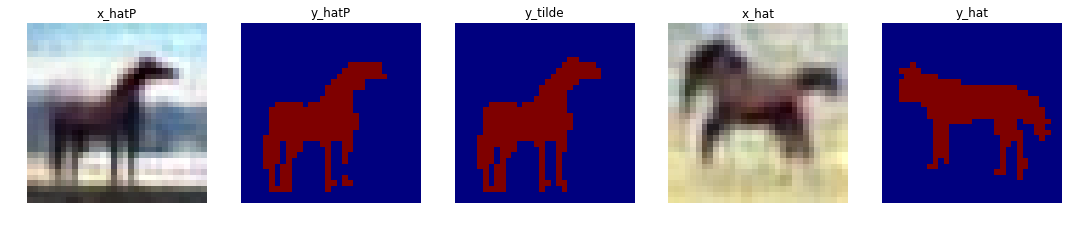

===> End of epoch 160 / 200 	 Time Taken: 17.19 sec

===> Start of epoch 161 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000386
T: learning rate = 0.0000386
[161/200][0/50] in 0.290s (0.137,0.083,0.071) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.069/0.046 Y2Y/Y2YP: 0.170/0.073 T: 2.321 CE: 0.001 


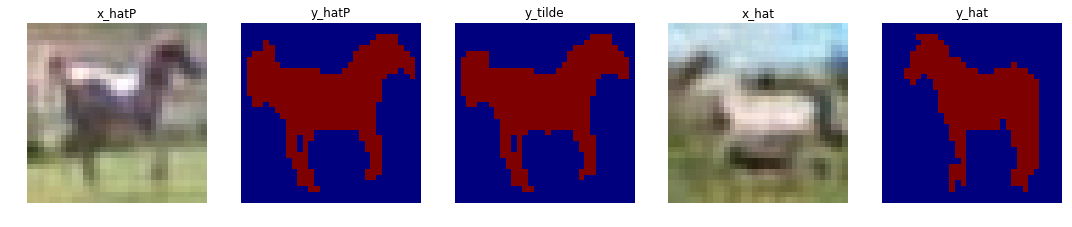

===> End of epoch 161 / 200 	 Time Taken: 16.03 sec

===> Start of epoch 162 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000376
T: learning rate = 0.0000376
[162/200][0/50] in 0.295s (0.142,0.082,0.071) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.076/0.054 Y2Y/Y2YP: 0.135/0.073 T: 3.028 CE: 0.002 


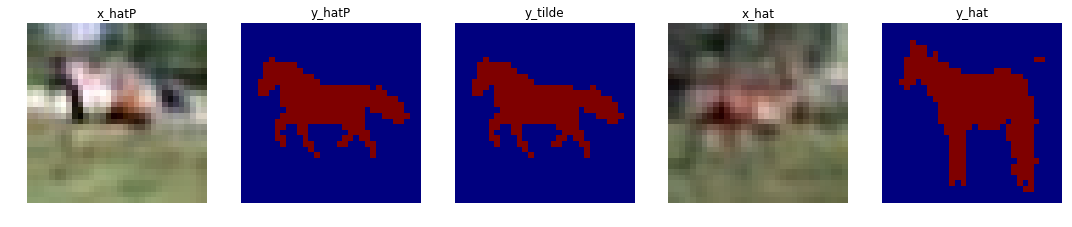

===> End of epoch 162 / 200 	 Time Taken: 16.27 sec

===> Start of epoch 163 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000366
T: learning rate = 0.0000366
[163/200][0/50] in 0.290s (0.136,0.083,0.071) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.083/0.049 Y2Y/Y2YP: 0.160/0.070 T: 2.091 CE: 0.001 


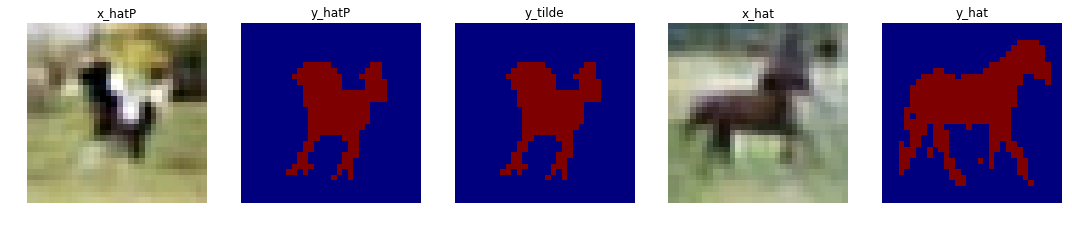

===> End of epoch 163 / 200 	 Time Taken: 16.42 sec

===> Start of epoch 164 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000356
T: learning rate = 0.0000356
[164/200][0/50] in 0.291s (0.136,0.083,0.071) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.068/0.047 Y2Y/Y2YP: 0.195/0.071 T: 1.889 CE: 0.001 


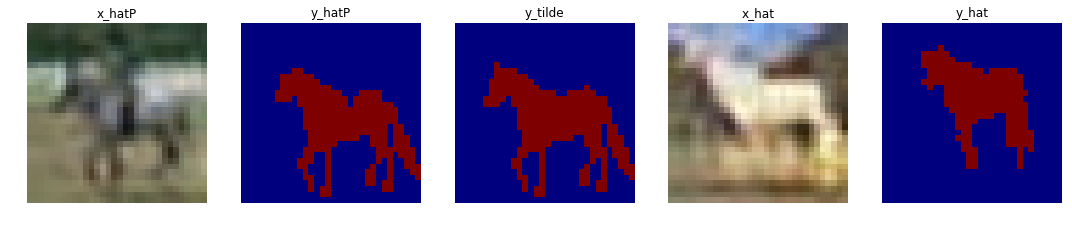

===> End of epoch 164 / 200 	 Time Taken: 16.37 sec

===> Start of epoch 165 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000347
T: learning rate = 0.0000347
[165/200][0/50] in 0.302s (0.136,0.084,0.083) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.081/0.049 Y2Y/Y2YP: 0.158/0.067 T: 2.586 CE: 0.001 


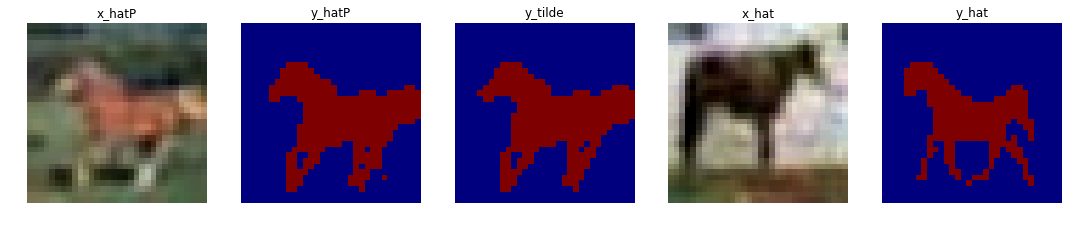

===> End of epoch 165 / 200 	 Time Taken: 16.17 sec

===> Start of epoch 166 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000337
T: learning rate = 0.0000337
[166/200][0/50] in 0.292s (0.136,0.083,0.072) D/G: 0.168/0.055 DP/GP: 0.168/0.056 X2X/X2XP: 0.079/0.052 Y2Y/Y2YP: 0.152/0.062 T: 3.032 CE: 0.006 


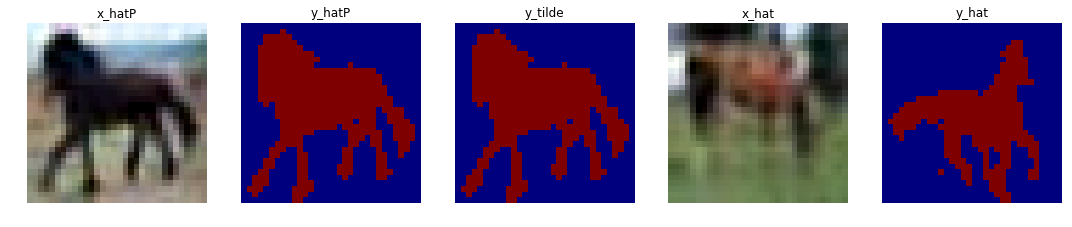

===> End of epoch 166 / 200 	 Time Taken: 16.01 sec

===> Start of epoch 167 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000327
T: learning rate = 0.0000327
[167/200][0/50] in 0.296s (0.139,0.083,0.074) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.082/0.056 Y2Y/Y2YP: 0.126/0.076 T: 9.819 CE: 0.002 


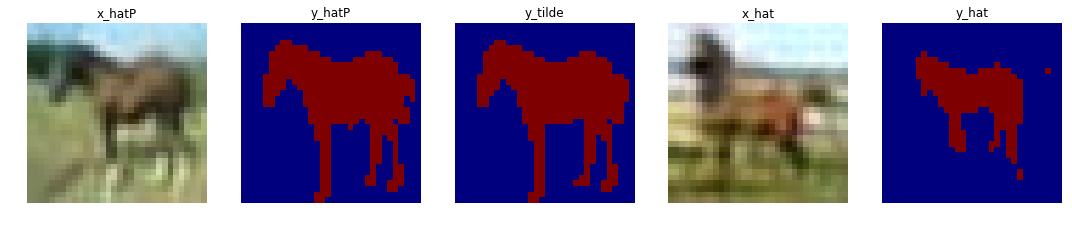

===> End of epoch 167 / 200 	 Time Taken: 16.31 sec

===> Start of epoch 168 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000317
T: learning rate = 0.0000317
[168/200][0/50] in 0.303s (0.144,0.085,0.074) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.062/0.053 Y2Y/Y2YP: 0.193/0.058 T: 5.518 CE: 0.002 


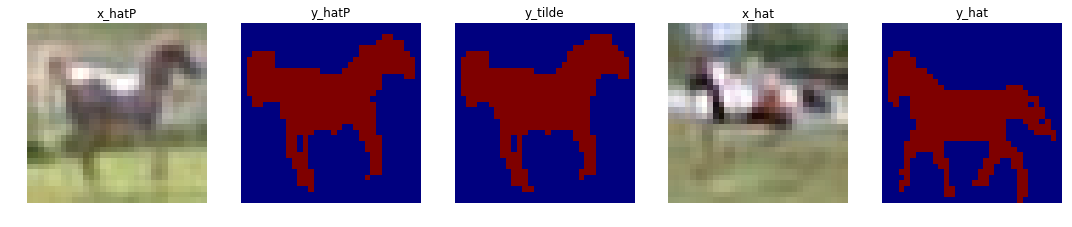

===> End of epoch 168 / 200 	 Time Taken: 16.21 sec

===> Start of epoch 169 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000307
T: learning rate = 0.0000307
[169/200][0/50] in 0.297s (0.143,0.082,0.072) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.070/0.047 Y2Y/Y2YP: 0.160/0.062 T: 2.448 CE: 0.001 


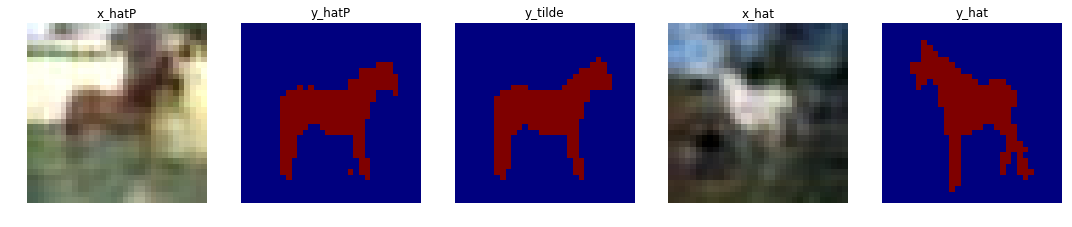

===> End of epoch 169 / 200 	 Time Taken: 15.78 sec

===> Start of epoch 170 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000297
T: learning rate = 0.0000297
[170/200][0/50] in 2.025s (1.869,0.086,0.071) D/G: 0.168/0.056 DP/GP: 0.165/0.056 X2X/X2XP: 0.082/0.051 Y2Y/Y2YP: 0.113/0.063 T: 1.943 CE: 0.001 


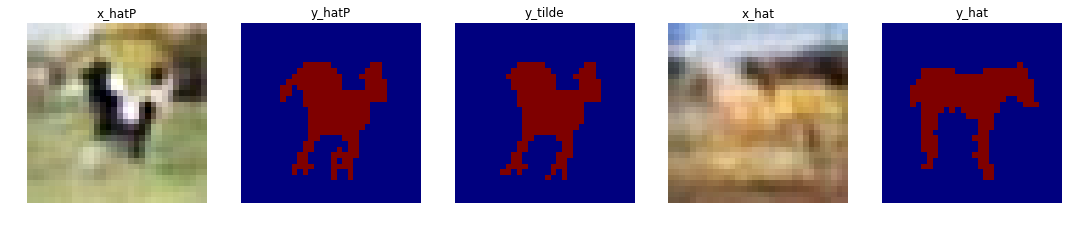

===> End of epoch 170 / 200 	 Time Taken: 17.68 sec

===> Start of epoch 171 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000287
T: learning rate = 0.0000287
[171/200][0/50] in 0.288s (0.135,0.082,0.071) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.073/0.052 Y2Y/Y2YP: 0.172/0.067 T: 6.303 CE: 0.011 


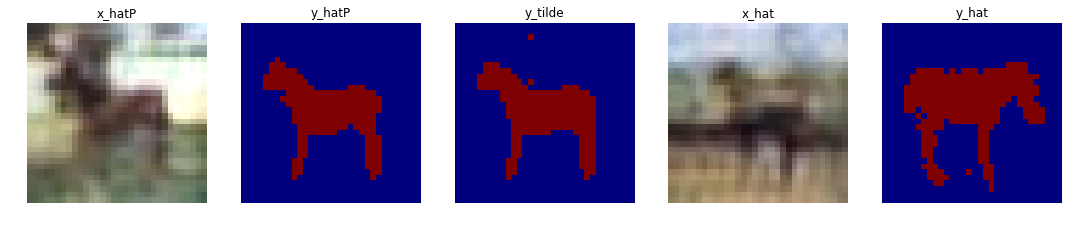

===> End of epoch 171 / 200 	 Time Taken: 16.05 sec

===> Start of epoch 172 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000277
T: learning rate = 0.0000277
[172/200][0/50] in 0.281s (0.129,0.080,0.072) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.076/0.048 Y2Y/Y2YP: 0.163/0.067 T: 1.547 CE: 0.001 


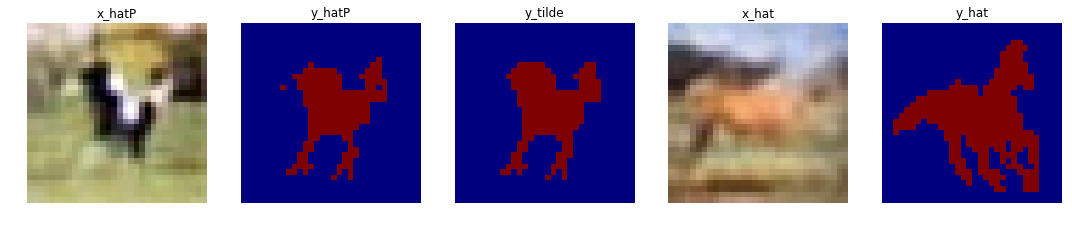

===> End of epoch 172 / 200 	 Time Taken: 15.95 sec

===> Start of epoch 173 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000267
T: learning rate = 0.0000267
[173/200][0/50] in 0.282s (0.130,0.080,0.072) D/G: 0.168/0.056 DP/GP: 0.167/0.056 X2X/X2XP: 0.080/0.051 Y2Y/Y2YP: 0.186/0.065 T: 1.405 CE: 0.003 


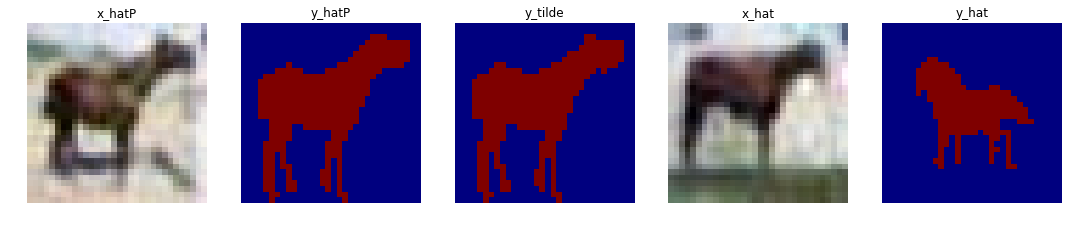

===> End of epoch 173 / 200 	 Time Taken: 15.87 sec

===> Start of epoch 174 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000257
T: learning rate = 0.0000257
[174/200][0/50] in 0.288s (0.138,0.080,0.070) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.087/0.049 Y2Y/Y2YP: 0.147/0.063 T: 1.407 CE: 0.006 


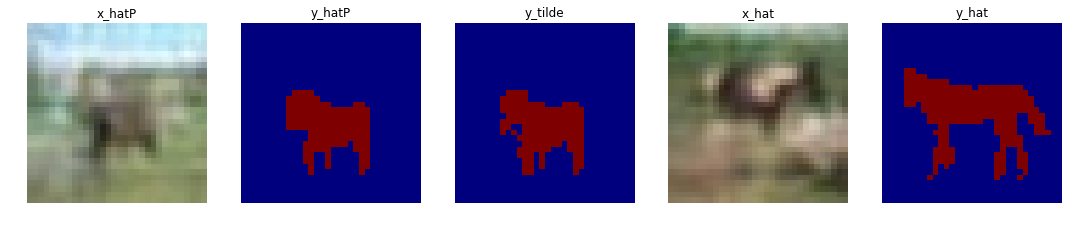

===> End of epoch 174 / 200 	 Time Taken: 16.03 sec

===> Start of epoch 175 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000248
T: learning rate = 0.0000248
[175/200][0/50] in 0.282s (0.130,0.082,0.070) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.084/0.049 Y2Y/Y2YP: 0.107/0.066 T: 1.591 CE: 0.003 


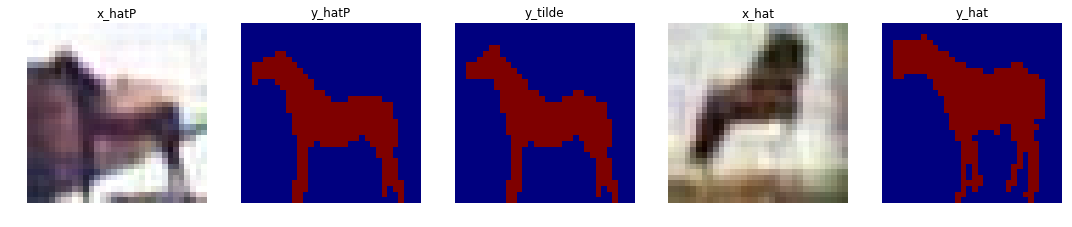

===> End of epoch 175 / 200 	 Time Taken: 16.07 sec

===> Start of epoch 176 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000238
T: learning rate = 0.0000238
[176/200][0/50] in 0.291s (0.136,0.081,0.074) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.090/0.047 Y2Y/Y2YP: 0.165/0.066 T: 1.696 CE: 0.001 


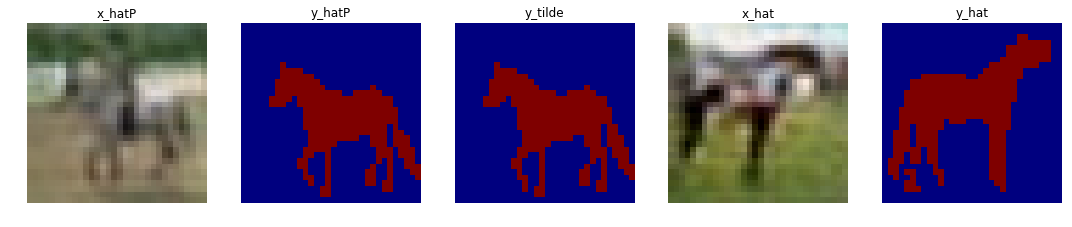

===> End of epoch 176 / 200 	 Time Taken: 16.13 sec

===> Start of epoch 177 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000228
T: learning rate = 0.0000228
[177/200][0/50] in 0.279s (0.129,0.080,0.070) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.069/0.046 Y2Y/Y2YP: 0.180/0.064 T: 1.606 CE: 0.007 


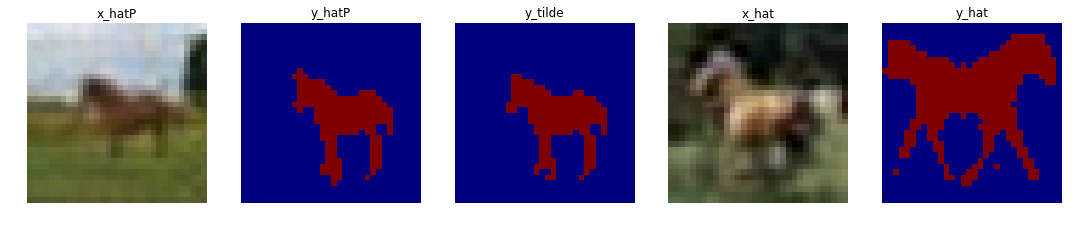

===> End of epoch 177 / 200 	 Time Taken: 16.11 sec

===> Start of epoch 178 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000218
T: learning rate = 0.0000218
[178/200][0/50] in 0.285s (0.133,0.082,0.071) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.072/0.051 Y2Y/Y2YP: 0.163/0.061 T: 1.661 CE: 0.003 


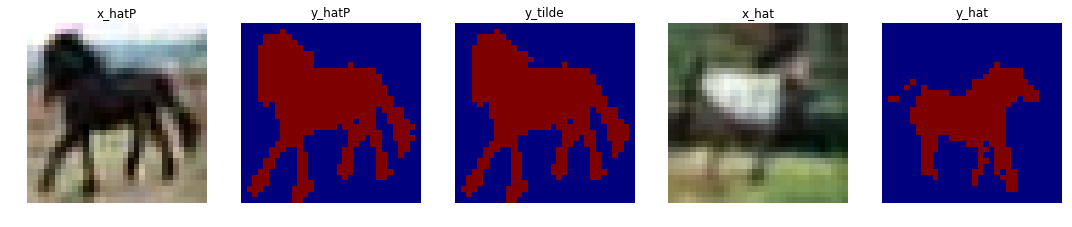

===> End of epoch 178 / 200 	 Time Taken: 16.02 sec

===> Start of epoch 179 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000208
T: learning rate = 0.0000208
[179/200][0/50] in 0.288s (0.137,0.081,0.070) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.088/0.042 Y2Y/Y2YP: 0.174/0.058 T: 1.460 CE: 0.001 


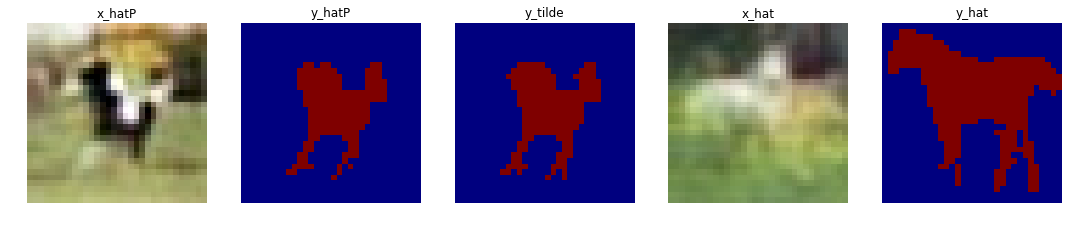

===> End of epoch 179 / 200 	 Time Taken: 16.09 sec

===> Start of epoch 180 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000198
T: learning rate = 0.0000198
[180/200][0/50] in 1.432s (1.280,0.081,0.070) D/G: 0.168/0.056 DP/GP: 0.149/0.056 X2X/X2XP: 0.065/0.052 Y2Y/Y2YP: 0.157/0.055 T: 1.313 CE: 0.001 


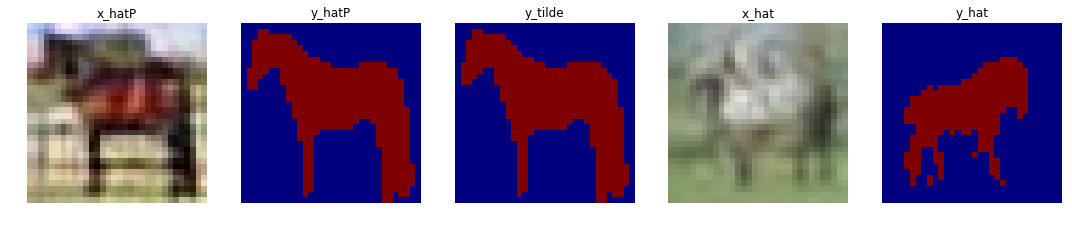

===> End of epoch 180 / 200 	 Time Taken: 17.34 sec

===> Start of epoch 181 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000188
T: learning rate = 0.0000188
[181/200][0/50] in 0.294s (0.139,0.083,0.071) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.060/0.045 Y2Y/Y2YP: 0.165/0.057 T: 1.435 CE: 0.001 


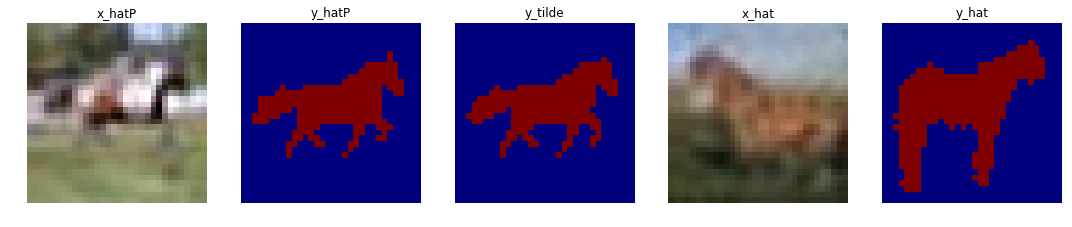

===> End of epoch 181 / 200 	 Time Taken: 16.09 sec

===> Start of epoch 182 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000178
T: learning rate = 0.0000178
[182/200][0/50] in 0.301s (0.146,0.083,0.073) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.070/0.054 Y2Y/Y2YP: 0.158/0.067 T: 4.543 CE: 0.002 


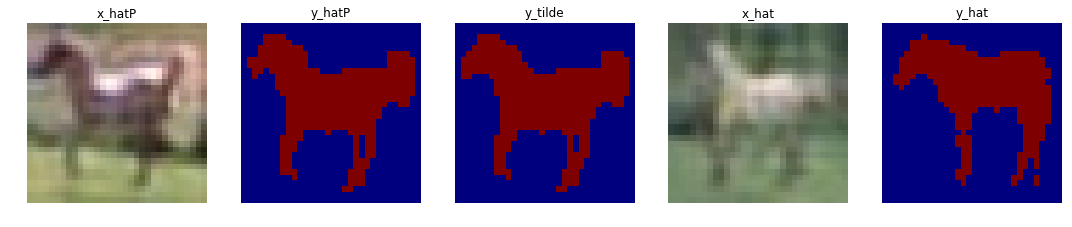

===> End of epoch 182 / 200 	 Time Taken: 16.13 sec

===> Start of epoch 183 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000168
T: learning rate = 0.0000168
[183/200][0/50] in 0.293s (0.138,0.083,0.072) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.072/0.048 Y2Y/Y2YP: 0.150/0.055 T: 1.401 CE: 0.001 


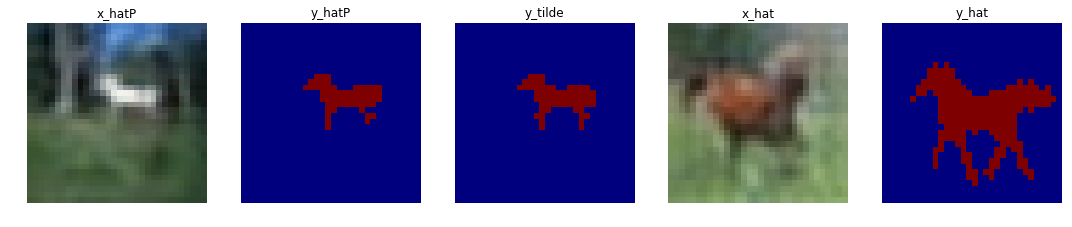

===> End of epoch 183 / 200 	 Time Taken: 16.08 sec

===> Start of epoch 184 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000158
T: learning rate = 0.0000158
[184/200][0/50] in 0.297s (0.143,0.083,0.072) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.067/0.047 Y2Y/Y2YP: 0.138/0.072 T: 1.287 CE: 0.001 


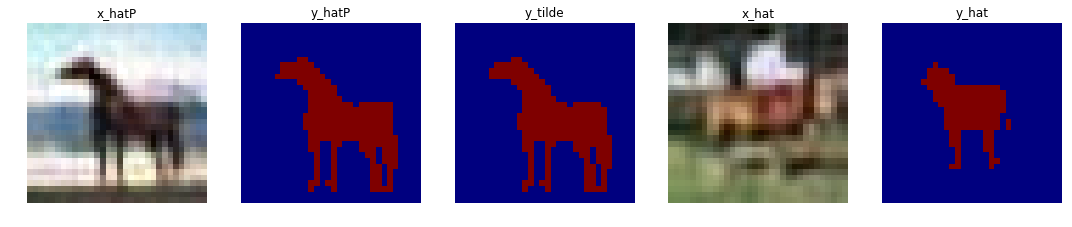

===> End of epoch 184 / 200 	 Time Taken: 16.40 sec

===> Start of epoch 185 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000149
T: learning rate = 0.0000149
[185/200][0/50] in 0.290s (0.135,0.082,0.073) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.077/0.041 Y2Y/Y2YP: 0.128/0.066 T: 1.326 CE: 0.001 


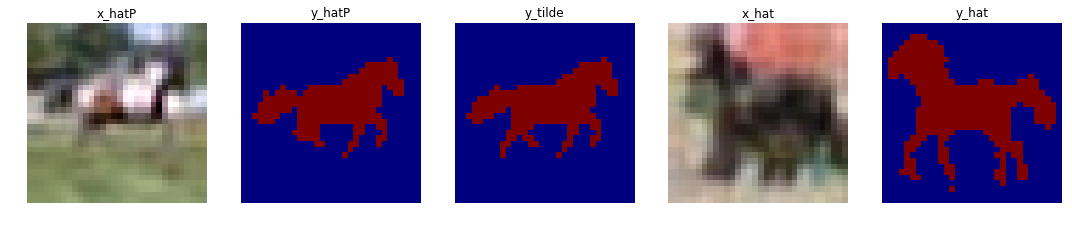

===> End of epoch 185 / 200 	 Time Taken: 16.20 sec

===> Start of epoch 186 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000139
T: learning rate = 0.0000139
[186/200][0/50] in 0.290s (0.137,0.082,0.070) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.073/0.048 Y2Y/Y2YP: 0.163/0.068 T: 1.404 CE: 0.001 


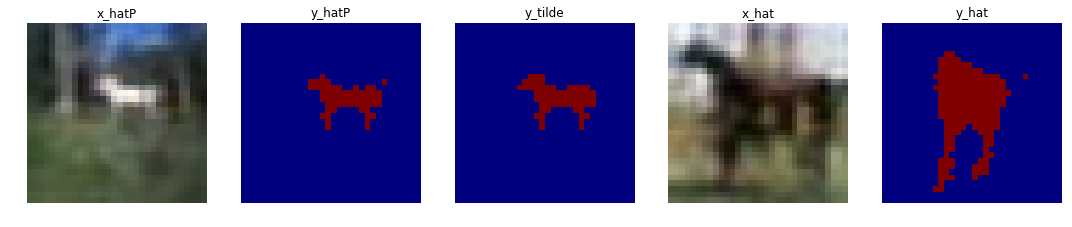

===> End of epoch 186 / 200 	 Time Taken: 15.94 sec

===> Start of epoch 187 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000129
T: learning rate = 0.0000129
[187/200][0/50] in 0.291s (0.136,0.083,0.072) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.086/0.048 Y2Y/Y2YP: 0.142/0.063 T: 1.418 CE: 0.001 


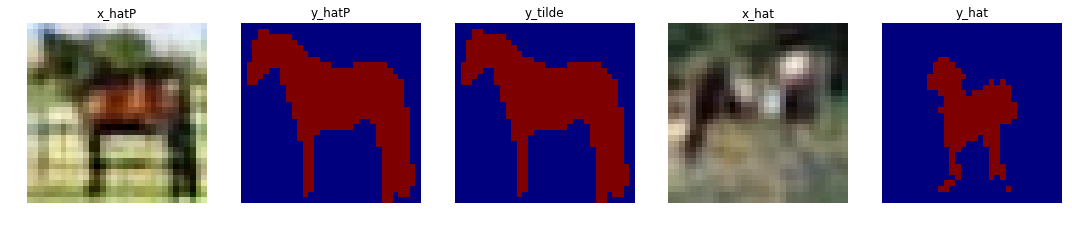

===> End of epoch 187 / 200 	 Time Taken: 16.22 sec

===> Start of epoch 188 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000119
T: learning rate = 0.0000119
[188/200][0/50] in 0.291s (0.136,0.082,0.073) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.082/0.040 Y2Y/Y2YP: 0.134/0.060 T: 1.336 CE: 0.000 


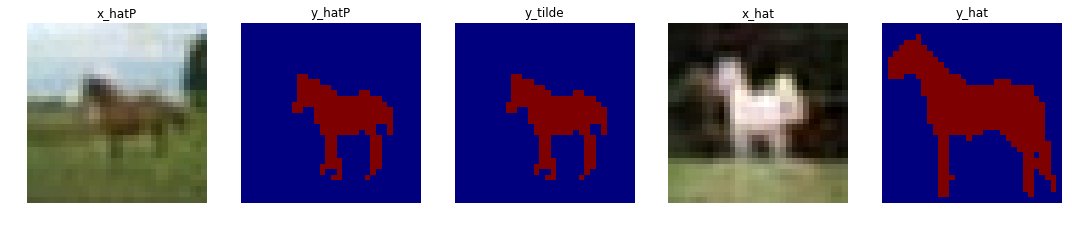

===> End of epoch 188 / 200 	 Time Taken: 16.09 sec

===> Start of epoch 189 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000109
T: learning rate = 0.0000109
[189/200][0/50] in 0.292s (0.135,0.082,0.074) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.079/0.049 Y2Y/Y2YP: 0.143/0.060 T: 3.486 CE: 0.001 


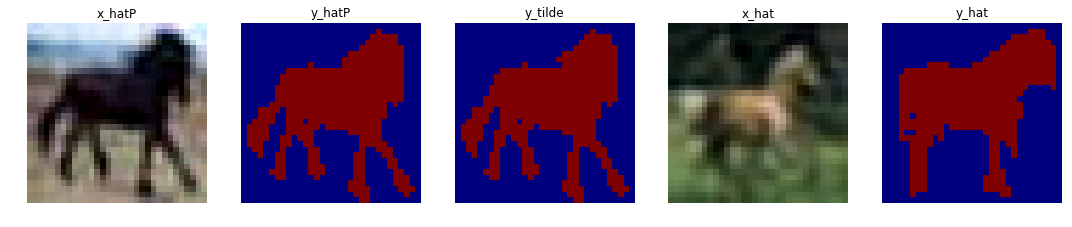

===> End of epoch 189 / 200 	 Time Taken: 16.33 sec

===> Start of epoch 190 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000099
T: learning rate = 0.0000099
[190/200][0/50] in 1.503s (1.348,0.083,0.071) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.064/0.047 Y2Y/Y2YP: 0.161/0.052 T: 1.694 CE: 0.001 


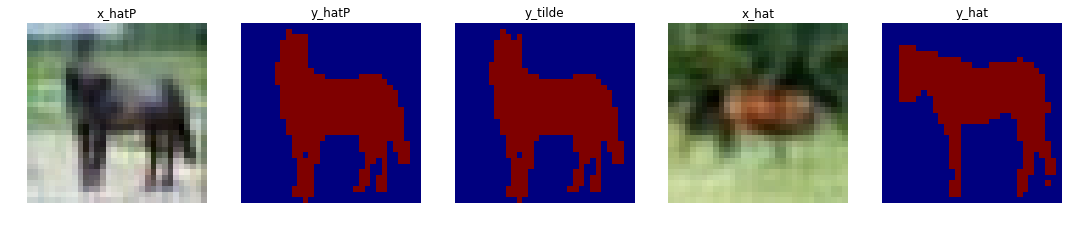

===> End of epoch 190 / 200 	 Time Taken: 17.40 sec

===> Start of epoch 191 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000089
T: learning rate = 0.0000089
[191/200][0/50] in 0.292s (0.137,0.083,0.072) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.074/0.042 Y2Y/Y2YP: 0.147/0.060 T: 1.694 CE: 0.003 


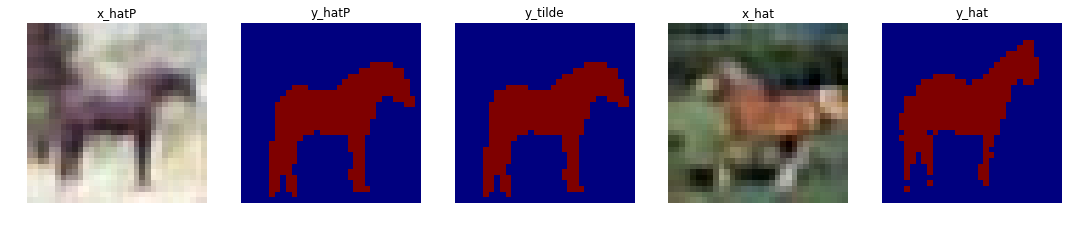

===> End of epoch 191 / 200 	 Time Taken: 15.95 sec

===> Start of epoch 192 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000079
T: learning rate = 0.0000079
[192/200][0/50] in 0.296s (0.139,0.084,0.073) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.063/0.045 Y2Y/Y2YP: 0.139/0.056 T: 1.847 CE: 0.001 


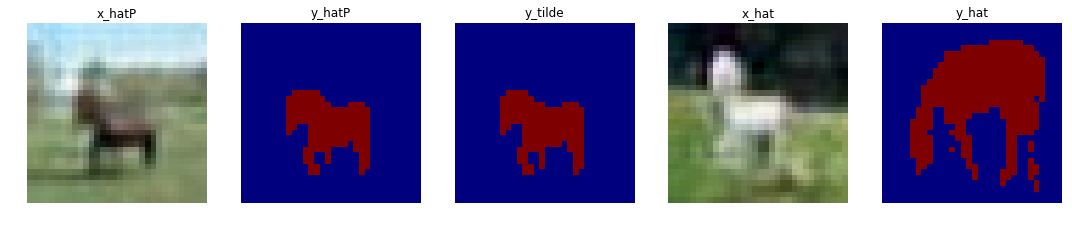

===> End of epoch 192 / 200 	 Time Taken: 16.02 sec

===> Start of epoch 193 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000069
T: learning rate = 0.0000069
[193/200][0/50] in 0.297s (0.139,0.084,0.074) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.086/0.046 Y2Y/Y2YP: 0.167/0.056 T: 1.494 CE: 0.002 


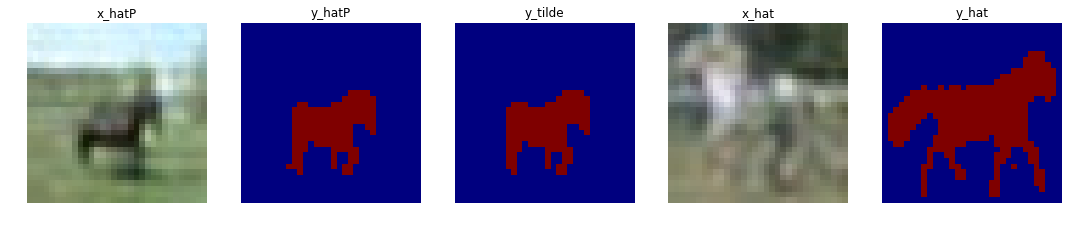

===> End of epoch 193 / 200 	 Time Taken: 16.64 sec

===> Start of epoch 194 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000059
T: learning rate = 0.0000059
[194/200][0/50] in 0.293s (0.138,0.083,0.071) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.094/0.048 Y2Y/Y2YP: 0.085/0.066 T: 1.686 CE: 0.003 


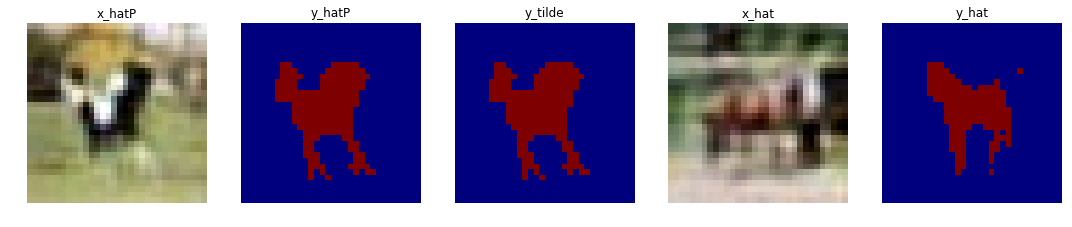

===> End of epoch 194 / 200 	 Time Taken: 16.41 sec

===> Start of epoch 195 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000050
T: learning rate = 0.0000050
[195/200][0/50] in 0.293s (0.138,0.083,0.072) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.074/0.049 Y2Y/Y2YP: 0.124/0.062 T: 1.501 CE: 0.001 


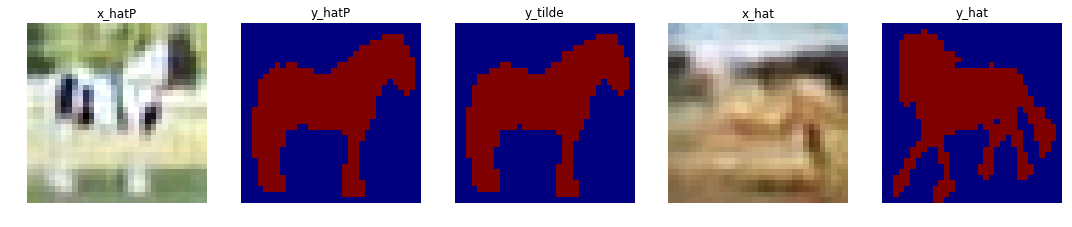

===> End of epoch 195 / 200 	 Time Taken: 16.16 sec

===> Start of epoch 196 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000040
T: learning rate = 0.0000040
[196/200][0/50] in 0.291s (0.137,0.083,0.072) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.064/0.039 Y2Y/Y2YP: 0.133/0.058 T: 1.134 CE: 0.001 


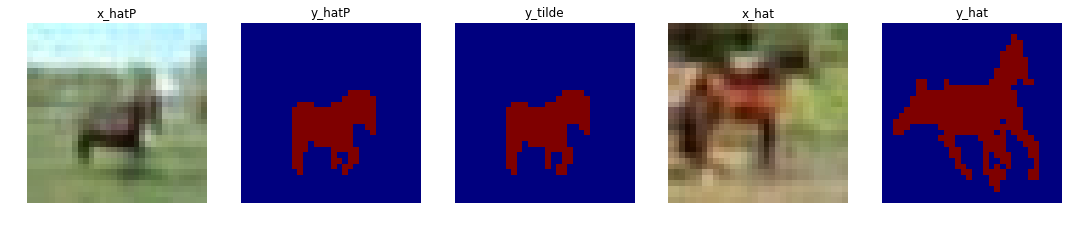

===> End of epoch 196 / 200 	 Time Taken: 16.12 sec

===> Start of epoch 197 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000030
T: learning rate = 0.0000030
[197/200][0/50] in 0.297s (0.143,0.082,0.071) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.071/0.035 Y2Y/Y2YP: 0.136/0.061 T: 1.962 CE: 0.001 


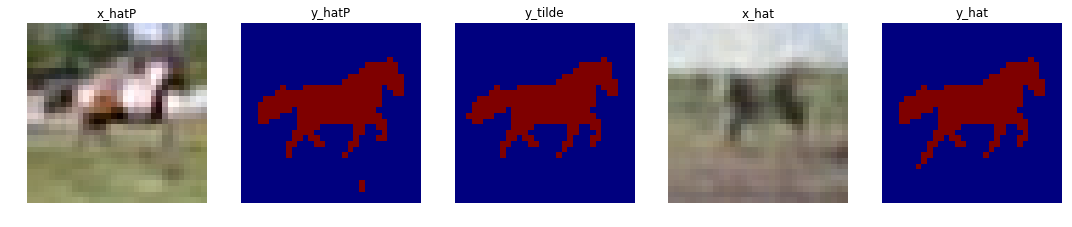

===> End of epoch 197 / 200 	 Time Taken: 15.90 sec

===> Start of epoch 198 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000020
T: learning rate = 0.0000020
[198/200][0/50] in 0.298s (0.144,0.083,0.071) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.074/0.040 Y2Y/Y2YP: 0.144/0.065 T: 1.307 CE: 0.001 


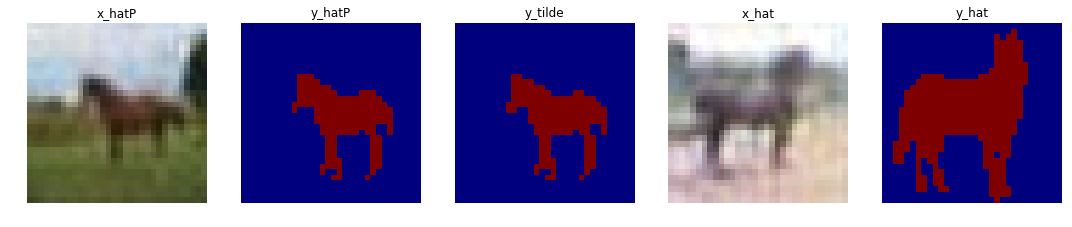

===> End of epoch 198 / 200 	 Time Taken: 16.02 sec

===> Start of epoch 199 / 200
X2Z: learning rate = 0.0049505
Z2X: learning rate = 0.0049505
Y2Z: learning rate = 0.0000495
Z2Y: learning rate = 0.0000495
D: learning rate = 0.0000010
T: learning rate = 0.0000010
[199/200][0/50] in 0.295s (0.139,0.084,0.072) D/G: 0.168/0.056 DP/GP: 0.168/0.056 X2X/X2XP: 0.085/0.040 Y2Y/Y2YP: 0.142/0.053 T: 1.266 CE: 0.001 


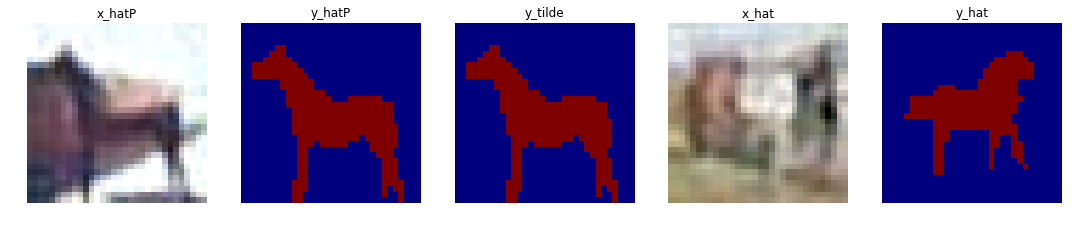

===> End of epoch 199 / 200 	 Time Taken: 15.98 sec



In [58]:
for epoch in range(opt.start_epoch, opt.niter):
    # on begin epoch
    adjust_lr(epoch, ['T', 'D'])
    epoch_start_time = time.time()

    for i in range(len(x_loader)):
        if g_it < 25 or g_it % 500 == 0:
            D_ITERS = 20 # 100
        else:
            D_ITERS = 2 # 5
            
        stats = {}
        images = {}
          
        # -------------------------------------------------------------------
        #        Optimize over D
        # -------------------------------------------------------------------
        tt0 = time.time() 
        for d_i in range(D_ITERS):
            # unpaired
            v_x = generate_var_x()
            _, v_y = generate_var_y()
            d_loss = D_forbackward(v_x, v_y)
            stats['D'] = -d_loss # real - fake
            
            # paired
            v_x, _, v_y = generate_var_xy()
            d_loss = D_forbackward(v_x, v_y)
            stats['DP'] = -d_loss

        # -------------------------------------------------------------------
        #        Optimize over other nets
        # -------------------------------------------------------------------
        tt1 = time.time()
        # -------------------------------------------------------------------
        # paired X, Y
        i_losses = {}
        v_x, v_y_int, v_y = generate_var_xy()
        i_losses['X2X'], z_x, x_hat_dict = x2x_forward(v_x) # X2XP
        i_losses['Y2Y'], z_y, y_hat_dict = y2y_forward(v_y_int, v_y) # Y2YP
        T_losses, y_tilde_dict = T_forward(z_x, z_y=z_y, v_y_int=v_y_int) # GANP, T, CE
        i_losses.update(T_losses)
        G_backward(i_losses)
            
        if i % (len(x_loader)/3) == 0:    
            stats.update({k+'P':v.data[0] for k,v in i_losses.items()})
            images.update({k+'P':v for k,v in x_hat_dict.items()})
            images.update({k+'P':v for k,v in y_hat_dict.items()})
            images.update(y_tilde_dict)

        tt2 = time.time()
        # -------------------------------------------------------------------
        # unpaired x, y
        i_losses = {}
        v_x = generate_var_x()
        v_y_int, v_y = generate_var_y()
        i_losses['X2X'], z_x, x_hat_dict = x2x_forward(v_x) # X2X
        i_losses['Y2Y'], z_y, y_hat_dict = y2y_forward(v_y_int, v_y) # Y2Y
        T_losses, _ = T_forward(z_x) # GAN only = -fake
        i_losses.update(T_losses)
        G_backward(i_losses)
            
        if i % (len(x_loader)/3) == 0:
            stats.update({k:v.data[0] for k,v in i_losses.items()})
            images.update(x_hat_dict)
            images.update(y_hat_dict)
            
        # time spent per sample
        tt3 = time.time()
        g_it += 1

        # -------------------------------------------------------------------
        # print & plot
        if i % (len(x_loader)/3) == 0:
            print('[{epoch}/{nepoch}][{iter}/{niter}] in {t:.3f}s ({t01:.3f},{t12:.3f},{t23:.3f}) '
                  'D/G: {D:.3f}/{GAN:.3f} '
                  'DP/GP: {DP:.3f}/{GANP:.3f} '
                  'X2X/X2XP: {X2X:.3f}/{X2XP:.3f} '
                  'Y2Y/Y2YP: {Y2Y:.3f}/{Y2YP:.3f} '
                  'T: {TP:.3f} CE: {CEP:.3f} '
                  ''.format(epoch=epoch, nepoch=opt.niter,
                            iter=i, niter=len(x_loader),
                            t=tt3-tt0, t01=tt1-tt0, t12=tt2-tt1, t23=tt3-tt2,
                            **stats))
            display_imgs(images, epoch, i)

    # -------------------------------------------------------------------
    # on end epoch
    print('===> End of epoch %d / %d \t Time Taken: %.2f sec\n' % \
                (epoch, opt.niter, time.time() - epoch_start_time))

    # evaluation & save (best only)
    if epoch % opt.save_every == 0 and False:
        visualizer.save_webpage(prefix='train') # visualizer maintains a img_dict to be saved in webpage
        temp_mIoU = evaluation(epoch, 'eval')
        if temp_mIoU >= mIoU:
            mIoU = temp_mIoU
            for k in net.keys():
                weights_fpath = os.path.join(opt.checkpoints_dir, opt.name, 'net%s.pth' % (k))
                torch.save(net[k].state_dict(), weights_fpath)

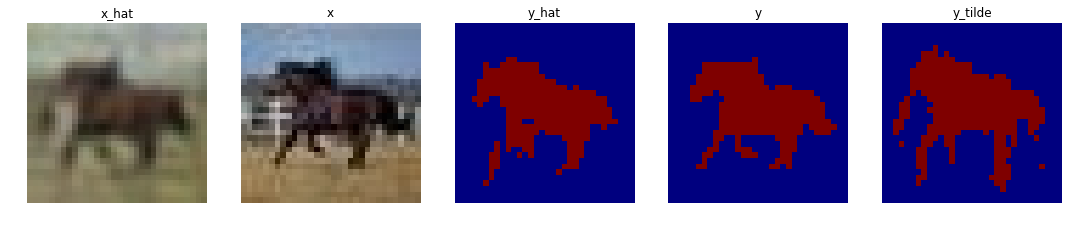

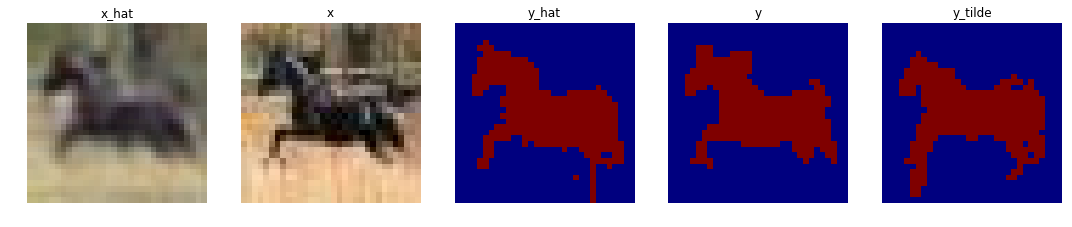

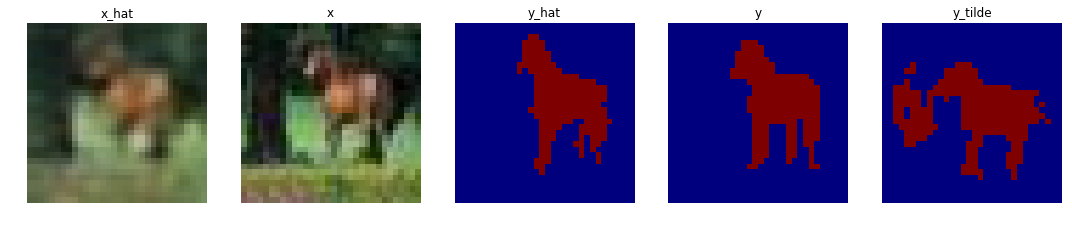

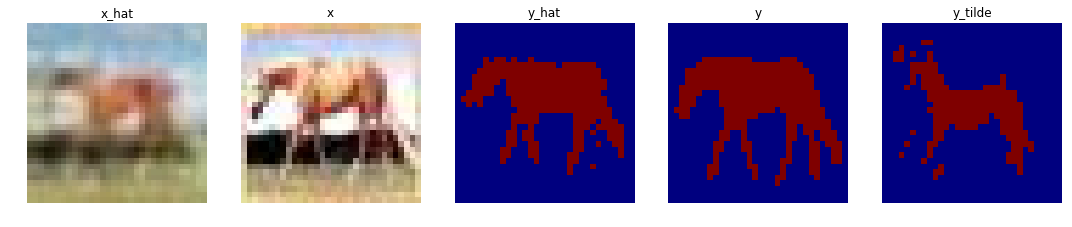

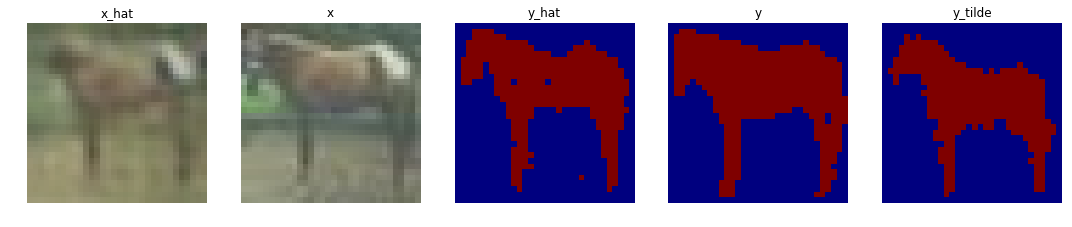

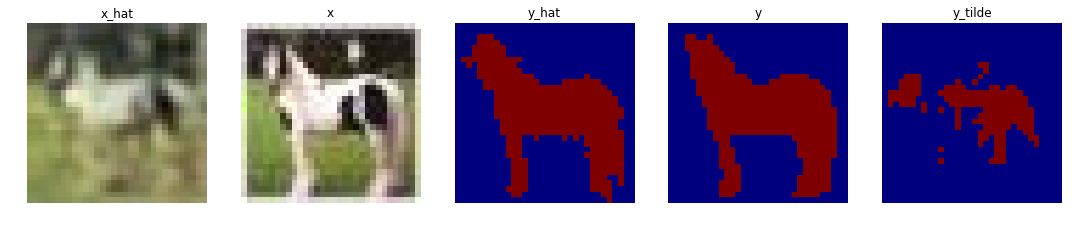

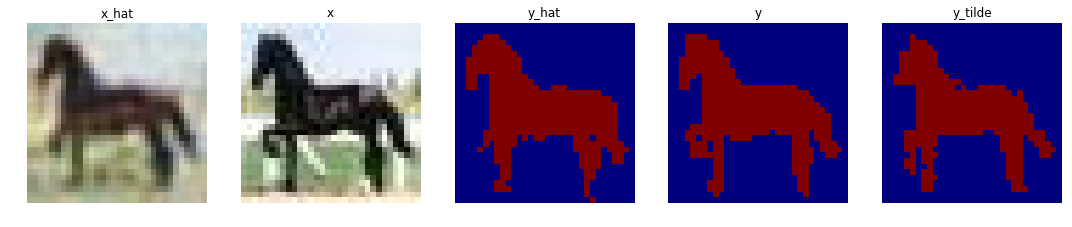

EVAL at epoch %d ==> CE: 0.795, T: 1.392 GAN: 0.056, X2X: 0.098EVAL at epoch 200 [127 images in 4.83 sec] ==> {'Overall Acc': 0.9368310162401575, 'Mean Acc': 0.9166040825398547, 'FreqW Acc': 0.8817995459277886, 'Mean IoU': 0.8581714451867108}
Per-class IoU:
Background: 0.92
Horse: 0.80



In [39]:
temp_mIoU = evaluation(200, 'eval')